In [1]:
import os
import gc
import csv
import time
import random
import pickle
import pandas as pd
import scipy.io
import scipy.fftpack
import pylab as py
from scipy import misc, fftpack
from scipy.fftpack import fft,ifft,fft2,fftshift,ifft2
import numpy as np

import matplotlib.pyplot as plt

# from sklearn.model_selection import train_valid_split
# from sklearn.base import TransformerMixin
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

from platform import python_version

# # import pytorchtools
# from pytorchtools import EarlyStopping

import shutil
import wandb
!wandb login

wandb: Currently logged in as: jiten597 (use `wandb login --relogin` to force relogin)


In [2]:
os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [3]:
print(torch.cuda.list_gpu_processes())
print("No. of GPU devices: ", torch.cuda.device_count())
print("Current GPU device: ", torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

GPU:0
process    4185795 uses    31199.000 MB GPU memory
No. of GPU devices:  1
Current GPU device:  0
GeForce RTX 2080 Ti


In [4]:
## setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

## Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
def seed_everything(seed): 
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  # False

seed_everything(0)

In [14]:
paths = {
    'path_scal'  : '/home/jsharma/PhD_projects/Cracked_beam/Dataset/898Nodes_2048steps_100kHz/Scaled/',
    'plot_scal'  : '/home/jsharma/PhD_projects/Cracked_beam/PyTorch_models/FNO/Plots_scaled_data/',
    'model_path' : '/home/jsharma/PhD_projects/Cracked_beam/PyTorch_models/FNO/Model_Outputs/',
}

arch_name              = 'CAE_+ FNO'
architecture           = 'Autoencoder'
dataset                = '642Nodes_256Frames'
loss_function          = 'mse'
paths                  = paths
latent_space_dimension = 32
epochs                 = 1000
batch_size             = 1
learning_rate          = 1*1e-4
activation             = 'relu'
dropout                = 0.2
kernel_size            = 5


# run = wandb.init(project='PyTorch_1024steps_FNO_CAE_01-Rexio',
#                  config={
#                     'loss_function'          : loss_function,
#                     'paths'                  : paths,
#                     'architecture'           : architecture,
#                     'dataset'                : dataset,
#                     'arch_name'              : arch_name,
#                     'learning_rate'          : learning_rate,
#                     'latent_space_dimension' : latent_space_dimension,
#                     'epochs'                 : epochs,
#                     'batch_size'             : batch_size,
#                     'activation'             : activation, 
#                     'kernel_size'            : kernel_size,
#                  })
# config = wandb.config

In [15]:
# X_train = np.load(paths['path_scal'] + 'X_train.npy')
# X_test  = np.load(paths['path_scal'] + 'X_test.npy')
# X_exp   = np.load(paths['path_scal'] + 'X_exp.npy')

# p_train = np.load(paths['path_scal'] + 'p_train.npy')
# p_test  = np.load(paths['path_scal'] + 'p_test.npy')
# p_exp   = np.load(paths['path_scal'] + 'p_exp.npy')

# print(X_train.shape)
# print(X_test.shape)
# print(X_exp.shape)
# print(p_train.shape)
# print(p_test.shape)
# print(p_exp.shape)

In [16]:
# print(X_train.max())
# print(X_test.max())
# print(X_exp.max())

# print(X_train.min())
# print(X_test.min())
# print(X_exp.min())

# Utils

In [17]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path1='Encoder_checkpoint.pt', 
                                                           path2='Decoder_checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path1 = path1
        self.path2 = path2
        self.trace_func = trace_func
    def __call__(self, val_loss, encoder, decoder):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, encoder, decoder)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, encoder, decoder)
            self.counter = 0

    def save_checkpoint(self, val_loss, encoder, decoder):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min} --> {val_loss}).  Saving model ...')
        torch.save(encoder.state_dict(), self.path1)
        torch.save(decoder.state_dict(), self.path2)
        self.val_loss_min = val_loss

class EarlyStopping_NN:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='NN_checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path  = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min} --> {val_loss}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [18]:
def data_reshape(X):
    return np.reshape(X,(X.shape[0], X.shape[1], X.shape[2], 1))

class R2_loss(nn.Module):
    def __init__(self,):
        super(R2_loss, self).__init__()

    def forward(self, x, y):
        mx = torch.mean(x, 0)
        my = torch.mean(y, 0)
        xm, ym = x - mx, y - my # Centering the data
        r_num = torch.sum((xm * ym))
        x_square_sum = torch.sum((xm * xm))
        y_square_sum = torch.sum((ym * ym))
        r_den = torch.sqrt(x_square_sum * y_square_sum)
        r = r_num / r_den
        return torch.mean(r, dtype=torch.float32)

def CC(y_true, y_pred):
    '''
    Compute correlation coefficients or Pearson's correlations
    '''
    n_y_true = y_true
    n_y_pred = y_pred

    #normalise
    # n_y_true = (y_true - torch.mean(y_true[:],0)) / torch.std(y_true[:],0)
    # n_y_pred = (y_pred - torch.mean(y_pred[:],0)) / torch.std(y_pred[:],0)  
    top    = torch.sum((n_y_true[:] - torch.mean(n_y_true[:],0)) * (n_y_pred[:] - torch.mean(n_y_pred[:],0)))
    bottom = torch.sqrt(torch.sum(torch.pow((n_y_true[:] - torch.mean(n_y_true[:],0)), 
                                        2)) * torch.sum(torch.pow(n_y_pred[:] - torch.mean(n_y_pred[:],0), 2)))
    result=top/bottom
    return torch.mean(result, dtype=torch.float32)

def RMSE(y_true, y_pred):
    return torch.sqrt(torch.mean(torch.square(y_pred - y_true))) 

######## Plotting ########
def plot3(data_orig, data_pred, parameters, sample, snapshot_time):
    '''
    E.g.
    reconstructed = Decoder(Encoder(X))
    plot3(X, reconstructed, parameters, 10, 200)
    '''
    ca_sample = parameters[sample][0]
    ck_sample = parameters[sample][1]
    label  = f'ca = {"%.5f" % ca_sample} and ck = {"%.5f" % ck_sample}'
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,9))
    fig.subplots_adjust()
    fig.suptitle(label, fontsize=14, fontweight='bold')

    ax1.plot(data_pred[sample, snapshot_time, :], 'k--', lw=1.5, label='Predicted')
    ax1.legend()
    ax2.plot(data_orig[sample, snapshot_time, :], 'r', lw=1.5, label='Original')
    ax2.legend()
    ax3.plot(data_orig[sample, snapshot_time, :] - data_pred[sample, snapshot_time, :],
             'b', lw=1.5, label='Difference')
    ax3.legend()
    plt.show()

def plot2(data, pred, parameters, sample, time_snapshot):
    '''
    E.g.
    plot_(data, pred, parameters, sample=1, time_snapshot=200)
    '''
    ca_sample = parameters[sample][0]
    ck_sample = parameters[sample][1]
    label     = f'ca = {"%.5f" % ca_sample} and ck = {"%.5f" % ck_sample}'

    fig, ax = plt.subplots(figsize=(16,6))
    fig.subplots_adjust()
    fig.suptitle(label, fontsize=14, fontweight='bold')

    ax.plot(pred[sample, time_snapshot, :], 'k--', lw=1.5, label='Predicted')
    ax.plot(data[sample, time_snapshot, :], 'r',   lw=1.5, label='Original')
    ax.legend()
    plt.title(f"Snapshot at {time_snapshot}th time-step")
    plt.show()

def wave_pattern(p, X, pred_results, sample):
    ca_sample = p[sample][0]
    ck_sample = p[sample][1]
    label  = f'ca = {"%.5f" % ca_sample} and ck = {"%.5f" % ck_sample}'

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(16,12))
    fig.subplots_adjust()
    fig.suptitle(label, fontsize=14, fontweight='bold')

    f1 = ax1.imshow(pred_results[sample], aspect='auto', cmap= 'seismic')
    ax1.set_title('Predicted')
    fig.colorbar(f1, ax = ax1)

    f2 = ax2.imshow(X[sample], aspect='auto', cmap= 'seismic')
    ax2.set_title('Original')
    fig.colorbar(f2, ax = ax2)

    f3 = ax3.imshow(pred_results[sample] - X[sample], aspect='auto', cmap= 'seismic')
    ax3.set_title('Difference')
    fig.colorbar(f3, ax = ax3)

    plt.tight_layout()
    plt.show()

def plot_fft(p, X, pred_results, sample):
    ca_sample = p[sample][0]
    ck_sample = p[sample][1]
    label  = f'ca = {"%.5f" % ca_sample} and ck = {"%.5f" % ck_sample}'

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(16,12))
    fig.subplots_adjust()
    fig.suptitle(label, fontsize=14, fontweight='bold')

    z1 = fftshift(fft2(pred_results[sample]))
    f1 = ax1.imshow(abs(z1), aspect='auto', cmap= 'cividis')
    ax1.set_title('Predicted')
    ax1.set_xlabel('wave-number')
    ax1.set_ylabel('frequency')
    fig.colorbar(f1, ax=ax1)

    z2 = fftshift(fft2(X[sample]))
    f2 = ax2.imshow(abs(z2), aspect='auto', cmap= 'cividis')
    ax2.set_title('Original')
    ax2.set_xlabel('wave-number')
    ax2.set_ylabel('frequency')
    fig.colorbar(f2, ax=ax2)

    f3 = ax3.imshow((abs(z2)-abs(z1)), aspect='auto', cmap= 'cividis')
    ax3.set_title('Error')
    ax3.set_xlabel('wave-number')
    ax3.set_ylabel('frequency')
    fig.colorbar(f3, ax=ax3)

    plt.tight_layout()
    plt.show()

def crop(image, x1, x2, y1, y2):
    """
    Return the cropped image at the x1, x2, y1, y2 coordinates
    """
    if x2 == -1:
        x2=image.shape[1]-1
    if y2 == -1:
        y2=image.shape[0]-1

    mask = np.zeros(image.shape)
    mask[y1:y2+1, x1:x2+1]=1
    m = mask > 0

    return image[m].reshape((y2+1-y1, x2+1-x1))

def plot_fft_cropped(p, X, pred_results, sample):
    ca_sample = p_exp[sample][0]
    ck_sample = p_exp[sample][1]
    label  = f'ca = {"%.5f" % ca_sample} and ck = {"%.5f" % ck_sample}'

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,5))
    fig.subplots_adjust()
    fig.suptitle(label, fontsize=14, fontweight='bold')

    z1 = fftshift(fft2(pred_results[sample]))
    f1 = ax1.imshow(crop(abs(z1), 250, 390, 400, 625), aspect='auto', cmap= 'cividis')
    ax1.set_title('Predicted')
    ax1.set_xlabel('wave-number')
    ax1.set_ylabel('frequency')
    fig.colorbar(f1, ax=ax1)

    z2 = fftshift(fft2(X[sample]))
    f2 = ax2.imshow(crop(abs(z2), 250, 390, 400, 625), aspect='auto', cmap= 'cividis')
    ax2.set_title('Original')
    ax2.set_xlabel('wave-number')
    ax2.set_ylabel('frequency')
    fig.colorbar(f2, ax=ax2)

    f3 = ax3.imshow((crop(abs(z1), 250, 390, 400, 625) - crop(abs(z2), 250, 390, 400, 625)), 
                    aspect='auto', cmap= 'cividis')
    ax3.set_title('Error')
    ax3.set_xlabel('wave-number')
    ax3.set_ylabel('frequency')
    fig.colorbar(f3, ax=ax3)

    plt.tight_layout()
    plt.show()

####### L2-norm error ########
def l2_error_AE(p, X, Recons):
    error = 0
    N = p.shape[0]

    for sample in range(N):
        error = error + (1/N)*np.linalg.norm(X[sample, :, :] - Recons[sample, :, :],
                                             2) / np.linalg.norm(X[sample, :, :], 2)
    
    print('L2-norm error --> AE = ', error)

def l2_error_NN(p, encoded, NN_preds):
    error = 0
    N     = p.shape[0]

    for sample in range(N):
        error = error + (1/N)*(np.linalg.norm(encoded[sample,:] - NN_preds[sample,:], 
                                              2 ) / np.linalg.norm(encoded[sample,:],2 ))

    print('L2-norm error --> FFNN = ', error)

def l2_error_surrogate(p, X, preds):
    error = 0
    N     = p.shape[0]

    for sample in range(N):
        error = error + (1/N) * (np.linalg.norm(X[sample,:,:] - preds[sample,:,:], 
                                                2 ) / np.linalg.norm(X[sample,:,:], 2 ))
    print('L2-norm error --> AE+FFNN = ', error)

def save_mat(data, save_path, filename):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    data  = {'U':np.array(data)}
    scipy.io.savemat(save_path + filename, data)

### saving and loading models
def save_model_weights(model, filename, verbose=1, cp_folder=""):
    if verbose:
        print(f"\n -> Saving weights to {os.path.join(cp_folder, filename)}\n")
    torch.save(model.state_dict(), os.path.join(cp_folder, filename))

def load_model_weights(model, filename, verbose=1, cp_folder=""):
    if verbose:
        print(f"\n -> Loading weights from {os.path.join(cp_folder,filename)}\n")
    try:
        model.load_state_dict(os.path.join(cp_folder, filename), strict=strict)
    except BaseException:
        model.load_state_dict(
            torch.load(os.path.join(cp_folder, filename), map_location="cpu"),
            strict=True,
        )
    return model

def count_parameters(model, all=False):
    if all:
        return sum(p.numel() for p in model.parameters())
    else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)


# DataLoaders

In [19]:
class Train_Dataset(Dataset):
    def __init__(self, paths):
        super(Train_Dataset, self).__init__()
        self.paths = paths
        X_train = np.load(self.paths['path_scal'] + 'X_train.npy')
        X_train = np.transpose(X_train, (0, 2, 1))
        p_train = np.load(self.paths['path_scal'] + 'p_train.npy')
        self.n_samples = p_train.shape[0]

        self.x_data = torch.from_numpy(p_train)
        self.y_data = torch.from_numpy(X_train)

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class valid_Dataset(Dataset):
    def __init__(self, paths):
        super(valid_Dataset, self).__init__()
        self.paths = paths
        X_test = np.load(self.paths['path_scal'] + 'X_test.npy')
        X_test = np.transpose(X_test, (0, 2, 1))
        p_test = np.load(self.paths['path_scal'] + 'p_test.npy')
        self.n_samples = p_test.shape[0]

        self.x_data = torch.from_numpy(p_test)
        self.y_data = torch.from_numpy(X_test)

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class Exp_Dataset(Dataset):
    def __init__(self, paths):
        super(Exp_Dataset, self).__init__()
        self.paths = paths
        X_exp = np.load(self.paths['path_scal'] + 'X_exp.npy')
        X_exp = np.transpose(X_exp, (0, 2, 1))
        p_exp = np.load(self.paths['path_scal'] + 'p_exp.npy')
        self.n_samples = p_exp.shape[0]

        self.x_data = torch.from_numpy(p_exp)
        self.y_data = torch.from_numpy(X_exp)

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [20]:
train_dataset = Train_Dataset(paths)
valid_dataset = valid_Dataset(paths)
exp_dataset   = Exp_Dataset(paths)

In [21]:
first_data = train_dataset[0]
features, labels = first_data
print(features.shape, labels.shape)

torch.Size([2]) torch.Size([2048, 898])


In [22]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
exp_loader   = DataLoader(dataset=exp_dataset,   batch_size=batch_size, shuffle=False)

In [23]:
for i, j in train_loader:
#     plt.imshow(j[0])
    print(i.shape)
    print(j.shape)
    break

torch.Size([1, 2])
torch.Size([1, 2048, 898])


# FNO

In [24]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, modes1=128):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, 
                                                             dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, 
                             dtype=torch.cfloat)
        # out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1, dtype=torch.cfloat)
        #print(out_ft.shape)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

In [17]:
class Encoder1D(nn.Module): 
    def __init__(self):
        super(Encoder1D, self).__init__()
        
        ### Convolutional section
        self.spec1 = SpectralConv1d(642, 512)               # -> None, 512, 1024
        self.conv1 = nn.Conv1d(642, 512, 1, padding='same') # -> None, 512, 1024
        self.pool1 = nn.AvgPool1d(5, stride=2, padding=2)   # -> None, 512, 512
        
        self.spec2 = SpectralConv1d(512, 256)               # -> None, 256, 512
        self.conv2 = nn.Conv1d(512, 256, 1, padding='same') # -> None, 256, 512
        self.pool2 = nn.AvgPool1d(5, stride=2, padding=2)   # -> None, 256, 256
        
        self.spec3 = SpectralConv1d(256, 128)               # -> None, 128, 256
        self.conv3 = nn.Conv1d(256, 128, 1, padding='same') # -> None, 128, 256
        self.pool3 = nn.AvgPool1d(5, stride=2, padding=2)   # -> None, 128, 128
        
        self.spec4 = SpectralConv1d(128, 64)                # -> None, 64,  128
        self.conv4 = nn.Conv1d(128, 64, 1, padding='same')  # -> None, 64,  128
        self.flat  = nn.Flatten(start_dim=1)                # -> 64*128
        self.fc    = nn.Linear(64*128, 64)
        
    def forward(self, x):
        x  = x.permute(0, 2, 1)
        x1 = self.spec1(x)
        x2 = self.conv1(x)
        x  = x1 + x2
        x  = F.relu(x)
        x  = self.pool1(x)
        
        x1 = self.spec2(x)
        x2 = self.conv2(x)
        x  = x1 + x2
        x  = F.relu(x)
        x  = self.pool2(x)
        
        x1 = self.spec3(x)
        x2 = self.conv3(x)
        x  = x1 + x2
        x  = F.relu(x)
        x  = self.pool3(x)
        
        x1 = self.spec4(x)
        x2 = self.conv4(x)
        x  = x1 + x2
        x  = F.relu(x)

        x  = self.flat(x)
        x  = self.fc(x)
        return x

In [18]:
class UpSampling1D(torch.nn.Module):
    '''
    https://github.com/pytorch/pytorch/issues/1501
    '''
    def __init__(self, scale_factor):
        super(UpSampling1D, self).__init__()
        self.upsampling2D = nn.UpsamplingNearest2d(scale_factor=scale_factor)

    def forward(self, x):
        x = torch.unsqueeze(x, 3)
        x = self.upsampling2D(x)
        x = x[:,:,:,0]
        return x

In [19]:
m = UpSampling1D(scale_factor = 2)
inputs = torch.randn(20, 16, 512)
output = m(inputs)
output.shape

torch.Size([20, 16, 1024])

In [20]:
class Decoder1D(nn.Module):
    def __init__(self,):
        super(Decoder1D, self).__init__()
        self.fc    = nn.Linear(64, 64*128)
        self.spec1 = SpectralConv1d(64, 128)                # -> None, 128, 128
        self.conv1 = nn.Conv1d(64, 128, 1, padding='same')  # -> None, 128, 128
        self.up1   = UpSampling1D(scale_factor=2)           # -> None, 128, 256

        self.spec2 = SpectralConv1d(128, 256)               # -> None, 256, 256
        self.conv2 = nn.Conv1d(128, 256, 1, padding='same') # -> None, 256, 256
        self.up2   = UpSampling1D(scale_factor=2)           # -> None, 256, 512

        self.spec3 = SpectralConv1d(256, 512)               # -> None, 512, 512
        self.conv3 = nn.Conv1d(256, 512, 1, padding='same') # -> None, 512, 512
        self.up3   = UpSampling1D(scale_factor=2)           # -> None, 512, 1024
        
        self.spec4 = SpectralConv1d(512, 642)               # -> None, 642, 1024
        self.conv4 = nn.Conv1d(512, 642, 1, padding='same') # -> None, 642, 1024


    def forward(self, x):
        x = self.fc(x)
        x = torch.reshape(x, (-1, 64, 128))
        
        x1 = self.spec1(x)
        x2 = self.conv1(x)
        x  = x1 + x2
        x  = F.relu(x)
        x  = self.up1(x)
        
        x1 = self.spec2(x)
        x2 = self.conv2(x)
        x  = x1 + x2
        x  = F.relu(x)
        x  = self.up2(x)
        
        x1 = self.spec3(x)
        x2 = self.conv3(x)
        x  = x1 + x2
        x  = F.relu(x)
        x  = self.up3(x)
        
        x1 = self.spec4(x)
        x2 = self.conv4(x)
        x  = x1 + x2
        x  = torch.tanh(x)
        x  = x.permute(0, 2, 1)
        return x

In [21]:
encoder = Encoder1D().to(device)
decoder = Decoder1D().to(device)

### Some examples
# Take an input image (remember to add the batch dimension)
_ , img = valid_dataset[0]
img    = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)

# Encode the image
img_enc = encoder(img.cuda())
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1024, 642])
Encoded image shape: torch.Size([1, 64])
Decoded image shape: torch.Size([1, 1024, 642])


In [22]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)


def load_ckp(checkpoint_fpath, encoder, decoder, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    encoder.load_state_dict(checkpoint['Enc_state_dict'])
    decoder.load_state_dict(checkpoint['Dec_state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return encoder, decoder, optimizer, checkpoint['epoch'], valid_loss_min.item()



model_folder    = paths['model_path'] + 'PyTorch_FNO_AE_01/'
checkpoint_path = model_folder + "Checkpoint/"
best_model_path = model_folder + "Best_model/"

if not os.path.exists(model_folder):
    os.makedirs(model_folder)

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

if not os.path.exists(best_model_path):
    os.makedirs(best_model_path)

# Loss and Metrics

In [23]:
### Define the loss function
criterion = nn.MSELoss()
pearsonr  = R2_loss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [{'params': encoder.parameters()}, {'params': decoder.parameters()}]

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(params_to_optimize, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)


In [24]:
# https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee

def train_model(encoder, decoder, n_epochs, patience):
    history = {'train_loss':[],'val_loss':[], 'train_R2':[],'val_R2':[]}
    train_losses     = []
    valid_losses     = []
    train_R2     = []
    valid_R2     = []

    early_stopping = EarlyStopping(patience = patience, verbose = True,
                                   path1 = model_folder + "Checkpoint/" + "Earlystop_Encoder_checkpoint.pt",
                                   path2 = model_folder + "Checkpoint/" + "Earlystop_Decoder_checkpoint.pt")
    
    for epoch in range(n_epochs + 1):
        ###################
        # train the model #
        ###################
        encoder.train()
        decoder.train()
        for batch, (_, data) in enumerate(train_loader, 1):
            data = data.to(device)
            optimizer.zero_grad()

            encoded_data = encoder(data)
            recon = decoder(encoded_data)
            
            loss = criterion(recon, data)
            R2   = pearsonr(recon.detach(), data.detach())
            
            loss.backward()
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            train_R2.append(R2.cpu().numpy())
        
        wandb.log({'Train Loss': loss.item(), 'Train R2': train_R2})
        ######################    
        # validate the model #
        ######################
        encoder.eval()
        decoder.eval()
        for (_, data) in valid_loader:
            data = data.to(device)

            encoded_data = encoder(data)
            recon = decoder(encoded_data)

            loss = criterion(recon, data)
            R2   = pearsonr(recon.detach(), data.detach())
            # record validation loss
            valid_losses.append(loss.item())
            valid_R2.append(R2.cpu().numpy())
        
        wandb.log({'Valid Loss': loss.item(), 'Valid R2': valid_R2})

        # print training/testation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(valid_loss)
        
        train_pearson = np.average(train_R2)
        valid_pearson = np.average(valid_R2)
        history['train_R2'].append(train_pearson)
        history['val_loss'].append(valid_pearson)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' + f'train_loss: {"%.5e"%train_loss} '
                        + f'valid_loss: {"%.5e"%valid_loss} ' + f'train_R2: {"%.5f"%train_pearson} '
                        + f'valid_R2: {"%.5f"%valid_pearson}')
        print(print_msg)
        
        #### Learning rate scheduler
        mean_loss = sum(valid_losses)/len(valid_losses)
        scheduler.step(mean_loss)
        
        #### early_stopping needs the testation loss to check if it has decreased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, encoder, decoder)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

        train_losses = []
        valid_losses = []
        train_R2 = []
        valid_R2 = []

    # load the last checkpoint with the best model
    encoder.load_state_dict(torch.load(model_folder + "Checkpoint/" + "Earlystop_Encoder_checkpoint.pt"))
    decoder.load_state_dict(torch.load(model_folder + "Checkpoint/" + "Earlystop_Decoder_checkpoint.pt"))

    return history
    # return  avg_train_losses, avg_valid_losses, avg_train_R2, avg_valid_R2

In [25]:
start_time =  time.time()

hist_AE = train_model(encoder, decoder, 5000, 30)

training_time = time.time() - start_time
print('Training time: ', training_time, ' sec')

[   0/5000] train_loss: 3.51307e-03 valid_loss: 9.88275e-04 train_R2: 0.08461 valid_R2: 0.14177
Validation loss decreased (inf --> 0.0009882747544907033).  Saving model ...
[   1/5000] train_loss: 9.05320e-04 valid_loss: 8.65027e-04 train_R2: 0.16430 valid_R2: 0.16331
Validation loss decreased (0.0009882747544907033 --> 0.0008650269850881563).  Saving model ...
[   2/5000] train_loss: 8.33889e-04 valid_loss: 8.02682e-04 train_R2: 0.18838 valid_R2: 0.20229
Validation loss decreased (0.0008650269850881563 --> 0.0008026824475059079).  Saving model ...
[   3/5000] train_loss: 7.55795e-04 valid_loss: 6.98496e-04 train_R2: 0.29941 valid_R2: 0.39610
Validation loss decreased (0.0008026824475059079 --> 0.0006984963321075258).  Saving model ...
[   4/5000] train_loss: 6.84573e-04 valid_loss: 6.63959e-04 train_R2: 0.40872 valid_R2: 0.42757
Validation loss decreased (0.0006984963321075258 --> 0.0006639593533085039).  Saving model ...
[   5/5000] train_loss: 6.61335e-04 valid_loss: 6.46847e-04 tra

[  43/5000] train_loss: 6.24015e-05 valid_loss: 6.21364e-05 train_R2: 0.96453 valid_R2: 0.96324
Validation loss decreased (6.52921031966495e-05 --> 6.213638536994242e-05).  Saving model ...
[  44/5000] train_loss: 5.62535e-05 valid_loss: 5.71122e-05 train_R2: 0.96775 valid_R2: 0.96619
Validation loss decreased (6.213638536994242e-05 --> 5.7112163631245494e-05).  Saving model ...
[  45/5000] train_loss: 5.26609e-05 valid_loss: 5.40541e-05 train_R2: 0.96989 valid_R2: 0.96816
Validation loss decreased (5.7112163631245494e-05 --> 5.405413240724657e-05).  Saving model ...
[  46/5000] train_loss: 5.01812e-05 valid_loss: 5.15672e-05 train_R2: 0.97144 valid_R2: 0.96964
Validation loss decreased (5.405413240724657e-05 --> 5.156715148283789e-05).  Saving model ...
[  47/5000] train_loss: 4.82997e-05 valid_loss: 4.98435e-05 train_R2: 0.97263 valid_R2: 0.97088
Validation loss decreased (5.156715148283789e-05 --> 4.9843463380562345e-05).  Saving model ...
[  48/5000] train_loss: 4.67011e-05 valid_l

[  90/5000] train_loss: 1.95906e-05 valid_loss: 2.04201e-05 train_R2: 0.99079 valid_R2: 0.98988
Validation loss decreased (2.0531871996354312e-05 --> 2.042012056335807e-05).  Saving model ...
[  91/5000] train_loss: 1.95887e-05 valid_loss: 2.15365e-05 train_R2: 0.99085 valid_R2: 0.98943
EarlyStopping counter: 1 out of 30
[  92/5000] train_loss: 2.24984e-05 valid_loss: 2.30193e-05 train_R2: 0.98952 valid_R2: 0.98863
EarlyStopping counter: 2 out of 30
[  93/5000] train_loss: 2.32153e-05 valid_loss: 2.31843e-05 train_R2: 0.98915 valid_R2: 0.98865
EarlyStopping counter: 3 out of 30
[  94/5000] train_loss: 2.26165e-05 valid_loss: 2.32488e-05 train_R2: 0.98962 valid_R2: 0.98872
EarlyStopping counter: 4 out of 30
[  95/5000] train_loss: 2.25308e-05 valid_loss: 2.24398e-05 train_R2: 0.98951 valid_R2: 0.98924
EarlyStopping counter: 5 out of 30
[  96/5000] train_loss: 2.05889e-05 valid_loss: 2.05668e-05 train_R2: 0.99049 valid_R2: 0.99001
EarlyStopping counter: 6 out of 30
[  97/5000] train_loss

[ 143/5000] train_loss: 1.49316e-05 valid_loss: 1.48094e-05 train_R2: 0.99384 valid_R2: 0.99354
Validation loss decreased (1.4965607281030518e-05 --> 1.4809403283935455e-05).  Saving model ...
[ 144/5000] train_loss: 1.40994e-05 valid_loss: 1.45061e-05 train_R2: 0.99428 valid_R2: 0.99370
Validation loss decreased (1.4809403283935455e-05 --> 1.4506125302836557e-05).  Saving model ...
[ 145/5000] train_loss: 1.40005e-05 valid_loss: 1.49651e-05 train_R2: 0.99435 valid_R2: 0.99367
EarlyStopping counter: 1 out of 30
[ 146/5000] train_loss: 1.38577e-05 valid_loss: 1.45655e-05 train_R2: 0.99444 valid_R2: 0.99381
EarlyStopping counter: 2 out of 30
[ 147/5000] train_loss: 1.35097e-05 valid_loss: 1.42408e-05 train_R2: 0.99460 valid_R2: 0.99396
Validation loss decreased (1.4506125302836557e-05 --> 1.4240842877673762e-05).  Saving model ...
[ 148/5000] train_loss: 1.35364e-05 valid_loss: 1.40790e-05 train_R2: 0.99459 valid_R2: 0.99401
Validation loss decreased (1.4240842877673762e-05 --> 1.4078991

[ 190/5000] train_loss: 1.19676e-05 valid_loss: 1.26583e-05 train_R2: 0.99539 valid_R2: 0.99474
Validation loss decreased (1.266543181878256e-05 --> 1.2658256511915371e-05).  Saving model ...
[ 191/5000] train_loss: 1.19610e-05 valid_loss: 1.26511e-05 train_R2: 0.99539 valid_R2: 0.99474
Validation loss decreased (1.2658256511915371e-05 --> 1.2651079588168715e-05).  Saving model ...
[ 192/5000] train_loss: 1.19545e-05 valid_loss: 1.26440e-05 train_R2: 0.99540 valid_R2: 0.99475
Validation loss decreased (1.2651079588168715e-05 --> 1.2643963499512109e-05).  Saving model ...
[ 193/5000] train_loss: 1.19479e-05 valid_loss: 1.26369e-05 train_R2: 0.99540 valid_R2: 0.99475
Validation loss decreased (1.2643963499512109e-05 --> 1.2636925021070056e-05).  Saving model ...
[ 194/5000] train_loss: 1.19414e-05 valid_loss: 1.26300e-05 train_R2: 0.99540 valid_R2: 0.99476
Validation loss decreased (1.2636925021070056e-05 --> 1.2629960514863746e-05).  Saving model ...
[ 195/5000] train_loss: 1.19349e-05 

[ 233/5000] train_loss: 1.16823e-05 valid_loss: 1.23533e-05 train_R2: 0.99556 valid_R2: 0.99494
Validation loss decreased (1.236005442074707e-05 --> 1.2353294247683758e-05).  Saving model ...
[ 234/5000] train_loss: 1.16757e-05 valid_loss: 1.23465e-05 train_R2: 0.99557 valid_R2: 0.99494
Validation loss decreased (1.2353294247683758e-05 --> 1.2346546605436339e-05).  Saving model ...
[ 235/5000] train_loss: 1.16692e-05 valid_loss: 1.23398e-05 train_R2: 0.99557 valid_R2: 0.99494
Validation loss decreased (1.2346546605436339e-05 --> 1.2339799670573686e-05).  Saving model ...
[ 236/5000] train_loss: 1.16626e-05 valid_loss: 1.23331e-05 train_R2: 0.99558 valid_R2: 0.99495
Validation loss decreased (1.2339799670573686e-05 --> 1.2333106496953405e-05).  Saving model ...
[ 237/5000] train_loss: 1.16561e-05 valid_loss: 1.23264e-05 train_R2: 0.99558 valid_R2: 0.99495
Validation loss decreased (1.2333106496953405e-05 --> 1.2326408371639749e-05).  Saving model ...
[ 238/5000] train_loss: 1.16495e-05 

[ 276/5000] train_loss: 1.14127e-05 valid_loss: 1.20693e-05 train_R2: 0.99573 valid_R2: 0.99512
Validation loss decreased (1.2075634307014601e-05 --> 1.2069267743047223e-05).  Saving model ...
[ 277/5000] train_loss: 1.14068e-05 valid_loss: 1.20628e-05 train_R2: 0.99573 valid_R2: 0.99512
Validation loss decreased (1.2069267743047223e-05 --> 1.2062845093573236e-05).  Saving model ...
[ 278/5000] train_loss: 1.14009e-05 valid_loss: 1.20566e-05 train_R2: 0.99574 valid_R2: 0.99513
Validation loss decreased (1.2062845093573236e-05 --> 1.2056573521274711e-05).  Saving model ...
[ 279/5000] train_loss: 1.13950e-05 valid_loss: 1.20503e-05 train_R2: 0.99574 valid_R2: 0.99513
Validation loss decreased (1.2056573521274711e-05 --> 1.2050310336538436e-05).  Saving model ...
[ 280/5000] train_loss: 1.13891e-05 valid_loss: 1.20441e-05 train_R2: 0.99575 valid_R2: 0.99513
Validation loss decreased (1.2050310336538436e-05 --> 1.204409899300016e-05).  Saving model ...
[ 281/5000] train_loss: 1.13833e-05 

[ 319/5000] train_loss: 1.11705e-05 valid_loss: 1.18096e-05 train_R2: 0.99588 valid_R2: 0.99528
Validation loss decreased (1.1815324796771165e-05 --> 1.180962640824469e-05).  Saving model ...
[ 320/5000] train_loss: 1.11652e-05 valid_loss: 1.18039e-05 train_R2: 0.99588 valid_R2: 0.99529
Validation loss decreased (1.180962640824469e-05 --> 1.1803940651589073e-05).  Saving model ...
[ 321/5000] train_loss: 1.11600e-05 valid_loss: 1.17982e-05 train_R2: 0.99589 valid_R2: 0.99529
Validation loss decreased (1.1803940651589073e-05 --> 1.1798181529027514e-05).  Saving model ...
[ 322/5000] train_loss: 1.11546e-05 valid_loss: 1.17924e-05 train_R2: 0.99589 valid_R2: 0.99529
Validation loss decreased (1.1798181529027514e-05 --> 1.1792369554718283e-05).  Saving model ...
[ 323/5000] train_loss: 1.11492e-05 valid_loss: 1.17867e-05 train_R2: 0.99589 valid_R2: 0.99530
Validation loss decreased (1.1792369554718283e-05 --> 1.1786675814720285e-05).  Saving model ...
[ 324/5000] train_loss: 1.11439e-05 v

[ 362/5000] train_loss: 1.09509e-05 valid_loss: 1.15732e-05 train_R2: 0.99602 valid_R2: 0.99543
Validation loss decreased (1.1578541792308291e-05 --> 1.1573167284950614e-05).  Saving model ...
[ 363/5000] train_loss: 1.09461e-05 valid_loss: 1.15681e-05 train_R2: 0.99602 valid_R2: 0.99544
Validation loss decreased (1.1573167284950614e-05 --> 1.1568053095187577e-05).  Saving model ...
[ 364/5000] train_loss: 1.09412e-05 valid_loss: 1.15629e-05 train_R2: 0.99602 valid_R2: 0.99544
Validation loss decreased (1.1568053095187577e-05 --> 1.1562949010921228e-05).  Saving model ...
[ 365/5000] train_loss: 1.09364e-05 valid_loss: 1.15577e-05 train_R2: 0.99602 valid_R2: 0.99544
Validation loss decreased (1.1562949010921228e-05 --> 1.1557727096563516e-05).  Saving model ...
[ 366/5000] train_loss: 1.09315e-05 valid_loss: 1.15525e-05 train_R2: 0.99603 valid_R2: 0.99545
Validation loss decreased (1.1557727096563516e-05 --> 1.15525204415058e-05).  Saving model ...
[ 367/5000] train_loss: 1.09267e-05 v

[ 405/5000] train_loss: 1.07502e-05 valid_loss: 1.13593e-05 train_R2: 0.99614 valid_R2: 0.99557
Validation loss decreased (1.1364238566279204e-05 --> 1.1359330629703538e-05).  Saving model ...
[ 406/5000] train_loss: 1.07457e-05 valid_loss: 1.13544e-05 train_R2: 0.99614 valid_R2: 0.99558
Validation loss decreased (1.1359330629703538e-05 --> 1.1354392477692778e-05).  Saving model ...
[ 407/5000] train_loss: 1.07412e-05 valid_loss: 1.13495e-05 train_R2: 0.99614 valid_R2: 0.99558
Validation loss decreased (1.1354392477692778e-05 --> 1.13495135438926e-05).  Saving model ...
[ 408/5000] train_loss: 1.07367e-05 valid_loss: 1.13446e-05 train_R2: 0.99615 valid_R2: 0.99558
Validation loss decreased (1.13495135438926e-05 --> 1.1344601666173225e-05).  Saving model ...
[ 409/5000] train_loss: 1.07322e-05 valid_loss: 1.13396e-05 train_R2: 0.99615 valid_R2: 0.99559
Validation loss decreased (1.1344601666173225e-05 --> 1.1339615513053206e-05).  Saving model ...
[ 410/5000] train_loss: 1.07277e-05 val

[ 448/5000] train_loss: 1.05648e-05 valid_loss: 1.11582e-05 train_R2: 0.99625 valid_R2: 0.99570
Validation loss decreased (1.11627165703491e-05 --> 1.1158199918605129e-05).  Saving model ...
[ 449/5000] train_loss: 1.05606e-05 valid_loss: 1.11537e-05 train_R2: 0.99625 valid_R2: 0.99570
Validation loss decreased (1.1158199918605129e-05 --> 1.1153687106949898e-05).  Saving model ...
[ 450/5000] train_loss: 1.05565e-05 valid_loss: 1.11493e-05 train_R2: 0.99626 valid_R2: 0.99571
Validation loss decreased (1.1153687106949898e-05 --> 1.114930829418073e-05).  Saving model ...
[ 451/5000] train_loss: 1.05524e-05 valid_loss: 1.11449e-05 train_R2: 0.99626 valid_R2: 0.99571
Validation loss decreased (1.114930829418073e-05 --> 1.1144941810117518e-05).  Saving model ...
[ 452/5000] train_loss: 1.05483e-05 valid_loss: 1.11405e-05 train_R2: 0.99626 valid_R2: 0.99571
Validation loss decreased (1.1144941810117518e-05 --> 1.1140481951264923e-05).  Saving model ...
[ 453/5000] train_loss: 1.05441e-05 val

[ 491/5000] train_loss: 1.03926e-05 valid_loss: 1.09723e-05 train_R2: 0.99636 valid_R2: 0.99582
Validation loss decreased (1.09764502364366e-05 --> 1.0972269592457451e-05).  Saving model ...
[ 492/5000] train_loss: 1.03888e-05 valid_loss: 1.09681e-05 train_R2: 0.99636 valid_R2: 0.99582
Validation loss decreased (1.0972269592457451e-05 --> 1.0968121387122665e-05).  Saving model ...
[ 493/5000] train_loss: 1.03849e-05 valid_loss: 1.09640e-05 train_R2: 0.99636 valid_R2: 0.99583
Validation loss decreased (1.0968121387122665e-05 --> 1.09639847020541e-05).  Saving model ...
[ 494/5000] train_loss: 1.03811e-05 valid_loss: 1.09599e-05 train_R2: 0.99636 valid_R2: 0.99583
Validation loss decreased (1.09639847020541e-05 --> 1.095989591703983e-05).  Saving model ...
[ 495/5000] train_loss: 1.03774e-05 valid_loss: 1.09559e-05 train_R2: 0.99637 valid_R2: 0.99583
Validation loss decreased (1.095989591703983e-05 --> 1.0955913542905668e-05).  Saving model ...
[ 496/5000] train_loss: 1.03736e-05 valid_l

[ 534/5000] train_loss: 1.02357e-05 valid_loss: 1.08031e-05 train_R2: 0.99645 valid_R2: 0.99593
Validation loss decreased (1.0806915169167849e-05 --> 1.0803079627900539e-05).  Saving model ...
[ 535/5000] train_loss: 1.02330e-05 valid_loss: 1.08001e-05 train_R2: 0.99646 valid_R2: 0.99593
Validation loss decreased (1.0803079627900539e-05 --> 1.0800142364233681e-05).  Saving model ...
[ 536/5000] train_loss: 1.02304e-05 valid_loss: 1.07983e-05 train_R2: 0.99646 valid_R2: 0.99593
Validation loss decreased (1.0800142364233681e-05 --> 1.0798263348179818e-05).  Saving model ...
[ 537/5000] train_loss: 1.02268e-05 valid_loss: 1.07941e-05 train_R2: 0.99646 valid_R2: 0.99594
Validation loss decreased (1.0798263348179818e-05 --> 1.0794102207809272e-05).  Saving model ...
[ 538/5000] train_loss: 1.02217e-05 valid_loss: 1.07887e-05 train_R2: 0.99646 valid_R2: 0.99594
Validation loss decreased (1.0794102207809272e-05 --> 1.0788728003616496e-05).  Saving model ...
[ 539/5000] train_loss: 1.02169e-05

[ 577/5000] train_loss: 1.00831e-05 valid_loss: 1.06381e-05 train_R2: 0.99655 valid_R2: 0.99603
Validation loss decreased (1.0641678272804711e-05 --> 1.0638051308989008e-05).  Saving model ...
[ 578/5000] train_loss: 1.00798e-05 valid_loss: 1.06345e-05 train_R2: 0.99655 valid_R2: 0.99604
Validation loss decreased (1.0638051308989008e-05 --> 1.0634504784926927e-05).  Saving model ...
[ 579/5000] train_loss: 1.00764e-05 valid_loss: 1.06309e-05 train_R2: 0.99655 valid_R2: 0.99604
Validation loss decreased (1.0634504784926927e-05 --> 1.0630885804453606e-05).  Saving model ...
[ 580/5000] train_loss: 1.00730e-05 valid_loss: 1.06273e-05 train_R2: 0.99655 valid_R2: 0.99604
Validation loss decreased (1.0630885804453606e-05 --> 1.0627272483058428e-05).  Saving model ...
[ 581/5000] train_loss: 1.00697e-05 valid_loss: 1.06237e-05 train_R2: 0.99656 valid_R2: 0.99604
Validation loss decreased (1.0627272483058428e-05 --> 1.0623685031734769e-05).  Saving model ...
[ 582/5000] train_loss: 1.00663e-05

[ 620/5000] train_loss: 9.94259e-06 valid_loss: 1.04859e-05 train_R2: 0.99663 valid_R2: 0.99613
Validation loss decreased (1.0489313556010731e-05 --> 1.0485908306792327e-05).  Saving model ...
[ 621/5000] train_loss: 9.93939e-06 valid_loss: 1.04825e-05 train_R2: 0.99663 valid_R2: 0.99613
Validation loss decreased (1.0485908306792327e-05 --> 1.0482527310765969e-05).  Saving model ...
[ 622/5000] train_loss: 9.93619e-06 valid_loss: 1.04791e-05 train_R2: 0.99664 valid_R2: 0.99614
Validation loss decreased (1.0482527310765969e-05 --> 1.0479095888311147e-05).  Saving model ...
[ 623/5000] train_loss: 9.93304e-06 valid_loss: 1.04756e-05 train_R2: 0.99664 valid_R2: 0.99614
Validation loss decreased (1.0479095888311147e-05 --> 1.0475584430322568e-05).  Saving model ...
[ 624/5000] train_loss: 9.92991e-06 valid_loss: 1.04722e-05 train_R2: 0.99664 valid_R2: 0.99614
Validation loss decreased (1.0475584430322568e-05 --> 1.0472177564224694e-05).  Saving model ...
[ 625/5000] train_loss: 9.92675e-06

[ 663/5000] train_loss: 9.81199e-06 valid_loss: 1.03428e-05 train_R2: 0.99671 valid_R2: 0.99622
Validation loss decreased (1.0346130794560951e-05 --> 1.0342786885707432e-05).  Saving model ...
[ 664/5000] train_loss: 9.80905e-06 valid_loss: 1.03394e-05 train_R2: 0.99671 valid_R2: 0.99623
Validation loss decreased (1.0342786885707432e-05 --> 1.0339376280575783e-05).  Saving model ...
[ 665/5000] train_loss: 9.80604e-06 valid_loss: 1.03363e-05 train_R2: 0.99672 valid_R2: 0.99623
Validation loss decreased (1.0339376280575783e-05 --> 1.0336254389484464e-05).  Saving model ...
[ 666/5000] train_loss: 9.80318e-06 valid_loss: 1.03338e-05 train_R2: 0.99672 valid_R2: 0.99623
Validation loss decreased (1.0336254389484464e-05 --> 1.0333797339020142e-05).  Saving model ...
[ 667/5000] train_loss: 9.80059e-06 valid_loss: 1.03318e-05 train_R2: 0.99672 valid_R2: 0.99623
Validation loss decreased (1.0333797339020142e-05 --> 1.0331784121970284e-05).  Saving model ...
[ 668/5000] train_loss: 9.79843e-06

[ 706/5000] train_loss: 9.68805e-06 valid_loss: 1.02097e-05 train_R2: 0.99679 valid_R2: 0.99631
Validation loss decreased (1.0212853036743278e-05 --> 1.020974883027116e-05).  Saving model ...
[ 707/5000] train_loss: 9.68521e-06 valid_loss: 1.02067e-05 train_R2: 0.99679 valid_R2: 0.99631
Validation loss decreased (1.020974883027116e-05 --> 1.0206715766495714e-05).  Saving model ...
[ 708/5000] train_loss: 9.68235e-06 valid_loss: 1.02037e-05 train_R2: 0.99679 valid_R2: 0.99631
Validation loss decreased (1.0206715766495714e-05 --> 1.0203674416212985e-05).  Saving model ...
[ 709/5000] train_loss: 9.67955e-06 valid_loss: 1.02006e-05 train_R2: 0.99679 valid_R2: 0.99631
Validation loss decreased (1.0203674416212985e-05 --> 1.0200639331338203e-05).  Saving model ...
[ 710/5000] train_loss: 9.67672e-06 valid_loss: 1.01976e-05 train_R2: 0.99680 valid_R2: 0.99632
Validation loss decreased (1.0200639331338203e-05 --> 1.0197589997713092e-05).  Saving model ...
[ 711/5000] train_loss: 9.67393e-06 v

[ 749/5000] train_loss: 9.56935e-06 valid_loss: 1.00804e-05 train_R2: 0.99686 valid_R2: 0.99639
Validation loss decreased (1.0083264896820765e-05 --> 1.0080411912996271e-05).  Saving model ...
[ 750/5000] train_loss: 9.56664e-06 valid_loss: 1.00775e-05 train_R2: 0.99686 valid_R2: 0.99639
Validation loss decreased (1.0080411912996271e-05 --> 1.0077479095747953e-05).  Saving model ...
[ 751/5000] train_loss: 9.56395e-06 valid_loss: 1.00746e-05 train_R2: 0.99686 valid_R2: 0.99639
Validation loss decreased (1.0077479095747953e-05 --> 1.007457063274665e-05).  Saving model ...
[ 752/5000] train_loss: 9.56127e-06 valid_loss: 1.00717e-05 train_R2: 0.99686 valid_R2: 0.99640
Validation loss decreased (1.007457063274665e-05 --> 1.0071747561192347e-05).  Saving model ...
[ 753/5000] train_loss: 9.55858e-06 valid_loss: 1.00689e-05 train_R2: 0.99687 valid_R2: 0.99640
Validation loss decreased (1.0071747561192347e-05 --> 1.006894166898241e-05).  Saving model ...
[ 754/5000] train_loss: 9.55589e-06 va

[ 792/5000] train_loss: 9.45725e-06 valid_loss: 9.95833e-06 train_R2: 0.99693 valid_R2: 0.99647
Validation loss decreased (9.961118545713058e-06 --> 9.958329024407754e-06).  Saving model ...
[ 793/5000] train_loss: 9.45473e-06 valid_loss: 9.95540e-06 train_R2: 0.99693 valid_R2: 0.99647
Validation loss decreased (9.958329024407754e-06 --> 9.955398733533608e-06).  Saving model ...
[ 794/5000] train_loss: 9.45216e-06 valid_loss: 9.95231e-06 train_R2: 0.99693 valid_R2: 0.99647
Validation loss decreased (9.955398733533608e-06 --> 9.95231453594493e-06).  Saving model ...
[ 795/5000] train_loss: 9.44960e-06 valid_loss: 9.94941e-06 train_R2: 0.99693 valid_R2: 0.99647
Validation loss decreased (9.95231453594493e-06 --> 9.94940627505356e-06).  Saving model ...
[ 796/5000] train_loss: 9.44705e-06 valid_loss: 9.94676e-06 train_R2: 0.99693 valid_R2: 0.99648
Validation loss decreased (9.94940627505356e-06 --> 9.946764597164778e-06).  Saving model ...
[ 797/5000] train_loss: 9.44455e-06 valid_loss: 9

[ 836/5000] train_loss: 9.34975e-06 valid_loss: 9.84138e-06 train_R2: 0.99699 valid_R2: 0.99654
Validation loss decreased (9.844101946833285e-06 --> 9.841375483827303e-06).  Saving model ...
[ 837/5000] train_loss: 9.34730e-06 valid_loss: 9.83864e-06 train_R2: 0.99699 valid_R2: 0.99654
Validation loss decreased (9.841375483827303e-06 --> 9.838640431149139e-06).  Saving model ...
[ 838/5000] train_loss: 9.34489e-06 valid_loss: 9.83596e-06 train_R2: 0.99700 valid_R2: 0.99655
Validation loss decreased (9.838640431149139e-06 --> 9.835957623888842e-06).  Saving model ...
[ 839/5000] train_loss: 9.34249e-06 valid_loss: 9.83328e-06 train_R2: 0.99700 valid_R2: 0.99655
Validation loss decreased (9.835957623888842e-06 --> 9.833280980981524e-06).  Saving model ...
[ 840/5000] train_loss: 9.34010e-06 valid_loss: 9.83067e-06 train_R2: 0.99700 valid_R2: 0.99655
Validation loss decreased (9.833280980981524e-06 --> 9.830673762836443e-06).  Saving model ...
[ 841/5000] train_loss: 9.33772e-06 valid_los

[ 880/5000] train_loss: 9.24603e-06 valid_loss: 9.72781e-06 train_R2: 0.99705 valid_R2: 0.99661
Validation loss decreased (9.73030617185739e-06 --> 9.727807486746719e-06).  Saving model ...
[ 881/5000] train_loss: 9.24376e-06 valid_loss: 9.72535e-06 train_R2: 0.99706 valid_R2: 0.99662
Validation loss decreased (9.727807486746719e-06 --> 9.725351143667163e-06).  Saving model ...
[ 882/5000] train_loss: 9.24150e-06 valid_loss: 9.72282e-06 train_R2: 0.99706 valid_R2: 0.99662
Validation loss decreased (9.725351143667163e-06 --> 9.722819110417428e-06).  Saving model ...
[ 883/5000] train_loss: 9.23920e-06 valid_loss: 9.72020e-06 train_R2: 0.99706 valid_R2: 0.99662
Validation loss decreased (9.722819110417428e-06 --> 9.720200877280957e-06).  Saving model ...
[ 884/5000] train_loss: 9.23692e-06 valid_loss: 9.71768e-06 train_R2: 0.99706 valid_R2: 0.99662
Validation loss decreased (9.720200877280957e-06 --> 9.717677231593472e-06).  Saving model ...
[ 885/5000] train_loss: 9.23465e-06 valid_loss

[ 923/5000] train_loss: 9.15020e-06 valid_loss: 9.62218e-06 train_R2: 0.99711 valid_R2: 0.99668
Validation loss decreased (9.62449192027432e-06 --> 9.62217715520334e-06).  Saving model ...
[ 924/5000] train_loss: 9.14801e-06 valid_loss: 9.62000e-06 train_R2: 0.99711 valid_R2: 0.99668
Validation loss decreased (9.62217715520334e-06 --> 9.620000633327032e-06).  Saving model ...
[ 925/5000] train_loss: 9.14588e-06 valid_loss: 9.61787e-06 train_R2: 0.99711 valid_R2: 0.99668
Validation loss decreased (9.620000633327032e-06 --> 9.617866857701705e-06).  Saving model ...
[ 926/5000] train_loss: 9.14378e-06 valid_loss: 9.61562e-06 train_R2: 0.99712 valid_R2: 0.99669
Validation loss decreased (9.617866857701705e-06 --> 9.615617576249255e-06).  Saving model ...
[ 927/5000] train_loss: 9.14169e-06 valid_loss: 9.61313e-06 train_R2: 0.99712 valid_R2: 0.99669
Validation loss decreased (9.615617576249255e-06 --> 9.61313354410878e-06).  Saving model ...
[ 928/5000] train_loss: 9.13958e-06 valid_loss: 9

[ 967/5000] train_loss: 9.05778e-06 valid_loss: 9.52201e-06 train_R2: 0.99717 valid_R2: 0.99674
Validation loss decreased (9.524282682428344e-06 --> 9.522010360443448e-06).  Saving model ...
[ 968/5000] train_loss: 9.05572e-06 valid_loss: 9.51975e-06 train_R2: 0.99717 valid_R2: 0.99675
Validation loss decreased (9.522010360443448e-06 --> 9.519750063999607e-06).  Saving model ...
[ 969/5000] train_loss: 9.05367e-06 valid_loss: 9.51753e-06 train_R2: 0.99717 valid_R2: 0.99675
Validation loss decreased (9.519750063999607e-06 --> 9.51753291802662e-06).  Saving model ...
[ 970/5000] train_loss: 9.05161e-06 valid_loss: 9.51527e-06 train_R2: 0.99717 valid_R2: 0.99675
Validation loss decreased (9.51753291802662e-06 --> 9.515267973054304e-06).  Saving model ...
[ 971/5000] train_loss: 9.04952e-06 valid_loss: 9.51292e-06 train_R2: 0.99717 valid_R2: 0.99675
Validation loss decreased (9.515267973054304e-06 --> 9.512922992548232e-06).  Saving model ...
[ 972/5000] train_loss: 9.04743e-06 valid_loss:

[1010/5000] train_loss: 8.97014e-06 valid_loss: 9.42595e-06 train_R2: 0.99722 valid_R2: 0.99680
Validation loss decreased (9.428326544972757e-06 --> 9.425952258526297e-06).  Saving model ...
[1011/5000] train_loss: 8.96811e-06 valid_loss: 9.42374e-06 train_R2: 0.99722 valid_R2: 0.99681
Validation loss decreased (9.425952258526297e-06 --> 9.423742590620855e-06).  Saving model ...
[1012/5000] train_loss: 8.96609e-06 valid_loss: 9.42167e-06 train_R2: 0.99722 valid_R2: 0.99681
Validation loss decreased (9.423742590620855e-06 --> 9.421674399669024e-06).  Saving model ...
[1013/5000] train_loss: 8.96411e-06 valid_loss: 9.41967e-06 train_R2: 0.99722 valid_R2: 0.99681
Validation loss decreased (9.421674399669024e-06 --> 9.419666639587376e-06).  Saving model ...
[1014/5000] train_loss: 8.96218e-06 valid_loss: 9.41778e-06 train_R2: 0.99722 valid_R2: 0.99681
Validation loss decreased (9.419666639587376e-06 --> 9.417781863400402e-06).  Saving model ...
[1015/5000] train_loss: 8.96028e-06 valid_los

[1053/5000] train_loss: 8.88653e-06 valid_loss: 9.33427e-06 train_R2: 0.99727 valid_R2: 0.99686
Validation loss decreased (9.336216862720903e-06 --> 9.334271756718712e-06).  Saving model ...
[1054/5000] train_loss: 8.88463e-06 valid_loss: 9.33244e-06 train_R2: 0.99727 valid_R2: 0.99686
Validation loss decreased (9.334271756718712e-06 --> 9.332441044939009e-06).  Saving model ...
[1055/5000] train_loss: 8.88280e-06 valid_loss: 9.33057e-06 train_R2: 0.99727 valid_R2: 0.99686
Validation loss decreased (9.332441044939009e-06 --> 9.33057152805203e-06).  Saving model ...
[1056/5000] train_loss: 8.88106e-06 valid_loss: 9.32877e-06 train_R2: 0.99727 valid_R2: 0.99686
Validation loss decreased (9.33057152805203e-06 --> 9.328767494783582e-06).  Saving model ...
[1057/5000] train_loss: 8.87925e-06 valid_loss: 9.32676e-06 train_R2: 0.99727 valid_R2: 0.99687
Validation loss decreased (9.328767494783582e-06 --> 9.32676084630657e-06).  Saving model ...
[1058/5000] train_loss: 8.87736e-06 valid_loss: 

[1098/5000] train_loss: 8.80481e-06 valid_loss: 9.24340e-06 train_R2: 0.99732 valid_R2: 0.99692
Validation loss decreased (9.245322467500551e-06 --> 9.243396561942063e-06).  Saving model ...
[1099/5000] train_loss: 8.80305e-06 valid_loss: 9.24143e-06 train_R2: 0.99732 valid_R2: 0.99692
Validation loss decreased (9.243396561942063e-06 --> 9.241430436506764e-06).  Saving model ...
[1100/5000] train_loss: 8.80129e-06 valid_loss: 9.23951e-06 train_R2: 0.99732 valid_R2: 0.99692
Validation loss decreased (9.241430436506764e-06 --> 9.239506956267482e-06).  Saving model ...
[1101/5000] train_loss: 8.79954e-06 valid_loss: 9.23756e-06 train_R2: 0.99732 valid_R2: 0.99692
Validation loss decreased (9.239506956267482e-06 --> 9.237559627056018e-06).  Saving model ...
[1102/5000] train_loss: 8.79777e-06 valid_loss: 9.23564e-06 train_R2: 0.99732 valid_R2: 0.99692
Validation loss decreased (9.237559627056018e-06 --> 9.235638066861105e-06).  Saving model ...
[1103/5000] train_loss: 8.79599e-06 valid_los

[1141/5000] train_loss: 8.72953e-06 valid_loss: 9.16083e-06 train_R2: 0.99736 valid_R2: 0.99697
Validation loss decreased (9.162722866070302e-06 --> 9.160826771727039e-06).  Saving model ...
[1142/5000] train_loss: 8.72767e-06 valid_loss: 9.15860e-06 train_R2: 0.99736 valid_R2: 0.99697
Validation loss decreased (9.160826771727039e-06 --> 9.158598812872595e-06).  Saving model ...
[1143/5000] train_loss: 8.72576e-06 valid_loss: 9.15650e-06 train_R2: 0.99736 valid_R2: 0.99697
Validation loss decreased (9.158598812872595e-06 --> 9.15650495395918e-06).  Saving model ...
[1144/5000] train_loss: 8.72387e-06 valid_loss: 9.15473e-06 train_R2: 0.99737 valid_R2: 0.99697
Validation loss decreased (9.15650495395918e-06 --> 9.154731338235757e-06).  Saving model ...
[1145/5000] train_loss: 8.72204e-06 valid_loss: 9.15302e-06 train_R2: 0.99737 valid_R2: 0.99697
Validation loss decreased (9.154731338235757e-06 --> 9.15302290296596e-06).  Saving model ...
[1146/5000] train_loss: 8.72025e-06 valid_loss: 

[1184/5000] train_loss: 8.65507e-06 valid_loss: 9.08029e-06 train_R2: 0.99741 valid_R2: 0.99702
Validation loss decreased (9.08210202194621e-06 --> 9.08029121799498e-06).  Saving model ...
[1185/5000] train_loss: 8.65340e-06 valid_loss: 9.07845e-06 train_R2: 0.99741 valid_R2: 0.99702
Validation loss decreased (9.08029121799498e-06 --> 9.078449087004023e-06).  Saving model ...
[1186/5000] train_loss: 8.65169e-06 valid_loss: 9.07665e-06 train_R2: 0.99741 valid_R2: 0.99702
Validation loss decreased (9.078449087004023e-06 --> 9.076649803319015e-06).  Saving model ...
[1187/5000] train_loss: 8.65001e-06 valid_loss: 9.07491e-06 train_R2: 0.99741 valid_R2: 0.99702
Validation loss decreased (9.076649803319015e-06 --> 9.074913476878362e-06).  Saving model ...
[1188/5000] train_loss: 8.64837e-06 valid_loss: 9.07309e-06 train_R2: 0.99741 valid_R2: 0.99702
Validation loss decreased (9.074913476878362e-06 --> 9.073089737891374e-06).  Saving model ...
[1189/5000] train_loss: 8.64674e-06 valid_loss: 

[1228/5000] train_loss: 8.58565e-06 valid_loss: 9.00783e-06 train_R2: 0.99745 valid_R2: 0.99707
Validation loss decreased (9.008063089923882e-06 --> 9.007831269829896e-06).  Saving model ...
[1229/5000] train_loss: 8.58487e-06 valid_loss: 9.00483e-06 train_R2: 0.99745 valid_R2: 0.99707
Validation loss decreased (9.007831269829896e-06 --> 9.00482559195047e-06).  Saving model ...
[1230/5000] train_loss: 8.58315e-06 valid_loss: 9.00085e-06 train_R2: 0.99745 valid_R2: 0.99707
Validation loss decreased (9.00482559195047e-06 --> 9.000848674784518e-06).  Saving model ...
[1231/5000] train_loss: 8.58061e-06 valid_loss: 8.99746e-06 train_R2: 0.99745 valid_R2: 0.99707
Validation loss decreased (9.000848674784518e-06 --> 8.997459998580678e-06).  Saving model ...
[1232/5000] train_loss: 8.57881e-06 valid_loss: 8.99513e-06 train_R2: 0.99745 valid_R2: 0.99707
Validation loss decreased (8.997459998580678e-06 --> 8.995129569989836e-06).  Saving model ...
[1233/5000] train_loss: 8.57747e-06 valid_loss:

[1272/5000] train_loss: 8.51698e-06 valid_loss: 8.92809e-06 train_R2: 0.99749 valid_R2: 0.99711
Validation loss decreased (8.929810570003206e-06 --> 8.928087481763214e-06).  Saving model ...
[1273/5000] train_loss: 8.51537e-06 valid_loss: 8.92635e-06 train_R2: 0.99749 valid_R2: 0.99711
Validation loss decreased (8.928087481763214e-06 --> 8.926348123673557e-06).  Saving model ...
[1274/5000] train_loss: 8.51374e-06 valid_loss: 8.92459e-06 train_R2: 0.99749 valid_R2: 0.99712
Validation loss decreased (8.926348123673557e-06 --> 8.924593708393837e-06).  Saving model ...
[1275/5000] train_loss: 8.51210e-06 valid_loss: 8.92284e-06 train_R2: 0.99749 valid_R2: 0.99712
Validation loss decreased (8.924593708393837e-06 --> 8.922843234257824e-06).  Saving model ...
[1276/5000] train_loss: 8.51045e-06 valid_loss: 8.92104e-06 train_R2: 0.99749 valid_R2: 0.99712
Validation loss decreased (8.922843234257824e-06 --> 8.921038998879441e-06).  Saving model ...
[1277/5000] train_loss: 8.50879e-06 valid_los

[1315/5000] train_loss: 8.45067e-06 valid_loss: 8.85622e-06 train_R2: 0.99753 valid_R2: 0.99716
Validation loss decreased (8.857749890012201e-06 --> 8.856219210429117e-06).  Saving model ...
[1316/5000] train_loss: 8.44921e-06 valid_loss: 8.85463e-06 train_R2: 0.99753 valid_R2: 0.99716
Validation loss decreased (8.856219210429117e-06 --> 8.854634567493727e-06).  Saving model ...
[1317/5000] train_loss: 8.44777e-06 valid_loss: 8.85297e-06 train_R2: 0.99753 valid_R2: 0.99716
Validation loss decreased (8.854634567493727e-06 --> 8.852970495354384e-06).  Saving model ...
[1318/5000] train_loss: 8.44630e-06 valid_loss: 8.85128e-06 train_R2: 0.99753 valid_R2: 0.99716
Validation loss decreased (8.852970495354384e-06 --> 8.851276510944848e-06).  Saving model ...
[1319/5000] train_loss: 8.44483e-06 valid_loss: 8.84968e-06 train_R2: 0.99753 valid_R2: 0.99716
Validation loss decreased (8.851276510944848e-06 --> 8.849680044578337e-06).  Saving model ...
[1320/5000] train_loss: 8.44334e-06 valid_los

[1359/5000] train_loss: 8.38846e-06 valid_loss: 8.78642e-06 train_R2: 0.99756 valid_R2: 0.99720
Validation loss decreased (8.787931720790868e-06 --> 8.786423879630294e-06).  Saving model ...
[1360/5000] train_loss: 8.38724e-06 valid_loss: 8.78499e-06 train_R2: 0.99756 valid_R2: 0.99720
Validation loss decreased (8.786423879630294e-06 --> 8.784989808595532e-06).  Saving model ...
[1361/5000] train_loss: 8.38614e-06 valid_loss: 8.78374e-06 train_R2: 0.99756 valid_R2: 0.99720
Validation loss decreased (8.784989808595532e-06 --> 8.78373874810576e-06).  Saving model ...
[1362/5000] train_loss: 8.38526e-06 valid_loss: 8.78281e-06 train_R2: 0.99756 valid_R2: 0.99720
Validation loss decreased (8.78373874810576e-06 --> 8.782813589884123e-06).  Saving model ...
[1363/5000] train_loss: 8.38476e-06 valid_loss: 8.78256e-06 train_R2: 0.99756 valid_R2: 0.99720
Validation loss decreased (8.782813589884123e-06 --> 8.782556101828555e-06).  Saving model ...
[1364/5000] train_loss: 8.38455e-06 valid_loss:

[1403/5000] train_loss: 8.32629e-06 valid_loss: 8.71955e-06 train_R2: 0.99760 valid_R2: 0.99724
Validation loss decreased (8.721056474314537e-06 --> 8.719549239483766e-06).  Saving model ...
[1404/5000] train_loss: 8.32488e-06 valid_loss: 8.71807e-06 train_R2: 0.99760 valid_R2: 0.99724
Validation loss decreased (8.719549239483766e-06 --> 8.718067874724511e-06).  Saving model ...
[1405/5000] train_loss: 8.32350e-06 valid_loss: 8.71655e-06 train_R2: 0.99760 valid_R2: 0.99724
Validation loss decreased (8.718067874724511e-06 --> 8.716553768155993e-06).  Saving model ...
[1406/5000] train_loss: 8.32212e-06 valid_loss: 8.71503e-06 train_R2: 0.99760 valid_R2: 0.99724
Validation loss decreased (8.716553768155993e-06 --> 8.715032284574894e-06).  Saving model ...
[1407/5000] train_loss: 8.32074e-06 valid_loss: 8.71356e-06 train_R2: 0.99760 valid_R2: 0.99724
Validation loss decreased (8.715032284574894e-06 --> 8.713560621092458e-06).  Saving model ...
[1408/5000] train_loss: 8.31936e-06 valid_los

[1446/5000] train_loss: 8.26928e-06 valid_loss: 8.65584e-06 train_R2: 0.99763 valid_R2: 0.99728
Validation loss decreased (8.657592944574491e-06 --> 8.655837417690134e-06).  Saving model ...
[1447/5000] train_loss: 8.26802e-06 valid_loss: 8.65438e-06 train_R2: 0.99763 valid_R2: 0.99728
Validation loss decreased (8.655837417690134e-06 --> 8.654380811397763e-06).  Saving model ...
[1448/5000] train_loss: 8.26681e-06 valid_loss: 8.65303e-06 train_R2: 0.99763 valid_R2: 0.99728
Validation loss decreased (8.654380811397763e-06 --> 8.653029908600729e-06).  Saving model ...
[1449/5000] train_loss: 8.26573e-06 valid_loss: 8.65169e-06 train_R2: 0.99763 valid_R2: 0.99728
Validation loss decreased (8.653029908600729e-06 --> 8.65169335560899e-06).  Saving model ...
[1450/5000] train_loss: 8.26480e-06 valid_loss: 8.65040e-06 train_R2: 0.99763 valid_R2: 0.99728
Validation loss decreased (8.65169335560899e-06 --> 8.650399043593401e-06).  Saving model ...
[1451/5000] train_loss: 8.26385e-06 valid_loss:

[1490/5000] train_loss: 8.21144e-06 valid_loss: 8.59444e-06 train_R2: 0.99766 valid_R2: 0.99732
Validation loss decreased (8.595726487530757e-06 --> 8.594440360967485e-06).  Saving model ...
[1491/5000] train_loss: 8.21018e-06 valid_loss: 8.59291e-06 train_R2: 0.99766 valid_R2: 0.99732
Validation loss decreased (8.594440360967485e-06 --> 8.592911096153935e-06).  Saving model ...
[1492/5000] train_loss: 8.20897e-06 valid_loss: 8.59139e-06 train_R2: 0.99766 valid_R2: 0.99732
Validation loss decreased (8.592911096153935e-06 --> 8.591385065099328e-06).  Saving model ...
[1493/5000] train_loss: 8.20775e-06 valid_loss: 8.58993e-06 train_R2: 0.99767 valid_R2: 0.99732
Validation loss decreased (8.591385065099328e-06 --> 8.589930075686425e-06).  Saving model ...
[1494/5000] train_loss: 8.20655e-06 valid_loss: 8.58829e-06 train_R2: 0.99767 valid_R2: 0.99732
Validation loss decreased (8.589930075686425e-06 --> 8.588288235639791e-06).  Saving model ...
[1495/5000] train_loss: 8.20541e-06 valid_los

[1533/5000] train_loss: 8.15794e-06 valid_loss: 8.53425e-06 train_R2: 0.99769 valid_R2: 0.99735
Validation loss decreased (8.535577459648872e-06 --> 8.53424747522998e-06).  Saving model ...
[1534/5000] train_loss: 8.15685e-06 valid_loss: 8.53299e-06 train_R2: 0.99769 valid_R2: 0.99735
Validation loss decreased (8.53424747522998e-06 --> 8.532990351442197e-06).  Saving model ...
[1535/5000] train_loss: 8.15581e-06 valid_loss: 8.53195e-06 train_R2: 0.99769 valid_R2: 0.99735
Validation loss decreased (8.532990351442197e-06 --> 8.53194655468946e-06).  Saving model ...
[1536/5000] train_loss: 8.15501e-06 valid_loss: 8.53066e-06 train_R2: 0.99770 valid_R2: 0.99735
Validation loss decreased (8.53194655468946e-06 --> 8.530664975599697e-06).  Saving model ...
[1537/5000] train_loss: 8.15464e-06 valid_loss: 8.52938e-06 train_R2: 0.99770 valid_R2: 0.99736
Validation loss decreased (8.530664975599697e-06 --> 8.529383800729798e-06).  Saving model ...
[1538/5000] train_loss: 8.15502e-06 valid_loss: 8

[1579/5000] train_loss: 8.10264e-06 valid_loss: 8.47449e-06 train_R2: 0.99772 valid_R2: 0.99739
Validation loss decreased (8.475852256298014e-06 --> 8.474490591147009e-06).  Saving model ...
[1580/5000] train_loss: 8.10140e-06 valid_loss: 8.47317e-06 train_R2: 0.99773 valid_R2: 0.99739
Validation loss decreased (8.474490591147009e-06 --> 8.473173339653942e-06).  Saving model ...
[1581/5000] train_loss: 8.10016e-06 valid_loss: 8.47191e-06 train_R2: 0.99773 valid_R2: 0.99739
Validation loss decreased (8.473173339653942e-06 --> 8.47190843463371e-06).  Saving model ...
[1582/5000] train_loss: 8.09890e-06 valid_loss: 8.47064e-06 train_R2: 0.99773 valid_R2: 0.99739
Validation loss decreased (8.47190843463371e-06 --> 8.470636607348246e-06).  Saving model ...
[1583/5000] train_loss: 8.09766e-06 valid_loss: 8.46932e-06 train_R2: 0.99773 valid_R2: 0.99739
Validation loss decreased (8.470636607348246e-06 --> 8.46932319594392e-06).  Saving model ...
[1584/5000] train_loss: 8.09645e-06 valid_loss: 

[1622/5000] train_loss: 8.05371e-06 valid_loss: 8.42028e-06 train_R2: 0.99775 valid_R2: 0.99742
Validation loss decreased (8.421420918441274e-06 --> 8.420280614195184e-06).  Saving model ...
[1623/5000] train_loss: 8.05193e-06 valid_loss: 8.42008e-06 train_R2: 0.99775 valid_R2: 0.99742
Validation loss decreased (8.420280614195184e-06 --> 8.420075624194902e-06).  Saving model ...
[1624/5000] train_loss: 8.05051e-06 valid_loss: 8.41793e-06 train_R2: 0.99775 valid_R2: 0.99742
Validation loss decreased (8.420075624194902e-06 --> 8.417929519863617e-06).  Saving model ...
[1625/5000] train_loss: 8.04933e-06 valid_loss: 8.41589e-06 train_R2: 0.99775 valid_R2: 0.99742
Validation loss decreased (8.417929519863617e-06 --> 8.415890180104827e-06).  Saving model ...
[1626/5000] train_loss: 8.04813e-06 valid_loss: 8.41434e-06 train_R2: 0.99776 valid_R2: 0.99742
Validation loss decreased (8.415890180104827e-06 --> 8.414344190694263e-06).  Saving model ...
[1627/5000] train_loss: 8.04679e-06 valid_los

[1665/5000] train_loss: 8.00383e-06 valid_loss: 8.36559e-06 train_R2: 0.99778 valid_R2: 0.99745
Validation loss decreased (8.366791260212065e-06 --> 8.365589160853739e-06).  Saving model ...
[1666/5000] train_loss: 8.00284e-06 valid_loss: 8.36446e-06 train_R2: 0.99778 valid_R2: 0.99745
Validation loss decreased (8.365589160853739e-06 --> 8.364458204192084e-06).  Saving model ...
[1667/5000] train_loss: 8.00159e-06 valid_loss: 8.36323e-06 train_R2: 0.99778 valid_R2: 0.99745
Validation loss decreased (8.364458204192084e-06 --> 8.363230285289723e-06).  Saving model ...
[1668/5000] train_loss: 8.00025e-06 valid_loss: 8.36205e-06 train_R2: 0.99778 valid_R2: 0.99745
Validation loss decreased (8.363230285289723e-06 --> 8.36205193384861e-06).  Saving model ...
[1669/5000] train_loss: 7.99916e-06 valid_loss: 8.36092e-06 train_R2: 0.99778 valid_R2: 0.99745
Validation loss decreased (8.36205193384861e-06 --> 8.360915469691261e-06).  Saving model ...
[1670/5000] train_loss: 7.99812e-06 valid_loss:

[1711/5000] train_loss: 7.95693e-06 valid_loss: 8.31361e-06 train_R2: 0.99781 valid_R2: 0.99748
Validation loss decreased (8.314495314860122e-06 --> 8.313607546976224e-06).  Saving model ...
[1712/5000] train_loss: 7.95625e-06 valid_loss: 8.31301e-06 train_R2: 0.99781 valid_R2: 0.99748
Validation loss decreased (8.313607546976224e-06 --> 8.31301132267173e-06).  Saving model ...
[1713/5000] train_loss: 7.95585e-06 valid_loss: 8.31297e-06 train_R2: 0.99781 valid_R2: 0.99748
Validation loss decreased (8.31301132267173e-06 --> 8.312968172200877e-06).  Saving model ...
[1714/5000] train_loss: 7.95573e-06 valid_loss: 8.31381e-06 train_R2: 0.99781 valid_R2: 0.99748
EarlyStopping counter: 1 out of 30
[1715/5000] train_loss: 7.95573e-06 valid_loss: 8.31484e-06 train_R2: 0.99781 valid_R2: 0.99748
EarlyStopping counter: 2 out of 30
[1716/5000] train_loss: 7.95494e-06 valid_loss: 8.31283e-06 train_R2: 0.99781 valid_R2: 0.99748
Validation loss decreased (8.312968172200877e-06 --> 8.312831343775744e

[1755/5000] train_loss: 7.90699e-06 valid_loss: 8.26070e-06 train_R2: 0.99783 valid_R2: 0.99751
Validation loss decreased (8.261814046919528e-06 --> 8.260702088591643e-06).  Saving model ...
[1756/5000] train_loss: 7.90593e-06 valid_loss: 8.25963e-06 train_R2: 0.99783 valid_R2: 0.99751
Validation loss decreased (8.260702088591643e-06 --> 8.259630602777987e-06).  Saving model ...
[1757/5000] train_loss: 7.90489e-06 valid_loss: 8.25847e-06 train_R2: 0.99784 valid_R2: 0.99751
Validation loss decreased (8.259630602777987e-06 --> 8.25847428131965e-06).  Saving model ...
[1758/5000] train_loss: 7.90385e-06 valid_loss: 8.25725e-06 train_R2: 0.99784 valid_R2: 0.99752
Validation loss decreased (8.25847428131965e-06 --> 8.257247019274575e-06).  Saving model ...
[1759/5000] train_loss: 7.90281e-06 valid_loss: 8.25601e-06 train_R2: 0.99784 valid_R2: 0.99752
Validation loss decreased (8.257247019274575e-06 --> 8.256008742238111e-06).  Saving model ...
[1760/5000] train_loss: 7.90174e-06 valid_loss:

[1798/5000] train_loss: 7.86294e-06 valid_loss: 8.21218e-06 train_R2: 0.99786 valid_R2: 0.99754
Validation loss decreased (8.213219088146514e-06 --> 8.212181859966626e-06).  Saving model ...
[1799/5000] train_loss: 7.86190e-06 valid_loss: 8.21105e-06 train_R2: 0.99786 valid_R2: 0.99754
Validation loss decreased (8.212181859966626e-06 --> 8.211045345281795e-06).  Saving model ...
[1800/5000] train_loss: 7.86081e-06 valid_loss: 8.20980e-06 train_R2: 0.99786 valid_R2: 0.99754
Validation loss decreased (8.211045345281795e-06 --> 8.209798428045664e-06).  Saving model ...
[1801/5000] train_loss: 7.85989e-06 valid_loss: 8.20873e-06 train_R2: 0.99786 valid_R2: 0.99754
Validation loss decreased (8.209798428045664e-06 --> 8.208733359222404e-06).  Saving model ...
[1802/5000] train_loss: 7.85909e-06 valid_loss: 8.20779e-06 train_R2: 0.99786 valid_R2: 0.99754
Validation loss decreased (8.208733359222404e-06 --> 8.207794811217658e-06).  Saving model ...
[1803/5000] train_loss: 7.85800e-06 valid_los

[1842/5000] train_loss: 7.82299e-06 valid_loss: 8.17127e-06 train_R2: 0.99788 valid_R2: 0.99757
EarlyStopping counter: 2 out of 30
[1843/5000] train_loss: 7.82245e-06 valid_loss: 8.17184e-06 train_R2: 0.99788 valid_R2: 0.99757
EarlyStopping counter: 3 out of 30
[1844/5000] train_loss: 7.82365e-06 valid_loss: 8.16804e-06 train_R2: 0.99788 valid_R2: 0.99757
EarlyStopping counter: 4 out of 30
[1845/5000] train_loss: 7.82104e-06 valid_loss: 8.16437e-06 train_R2: 0.99788 valid_R2: 0.99757
Validation loss decreased (8.16652249745352e-06 --> 8.164368409779854e-06).  Saving model ...
[1846/5000] train_loss: 7.81796e-06 valid_loss: 8.16101e-06 train_R2: 0.99788 valid_R2: 0.99757
Validation loss decreased (8.164368409779854e-06 --> 8.161013839627332e-06).  Saving model ...
[1847/5000] train_loss: 7.81773e-06 valid_loss: 8.16156e-06 train_R2: 0.99788 valid_R2: 0.99757
EarlyStopping counter: 1 out of 30
[1848/5000] train_loss: 7.81907e-06 valid_loss: 8.16397e-06 train_R2: 0.99788 valid_R2: 0.99757

[1888/5000] train_loss: 7.77487e-06 valid_loss: 8.11608e-06 train_R2: 0.99791 valid_R2: 0.99760
Validation loss decreased (8.117063518713823e-06 --> 8.116078889644188e-06).  Saving model ...
[1889/5000] train_loss: 7.77389e-06 valid_loss: 8.11506e-06 train_R2: 0.99791 valid_R2: 0.99760
Validation loss decreased (8.116078889644188e-06 --> 8.115057830258997e-06).  Saving model ...
[1890/5000] train_loss: 7.77292e-06 valid_loss: 8.11397e-06 train_R2: 0.99791 valid_R2: 0.99760
Validation loss decreased (8.115057830258997e-06 --> 8.113969872485743e-06).  Saving model ...
[1891/5000] train_loss: 7.77196e-06 valid_loss: 8.11286e-06 train_R2: 0.99791 valid_R2: 0.99760
Validation loss decreased (8.113969872485743e-06 --> 8.11285852048766e-06).  Saving model ...
[1892/5000] train_loss: 7.77100e-06 valid_loss: 8.11172e-06 train_R2: 0.99791 valid_R2: 0.99760
Validation loss decreased (8.11285852048766e-06 --> 8.111719883648524e-06).  Saving model ...
[1893/5000] train_loss: 7.77004e-06 valid_loss:

[1931/5000] train_loss: 7.73476e-06 valid_loss: 8.07177e-06 train_R2: 0.99793 valid_R2: 0.99762
Validation loss decreased (8.072703116744782e-06 --> 8.071767549861559e-06).  Saving model ...
[1932/5000] train_loss: 7.73387e-06 valid_loss: 8.07080e-06 train_R2: 0.99793 valid_R2: 0.99762
Validation loss decreased (8.071767549861559e-06 --> 8.070800807521058e-06).  Saving model ...
[1933/5000] train_loss: 7.73297e-06 valid_loss: 8.06977e-06 train_R2: 0.99793 valid_R2: 0.99762
Validation loss decreased (8.070800807521058e-06 --> 8.069772472178252e-06).  Saving model ...
[1934/5000] train_loss: 7.73209e-06 valid_loss: 8.06880e-06 train_R2: 0.99793 valid_R2: 0.99762
Validation loss decreased (8.069772472178252e-06 --> 8.068803355046031e-06).  Saving model ...
[1935/5000] train_loss: 7.73121e-06 valid_loss: 8.06783e-06 train_R2: 0.99793 valid_R2: 0.99762
Validation loss decreased (8.068803355046031e-06 --> 8.067834288441292e-06).  Saving model ...
[1936/5000] train_loss: 7.73032e-06 valid_los

[1974/5000] train_loss: 7.69564e-06 valid_loss: 8.02872e-06 train_R2: 0.99795 valid_R2: 0.99765
Validation loss decreased (8.029909218344579e-06 --> 8.028718891889892e-06).  Saving model ...
[1975/5000] train_loss: 7.69466e-06 valid_loss: 8.02763e-06 train_R2: 0.99795 valid_R2: 0.99765
Validation loss decreased (8.028718891889892e-06 --> 8.027626336115645e-06).  Saving model ...
[1976/5000] train_loss: 7.69373e-06 valid_loss: 8.02664e-06 train_R2: 0.99795 valid_R2: 0.99765
Validation loss decreased (8.027626336115645e-06 --> 8.026638675397004e-06).  Saving model ...
[1977/5000] train_loss: 7.69278e-06 valid_loss: 8.02573e-06 train_R2: 0.99795 valid_R2: 0.99765
Validation loss decreased (8.026638675397004e-06 --> 8.02573494082834e-06).  Saving model ...
[1978/5000] train_loss: 7.69186e-06 valid_loss: 8.02487e-06 train_R2: 0.99795 valid_R2: 0.99765
Validation loss decreased (8.02573494082834e-06 --> 8.02486697971795e-06).  Saving model ...
[1979/5000] train_loss: 7.69101e-06 valid_loss: 

[2017/5000] train_loss: 7.65782e-06 valid_loss: 7.98644e-06 train_R2: 0.99797 valid_R2: 0.99767
Validation loss decreased (7.987534597001892e-06 --> 7.986441081205461e-06).  Saving model ...
[2018/5000] train_loss: 7.65693e-06 valid_loss: 7.98547e-06 train_R2: 0.99797 valid_R2: 0.99767
Validation loss decreased (7.986441081205461e-06 --> 7.985473833590126e-06).  Saving model ...
[2019/5000] train_loss: 7.65614e-06 valid_loss: 7.98458e-06 train_R2: 0.99797 valid_R2: 0.99767
Validation loss decreased (7.985473833590126e-06 --> 7.984579295023448e-06).  Saving model ...
[2020/5000] train_loss: 7.65517e-06 valid_loss: 7.98347e-06 train_R2: 0.99797 valid_R2: 0.99767
Validation loss decreased (7.984579295023448e-06 --> 7.983467185113113e-06).  Saving model ...
[2021/5000] train_loss: 7.65409e-06 valid_loss: 7.98234e-06 train_R2: 0.99797 valid_R2: 0.99767
Validation loss decreased (7.983467185113113e-06 --> 7.982344767596158e-06).  Saving model ...
[2022/5000] train_loss: 7.65311e-06 valid_los

[2060/5000] train_loss: 7.62118e-06 valid_loss: 7.94643e-06 train_R2: 0.99799 valid_R2: 0.99769
Validation loss decreased (7.94738707554643e-06 --> 7.946427356526126e-06).  Saving model ...
[2061/5000] train_loss: 7.62038e-06 valid_loss: 7.94559e-06 train_R2: 0.99799 valid_R2: 0.99770
Validation loss decreased (7.946427356526126e-06 --> 7.945589964543211e-06).  Saving model ...
[2062/5000] train_loss: 7.61958e-06 valid_loss: 7.94477e-06 train_R2: 0.99799 valid_R2: 0.99770
Validation loss decreased (7.945589964543211e-06 --> 7.944770257179496e-06).  Saving model ...
[2063/5000] train_loss: 7.61880e-06 valid_loss: 7.94391e-06 train_R2: 0.99799 valid_R2: 0.99770
Validation loss decreased (7.944770257179496e-06 --> 7.943909976246585e-06).  Saving model ...
[2064/5000] train_loss: 7.61808e-06 valid_loss: 7.94317e-06 train_R2: 0.99799 valid_R2: 0.99770
Validation loss decreased (7.943909976246585e-06 --> 7.943172527625898e-06).  Saving model ...
[2065/5000] train_loss: 7.61740e-06 valid_loss

[2106/5000] train_loss: 7.58372e-06 valid_loss: 7.90694e-06 train_R2: 0.99801 valid_R2: 0.99772
Validation loss decreased (7.907860637917313e-06 --> 7.90693553022316e-06).  Saving model ...
[2107/5000] train_loss: 7.58283e-06 valid_loss: 7.90590e-06 train_R2: 0.99801 valid_R2: 0.99772
Validation loss decreased (7.90693553022316e-06 --> 7.905904668506184e-06).  Saving model ...
[2108/5000] train_loss: 7.58193e-06 valid_loss: 7.90489e-06 train_R2: 0.99801 valid_R2: 0.99772
Validation loss decreased (7.905904668506184e-06 --> 7.904892754595494e-06).  Saving model ...
[2109/5000] train_loss: 7.58104e-06 valid_loss: 7.90391e-06 train_R2: 0.99801 valid_R2: 0.99772
Validation loss decreased (7.904892754595494e-06 --> 7.903909691877845e-06).  Saving model ...
[2110/5000] train_loss: 7.58014e-06 valid_loss: 7.90295e-06 train_R2: 0.99801 valid_R2: 0.99772
Validation loss decreased (7.903909691877845e-06 --> 7.902951387627076e-06).  Saving model ...
[2111/5000] train_loss: 7.57925e-06 valid_loss:

[2149/5000] train_loss: 7.54801e-06 valid_loss: 7.86676e-06 train_R2: 0.99803 valid_R2: 0.99774
Validation loss decreased (7.867647178095973e-06 --> 7.86676476612532e-06).  Saving model ...
[2150/5000] train_loss: 7.54712e-06 valid_loss: 7.86594e-06 train_R2: 0.99803 valid_R2: 0.99774
Validation loss decreased (7.86676476612532e-06 --> 7.865938894408626e-06).  Saving model ...
[2151/5000] train_loss: 7.54633e-06 valid_loss: 7.86529e-06 train_R2: 0.99803 valid_R2: 0.99774
Validation loss decreased (7.865938894408626e-06 --> 7.865292041565732e-06).  Saving model ...
[2152/5000] train_loss: 7.54550e-06 valid_loss: 7.86466e-06 train_R2: 0.99803 valid_R2: 0.99774
Validation loss decreased (7.865292041565732e-06 --> 7.86465878061588e-06).  Saving model ...
[2153/5000] train_loss: 7.54462e-06 valid_loss: 7.86361e-06 train_R2: 0.99803 valid_R2: 0.99774
Validation loss decreased (7.86465878061588e-06 --> 7.863609223730034e-06).  Saving model ...
[2154/5000] train_loss: 7.54375e-06 valid_loss: 7

[2193/5000] train_loss: 7.51305e-06 valid_loss: 7.82825e-06 train_R2: 0.99805 valid_R2: 0.99776
Validation loss decreased (7.829316321779819e-06 --> 7.82825286983603e-06).  Saving model ...
[2194/5000] train_loss: 7.51200e-06 valid_loss: 7.82736e-06 train_R2: 0.99805 valid_R2: 0.99776
Validation loss decreased (7.82825286983603e-06 --> 7.827362322940542e-06).  Saving model ...
[2195/5000] train_loss: 7.51118e-06 valid_loss: 7.82675e-06 train_R2: 0.99805 valid_R2: 0.99776
Validation loss decreased (7.827362322940542e-06 --> 7.826753466765189e-06).  Saving model ...
[2196/5000] train_loss: 7.51088e-06 valid_loss: 7.82643e-06 train_R2: 0.99805 valid_R2: 0.99776
Validation loss decreased (7.826753466765189e-06 --> 7.82643428465235e-06).  Saving model ...
[2197/5000] train_loss: 7.51108e-06 valid_loss: 7.82576e-06 train_R2: 0.99805 valid_R2: 0.99776
Validation loss decreased (7.82643428465235e-06 --> 7.825762723870059e-06).  Saving model ...
[2198/5000] train_loss: 7.51016e-06 valid_loss: 7

[2238/5000] train_loss: 7.48442e-06 valid_loss: 7.79460e-06 train_R2: 0.99806 valid_R2: 0.99778
Validation loss decreased (7.795816347627098e-06 --> 7.794604041717119e-06).  Saving model ...
[2239/5000] train_loss: 7.48206e-06 valid_loss: 7.79513e-06 train_R2: 0.99806 valid_R2: 0.99778
EarlyStopping counter: 1 out of 30
[2240/5000] train_loss: 7.48150e-06 valid_loss: 7.79580e-06 train_R2: 0.99806 valid_R2: 0.99778
EarlyStopping counter: 2 out of 30
[2241/5000] train_loss: 7.48149e-06 valid_loss: 7.79709e-06 train_R2: 0.99806 valid_R2: 0.99778
EarlyStopping counter: 3 out of 30
[2242/5000] train_loss: 7.48244e-06 valid_loss: 7.79940e-06 train_R2: 0.99806 valid_R2: 0.99778
EarlyStopping counter: 4 out of 30
[2243/5000] train_loss: 7.48505e-06 valid_loss: 7.79866e-06 train_R2: 0.99806 valid_R2: 0.99778
EarlyStopping counter: 5 out of 30
[2244/5000] train_loss: 7.48387e-06 valid_loss: 7.79498e-06 train_R2: 0.99806 valid_R2: 0.99778
EarlyStopping counter: 6 out of 30
[2245/5000] train_loss:

[2284/5000] train_loss: 7.44444e-06 valid_loss: 7.75411e-06 train_R2: 0.99808 valid_R2: 0.99780
Validation loss decreased (7.754874079384737e-06 --> 7.754105152141872e-06).  Saving model ...
[2285/5000] train_loss: 7.44366e-06 valid_loss: 7.75329e-06 train_R2: 0.99808 valid_R2: 0.99780
Validation loss decreased (7.754105152141872e-06 --> 7.753290143834116e-06).  Saving model ...
[2286/5000] train_loss: 7.44291e-06 valid_loss: 7.75244e-06 train_R2: 0.99808 valid_R2: 0.99780
Validation loss decreased (7.753290143834116e-06 --> 7.752442797936965e-06).  Saving model ...
[2287/5000] train_loss: 7.44214e-06 valid_loss: 7.75161e-06 train_R2: 0.99808 valid_R2: 0.99780
Validation loss decreased (7.752442797936965e-06 --> 7.751611216614643e-06).  Saving model ...
[2288/5000] train_loss: 7.44137e-06 valid_loss: 7.75069e-06 train_R2: 0.99808 valid_R2: 0.99780
Validation loss decreased (7.751611216614643e-06 --> 7.750689090042013e-06).  Saving model ...
[2289/5000] train_loss: 7.44060e-06 valid_los

[2328/5000] train_loss: 7.41243e-06 valid_loss: 7.71909e-06 train_R2: 0.99810 valid_R2: 0.99782
Validation loss decreased (7.720250272945526e-06 --> 7.719091627222952e-06).  Saving model ...
[2329/5000] train_loss: 7.41189e-06 valid_loss: 7.71780e-06 train_R2: 0.99810 valid_R2: 0.99782
Validation loss decreased (7.719091627222952e-06 --> 7.717798578394448e-06).  Saving model ...
[2330/5000] train_loss: 7.41145e-06 valid_loss: 7.71675e-06 train_R2: 0.99810 valid_R2: 0.99782
Validation loss decreased (7.717798578394448e-06 --> 7.716745686694696e-06).  Saving model ...
[2331/5000] train_loss: 7.41072e-06 valid_loss: 7.71583e-06 train_R2: 0.99810 valid_R2: 0.99782
Validation loss decreased (7.716745686694696e-06 --> 7.715833311926366e-06).  Saving model ...
[2332/5000] train_loss: 7.40952e-06 valid_loss: 7.71488e-06 train_R2: 0.99810 valid_R2: 0.99782
Validation loss decreased (7.715833311926366e-06 --> 7.714881778358378e-06).  Saving model ...
[2333/5000] train_loss: 7.40846e-06 valid_los

[2372/5000] train_loss: 7.38118e-06 valid_loss: 7.68393e-06 train_R2: 0.99812 valid_R2: 0.99784
Validation loss decreased (7.684423508180771e-06 --> 7.683934856888502e-06).  Saving model ...
[2373/5000] train_loss: 7.38063e-06 valid_loss: 7.68323e-06 train_R2: 0.99812 valid_R2: 0.99784
Validation loss decreased (7.683934856888502e-06 --> 7.683231716429065e-06).  Saving model ...
[2374/5000] train_loss: 7.37967e-06 valid_loss: 7.68229e-06 train_R2: 0.99812 valid_R2: 0.99784
Validation loss decreased (7.683231716429065e-06 --> 7.682294835831271e-06).  Saving model ...
[2375/5000] train_loss: 7.37898e-06 valid_loss: 7.68208e-06 train_R2: 0.99812 valid_R2: 0.99784
Validation loss decreased (7.682294835831271e-06 --> 7.682084287807811e-06).  Saving model ...
[2376/5000] train_loss: 7.37896e-06 valid_loss: 7.68182e-06 train_R2: 0.99812 valid_R2: 0.99784
Validation loss decreased (7.682084287807811e-06 --> 7.681820837509198e-06).  Saving model ...
[2377/5000] train_loss: 7.37879e-06 valid_los

[2415/5000] train_loss: 7.35255e-06 valid_loss: 7.65226e-06 train_R2: 0.99813 valid_R2: 0.99786
Validation loss decreased (7.652864698886535e-06 --> 7.652259985964823e-06).  Saving model ...
[2416/5000] train_loss: 7.35224e-06 valid_loss: 7.65152e-06 train_R2: 0.99813 valid_R2: 0.99786
Validation loss decreased (7.652259985964823e-06 --> 7.651523446838837e-06).  Saving model ...
[2417/5000] train_loss: 7.35156e-06 valid_loss: 7.65069e-06 train_R2: 0.99813 valid_R2: 0.99786
Validation loss decreased (7.651523446838837e-06 --> 7.650686307493339e-06).  Saving model ...
[2418/5000] train_loss: 7.35102e-06 valid_loss: 7.65020e-06 train_R2: 0.99813 valid_R2: 0.99786
Validation loss decreased (7.650686307493339e-06 --> 7.650204123718948e-06).  Saving model ...
[2419/5000] train_loss: 7.35019e-06 valid_loss: 7.64965e-06 train_R2: 0.99813 valid_R2: 0.99786
Validation loss decreased (7.650204123718948e-06 --> 7.649645896081995e-06).  Saving model ...
[2420/5000] train_loss: 7.34958e-06 valid_los

[2461/5000] train_loss: 7.32564e-06 valid_loss: 7.62279e-06 train_R2: 0.99815 valid_R2: 0.99788
Validation loss decreased (7.623452196033516e-06 --> 7.622790993385327e-06).  Saving model ...
[2462/5000] train_loss: 7.32503e-06 valid_loss: 7.62225e-06 train_R2: 0.99815 valid_R2: 0.99788
Validation loss decreased (7.622790993385327e-06 --> 7.622254795731149e-06).  Saving model ...
[2463/5000] train_loss: 7.32450e-06 valid_loss: 7.62187e-06 train_R2: 0.99815 valid_R2: 0.99788
Validation loss decreased (7.622254795731149e-06 --> 7.621867098350776e-06).  Saving model ...
[2464/5000] train_loss: 7.32405e-06 valid_loss: 7.62163e-06 train_R2: 0.99815 valid_R2: 0.99788
Validation loss decreased (7.621867098350776e-06 --> 7.6216269412220245e-06).  Saving model ...
[2465/5000] train_loss: 7.32371e-06 valid_loss: 7.62163e-06 train_R2: 0.99815 valid_R2: 0.99788
EarlyStopping counter: 1 out of 30
[2466/5000] train_loss: 7.32343e-06 valid_loss: 7.62165e-06 train_R2: 0.99815 valid_R2: 0.99788
EarlySto

[2505/5000] train_loss: 7.29255e-06 valid_loss: 7.58697e-06 train_R2: 0.99816 valid_R2: 0.99790
Validation loss decreased (7.587685862138945e-06 --> 7.5869700392811665e-06).  Saving model ...
[2506/5000] train_loss: 7.29186e-06 valid_loss: 7.58623e-06 train_R2: 0.99816 valid_R2: 0.99790
Validation loss decreased (7.5869700392811665e-06 --> 7.58623334857273e-06).  Saving model ...
[2507/5000] train_loss: 7.29118e-06 valid_loss: 7.58551e-06 train_R2: 0.99816 valid_R2: 0.99790
Validation loss decreased (7.58623334857273e-06 --> 7.5855084307679335e-06).  Saving model ...
[2508/5000] train_loss: 7.29050e-06 valid_loss: 7.58478e-06 train_R2: 0.99816 valid_R2: 0.99790
Validation loss decreased (7.5855084307679335e-06 --> 7.5847843214028726e-06).  Saving model ...
[2509/5000] train_loss: 7.28982e-06 valid_loss: 7.58408e-06 train_R2: 0.99816 valid_R2: 0.99790
Validation loss decreased (7.5847843214028726e-06 --> 7.584076380832509e-06).  Saving model ...
[2510/5000] train_loss: 7.28916e-06 valid

[2548/5000] train_loss: 7.26519e-06 valid_loss: 7.55662e-06 train_R2: 0.99818 valid_R2: 0.99791
Validation loss decreased (7.557178529774926e-06 --> 7.556623131677043e-06).  Saving model ...
[2549/5000] train_loss: 7.26483e-06 valid_loss: 7.55581e-06 train_R2: 0.99818 valid_R2: 0.99791
Validation loss decreased (7.556623131677043e-06 --> 7.555807466512003e-06).  Saving model ...
[2550/5000] train_loss: 7.26427e-06 valid_loss: 7.55504e-06 train_R2: 0.99818 valid_R2: 0.99791
Validation loss decreased (7.555807466512003e-06 --> 7.555037680301919e-06).  Saving model ...
[2551/5000] train_loss: 7.26370e-06 valid_loss: 7.55453e-06 train_R2: 0.99818 valid_R2: 0.99791
Validation loss decreased (7.555037680301919e-06 --> 7.554531091753031e-06).  Saving model ...
[2552/5000] train_loss: 7.26350e-06 valid_loss: 7.55480e-06 train_R2: 0.99818 valid_R2: 0.99791
EarlyStopping counter: 1 out of 30
[2553/5000] train_loss: 7.26277e-06 valid_loss: 7.55459e-06 train_R2: 0.99818 valid_R2: 0.99791
EarlyStop

[2592/5000] train_loss: 7.23797e-06 valid_loss: 7.52564e-06 train_R2: 0.99819 valid_R2: 0.99793
Validation loss decreased (7.5260439997590665e-06 --> 7.5256430136505514e-06).  Saving model ...
[2593/5000] train_loss: 7.23831e-06 valid_loss: 7.52589e-06 train_R2: 0.99819 valid_R2: 0.99793
EarlyStopping counter: 1 out of 30
[2594/5000] train_loss: 7.23934e-06 valid_loss: 7.52634e-06 train_R2: 0.99819 valid_R2: 0.99793
EarlyStopping counter: 2 out of 30
[2595/5000] train_loss: 7.23888e-06 valid_loss: 7.52712e-06 train_R2: 0.99819 valid_R2: 0.99793
EarlyStopping counter: 3 out of 30
[2596/5000] train_loss: 7.23827e-06 valid_loss: 7.52329e-06 train_R2: 0.99819 valid_R2: 0.99793
Validation loss decreased (7.5256430136505514e-06 --> 7.523291414044151e-06).  Saving model ...
[2597/5000] train_loss: 7.23599e-06 valid_loss: 7.52224e-06 train_R2: 0.99819 valid_R2: 0.99793
Validation loss decreased (7.523291414044151e-06 --> 7.522243928785126e-06).  Saving model ...
[2598/5000] train_loss: 7.23490

[2636/5000] train_loss: 7.21155e-06 valid_loss: 7.49671e-06 train_R2: 0.99820 valid_R2: 0.99795
Validation loss decreased (7.497339134311511e-06 --> 7.496707237603712e-06).  Saving model ...
[2637/5000] train_loss: 7.21096e-06 valid_loss: 7.49616e-06 train_R2: 0.99820 valid_R2: 0.99795
Validation loss decreased (7.496707237603712e-06 --> 7.496160378650529e-06).  Saving model ...
[2638/5000] train_loss: 7.21034e-06 valid_loss: 7.49560e-06 train_R2: 0.99820 valid_R2: 0.99795
Validation loss decreased (7.496160378650529e-06 --> 7.495604121585428e-06).  Saving model ...
[2639/5000] train_loss: 7.20970e-06 valid_loss: 7.49508e-06 train_R2: 0.99820 valid_R2: 0.99795
Validation loss decreased (7.495604121585428e-06 --> 7.495076260966016e-06).  Saving model ...
[2640/5000] train_loss: 7.20915e-06 valid_loss: 7.49455e-06 train_R2: 0.99821 valid_R2: 0.99795
Validation loss decreased (7.495076260966016e-06 --> 7.494546126609849e-06).  Saving model ...
[2641/5000] train_loss: 7.20870e-06 valid_los

[2680/5000] train_loss: 7.18808e-06 valid_loss: 7.46903e-06 train_R2: 0.99822 valid_R2: 0.99796
Validation loss decreased (7.469366967901199e-06 --> 7.469032122268497e-06).  Saving model ...
[2681/5000] train_loss: 7.18864e-06 valid_loss: 7.47059e-06 train_R2: 0.99822 valid_R2: 0.99796
EarlyStopping counter: 1 out of 30
[2682/5000] train_loss: 7.18896e-06 valid_loss: 7.47318e-06 train_R2: 0.99822 valid_R2: 0.99796
EarlyStopping counter: 2 out of 30
[2683/5000] train_loss: 7.18856e-06 valid_loss: 7.47201e-06 train_R2: 0.99822 valid_R2: 0.99796
EarlyStopping counter: 3 out of 30
[2684/5000] train_loss: 7.19101e-06 valid_loss: 7.46945e-06 train_R2: 0.99822 valid_R2: 0.99796
EarlyStopping counter: 4 out of 30
[2685/5000] train_loss: 7.19096e-06 valid_loss: 7.47199e-06 train_R2: 0.99822 valid_R2: 0.99796
EarlyStopping counter: 5 out of 30
[2686/5000] train_loss: 7.18880e-06 valid_loss: 7.47253e-06 train_R2: 0.99822 valid_R2: 0.99796
EarlyStopping counter: 6 out of 30
[2687/5000] train_loss:

[2726/5000] train_loss: 7.15911e-06 valid_loss: 7.43966e-06 train_R2: 0.99823 valid_R2: 0.99798
Validation loss decreased (7.440370659929209e-06 --> 7.439656959225734e-06).  Saving model ...
[2727/5000] train_loss: 7.15848e-06 valid_loss: 7.43901e-06 train_R2: 0.99823 valid_R2: 0.99798
Validation loss decreased (7.439656959225734e-06 --> 7.439008994778204e-06).  Saving model ...
[2728/5000] train_loss: 7.15785e-06 valid_loss: 7.43836e-06 train_R2: 0.99823 valid_R2: 0.99798
Validation loss decreased (7.439008994778204e-06 --> 7.438358200791602e-06).  Saving model ...
[2729/5000] train_loss: 7.15726e-06 valid_loss: 7.43770e-06 train_R2: 0.99823 valid_R2: 0.99798
Validation loss decreased (7.438358200791602e-06 --> 7.437697402363281e-06).  Saving model ...
[2730/5000] train_loss: 7.15669e-06 valid_loss: 7.43779e-06 train_R2: 0.99823 valid_R2: 0.99798
EarlyStopping counter: 1 out of 30
[2731/5000] train_loss: 7.15609e-06 valid_loss: 7.43645e-06 train_R2: 0.99823 valid_R2: 0.99798
Validatio

[2771/5000] train_loss: 7.13430e-06 valid_loss: 7.41133e-06 train_R2: 0.99824 valid_R2: 0.99799
Validation loss decreased (7.412129788362007e-06 --> 7.411331504651268e-06).  Saving model ...
[2772/5000] train_loss: 7.13380e-06 valid_loss: 7.41065e-06 train_R2: 0.99824 valid_R2: 0.99799
Validation loss decreased (7.411331504651268e-06 --> 7.4106546384832145e-06).  Saving model ...
[2773/5000] train_loss: 7.13407e-06 valid_loss: 7.41071e-06 train_R2: 0.99824 valid_R2: 0.99799
EarlyStopping counter: 1 out of 30
[2774/5000] train_loss: 7.13413e-06 valid_loss: 7.41027e-06 train_R2: 0.99824 valid_R2: 0.99799
Validation loss decreased (7.4106546384832145e-06 --> 7.410266991630326e-06).  Saving model ...
[2775/5000] train_loss: 7.13277e-06 valid_loss: 7.40856e-06 train_R2: 0.99824 valid_R2: 0.99799
Validation loss decreased (7.410266991630326e-06 --> 7.408555878403907e-06).  Saving model ...
[2776/5000] train_loss: 7.13190e-06 valid_loss: 7.40814e-06 train_R2: 0.99824 valid_R2: 0.99799
Validat

[2815/5000] train_loss: 7.10933e-06 valid_loss: 7.38335e-06 train_R2: 0.99826 valid_R2: 0.99801
Validation loss decreased (7.383916555328243e-06 --> 7.383345089490629e-06).  Saving model ...
[2816/5000] train_loss: 7.10870e-06 valid_loss: 7.38271e-06 train_R2: 0.99826 valid_R2: 0.99801
Validation loss decreased (7.383345089490629e-06 --> 7.382711070628527e-06).  Saving model ...
[2817/5000] train_loss: 7.10813e-06 valid_loss: 7.38208e-06 train_R2: 0.99826 valid_R2: 0.99801
Validation loss decreased (7.382711070628527e-06 --> 7.382081346602516e-06).  Saving model ...
[2818/5000] train_loss: 7.10786e-06 valid_loss: 7.38168e-06 train_R2: 0.99826 valid_R2: 0.99801
Validation loss decreased (7.382081346602516e-06 --> 7.381683088978106e-06).  Saving model ...
[2819/5000] train_loss: 7.10739e-06 valid_loss: 7.38243e-06 train_R2: 0.99826 valid_R2: 0.99801
EarlyStopping counter: 1 out of 30
[2820/5000] train_loss: 7.10824e-06 valid_loss: 7.38104e-06 train_R2: 0.99826 valid_R2: 0.99801
Validatio

[2860/5000] train_loss: 7.08483e-06 valid_loss: 7.35655e-06 train_R2: 0.99827 valid_R2: 0.99802
Validation loss decreased (7.357092979671304e-06 --> 7.356553144038318e-06).  Saving model ...
[2861/5000] train_loss: 7.08433e-06 valid_loss: 7.35602e-06 train_R2: 0.99827 valid_R2: 0.99802
Validation loss decreased (7.356553144038318e-06 --> 7.356015986361955e-06).  Saving model ...
[2862/5000] train_loss: 7.08382e-06 valid_loss: 7.35549e-06 train_R2: 0.99827 valid_R2: 0.99802
Validation loss decreased (7.356015986361955e-06 --> 7.355489944731946e-06).  Saving model ...
[2863/5000] train_loss: 7.08333e-06 valid_loss: 7.35506e-06 train_R2: 0.99827 valid_R2: 0.99802
Validation loss decreased (7.355489944731946e-06 --> 7.355059298990656e-06).  Saving model ...
[2864/5000] train_loss: 7.08294e-06 valid_loss: 7.35471e-06 train_R2: 0.99827 valid_R2: 0.99802
Validation loss decreased (7.355059298990656e-06 --> 7.354710659354977e-06).  Saving model ...
[2865/5000] train_loss: 7.08314e-06 valid_los

[2906/5000] train_loss: 7.06136e-06 valid_loss: 7.33081e-06 train_R2: 0.99828 valid_R2: 0.99804
Validation loss decreased (7.331380806539932e-06 --> 7.330810452306953e-06).  Saving model ...
[2907/5000] train_loss: 7.06082e-06 valid_loss: 7.33017e-06 train_R2: 0.99828 valid_R2: 0.99804
Validation loss decreased (7.330810452306953e-06 --> 7.33016759113525e-06).  Saving model ...
[2908/5000] train_loss: 7.06028e-06 valid_loss: 7.32958e-06 train_R2: 0.99828 valid_R2: 0.99804
Validation loss decreased (7.33016759113525e-06 --> 7.329582583932077e-06).  Saving model ...
[2909/5000] train_loss: 7.05974e-06 valid_loss: 7.32906e-06 train_R2: 0.99828 valid_R2: 0.99804
Validation loss decreased (7.329582583932077e-06 --> 7.3290640708970995e-06).  Saving model ...
[2910/5000] train_loss: 7.05927e-06 valid_loss: 7.32856e-06 train_R2: 0.99828 valid_R2: 0.99804
Validation loss decreased (7.3290640708970995e-06 --> 7.328555764413775e-06).  Saving model ...
[2911/5000] train_loss: 7.05888e-06 valid_los

[2950/5000] train_loss: 7.03941e-06 valid_loss: 7.30791e-06 train_R2: 0.99829 valid_R2: 0.99805
EarlyStopping counter: 1 out of 30
[2951/5000] train_loss: 7.03976e-06 valid_loss: 7.30624e-06 train_R2: 0.99829 valid_R2: 0.99805
Validation loss decreased (7.306678172527528e-06 --> 7.306241918235577e-06).  Saving model ...
[2952/5000] train_loss: 7.03826e-06 valid_loss: 7.30523e-06 train_R2: 0.99829 valid_R2: 0.99805
Validation loss decreased (7.306241918235577e-06 --> 7.305234956018265e-06).  Saving model ...
[2953/5000] train_loss: 7.03746e-06 valid_loss: 7.30450e-06 train_R2: 0.99829 valid_R2: 0.99805
Validation loss decreased (7.305234956018265e-06 --> 7.304496042100557e-06).  Saving model ...
[2954/5000] train_loss: 7.03693e-06 valid_loss: 7.30395e-06 train_R2: 0.99829 valid_R2: 0.99805
Validation loss decreased (7.304496042100557e-06 --> 7.303947919960289e-06).  Saving model ...
[2955/5000] train_loss: 7.03636e-06 valid_loss: 7.30331e-06 train_R2: 0.99829 valid_R2: 0.99805
Validatio

[2997/5000] train_loss: 7.01717e-06 valid_loss: 7.28020e-06 train_R2: 0.99830 valid_R2: 0.99806
Validation loss decreased (7.280791022721031e-06 --> 7.280203640726137e-06).  Saving model ...
[2998/5000] train_loss: 7.01675e-06 valid_loss: 7.27962e-06 train_R2: 0.99830 valid_R2: 0.99806
Validation loss decreased (7.280203640726137e-06 --> 7.279618077720645e-06).  Saving model ...
[2999/5000] train_loss: 7.01645e-06 valid_loss: 7.27940e-06 train_R2: 0.99830 valid_R2: 0.99806
Validation loss decreased (7.279618077720645e-06 --> 7.279401062179305e-06).  Saving model ...
[3000/5000] train_loss: 7.01594e-06 valid_loss: 7.27894e-06 train_R2: 0.99830 valid_R2: 0.99807
Validation loss decreased (7.279401062179305e-06 --> 7.278936360914183e-06).  Saving model ...
[3001/5000] train_loss: 7.01590e-06 valid_loss: 7.27963e-06 train_R2: 0.99830 valid_R2: 0.99807
EarlyStopping counter: 1 out of 30
[3002/5000] train_loss: 7.01493e-06 valid_loss: 7.27751e-06 train_R2: 0.99830 valid_R2: 0.99807
Validatio

[3041/5000] train_loss: 6.99375e-06 valid_loss: 7.25541e-06 train_R2: 0.99831 valid_R2: 0.99808
Validation loss decreased (7.255952520305679e-06 --> 7.2554124825627596e-06).  Saving model ...
[3042/5000] train_loss: 6.99322e-06 valid_loss: 7.25492e-06 train_R2: 0.99831 valid_R2: 0.99808
Validation loss decreased (7.2554124825627596e-06 --> 7.254916454257909e-06).  Saving model ...
[3043/5000] train_loss: 6.99267e-06 valid_loss: 7.25436e-06 train_R2: 0.99831 valid_R2: 0.99808
Validation loss decreased (7.254916454257909e-06 --> 7.254356407631551e-06).  Saving model ...
[3044/5000] train_loss: 6.99213e-06 valid_loss: 7.25373e-06 train_R2: 0.99831 valid_R2: 0.99808
Validation loss decreased (7.254356407631551e-06 --> 7.253730574221764e-06).  Saving model ...
[3045/5000] train_loss: 6.99159e-06 valid_loss: 7.25307e-06 train_R2: 0.99831 valid_R2: 0.99808
Validation loss decreased (7.253730574221764e-06 --> 7.253066137814636e-06).  Saving model ...
[3046/5000] train_loss: 6.99107e-06 valid_l

[3086/5000] train_loss: 6.97280e-06 valid_loss: 7.23242e-06 train_R2: 0.99832 valid_R2: 0.99809
Validation loss decreased (7.232890766317723e-06 --> 7.232416869050616e-06).  Saving model ...
[3087/5000] train_loss: 6.97243e-06 valid_loss: 7.23209e-06 train_R2: 0.99832 valid_R2: 0.99809
Validation loss decreased (7.232416869050616e-06 --> 7.232089552012945e-06).  Saving model ...
[3088/5000] train_loss: 6.97237e-06 valid_loss: 7.23204e-06 train_R2: 0.99832 valid_R2: 0.99809
Validation loss decreased (7.232089552012945e-06 --> 7.232042409870903e-06).  Saving model ...
[3089/5000] train_loss: 6.97233e-06 valid_loss: 7.23137e-06 train_R2: 0.99832 valid_R2: 0.99809
Validation loss decreased (7.232042409870903e-06 --> 7.231372668078014e-06).  Saving model ...
[3090/5000] train_loss: 6.97166e-06 valid_loss: 7.22995e-06 train_R2: 0.99832 valid_R2: 0.99809
Validation loss decreased (7.231372668078014e-06 --> 7.229953654233314e-06).  Saving model ...
[3091/5000] train_loss: 6.97098e-06 valid_los

[3130/5000] train_loss: 6.95155e-06 valid_loss: 7.20926e-06 train_R2: 0.99833 valid_R2: 0.99810
EarlyStopping counter: 1 out of 30
[3131/5000] train_loss: 6.95126e-06 valid_loss: 7.20892e-06 train_R2: 0.99833 valid_R2: 0.99810
Validation loss decreased (7.20899571307301e-06 --> 7.2089223976945505e-06).  Saving model ...
[3132/5000] train_loss: 6.95043e-06 valid_loss: 7.20724e-06 train_R2: 0.99833 valid_R2: 0.99810
Validation loss decreased (7.2089223976945505e-06 --> 7.20724453155223e-06).  Saving model ...
[3133/5000] train_loss: 6.94980e-06 valid_loss: 7.20679e-06 train_R2: 0.99834 valid_R2: 0.99810
Validation loss decreased (7.20724453155223e-06 --> 7.206791805300681e-06).  Saving model ...
[3134/5000] train_loss: 6.94929e-06 valid_loss: 7.20616e-06 train_R2: 0.99834 valid_R2: 0.99810
Validation loss decreased (7.206791805300681e-06 --> 7.2061572306362604e-06).  Saving model ...
[3135/5000] train_loss: 6.94882e-06 valid_loss: 7.20565e-06 train_R2: 0.99834 valid_R2: 0.99810
Validatio

[3176/5000] train_loss: 6.93075e-06 valid_loss: 7.18539e-06 train_R2: 0.99834 valid_R2: 0.99811
Validation loss decreased (7.185824769193358e-06 --> 7.1853861401096865e-06).  Saving model ...
[3177/5000] train_loss: 6.93020e-06 valid_loss: 7.18485e-06 train_R2: 0.99834 valid_R2: 0.99811
Validation loss decreased (7.1853861401096865e-06 --> 7.1848456981469e-06).  Saving model ...
[3178/5000] train_loss: 6.92971e-06 valid_loss: 7.18432e-06 train_R2: 0.99835 valid_R2: 0.99811
Validation loss decreased (7.1848456981469e-06 --> 7.184321576561261e-06).  Saving model ...
[3179/5000] train_loss: 6.92928e-06 valid_loss: 7.18381e-06 train_R2: 0.99835 valid_R2: 0.99811
Validation loss decreased (7.184321576561261e-06 --> 7.183814886957407e-06).  Saving model ...
[3180/5000] train_loss: 6.92891e-06 valid_loss: 7.18326e-06 train_R2: 0.99835 valid_R2: 0.99812
Validation loss decreased (7.183814886957407e-06 --> 7.183261813123762e-06).  Saving model ...
[3181/5000] train_loss: 6.92911e-06 valid_loss:

[3221/5000] train_loss: 6.91071e-06 valid_loss: 7.16348e-06 train_R2: 0.99835 valid_R2: 0.99813
Validation loss decreased (7.164436738094082e-06 --> 7.163477120128745e-06).  Saving model ...
[3222/5000] train_loss: 6.91028e-06 valid_loss: 7.16251e-06 train_R2: 0.99835 valid_R2: 0.99813
Validation loss decreased (7.163477120128745e-06 --> 7.162510630425661e-06).  Saving model ...
[3223/5000] train_loss: 6.90985e-06 valid_loss: 7.16166e-06 train_R2: 0.99835 valid_R2: 0.99813
Validation loss decreased (7.162510630425661e-06 --> 7.161661061319238e-06).  Saving model ...
[3224/5000] train_loss: 6.90943e-06 valid_loss: 7.16094e-06 train_R2: 0.99836 valid_R2: 0.99813
Validation loss decreased (7.161661061319238e-06 --> 7.160939579383315e-06).  Saving model ...
[3225/5000] train_loss: 6.90904e-06 valid_loss: 7.16039e-06 train_R2: 0.99836 valid_R2: 0.99813
Validation loss decreased (7.160939579383315e-06 --> 7.160385141307617e-06).  Saving model ...
[3226/5000] train_loss: 6.90863e-06 valid_los

[3268/5000] train_loss: 6.88675e-06 valid_loss: 7.13892e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.138970229587156e-06 --> 7.138917377839486e-06).  Saving model ...
[3269/5000] train_loss: 6.88669e-06 valid_loss: 7.13887e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.138917377839486e-06 --> 7.138865890333869e-06).  Saving model ...
[3270/5000] train_loss: 6.88663e-06 valid_loss: 7.13882e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.138865890333869e-06 --> 7.138815009158053e-06).  Saving model ...
[3271/5000] train_loss: 6.88657e-06 valid_loss: 7.13876e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.138815009158053e-06 --> 7.138763370069985e-06).  Saving model ...
[3272/5000] train_loss: 6.88651e-06 valid_loss: 7.13871e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.138763370069985e-06 --> 7.138713095223971e-06).  Saving model ...
[3273/5000] train_loss: 6.88646e-06 valid_los

[3310/5000] train_loss: 6.88485e-06 valid_loss: 7.13787e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137875299021188e-06 --> 7.1378749958562875e-06).  Saving model ...
[3311/5000] train_loss: 6.88485e-06 valid_loss: 7.13787e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1378749958562875e-06 --> 7.137874844273837e-06).  Saving model ...
[3312/5000] train_loss: 6.88485e-06 valid_loss: 7.13787e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137874844273837e-06 --> 7.137874440053969e-06).  Saving model ...
[3313/5000] train_loss: 6.88485e-06 valid_loss: 7.13787e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137874440053969e-06 --> 7.1378742379440355e-06).  Saving model ...
[3314/5000] train_loss: 6.88485e-06 valid_loss: 7.13787e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1378742379440355e-06 --> 7.137874035834102e-06).  Saving model ...
[3315/5000] train_loss: 6.88485e-06 valid

[3353/5000] train_loss: 6.88484e-06 valid_loss: 7.13786e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137862111348012e-06 --> 7.137861505018211e-06).  Saving model ...
[3354/5000] train_loss: 6.88484e-06 valid_loss: 7.13786e-06 train_R2: 0.99837 valid_R2: 0.99814
EarlyStopping counter: 1 out of 30
[3355/5000] train_loss: 6.88484e-06 valid_loss: 7.13786e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137861505018211e-06 --> 7.13786105027086e-06).  Saving model ...
[3356/5000] train_loss: 6.88484e-06 valid_loss: 7.13786e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13786105027086e-06 --> 7.137860696578476e-06).  Saving model ...
[3357/5000] train_loss: 6.88484e-06 valid_loss: 7.13786e-06 train_R2: 0.99837 valid_R2: 0.99814
EarlyStopping counter: 1 out of 30
[3358/5000] train_loss: 6.88484e-06 valid_loss: 7.13786e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137860696578476e-06 --> 7.137859888138741e

[3397/5000] train_loss: 6.88482e-06 valid_loss: 7.13785e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137848165762585e-06 --> 7.137847609960267e-06).  Saving model ...
[3398/5000] train_loss: 6.88482e-06 valid_loss: 7.13785e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137847609960267e-06 --> 7.1378475089053e-06).  Saving model ...
[3399/5000] train_loss: 6.88482e-06 valid_loss: 7.13785e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1378475089053e-06 --> 7.137847458377817e-06).  Saving model ...
[3400/5000] train_loss: 6.88482e-06 valid_loss: 7.13785e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137847458377817e-06 --> 7.137847003630466e-06).  Saving model ...
[3401/5000] train_loss: 6.88482e-06 valid_loss: 7.13785e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137847003630466e-06 --> 7.137846599410598e-06).  Saving model ...
[3402/5000] train_loss: 6.88482e-06 valid_loss: 7

[3441/5000] train_loss: 6.88481e-06 valid_loss: 7.13783e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137834573869542e-06 --> 7.137834321232124e-06).  Saving model ...
[3442/5000] train_loss: 6.88481e-06 valid_loss: 7.13783e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137834321232124e-06 --> 7.137834018067224e-06).  Saving model ...
[3443/5000] train_loss: 6.88481e-06 valid_loss: 7.13783e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137834018067224e-06 --> 7.137833462264906e-06).  Saving model ...
[3444/5000] train_loss: 6.88481e-06 valid_loss: 7.13783e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137833462264906e-06 --> 7.137833209627489e-06).  Saving model ...
[3445/5000] train_loss: 6.88481e-06 valid_loss: 7.13783e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137833209627489e-06 --> 7.137833058045038e-06).  Saving model ...
[3446/5000] train_loss: 6.88481e-06 valid_los

[3484/5000] train_loss: 6.88480e-06 valid_loss: 7.13782e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137821487251333e-06 --> 7.137821285141399e-06).  Saving model ...
[3485/5000] train_loss: 6.88480e-06 valid_loss: 7.13782e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137821285141399e-06 --> 7.137820981976499e-06).  Saving model ...
[3486/5000] train_loss: 6.88480e-06 valid_loss: 7.13782e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137820981976499e-06 --> 7.137820678811598e-06).  Saving model ...
[3487/5000] train_loss: 6.88480e-06 valid_loss: 7.13782e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137820678811598e-06 --> 7.137820476701664e-06).  Saving model ...
[3488/5000] train_loss: 6.88480e-06 valid_loss: 7.13782e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137820476701664e-06 --> 7.1378199208993465e-06).  Saving model ...
[3489/5000] train_loss: 6.88480e-06 valid_lo

[3527/5000] train_loss: 6.88478e-06 valid_loss: 7.13781e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137808602743058e-06 --> 7.137808299578157e-06).  Saving model ...
[3528/5000] train_loss: 6.88478e-06 valid_loss: 7.13781e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137808299578157e-06 --> 7.137808097468223e-06).  Saving model ...
[3529/5000] train_loss: 6.88478e-06 valid_loss: 7.13781e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137808097468223e-06 --> 7.137807693248356e-06).  Saving model ...
[3530/5000] train_loss: 6.88478e-06 valid_loss: 7.13781e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137807693248356e-06 --> 7.137807541665906e-06).  Saving model ...
[3531/5000] train_loss: 6.88478e-06 valid_loss: 7.13781e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137807541665906e-06 --> 7.137807086918555e-06).  Saving model ...
[3532/5000] train_loss: 6.88478e-06 valid_los

[3570/5000] train_loss: 6.88477e-06 valid_loss: 7.13780e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137795768762266e-06 --> 7.137795415069882e-06).  Saving model ...
[3571/5000] train_loss: 6.88477e-06 valid_loss: 7.13780e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137795415069882e-06 --> 7.1377950108500145e-06).  Saving model ...
[3572/5000] train_loss: 6.88477e-06 valid_loss: 7.13779e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1377950108500145e-06 --> 7.137794859267564e-06).  Saving model ...
[3573/5000] train_loss: 6.88477e-06 valid_loss: 7.13779e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137794859267564e-06 --> 7.137794606630147e-06).  Saving model ...
[3574/5000] train_loss: 6.88477e-06 valid_loss: 7.13779e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137794606630147e-06 --> 7.1377941518827965e-06).  Saving model ...
[3575/5000] train_loss: 6.88477e-06 valid_

[3614/5000] train_loss: 6.88476e-06 valid_loss: 7.13778e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137782783199024e-06 --> 7.13778258108909e-06).  Saving model ...
[3615/5000] train_loss: 6.88476e-06 valid_loss: 7.13778e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13778258108909e-06 --> 7.13778242950664e-06).  Saving model ...
[3616/5000] train_loss: 6.88476e-06 valid_loss: 7.13778e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13778242950664e-06 --> 7.137782126341739e-06).  Saving model ...
[3617/5000] train_loss: 6.88476e-06 valid_loss: 7.13778e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137782126341739e-06 --> 7.137781671594388e-06).  Saving model ...
[3618/5000] train_loss: 6.88476e-06 valid_loss: 7.13778e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137781671594388e-06 --> 7.137781267374521e-06).  Saving model ...
[3619/5000] train_loss: 6.88476e-06 valid_loss: 7

[3657/5000] train_loss: 6.88474e-06 valid_loss: 7.13777e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137770151328166e-06 --> 7.137769949218233e-06).  Saving model ...
[3658/5000] train_loss: 6.88474e-06 valid_loss: 7.13777e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137769949218233e-06 --> 7.137769494470882e-06).  Saving model ...
[3659/5000] train_loss: 6.88474e-06 valid_loss: 7.13777e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137769494470882e-06 --> 7.137769342888431e-06).  Saving model ...
[3660/5000] train_loss: 6.88474e-06 valid_loss: 7.13777e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137769342888431e-06 --> 7.13776888814108e-06).  Saving model ...
[3661/5000] train_loss: 6.88474e-06 valid_loss: 7.13777e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13776888814108e-06 --> 7.137768686031147e-06).  Saving model ...
[3662/5000] train_loss: 6.88474e-06 valid_loss:

[3700/5000] train_loss: 6.88473e-06 valid_loss: 7.13776e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137757569984791e-06 --> 7.137757317347375e-06).  Saving model ...
[3701/5000] train_loss: 6.88473e-06 valid_loss: 7.13776e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137757317347375e-06 --> 7.137756963654991e-06).  Saving model ...
[3702/5000] train_loss: 6.88473e-06 valid_loss: 7.13776e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137756963654991e-06 --> 7.137756711017573e-06).  Saving model ...
[3703/5000] train_loss: 6.88473e-06 valid_loss: 7.13776e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137756711017573e-06 --> 7.137756306797706e-06).  Saving model ...
[3704/5000] train_loss: 6.88473e-06 valid_loss: 7.13776e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137756306797706e-06 --> 7.1377562057427386e-06).  Saving model ...
[3705/5000] train_loss: 6.88473e-06 valid_lo

[3744/5000] train_loss: 6.88472e-06 valid_loss: 7.13774e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137744938113934e-06 --> 7.137744736004e-06).  Saving model ...
[3745/5000] train_loss: 6.88472e-06 valid_loss: 7.13774e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137744736004e-06 --> 7.137744634949033e-06).  Saving model ...
[3746/5000] train_loss: 6.88472e-06 valid_loss: 7.13774e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137744634949033e-06 --> 7.137744028619232e-06).  Saving model ...
[3747/5000] train_loss: 6.88472e-06 valid_loss: 7.13774e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137744028619232e-06 --> 7.137743573871881e-06).  Saving model ...
[3748/5000] train_loss: 6.88472e-06 valid_loss: 7.13774e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137743573871881e-06 --> 7.13774327070698e-06).  Saving model ...
[3749/5000] train_loss: 6.88472e-06 valid_loss: 7.13

[3788/5000] train_loss: 6.88471e-06 valid_loss: 7.13773e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137732407298043e-06 --> 7.137731851495725e-06).  Saving model ...
[3789/5000] train_loss: 6.88471e-06 valid_loss: 7.13773e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137731851495725e-06 --> 7.137731497803341e-06).  Saving model ...
[3790/5000] train_loss: 6.88470e-06 valid_loss: 7.13773e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137731497803341e-06 --> 7.13773134622089e-06).  Saving model ...
[3791/5000] train_loss: 6.88470e-06 valid_loss: 7.13773e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13773134622089e-06 --> 7.13773119463844e-06).  Saving model ...
[3792/5000] train_loss: 6.88470e-06 valid_loss: 7.13773e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13773119463844e-06 --> 7.137730689363606e-06).  Saving model ...
[3793/5000] train_loss: 6.88470e-06 valid_loss: 7

[3831/5000] train_loss: 6.88469e-06 valid_loss: 7.13772e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137719724899701e-06 --> 7.137719522789767e-06).  Saving model ...
[3832/5000] train_loss: 6.88469e-06 valid_loss: 7.13772e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137719522789767e-06 --> 7.137719371207317e-06).  Saving model ...
[3833/5000] train_loss: 6.88469e-06 valid_loss: 7.13772e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137719371207317e-06 --> 7.137718916459966e-06).  Saving model ...
[3834/5000] train_loss: 6.88469e-06 valid_loss: 7.13772e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137718916459966e-06 --> 7.137718815404999e-06).  Saving model ...
[3835/5000] train_loss: 6.88469e-06 valid_loss: 7.13772e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137718815404999e-06 --> 7.137718411185132e-06).  Saving model ...
[3836/5000] train_loss: 6.88469e-06 valid_los

[3875/5000] train_loss: 6.88468e-06 valid_loss: 7.13771e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137707244611293e-06 --> 7.137706941446393e-06).  Saving model ...
[3876/5000] train_loss: 6.88468e-06 valid_loss: 7.13771e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137706941446393e-06 --> 7.137706537226525e-06).  Saving model ...
[3877/5000] train_loss: 6.88468e-06 valid_loss: 7.13771e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137706537226525e-06 --> 7.1377063856440754e-06).  Saving model ...
[3878/5000] train_loss: 6.88468e-06 valid_loss: 7.13771e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1377063856440754e-06 --> 7.137706031951691e-06).  Saving model ...
[3879/5000] train_loss: 6.88468e-06 valid_loss: 7.13771e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137706031951691e-06 --> 7.137705779314274e-06).  Saving model ...
[3880/5000] train_loss: 6.88468e-06 valid_l

[3918/5000] train_loss: 6.88467e-06 valid_loss: 7.13769e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1376949159053365e-06 --> 7.137694713795402e-06).  Saving model ...
[3919/5000] train_loss: 6.88467e-06 valid_loss: 7.13769e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137694713795402e-06 --> 7.137694461157986e-06).  Saving model ...
[3920/5000] train_loss: 6.88467e-06 valid_loss: 7.13769e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137694461157986e-06 --> 7.1376941074656015e-06).  Saving model ...
[3921/5000] train_loss: 6.88467e-06 valid_loss: 7.13769e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1376941074656015e-06 --> 7.137694006410635e-06).  Saving model ...
[3922/5000] train_loss: 6.88467e-06 valid_loss: 7.13769e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137694006410635e-06 --> 7.137693753773217e-06).  Saving model ...
[3923/5000] train_loss: 6.88467e-06 valid_

[3962/5000] train_loss: 6.88466e-06 valid_loss: 7.13768e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137682182979512e-06 --> 7.137682132452028e-06).  Saving model ...
[3963/5000] train_loss: 6.88466e-06 valid_loss: 7.13768e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137682132452028e-06 --> 7.1376818798146105e-06).  Saving model ...
[3964/5000] train_loss: 6.88465e-06 valid_loss: 7.13768e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1376818798146105e-06 --> 7.137681526122226e-06).  Saving model ...
[3965/5000] train_loss: 6.88465e-06 valid_loss: 7.13768e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137681526122226e-06 --> 7.137681222957326e-06).  Saving model ...
[3966/5000] train_loss: 6.88465e-06 valid_loss: 7.13768e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137681222957326e-06 --> 7.1376810713748755e-06).  Saving model ...
[3967/5000] train_loss: 6.88465e-06 valid_

[4005/5000] train_loss: 6.88464e-06 valid_loss: 7.13767e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137670106910971e-06 --> 7.137669601636137e-06).  Saving model ...
[4006/5000] train_loss: 6.88464e-06 valid_loss: 7.13767e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137669601636137e-06 --> 7.137669601636137e-06).  Saving model ...
[4007/5000] train_loss: 6.88464e-06 valid_loss: 7.13767e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137669601636137e-06 --> 7.137669298471236e-06).  Saving model ...
[4008/5000] train_loss: 6.88464e-06 valid_loss: 7.13767e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137669298471236e-06 --> 7.137669045833819e-06).  Saving model ...
[4009/5000] train_loss: 6.88464e-06 valid_loss: 7.13767e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137669045833819e-06 --> 7.137668793196402e-06).  Saving model ...
[4010/5000] train_loss: 6.88464e-06 valid_los

[4048/5000] train_loss: 6.88463e-06 valid_loss: 7.13766e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1376577782050135e-06 --> 7.13765757609508e-06).  Saving model ...
[4049/5000] train_loss: 6.88463e-06 valid_loss: 7.13766e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13765757609508e-06 --> 7.13765757609508e-06).  Saving model ...
[4050/5000] train_loss: 6.88463e-06 valid_loss: 7.13766e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13765757609508e-06 --> 7.137657171875213e-06).  Saving model ...
[4051/5000] train_loss: 6.88463e-06 valid_loss: 7.13766e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137657171875213e-06 --> 7.137656818182829e-06).  Saving model ...
[4052/5000] train_loss: 6.88463e-06 valid_loss: 7.13766e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137656818182829e-06 --> 7.137656464490445e-06).  Saving model ...
[4053/5000] train_loss: 6.88463e-06 valid_loss: 

[4091/5000] train_loss: 6.88462e-06 valid_loss: 7.13765e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137645853718924e-06 --> 7.13764550002654e-06).  Saving model ...
[4092/5000] train_loss: 6.88462e-06 valid_loss: 7.13765e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13764550002654e-06 --> 7.137645297916606e-06).  Saving model ...
[4093/5000] train_loss: 6.88462e-06 valid_loss: 7.13764e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137645297916606e-06 --> 7.137644792641771e-06).  Saving model ...
[4094/5000] train_loss: 6.88462e-06 valid_loss: 7.13764e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137644792641771e-06 --> 7.137644641059322e-06).  Saving model ...
[4095/5000] train_loss: 6.88462e-06 valid_loss: 7.13764e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137644641059322e-06 --> 7.137644186311971e-06).  Saving model ...
[4096/5000] train_loss: 6.88462e-06 valid_loss:

[4134/5000] train_loss: 6.88461e-06 valid_loss: 7.13763e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13763357554045e-06 --> 7.137633171320583e-06).  Saving model ...
[4135/5000] train_loss: 6.88461e-06 valid_loss: 7.13763e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137633171320583e-06 --> 7.137632918683165e-06).  Saving model ...
[4136/5000] train_loss: 6.88461e-06 valid_loss: 7.13763e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137632918683165e-06 --> 7.137632817628199e-06).  Saving model ...
[4137/5000] train_loss: 6.88461e-06 valid_loss: 7.13763e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137632817628199e-06 --> 7.1376324639358145e-06).  Saving model ...
[4138/5000] train_loss: 6.88461e-06 valid_loss: 7.13763e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1376324639358145e-06 --> 7.137632312353364e-06).  Saving model ...
[4139/5000] train_loss: 6.88461e-06 valid_lo

[4177/5000] train_loss: 6.88459e-06 valid_loss: 7.13762e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137621752109327e-06 --> 7.137621499471909e-06).  Saving model ...
[4178/5000] train_loss: 6.88459e-06 valid_loss: 7.13762e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137621499471909e-06 --> 7.137621145779525e-06).  Saving model ...
[4179/5000] train_loss: 6.88459e-06 valid_loss: 7.13762e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137621145779525e-06 --> 7.137620589977208e-06).  Saving model ...
[4180/5000] train_loss: 6.88459e-06 valid_loss: 7.13762e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137620589977208e-06 --> 7.137620589977208e-06).  Saving model ...
[4181/5000] train_loss: 6.88459e-06 valid_loss: 7.13762e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137620589977208e-06 --> 7.137620387867274e-06).  Saving model ...
[4182/5000] train_loss: 6.88459e-06 valid_los

[4220/5000] train_loss: 6.88458e-06 valid_loss: 7.13761e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137609676040786e-06 --> 7.137609271820919e-06).  Saving model ...
[4221/5000] train_loss: 6.88458e-06 valid_loss: 7.13761e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137609271820919e-06 --> 7.137608918128535e-06).  Saving model ...
[4222/5000] train_loss: 6.88458e-06 valid_loss: 7.13761e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137608918128535e-06 --> 7.137608463381184e-06).  Saving model ...
[4223/5000] train_loss: 6.88458e-06 valid_loss: 7.13761e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137608463381184e-06 --> 7.1376084128537005e-06).  Saving model ...
[4224/5000] train_loss: 6.88458e-06 valid_loss: 7.13761e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1376084128537005e-06 --> 7.1376081096888e-06).  Saving model ...
[4225/5000] train_loss: 6.88458e-06 valid_los

[4263/5000] train_loss: 6.88457e-06 valid_loss: 7.13760e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137597498917279e-06 --> 7.137597246279863e-06).  Saving model ...
[4264/5000] train_loss: 6.88457e-06 valid_loss: 7.13760e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137597246279863e-06 --> 7.137597195752379e-06).  Saving model ...
[4265/5000] train_loss: 6.88457e-06 valid_loss: 7.13760e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137597195752379e-06 --> 7.1375968925874786e-06).  Saving model ...
[4266/5000] train_loss: 6.88457e-06 valid_loss: 7.13760e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1375968925874786e-06 --> 7.137596286257677e-06).  Saving model ...
[4267/5000] train_loss: 6.88457e-06 valid_loss: 7.13760e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137596286257677e-06 --> 7.1375960841477436e-06).  Saving model ...
[4268/5000] train_loss: 6.88457e-06 valid_

[4306/5000] train_loss: 6.88456e-06 valid_loss: 7.13759e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137585624958673e-06 --> 7.13758542284874e-06).  Saving model ...
[4307/5000] train_loss: 6.88456e-06 valid_loss: 7.13759e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13758542284874e-06 --> 7.137585018628872e-06).  Saving model ...
[4308/5000] train_loss: 6.88456e-06 valid_loss: 7.13758e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137585018628872e-06 --> 7.137584765991454e-06).  Saving model ...
[4309/5000] train_loss: 6.88456e-06 valid_loss: 7.13758e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137584765991454e-06 --> 7.137584513354038e-06).  Saving model ...
[4310/5000] train_loss: 6.88456e-06 valid_loss: 7.13758e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137584513354038e-06 --> 7.137584361771587e-06).  Saving model ...
[4311/5000] train_loss: 6.88456e-06 valid_loss:

[4349/5000] train_loss: 6.88455e-06 valid_loss: 7.13757e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137573700472583e-06 --> 7.137573548890133e-06).  Saving model ...
[4350/5000] train_loss: 6.88455e-06 valid_loss: 7.13757e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137573548890133e-06 --> 7.137573094142782e-06).  Saving model ...
[4351/5000] train_loss: 6.88455e-06 valid_loss: 7.13757e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137573094142782e-06 --> 7.137573043615299e-06).  Saving model ...
[4352/5000] train_loss: 6.88455e-06 valid_loss: 7.13757e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137573043615299e-06 --> 7.137572538340464e-06).  Saving model ...
[4353/5000] train_loss: 6.88455e-06 valid_loss: 7.13757e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137572538340464e-06 --> 7.137572386758014e-06).  Saving model ...
[4354/5000] train_loss: 6.88455e-06 valid_los

[4392/5000] train_loss: 6.88454e-06 valid_loss: 7.13756e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1375618265139765e-06 --> 7.137561674931527e-06).  Saving model ...
[4393/5000] train_loss: 6.88453e-06 valid_loss: 7.13756e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137561674931527e-06 --> 7.137561472821592e-06).  Saving model ...
[4394/5000] train_loss: 6.88453e-06 valid_loss: 7.13756e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137561472821592e-06 --> 7.137561169656692e-06).  Saving model ...
[4395/5000] train_loss: 6.88453e-06 valid_loss: 7.13756e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137561169656692e-06 --> 7.137560815964308e-06).  Saving model ...
[4396/5000] train_loss: 6.88453e-06 valid_loss: 7.13756e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137560815964308e-06 --> 7.137560512799408e-06).  Saving model ...
[4397/5000] train_loss: 6.88453e-06 valid_lo

[4435/5000] train_loss: 6.88452e-06 valid_loss: 7.13755e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1375500030828535e-06 --> 7.137549699917953e-06).  Saving model ...
[4436/5000] train_loss: 6.88452e-06 valid_loss: 7.13755e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137549699917953e-06 --> 7.137549346225569e-06).  Saving model ...
[4437/5000] train_loss: 6.88452e-06 valid_loss: 7.13755e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137549346225569e-06 --> 7.137549245170602e-06).  Saving model ...
[4438/5000] train_loss: 6.88452e-06 valid_loss: 7.13755e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137549245170602e-06 --> 7.137548992533185e-06).  Saving model ...
[4439/5000] train_loss: 6.88452e-06 valid_loss: 7.13755e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137548992533185e-06 --> 7.137548537785834e-06).  Saving model ...
[4440/5000] train_loss: 6.88452e-06 valid_lo

[4478/5000] train_loss: 6.88451e-06 valid_loss: 7.13754e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137538381761664e-06 --> 7.137538078596764e-06).  Saving model ...
[4479/5000] train_loss: 6.88451e-06 valid_loss: 7.13754e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137538078596764e-06 --> 7.13753787648683e-06).  Saving model ...
[4480/5000] train_loss: 6.88451e-06 valid_loss: 7.13754e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13753787648683e-06 --> 7.137537472266962e-06).  Saving model ...
[4481/5000] train_loss: 6.88451e-06 valid_loss: 7.13754e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137537472266962e-06 --> 7.137537219629546e-06).  Saving model ...
[4482/5000] train_loss: 6.88451e-06 valid_loss: 7.13754e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137537219629546e-06 --> 7.1375368659371616e-06).  Saving model ...
[4483/5000] train_loss: 6.88451e-06 valid_loss

[4521/5000] train_loss: 6.88450e-06 valid_loss: 7.13753e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137526457275574e-06 --> 7.137526255165641e-06).  Saving model ...
[4522/5000] train_loss: 6.88450e-06 valid_loss: 7.13753e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137526255165641e-06 --> 7.137526053055707e-06).  Saving model ...
[4523/5000] train_loss: 6.88450e-06 valid_loss: 7.13753e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137526053055707e-06 --> 7.137525598308356e-06).  Saving model ...
[4524/5000] train_loss: 6.88450e-06 valid_loss: 7.13753e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137525598308356e-06 --> 7.137525295143456e-06).  Saving model ...
[4525/5000] train_loss: 6.88450e-06 valid_loss: 7.13752e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137525295143456e-06 --> 7.137524941451072e-06).  Saving model ...
[4526/5000] train_loss: 6.88450e-06 valid_los

[4565/5000] train_loss: 6.88449e-06 valid_loss: 7.13751e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1375141790971e-06 --> 7.137513825404716e-06).  Saving model ...
[4566/5000] train_loss: 6.88449e-06 valid_loss: 7.13751e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137513825404716e-06 --> 7.137513825404716e-06).  Saving model ...
[4567/5000] train_loss: 6.88449e-06 valid_loss: 7.13751e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137513825404716e-06 --> 7.137513673822266e-06).  Saving model ...
[4568/5000] train_loss: 6.88449e-06 valid_loss: 7.13751e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137513673822266e-06 --> 7.137513118019949e-06).  Saving model ...
[4569/5000] train_loss: 6.88449e-06 valid_loss: 7.13751e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137513118019949e-06 --> 7.137513118019949e-06).  Saving model ...
[4570/5000] train_loss: 6.88449e-06 valid_loss:

[4609/5000] train_loss: 6.88448e-06 valid_loss: 7.13750e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137502052501077e-06 --> 7.13750195144611e-06).  Saving model ...
[4610/5000] train_loss: 6.88448e-06 valid_loss: 7.13750e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13750195144611e-06 --> 7.1375017493361765e-06).  Saving model ...
[4611/5000] train_loss: 6.88448e-06 valid_loss: 7.13750e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1375017493361765e-06 --> 7.137501446171275e-06).  Saving model ...
[4612/5000] train_loss: 6.88448e-06 valid_loss: 7.13750e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137501446171275e-06 --> 7.137501041951408e-06).  Saving model ...
[4613/5000] train_loss: 6.88448e-06 valid_loss: 7.13750e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137501041951408e-06 --> 7.1375009408964415e-06).  Saving model ...
[4614/5000] train_loss: 6.88447e-06 valid_lo

[4652/5000] train_loss: 6.88446e-06 valid_loss: 7.13749e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13749017854247e-06 --> 7.1374899259050535e-06).  Saving model ...
[4653/5000] train_loss: 6.88446e-06 valid_loss: 7.13749e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1374899259050535e-06 --> 7.137489723795119e-06).  Saving model ...
[4654/5000] train_loss: 6.88446e-06 valid_loss: 7.13749e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137489723795119e-06 --> 7.137489420630219e-06).  Saving model ...
[4655/5000] train_loss: 6.88446e-06 valid_loss: 7.13749e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137489420630219e-06 --> 7.137489319575252e-06).  Saving model ...
[4656/5000] train_loss: 6.88446e-06 valid_loss: 7.13749e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137489319575252e-06 --> 7.137488915355385e-06).  Saving model ...
[4657/5000] train_loss: 6.88446e-06 valid_lo

[4695/5000] train_loss: 6.88445e-06 valid_loss: 7.13748e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1374784561663145e-06 --> 7.13747825405638e-06).  Saving model ...
[4696/5000] train_loss: 6.88445e-06 valid_loss: 7.13748e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13747825405638e-06 --> 7.137478001418964e-06).  Saving model ...
[4697/5000] train_loss: 6.88445e-06 valid_loss: 7.13748e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137478001418964e-06 --> 7.137477799309029e-06).  Saving model ...
[4698/5000] train_loss: 6.88445e-06 valid_loss: 7.13748e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137477799309029e-06 --> 7.1374776477265795e-06).  Saving model ...
[4699/5000] train_loss: 6.88445e-06 valid_loss: 7.13748e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1374776477265795e-06 --> 7.137477395089162e-06).  Saving model ...
[4700/5000] train_loss: 6.88445e-06 valid_lo

[4739/5000] train_loss: 6.88444e-06 valid_loss: 7.13747e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137466481152741e-06 --> 7.137466430625257e-06).  Saving model ...
[4740/5000] train_loss: 6.88444e-06 valid_loss: 7.13747e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137466430625257e-06 --> 7.137465925350423e-06).  Saving model ...
[4741/5000] train_loss: 6.88444e-06 valid_loss: 7.13747e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137465925350423e-06 --> 7.137465672713006e-06).  Saving model ...
[4742/5000] train_loss: 6.88444e-06 valid_loss: 7.13747e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137465672713006e-06 --> 7.137465672713006e-06).  Saving model ...
[4743/5000] train_loss: 6.88444e-06 valid_loss: 7.13747e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137465672713006e-06 --> 7.137465116910688e-06).  Saving model ...
[4744/5000] train_loss: 6.88444e-06 valid_los

[4783/5000] train_loss: 6.88443e-06 valid_loss: 7.13745e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137454607194134e-06 --> 7.13745425350175e-06).  Saving model ...
[4784/5000] train_loss: 6.88443e-06 valid_loss: 7.13745e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13745425350175e-06 --> 7.1374540008643334e-06).  Saving model ...
[4785/5000] train_loss: 6.88443e-06 valid_loss: 7.13745e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1374540008643334e-06 --> 7.137453748226916e-06).  Saving model ...
[4786/5000] train_loss: 6.88443e-06 valid_loss: 7.13745e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137453748226916e-06 --> 7.1374535461169826e-06).  Saving model ...
[4787/5000] train_loss: 6.88443e-06 valid_loss: 7.13745e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1374535461169826e-06 --> 7.137453141897115e-06).  Saving model ...
[4788/5000] train_loss: 6.88443e-06 valid_l

[4826/5000] train_loss: 6.88442e-06 valid_loss: 7.13744e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137442834290495e-06 --> 7.1374425816530775e-06).  Saving model ...
[4827/5000] train_loss: 6.88442e-06 valid_loss: 7.13744e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1374425816530775e-06 --> 7.137442480598111e-06).  Saving model ...
[4828/5000] train_loss: 6.88442e-06 valid_loss: 7.13744e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137442480598111e-06 --> 7.13744217743321e-06).  Saving model ...
[4829/5000] train_loss: 6.88442e-06 valid_loss: 7.13744e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13744217743321e-06 --> 7.1374417732133425e-06).  Saving model ...
[4830/5000] train_loss: 6.88442e-06 valid_loss: 7.13744e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1374417732133425e-06 --> 7.137441571103409e-06).  Saving model ...
[4831/5000] train_loss: 6.88442e-06 valid_l

[4869/5000] train_loss: 6.88441e-06 valid_loss: 7.13743e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137431314024272e-06 --> 7.1374311119143385e-06).  Saving model ...
[4870/5000] train_loss: 6.88441e-06 valid_loss: 7.13743e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1374311119143385e-06 --> 7.137430657166988e-06).  Saving model ...
[4871/5000] train_loss: 6.88441e-06 valid_loss: 7.13743e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137430657166988e-06 --> 7.137430505584537e-06).  Saving model ...
[4872/5000] train_loss: 6.88441e-06 valid_loss: 7.13743e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137430505584537e-06 --> 7.137430252947121e-06).  Saving model ...
[4873/5000] train_loss: 6.88441e-06 valid_loss: 7.13743e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137430252947121e-06 --> 7.1374298992547365e-06).  Saving model ...
[4874/5000] train_loss: 6.88441e-06 valid_

[4912/5000] train_loss: 6.88440e-06 valid_loss: 7.13742e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.13741979375805e-06 --> 7.137419187428249e-06).  Saving model ...
[4913/5000] train_loss: 6.88439e-06 valid_loss: 7.13742e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137419187428249e-06 --> 7.137418783208381e-06).  Saving model ...
[4914/5000] train_loss: 6.88439e-06 valid_loss: 7.13742e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137418783208381e-06 --> 7.137418732680898e-06).  Saving model ...
[4915/5000] train_loss: 6.88439e-06 valid_loss: 7.13742e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137418732680898e-06 --> 7.137418530570964e-06).  Saving model ...
[4916/5000] train_loss: 6.88439e-06 valid_loss: 7.13742e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137418530570964e-06 --> 7.137418378988514e-06).  Saving model ...
[4917/5000] train_loss: 6.88439e-06 valid_loss

[4956/5000] train_loss: 6.88438e-06 valid_loss: 7.13741e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137407768216993e-06 --> 7.1374074650520924e-06).  Saving model ...
[4957/5000] train_loss: 6.88438e-06 valid_loss: 7.13741e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1374074650520924e-06 --> 7.137407212414675e-06).  Saving model ...
[4958/5000] train_loss: 6.88438e-06 valid_loss: 7.13741e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137407212414675e-06 --> 7.137406808194808e-06).  Saving model ...
[4959/5000] train_loss: 6.88438e-06 valid_loss: 7.13741e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137406808194808e-06 --> 7.137406707139841e-06).  Saving model ...
[4960/5000] train_loss: 6.88438e-06 valid_loss: 7.13741e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137406707139841e-06 --> 7.137406555557391e-06).  Saving model ...
[4961/5000] train_loss: 6.88438e-06 valid_l

[4999/5000] train_loss: 6.88437e-06 valid_loss: 7.13740e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.1373959953133535e-06 --> 7.137395692148453e-06).  Saving model ...
[5000/5000] train_loss: 6.88437e-06 valid_loss: 7.13740e-06 train_R2: 0.99837 valid_R2: 0.99814
Validation loss decreased (7.137395692148453e-06 --> 7.137395540566003e-06).  Saving model ...
Training time:  55340.43770098686  sec


# Save entire model

In [26]:
model_folder = paths['model_path'] + 'PyTorch_FNO_AE_01/'

save_model_weights(encoder, filename = 'Encoder_FNO_01.pt', cp_folder = model_folder)
save_model_weights(decoder, filename = 'Decoder_FNO_01.pt', cp_folder = model_folder)



 -> Saving weights to /home/jsharma/Desktop/PhD_projects/Dataset_642Nodes_1024Frames/Model_Outputs/PyTorch_FNO_AE_01/Encoder_FNO_01.pt


 -> Saving weights to /home/jsharma/Desktop/PhD_projects/Dataset_642Nodes_1024Frames/Model_Outputs/PyTorch_FNO_AE_01/Decoder_FNO_01.pt



In [27]:
### Save entire model
torch.save(encoder, model_folder + 'Entire_Encoder_FNO_01.pt')
torch.save(decoder, model_folder + 'Entire_Decoder_FNO_01.pt')

In [28]:
hist_file1 = model_folder + f'/FNO_AE_01_hist.csv'

hist1 = open(hist_file1, "w")
writer = csv.writer(hist1)

for key, value in hist_AE.items():
    writer.writerow([key, value])

hist1.close()

# Load trained model

In [29]:
encoder = Encoder1D().to(device)
decoder = Decoder1D().to(device)

### Load entire model
encoder = torch.load(model_folder + 'Entire_Encoder_FNO_01.pt')
decoder = torch.load(model_folder + 'Entire_Decoder_FNO_01.pt')

# load_model_weights(encoder, filename = 'Encoder_FNO_01.pt', cp_folder = model_folder)

# Check reconstruction

In [30]:
def Autoencoder_Inference(encoder, decoder, data_set):
    pred_loss = []
    pred_R2   = []
    preds     = []

    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # for i in range(len(data_set)):
        for (_, data) in data_set:
            # data = torch.from_numpy(data_set[i]).to(device)
            data = data.to(device)
            encod = encoder(data)
            recon = decoder(encod)
            preds.append(recon.cpu().numpy())

            # calculate the loss
            loss = criterion(recon, data)
            R2   = pearsonr(recon.detach(), data.detach())
            pred_loss.append(loss.item())
            pred_R2.append(R2.cpu().numpy())
        
        preds     = np.vstack(preds)
        pred_loss = np.average(pred_loss)
        pred_R2   = np.average(pred_R2)
    return np.array(preds), pred_loss, pred_R2

def Encoder_Inference(encoder, dataset_):
    predictions = []
    encoder = encoder.eval()
    #dataset_ = np.transpose(np.array(dataset_), (0, 2, 1))

    with torch.no_grad():
        for i in range(len(dataset_)):
        # for (_,data) in dataset_:
            data  = torch.from_numpy(dataset_[i:i+1]).to(device)
            data  = data.to(device)
            encod = encoder(data)
            predictions.append(encod.cpu().numpy())
        predictions = np.vstack(predictions)
    return np.array(predictions)

def Decoder_Inference(decoder, dataset_):
    predictions = []
    decoder = decoder.eval()
    
    with torch.no_grad():
        for i in range(len(dataset_)):
        # for (_,data) in dataset_:
            data = torch.from_numpy(dataset_[i]).to(device)
            data  = data.to(device)
            recon = decoder(data)
            predictions.append(recon.cpu().numpy())
        predictions = np.vstack(predictions)
    #predictions = np.transpose(np.array(predictions), (0, 2, 1))
    return predictions


In [37]:
Recons_test, Recons_loss, Recons_R2 = Autoencoder_Inference(encoder, decoder, valid_loader)

print(f'Average MSE and R2 of the network on {len(Recons_test)} Test_cases: \
      {"%.5e" % Recons_loss} and {"%.5f" % Recons_R2}')

print(Recons_test.shape)

Average MSE and R2 of the network on 260 Test_cases:       7.13740e-06 and 0.99814
(260, 1024, 642)


In [32]:
Recons_valid = Decoder_Inference(decoder, Encoder_Inference(encoder, X_test))
# Recons_valid = np.transpose(np.array(Recons_valid), (0, 2, 1))
print(Recons_valid.shape)

(260, 1024, 642)


In [46]:
Recons_exp, Recons_loss, Recons_R2 = Autoencoder_Inference(encoder, decoder, exp_loader)

print(f'Average MSE and R2 of the network on {len(Recons_exp)} Exp_cases: \
      {"%.5e" % Recons_loss} and {"%.5f" % Recons_R2}')

print(Recons_exp.shape)

Average MSE and R2 of the network on 260 Exp_cases:       6.96409e-06 and 0.99826
(260, 1024, 642)


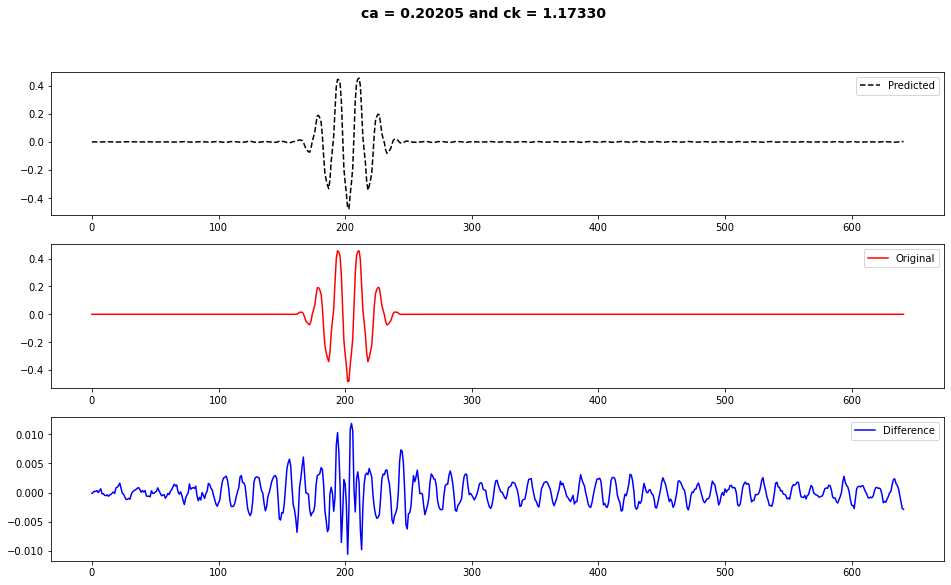

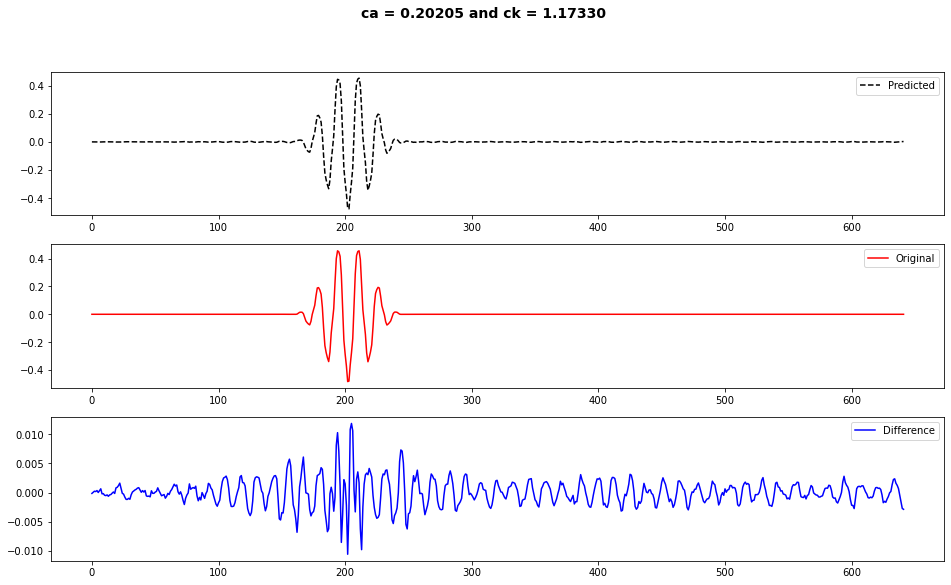

In [33]:
plot3(X_test, Recons_test, p_test, 7, 200)
plot3(X_test, Recons_valid, p_test, 7, 200)

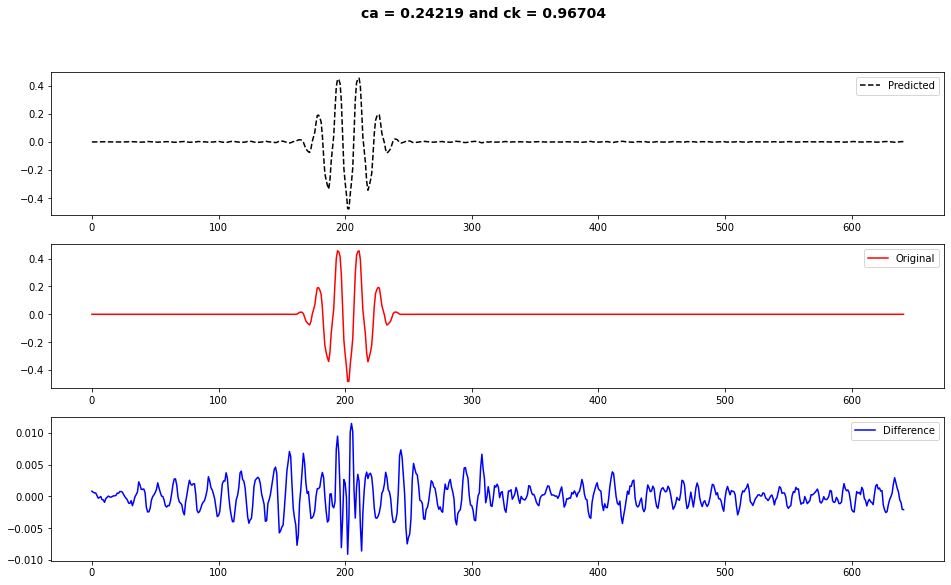

In [47]:
plot3(X_exp, Recons_exp, p_exp, 7, 200)

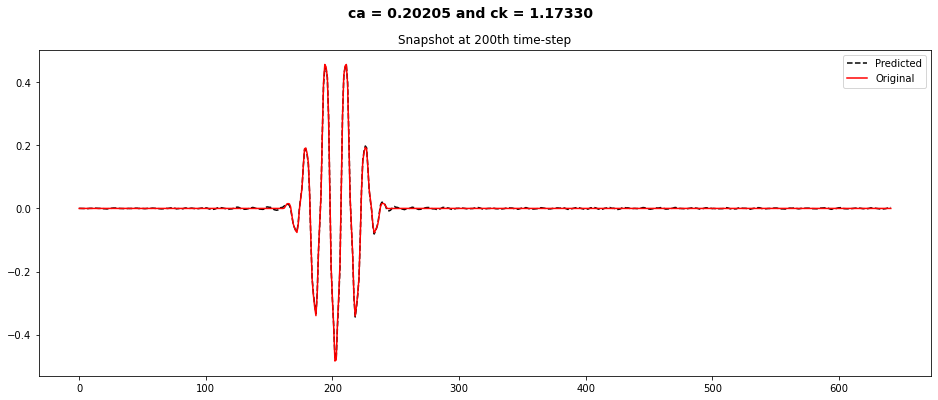

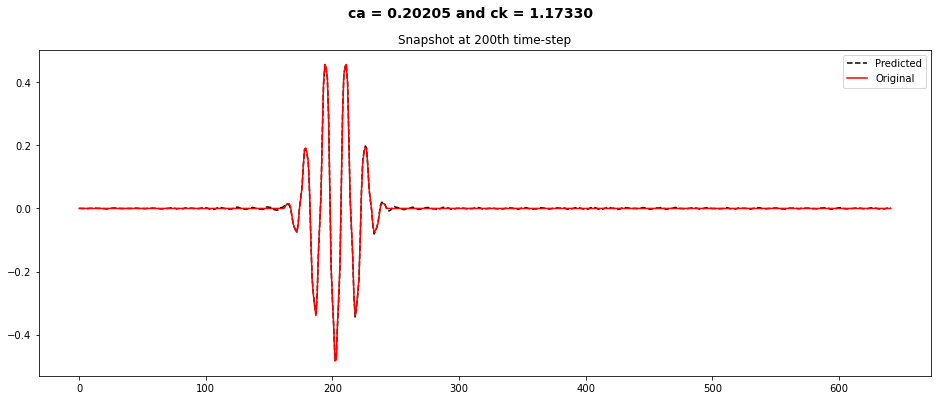

In [38]:
plot2(X_test, Recons_test, p_test, 7, 200)
plot2(X_test, Recons_valid, p_test, 7, 200)

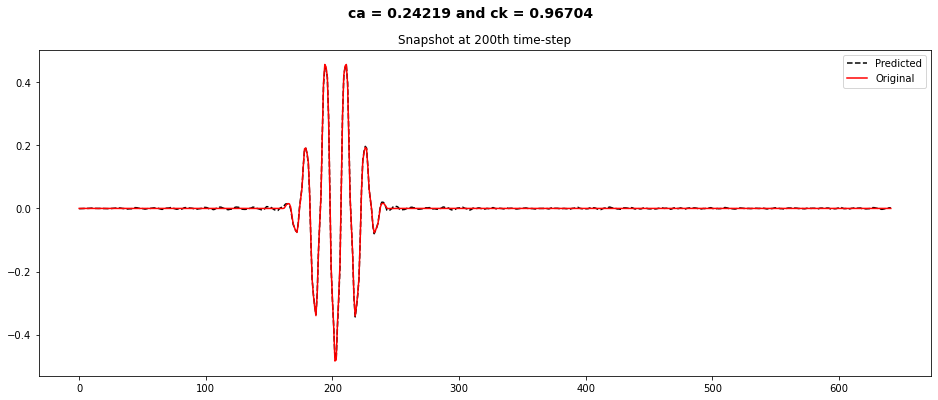

In [48]:
plot2(X_exp, Recons_exp, p_exp, 7, 200)

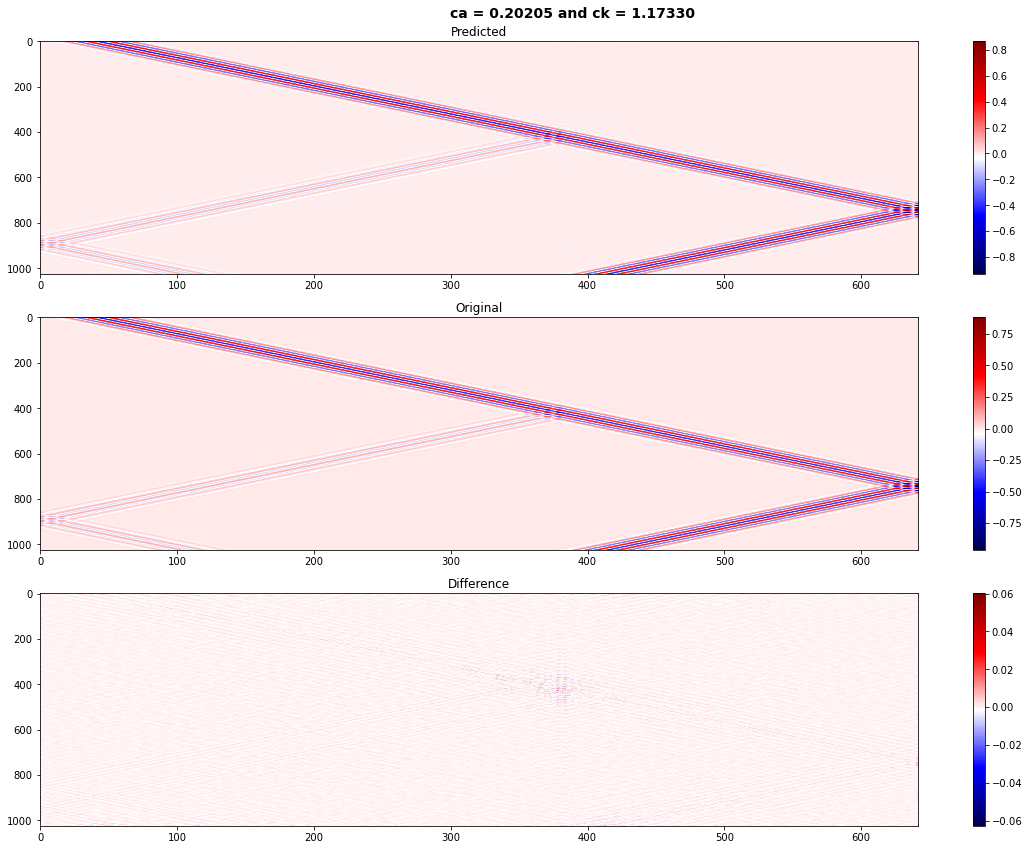

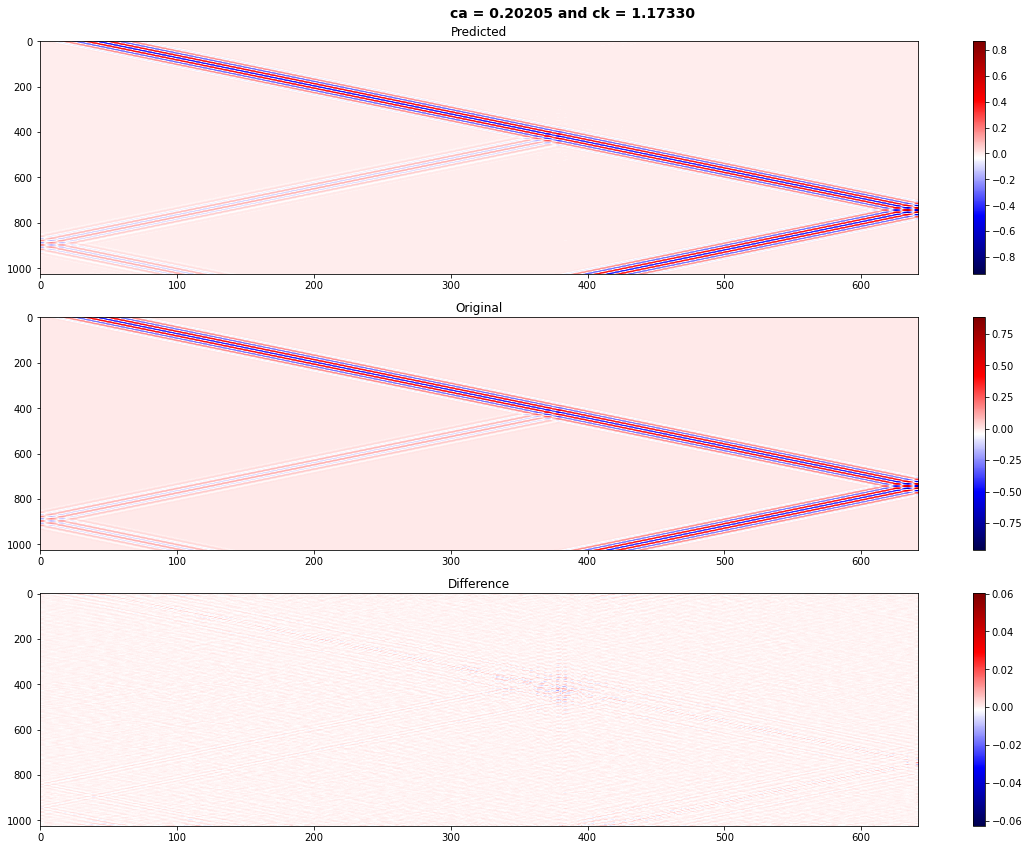

In [39]:
wave_pattern(p_test, X_test, Recons_test, 7)
wave_pattern(p_test, X_test, Recons_valid, 7)

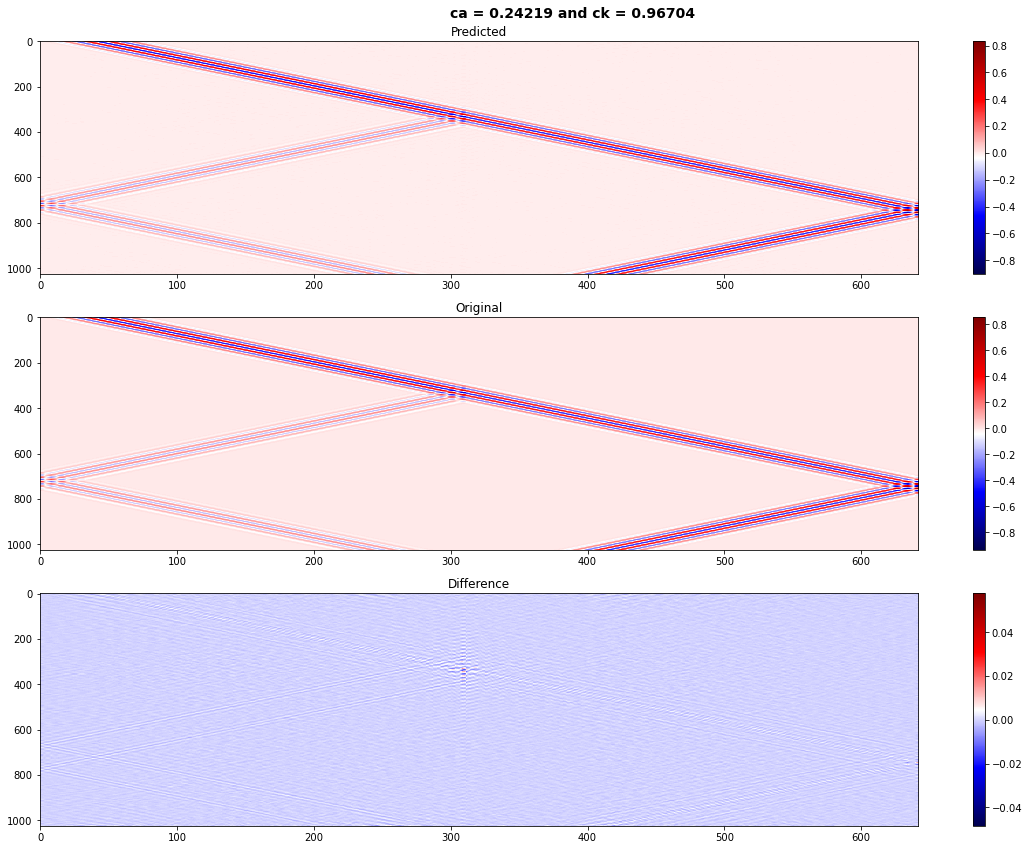

In [49]:
wave_pattern(p_exp, X_exp, Recons_exp, 7)

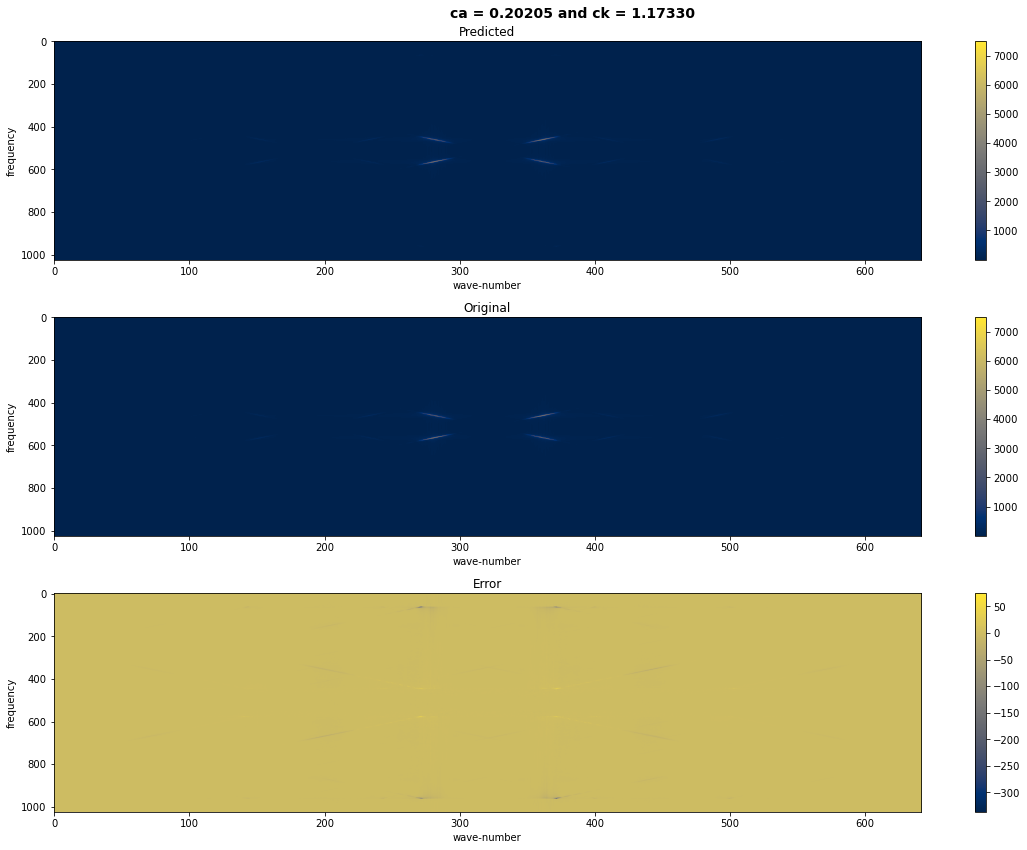

In [40]:
plot_fft(p_test, X_test, Recons_valid, 7)

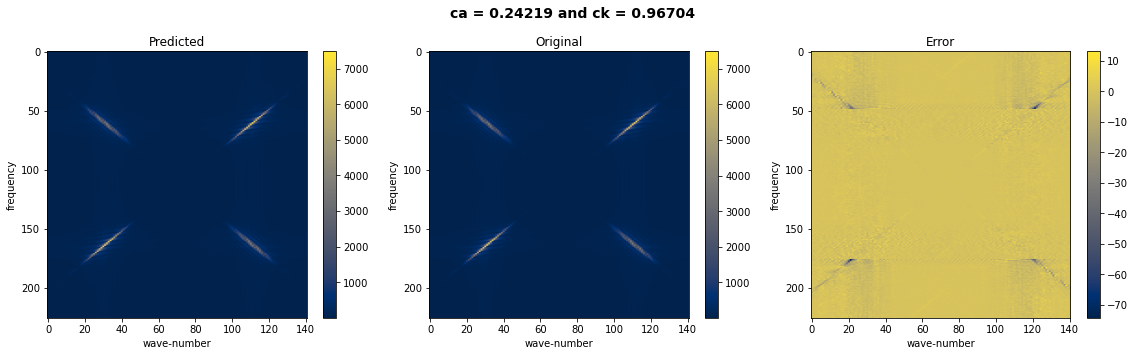

In [44]:
plot_fft_cropped(p_test, X_test, Recons_valid, 7)

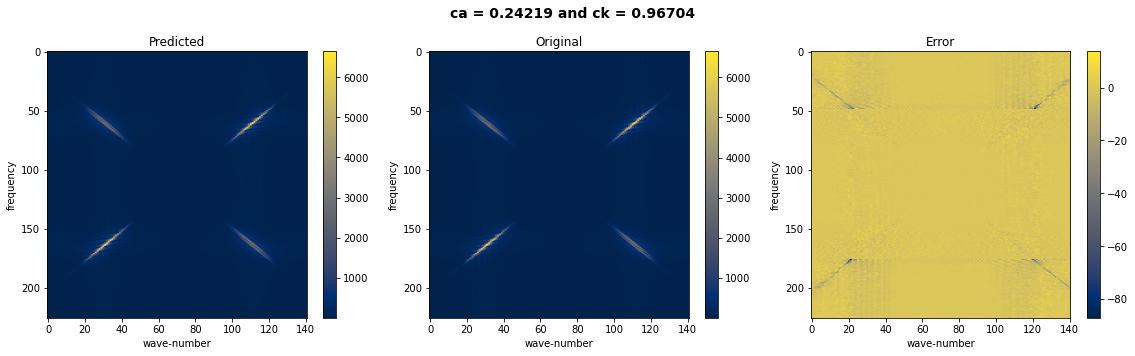

In [51]:
plot_fft_cropped(p_exp, X_exp, Recons_exp, 7)

# Train FFNN

## Data to train FFNN

In [52]:
NN_output_train = Encoder_Inference(encoder, X_train)
NN_output_test  = Encoder_Inference(encoder, X_test)
NN_output_exp   = Encoder_Inference(encoder, X_exp)

print(NN_output_train.shape)
print(NN_output_test.shape)
print(NN_output_exp.shape)

(2080, 64)
(260, 64)
(260, 64)


In [53]:
print(np.max(NN_output_train))
print(np.min(NN_output_train))

print(np.max(NN_output_test))
print(np.min(NN_output_test))

print(np.max(NN_output_exp))
print(np.min(NN_output_exp))

15.357836
-14.985485
11.221818
-12.45197
12.212313
-14.738473


In [54]:
print(NN_output_train.dtype)
print(NN_output_test.dtype)
print(NN_output_exp.dtype)

float32
float32
float32


In [55]:
# NN_train_data = Dataset(torch.from_numpy(p_train), torch.tensor(NN_output_train))
# NN_valid_data = Dataset(torch.from_numpy(p_test),  torch.from_numpy(NN_output_test))
class NN_train_Dataset(Dataset):
    def __init__(self, NN_out, parameters):
        super(NN_train_Dataset, self).__init__()
        self.n_samples = parameters.shape[0]
        self.x_data    = torch.from_numpy(np.array(parameters, np.float32))
        self.y_data    = torch.from_numpy(np.array(NN_out, np.float32))

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class NN_valid_Dataset(Dataset):
    def __init__(self, NN_out, parameters):
        super(NN_valid_Dataset, self).__init__()
        self.n_samples = parameters.shape[0]
        self.x_data    = torch.from_numpy(np.array(parameters, np.float32))
        self.y_data    = torch.from_numpy(np.array(NN_out, np.float32))

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class NN_exp_Dataset(Dataset):
    def __init__(self, NN_out, parameters):
        super(NN_exp_Dataset, self).__init__()
        self.n_samples = parameters.shape[0]
        self.x_data    = torch.from_numpy(np.array(parameters, np.float32))
        self.y_data    = torch.from_numpy(np.array(NN_out, np.float32))

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [56]:
NN_output_train_dataset = NN_train_Dataset(NN_output_train, p_train)
NN_output_valid_dataset = NN_valid_Dataset(NN_output_test,  p_test)
NN_output_exp_dataset   = NN_exp_Dataset(NN_output_exp,     p_exp)

# NN_output_train_dataset = NN_output_train_dataset.type(torch.FloatTensor)
# NN_output_valid_dataset = NN_output_valid_dataset.type(torch.FloatTensor)
# NN_output_exp_dataset   = NN_output_exp_dataset.type(torch.FloatTensor)

NN_train_loader = DataLoader(dataset = NN_output_train_dataset, batch_size = batch_size, shuffle = False)
NN_valid_loader = DataLoader(dataset = NN_output_valid_dataset, batch_size = batch_size, shuffle = False)
NN_exp_loader   = DataLoader(dataset = NN_output_exp_dataset,   batch_size = batch_size, shuffle = False)

In [57]:
for i,j in NN_output_valid_dataset:
    print(j)
    break

tensor([ 2.2492, -2.4868,  2.8154, -1.7206, -1.7256,  1.1846,  1.9464, -2.4997,
         0.9842, -0.6367,  3.6026, -1.9104,  4.8120, -0.2364,  3.0149, -3.5707,
        -2.8818, -2.7487,  0.0792,  0.7144, -0.2900, -0.7605,  3.5988, -1.6219,
        -0.5261, -0.2372,  2.0216,  2.1726,  2.9620, -4.6463, -1.2986,  1.6738,
        -1.8679,  4.5092,  1.1530, -0.7627,  1.1300, -1.8524, -0.0363,  0.1213,
        -1.7420, -2.8645,  0.2379, -4.4139, -4.0749,  3.0174, -2.4121,  1.6018,
         1.9094,  1.7975, -0.8815,  1.0568,  3.3580,  1.9104,  3.0092, -1.8951,
         0.3524,  2.9693,  0.2739,  0.2014,  1.3300, -0.4691, -1.3553, -1.9463])


In [58]:
for i, j in NN_train_loader:
    print(i[0])
    print(i.shape)
    print(j.shape)
    break

tensor([0.2240, 1.0260])
torch.Size([32, 2])
torch.Size([32, 64])


In [67]:
class FFNN(nn.Module):
    def __init__(self,):
        super(FFNN, self).__init__()
        self.hidden1 = nn.Linear(2, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 256)
        self.hidden4 = nn.Linear(256, 256)
        self.hidden5 = nn.Linear(256, 64)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = F.relu(X)
        X = self.hidden2(X)
        X = F.relu(X)
        X = self.hidden3(X)
        X = F.relu(X)
        X = self.hidden4(X)
        X = F.relu(X)
        X = self.hidden5(X)
        # X = F.relu(X)
        return X

In [61]:
def save_ckp_NN(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path_NN
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)


def load_ckp_NN(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['NN_state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()


model_folder       = paths['model_path'] + 'PyTorch_FNO_AE_01/'
checkpoint_path_NN = model_folder + "Checkpoint_NN/"
best_model_path_NN = model_folder + "Best_model_NN/"

if not os.path.exists(model_folder):
    os.makedirs(model_folder)

if not os.path.exists(checkpoint_path_NN):
    os.makedirs(checkpoint_path_NN)

if not os.path.exists(best_model_path_NN):
    os.makedirs(best_model_path_NN)

In [68]:
## Move FFNN network to the selected device
NN = FFNN()
NN = NN.to(device)

### Define the loss function
criterion = nn.MSELoss()
pearsonr  = R2_loss()
# train_acc = 0.0
# valid_acc = 0.0

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=500, verbose=True)

In [70]:
# https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee

def train_NN(NN, n_epochs, patience):
    history      = {'train_loss':[],'val_loss':[], 'train_R2':[],'val_R2':[]}
    train_losses = []
    valid_losses = []
    train_R2     = []
    valid_R2     = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping_NN(patience = patience, verbose = True, 
                                      path = model_folder + "Checkpoint_NN/" + "Earlystop_NN_checkpoint.pt")
    
    for epoch in range(n_epochs):
        ###################
        # train the model #
        ###################
        NN.train()
        for batch, (samples, labels) in enumerate(NN_train_loader, 1):
        # for (samples, labels) in NN_train_loader:
            samples, labels = samples.to(device), labels.to(device)
            optimizer.zero_grad()

            pred = NN(samples)

            loss = criterion(pred, labels)
            R2   = pearsonr(pred.detach(), labels.detach())
            
            loss.backward()
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            train_R2.append(R2.cpu().numpy())
        
        ######################    
        # validate the model #
        ######################
        NN.eval()
        # for batch, (samples, labels) in enumerate(NN_valid_loader, 1):
        for (samples, labels) in NN_valid_loader:
            samples, labels = samples.to(device), labels.to(device)
            pred = NN(samples)
            
            loss = criterion(pred, labels)
            R2   = pearsonr(pred.detach(), labels.detach())
            # record validation loss
            valid_losses.append(loss.item())
            valid_R2.append(R2.cpu().numpy())

        # print training/testation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(valid_loss)
        
        train_pearson = np.average(train_R2)
        valid_pearson = np.average(valid_R2)
        history['train_R2'].append(train_pearson)
        history['val_loss'].append(valid_pearson)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch+1:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' + f'train_loss: {"%.5e"%train_loss} '
                         + f'valid_loss: {"%.5e"%valid_loss} ' + f'train_R2: {"%.5f"%train_pearson} '
                         + f'valid_R2: {"%.5f"%valid_pearson}')
        print(print_msg)
        
        #### Learning rate scheduler
        mean_loss = sum(valid_losses)/len(valid_losses)
        scheduler.step(mean_loss)
        
        #### early_stopping needs the testation loss to check if it has decreased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, NN)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        train_R2 = []
        valid_R2 = []

    # load the last checkpoint with the best model
    NN.load_state_dict(torch.load(model_folder + "Checkpoint_NN/" + "Earlystop_NN_checkpoint.pt"))
    
    return  history

In [71]:
start_time = time.time()

hist_NN = train_NN(NN, 50000, 500)

training_time = time.time() - start_time
print('Training time: ', training_time, ' sec')

[    1/50000] train_loss: 6.77641e+00 valid_loss: 4.83648e+00 train_R2: 0.16699 valid_R2: 0.15766
Validation loss decreased (inf --> 4.836481173833211).  Saving model ...
[    2/50000] train_loss: 4.24252e+00 valid_loss: 3.97496e+00 train_R2: 0.15595 valid_R2: 0.16789
Validation loss decreased (4.836481173833211 --> 3.97495698928833).  Saving model ...
[    3/50000] train_loss: 4.06259e+00 valid_loss: 3.92008e+00 train_R2: 0.17475 valid_R2: 0.20073
Validation loss decreased (3.97495698928833 --> 3.920077085494995).  Saving model ...
[    4/50000] train_loss: 3.96189e+00 valid_loss: 3.72685e+00 train_R2: 0.24850 valid_R2: 0.32928
Validation loss decreased (3.920077085494995 --> 3.726847516165839).  Saving model ...
[    5/50000] train_loss: 3.65229e+00 valid_loss: 3.43430e+00 train_R2: 0.37826 valid_R2: 0.39901
Validation loss decreased (3.726847516165839 --> 3.4342997074127197).  Saving model ...
[    6/50000] train_loss: 3.48613e+00 valid_loss: 3.40342e+00 train_R2: 0.40520 valid_R2: 

[   46/50000] train_loss: 3.01195e+00 valid_loss: 2.91898e+00 train_R2: 0.52617 valid_R2: 0.52628
Validation loss decreased (2.920719941457113 --> 2.9189758168326483).  Saving model ...
[   47/50000] train_loss: 3.01001e+00 valid_loss: 2.91754e+00 train_R2: 0.52660 valid_R2: 0.52659
Validation loss decreased (2.9189758168326483 --> 2.917535662651062).  Saving model ...
[   48/50000] train_loss: 3.00820e+00 valid_loss: 2.91605e+00 train_R2: 0.52701 valid_R2: 0.52689
Validation loss decreased (2.917535662651062 --> 2.9160509374406605).  Saving model ...
[   49/50000] train_loss: 3.00639e+00 valid_loss: 2.91468e+00 train_R2: 0.52742 valid_R2: 0.52715
Validation loss decreased (2.9160509374406605 --> 2.9146849314371743).  Saving model ...
[   50/50000] train_loss: 3.00461e+00 valid_loss: 2.91351e+00 train_R2: 0.52782 valid_R2: 0.52739
Validation loss decreased (2.9146849314371743 --> 2.9135051568349204).  Saving model ...
[   51/50000] train_loss: 3.00297e+00 valid_loss: 2.91244e+00 train_

[   91/50000] train_loss: 2.95569e+00 valid_loss: 2.87927e+00 train_R2: 0.53889 valid_R2: 0.53499
Validation loss decreased (2.8799953328238592 --> 2.8792730040020413).  Saving model ...
[   92/50000] train_loss: 2.95490e+00 valid_loss: 2.87861e+00 train_R2: 0.53908 valid_R2: 0.53515
Validation loss decreased (2.8792730040020413 --> 2.878609127468533).  Saving model ...
[   93/50000] train_loss: 2.95401e+00 valid_loss: 2.87811e+00 train_R2: 0.53927 valid_R2: 0.53525
Validation loss decreased (2.878609127468533 --> 2.878112885687086).  Saving model ...
[   94/50000] train_loss: 2.95322e+00 valid_loss: 2.87748e+00 train_R2: 0.53945 valid_R2: 0.53541
Validation loss decreased (2.878112885687086 --> 2.8774835666020713).  Saving model ...
[   95/50000] train_loss: 2.95240e+00 valid_loss: 2.87692e+00 train_R2: 0.53962 valid_R2: 0.53552
Validation loss decreased (2.8774835666020713 --> 2.8769166469573975).  Saving model ...
[   96/50000] train_loss: 2.95163e+00 valid_loss: 2.87637e+00 train_R

[  136/50000] train_loss: 2.91985e+00 valid_loss: 2.83996e+00 train_R2: 0.54682 valid_R2: 0.54359
Validation loss decreased (2.841475566228231 --> 2.8399580319722495).  Saving model ...
[  137/50000] train_loss: 2.91928e+00 valid_loss: 2.83846e+00 train_R2: 0.54697 valid_R2: 0.54385
Validation loss decreased (2.8399580319722495 --> 2.8384606308407254).  Saving model ...
[  138/50000] train_loss: 2.91806e+00 valid_loss: 2.83771e+00 train_R2: 0.54720 valid_R2: 0.54404
Validation loss decreased (2.8384606308407254 --> 2.8377092944251165).  Saving model ...
[  139/50000] train_loss: 2.91731e+00 valid_loss: 2.83615e+00 train_R2: 0.54736 valid_R2: 0.54441
Validation loss decreased (2.8377092944251165 --> 2.83614714940389).  Saving model ...
[  140/50000] train_loss: 2.91643e+00 valid_loss: 2.83505e+00 train_R2: 0.54756 valid_R2: 0.54459
Validation loss decreased (2.83614714940389 --> 2.835050582885742).  Saving model ...
[  141/50000] train_loss: 2.91554e+00 valid_loss: 2.83393e+00 train_R2:

[  181/50000] train_loss: 2.88412e+00 valid_loss: 2.78171e+00 train_R2: 0.55456 valid_R2: 0.55573
Validation loss decreased (2.782582309510973 --> 2.781713088353475).  Saving model ...
[  182/50000] train_loss: 2.88303e+00 valid_loss: 2.78083e+00 train_R2: 0.55475 valid_R2: 0.55589
Validation loss decreased (2.781713088353475 --> 2.7808315886391535).  Saving model ...
[  183/50000] train_loss: 2.88259e+00 valid_loss: 2.77871e+00 train_R2: 0.55488 valid_R2: 0.55637
Validation loss decreased (2.7808315886391535 --> 2.778712749481201).  Saving model ...
[  184/50000] train_loss: 2.88126e+00 valid_loss: 2.77864e+00 train_R2: 0.55513 valid_R2: 0.55637
Validation loss decreased (2.778712749481201 --> 2.7786352899339466).  Saving model ...
[  185/50000] train_loss: 2.88138e+00 valid_loss: 2.77718e+00 train_R2: 0.55515 valid_R2: 0.55663
Validation loss decreased (2.7786352899339466 --> 2.7771821684307523).  Saving model ...
[  186/50000] train_loss: 2.88002e+00 valid_loss: 2.77618e+00 train_R2

[  227/50000] train_loss: 2.85139e+00 valid_loss: 2.73382e+00 train_R2: 0.56156 valid_R2: 0.56591
EarlyStopping counter: 1 out of 500
[  228/50000] train_loss: 2.85128e+00 valid_loss: 2.73416e+00 train_R2: 0.56160 valid_R2: 0.56575
EarlyStopping counter: 2 out of 500
[  229/50000] train_loss: 2.85010e+00 valid_loss: 2.73097e+00 train_R2: 0.56186 valid_R2: 0.56653
Validation loss decreased (2.7336740361319647 --> 2.7309726344214544).  Saving model ...
[  230/50000] train_loss: 2.84943e+00 valid_loss: 2.73153e+00 train_R2: 0.56201 valid_R2: 0.56639
EarlyStopping counter: 1 out of 500
[  231/50000] train_loss: 2.84917e+00 valid_loss: 2.73109e+00 train_R2: 0.56205 valid_R2: 0.56647
EarlyStopping counter: 2 out of 500
[  232/50000] train_loss: 2.84841e+00 valid_loss: 2.72957e+00 train_R2: 0.56226 valid_R2: 0.56681
Validation loss decreased (2.7309726344214544 --> 2.7295696602927313).  Saving model ...
[  233/50000] train_loss: 2.84768e+00 valid_loss: 2.72841e+00 train_R2: 0.56232 valid_R2: 

[  276/50000] train_loss: 2.81928e+00 valid_loss: 2.69312e+00 train_R2: 0.56854 valid_R2: 0.57448
Validation loss decreased (2.6942813131544323 --> 2.6931218836042614).  Saving model ...
[  277/50000] train_loss: 2.81891e+00 valid_loss: 2.69201e+00 train_R2: 0.56862 valid_R2: 0.57479
Validation loss decreased (2.6931218836042614 --> 2.6920122040642633).  Saving model ...
[  278/50000] train_loss: 2.81842e+00 valid_loss: 2.69152e+00 train_R2: 0.56864 valid_R2: 0.57493
Validation loss decreased (2.6920122040642633 --> 2.6915211810006037).  Saving model ...
[  279/50000] train_loss: 2.81844e+00 valid_loss: 2.69307e+00 train_R2: 0.56868 valid_R2: 0.57456
EarlyStopping counter: 1 out of 500
[  280/50000] train_loss: 2.81702e+00 valid_loss: 2.69034e+00 train_R2: 0.56898 valid_R2: 0.57506
Validation loss decreased (2.6915211810006037 --> 2.690340664651659).  Saving model ...
[  281/50000] train_loss: 2.81635e+00 valid_loss: 2.69040e+00 train_R2: 0.56910 valid_R2: 0.57509
EarlyStopping counter

[  322/50000] train_loss: 2.78306e+00 valid_loss: 2.64613e+00 train_R2: 0.57620 valid_R2: 0.58412
Validation loss decreased (2.6485292514165244 --> 2.6461312108569675).  Saving model ...
[  323/50000] train_loss: 2.78159e+00 valid_loss: 2.64589e+00 train_R2: 0.57659 valid_R2: 0.58412
Validation loss decreased (2.6461312108569675 --> 2.6458905935287476).  Saving model ...
[  324/50000] train_loss: 2.78157e+00 valid_loss: 2.64492e+00 train_R2: 0.57661 valid_R2: 0.58431
Validation loss decreased (2.6458905935287476 --> 2.644922561115689).  Saving model ...
[  325/50000] train_loss: 2.78024e+00 valid_loss: 2.64309e+00 train_R2: 0.57676 valid_R2: 0.58478
Validation loss decreased (2.644922561115689 --> 2.643086618847317).  Saving model ...
[  326/50000] train_loss: 2.77933e+00 valid_loss: 2.64233e+00 train_R2: 0.57698 valid_R2: 0.58487
Validation loss decreased (2.643086618847317 --> 2.6423320240444608).  Saving model ...
[  327/50000] train_loss: 2.77840e+00 valid_loss: 2.64197e+00 train_R

[  370/50000] train_loss: 2.73769e+00 valid_loss: 2.59679e+00 train_R2: 0.58579 valid_R2: 0.59378
Validation loss decreased (2.598652203877767 --> 2.596785399648878).  Saving model ...
[  371/50000] train_loss: 2.73625e+00 valid_loss: 2.59614e+00 train_R2: 0.58608 valid_R2: 0.59392
Validation loss decreased (2.596785399648878 --> 2.5961391263537936).  Saving model ...
[  372/50000] train_loss: 2.73547e+00 valid_loss: 2.59348e+00 train_R2: 0.58622 valid_R2: 0.59462
Validation loss decreased (2.5961391263537936 --> 2.5934809578789606).  Saving model ...
[  373/50000] train_loss: 2.73440e+00 valid_loss: 2.59362e+00 train_R2: 0.58646 valid_R2: 0.59457
EarlyStopping counter: 1 out of 500
[  374/50000] train_loss: 2.73614e+00 valid_loss: 2.59485e+00 train_R2: 0.58616 valid_R2: 0.59450
EarlyStopping counter: 2 out of 500
[  375/50000] train_loss: 2.73415e+00 valid_loss: 2.59261e+00 train_R2: 0.58658 valid_R2: 0.59486
Validation loss decreased (2.5934809578789606 --> 2.5926122532950506).  Savi

[  420/50000] train_loss: 2.68529e+00 valid_loss: 2.54386e+00 train_R2: 0.59673 valid_R2: 0.60479
Validation loss decreased (2.5475770632425943 --> 2.543858183754815).  Saving model ...
[  421/50000] train_loss: 2.68516e+00 valid_loss: 2.54684e+00 train_R2: 0.59670 valid_R2: 0.60448
EarlyStopping counter: 1 out of 500
[  422/50000] train_loss: 2.68310e+00 valid_loss: 2.54125e+00 train_R2: 0.59715 valid_R2: 0.60541
Validation loss decreased (2.543858183754815 --> 2.5412474473317466).  Saving model ...
[  423/50000] train_loss: 2.68129e+00 valid_loss: 2.54072e+00 train_R2: 0.59749 valid_R2: 0.60555
Validation loss decreased (2.5412474473317466 --> 2.5407152573267617).  Saving model ...
[  424/50000] train_loss: 2.68092e+00 valid_loss: 2.54315e+00 train_R2: 0.59743 valid_R2: 0.60494
EarlyStopping counter: 1 out of 500
[  425/50000] train_loss: 2.67888e+00 valid_loss: 2.53877e+00 train_R2: 0.59794 valid_R2: 0.60606
Validation loss decreased (2.5407152573267617 --> 2.5387675629721747).  Sav

[  469/50000] train_loss: 2.63209e+00 valid_loss: 2.49600e+00 train_R2: 0.60744 valid_R2: 0.61459
EarlyStopping counter: 1 out of 500
[  470/50000] train_loss: 2.62883e+00 valid_loss: 2.49190e+00 train_R2: 0.60795 valid_R2: 0.61539
Validation loss decreased (2.494828184445699 --> 2.491902086469862).  Saving model ...
[  471/50000] train_loss: 2.62914e+00 valid_loss: 2.49157e+00 train_R2: 0.60802 valid_R2: 0.61544
Validation loss decreased (2.491902086469862 --> 2.4915656248728433).  Saving model ...
[  472/50000] train_loss: 2.62814e+00 valid_loss: 2.49163e+00 train_R2: 0.60821 valid_R2: 0.61535
EarlyStopping counter: 1 out of 500
[  473/50000] train_loss: 2.62617e+00 valid_loss: 2.49068e+00 train_R2: 0.60863 valid_R2: 0.61551
Validation loss decreased (2.4915656248728433 --> 2.4906788402133517).  Saving model ...
[  474/50000] train_loss: 2.62582e+00 valid_loss: 2.49144e+00 train_R2: 0.60869 valid_R2: 0.61531
EarlyStopping counter: 1 out of 500
[  475/50000] train_loss: 2.62389e+00 va

[  517/50000] train_loss: 2.58035e+00 valid_loss: 2.44983e+00 train_R2: 0.61754 valid_R2: 0.62389
EarlyStopping counter: 1 out of 500
[  518/50000] train_loss: 2.57784e+00 valid_loss: 2.44999e+00 train_R2: 0.61801 valid_R2: 0.62389
EarlyStopping counter: 2 out of 500
[  519/50000] train_loss: 2.57687e+00 valid_loss: 2.44747e+00 train_R2: 0.61817 valid_R2: 0.62404
Validation loss decreased (2.449572788344489 --> 2.447469260957506).  Saving model ...
[  520/50000] train_loss: 2.57770e+00 valid_loss: 2.44954e+00 train_R2: 0.61809 valid_R2: 0.62388
EarlyStopping counter: 1 out of 500
[  521/50000] train_loss: 2.57429e+00 valid_loss: 2.44620e+00 train_R2: 0.61865 valid_R2: 0.62441
Validation loss decreased (2.447469260957506 --> 2.446196092499627).  Saving model ...
[  522/50000] train_loss: 2.57340e+00 valid_loss: 2.44541e+00 train_R2: 0.61879 valid_R2: 0.62486
Validation loss decreased (2.446196092499627 --> 2.445413284831577).  Saving model ...
[  523/50000] train_loss: 2.57353e+00 valid

[  565/50000] train_loss: 2.52915e+00 valid_loss: 2.40720e+00 train_R2: 0.62728 valid_R2: 0.63250
EarlyStopping counter: 1 out of 500
[  566/50000] train_loss: 2.53104e+00 valid_loss: 2.40690e+00 train_R2: 0.62699 valid_R2: 0.63256
Validation loss decreased (2.4070212841033936 --> 2.406898127661811).  Saving model ...
[  567/50000] train_loss: 2.52727e+00 valid_loss: 2.40594e+00 train_R2: 0.62761 valid_R2: 0.63261
Validation loss decreased (2.406898127661811 --> 2.4059364398320517).  Saving model ...
[  568/50000] train_loss: 2.52602e+00 valid_loss: 2.40405e+00 train_R2: 0.62785 valid_R2: 0.63301
Validation loss decreased (2.4059364398320517 --> 2.4040490521325006).  Saving model ...
[  569/50000] train_loss: 2.52472e+00 valid_loss: 2.40146e+00 train_R2: 0.62810 valid_R2: 0.63347
Validation loss decreased (2.4040490521325006 --> 2.4014585283067493).  Saving model ...
[  570/50000] train_loss: 2.52361e+00 valid_loss: 2.40333e+00 train_R2: 0.62829 valid_R2: 0.63326
EarlyStopping counter:

[  611/50000] train_loss: 2.47895e+00 valid_loss: 2.36676e+00 train_R2: 0.63668 valid_R2: 0.64043
EarlyStopping counter: 1 out of 500
[  612/50000] train_loss: 2.47857e+00 valid_loss: 2.36551e+00 train_R2: 0.63679 valid_R2: 0.64076
Validation loss decreased (2.3662245406044855 --> 2.3655074967278376).  Saving model ...
[  613/50000] train_loss: 2.47770e+00 valid_loss: 2.36606e+00 train_R2: 0.63695 valid_R2: 0.64068
EarlyStopping counter: 1 out of 500
[  614/50000] train_loss: 2.47567e+00 valid_loss: 2.36399e+00 train_R2: 0.63730 valid_R2: 0.64082
Validation loss decreased (2.3655074967278376 --> 2.363989962471856).  Saving model ...
[  615/50000] train_loss: 2.47515e+00 valid_loss: 2.36545e+00 train_R2: 0.63742 valid_R2: 0.64099
EarlyStopping counter: 1 out of 500
[  616/50000] train_loss: 2.47484e+00 valid_loss: 2.36035e+00 train_R2: 0.63755 valid_R2: 0.64170
Validation loss decreased (2.363989962471856 --> 2.3603508604897394).  Saving model ...
[  617/50000] train_loss: 2.47199e+00 v

[  659/50000] train_loss: 2.41812e+00 valid_loss: 2.31763e+00 train_R2: 0.64817 valid_R2: 0.64913
EarlyStopping counter: 1 out of 500
[  660/50000] train_loss: 2.41680e+00 valid_loss: 2.31575e+00 train_R2: 0.64843 valid_R2: 0.64952
Validation loss decreased (2.317202674018012 --> 2.315745062298245).  Saving model ...
[  661/50000] train_loss: 2.41468e+00 valid_loss: 2.31487e+00 train_R2: 0.64879 valid_R2: 0.64977
Validation loss decreased (2.315745062298245 --> 2.3148691654205322).  Saving model ...
[  662/50000] train_loss: 2.41405e+00 valid_loss: 2.31199e+00 train_R2: 0.64894 valid_R2: 0.65015
Validation loss decreased (2.3148691654205322 --> 2.311988261010912).  Saving model ...
[  663/50000] train_loss: 2.41270e+00 valid_loss: 2.31165e+00 train_R2: 0.64918 valid_R2: 0.65006
Validation loss decreased (2.311988261010912 --> 2.3116508192486234).  Saving model ...
[  664/50000] train_loss: 2.41050e+00 valid_loss: 2.31056e+00 train_R2: 0.64960 valid_R2: 0.65022
Validation loss decreased

[  705/50000] train_loss: 2.34730e+00 valid_loss: 2.25009e+00 train_R2: 0.66149 valid_R2: 0.66112
Validation loss decreased (2.254196696811252 --> 2.250091698434618).  Saving model ...
[  706/50000] train_loss: 2.34462e+00 valid_loss: 2.24792e+00 train_R2: 0.66196 valid_R2: 0.66156
Validation loss decreased (2.250091698434618 --> 2.247922076119317).  Saving model ...
[  707/50000] train_loss: 2.34351e+00 valid_loss: 2.24810e+00 train_R2: 0.66219 valid_R2: 0.66153
EarlyStopping counter: 1 out of 500
[  708/50000] train_loss: 2.34209e+00 valid_loss: 2.24722e+00 train_R2: 0.66248 valid_R2: 0.66180
Validation loss decreased (2.247922076119317 --> 2.247223218282064).  Saving model ...
[  709/50000] train_loss: 2.34070e+00 valid_loss: 2.24419e+00 train_R2: 0.66275 valid_R2: 0.66222
Validation loss decreased (2.247223218282064 --> 2.244185699356927).  Saving model ...
[  710/50000] train_loss: 2.33802e+00 valid_loss: 2.24131e+00 train_R2: 0.66319 valid_R2: 0.66276
Validation loss decreased (2

[  752/50000] train_loss: 2.26131e+00 valid_loss: 2.17247e+00 train_R2: 0.67721 valid_R2: 0.67500
EarlyStopping counter: 1 out of 500
[  753/50000] train_loss: 2.26024e+00 valid_loss: 2.17063e+00 train_R2: 0.67750 valid_R2: 0.67514
Validation loss decreased (2.1719808048672147 --> 2.170634468396505).  Saving model ...
[  754/50000] train_loss: 2.25857e+00 valid_loss: 2.16904e+00 train_R2: 0.67785 valid_R2: 0.67564
Validation loss decreased (2.170634468396505 --> 2.1690424150890775).  Saving model ...
[  755/50000] train_loss: 2.25601e+00 valid_loss: 2.16819e+00 train_R2: 0.67821 valid_R2: 0.67554
Validation loss decreased (2.1690424150890775 --> 2.168185578452216).  Saving model ...
[  756/50000] train_loss: 2.25601e+00 valid_loss: 2.16807e+00 train_R2: 0.67835 valid_R2: 0.67553
Validation loss decreased (2.168185578452216 --> 2.168074859513177).  Saving model ...
[  757/50000] train_loss: 2.25237e+00 valid_loss: 2.16421e+00 train_R2: 0.67891 valid_R2: 0.67614
Validation loss decreased

[  798/50000] train_loss: 2.16978e+00 valid_loss: 2.08461e+00 train_R2: 0.69364 valid_R2: 0.69059
Validation loss decreased (2.0875317255655923 --> 2.0846114820904202).  Saving model ...
[  799/50000] train_loss: 2.16904e+00 valid_loss: 2.08311e+00 train_R2: 0.69385 valid_R2: 0.69059
Validation loss decreased (2.0846114820904202 --> 2.0831112596723766).  Saving model ...
[  800/50000] train_loss: 2.16665e+00 valid_loss: 2.07909e+00 train_R2: 0.69423 valid_R2: 0.69137
Validation loss decreased (2.0831112596723766 --> 2.07909013165368).  Saving model ...
[  801/50000] train_loss: 2.16351e+00 valid_loss: 2.08116e+00 train_R2: 0.69478 valid_R2: 0.69106
EarlyStopping counter: 1 out of 500
[  802/50000] train_loss: 2.16327e+00 valid_loss: 2.07681e+00 train_R2: 0.69493 valid_R2: 0.69202
Validation loss decreased (2.07909013165368 --> 2.0768058167563543).  Saving model ...
[  803/50000] train_loss: 2.16039e+00 valid_loss: 2.07463e+00 train_R2: 0.69531 valid_R2: 0.69217
Validation loss decrease

[  844/50000] train_loss: 2.07992e+00 valid_loss: 1.98824e+00 train_R2: 0.70960 valid_R2: 0.70795
Validation loss decreased (1.9906659656100802 --> 1.9882408248053656).  Saving model ...
[  845/50000] train_loss: 2.07695e+00 valid_loss: 1.98756e+00 train_R2: 0.71007 valid_R2: 0.70796
Validation loss decreased (1.9882408248053656 --> 1.9875642591052585).  Saving model ...
[  846/50000] train_loss: 2.07511e+00 valid_loss: 1.98569e+00 train_R2: 0.71046 valid_R2: 0.70844
Validation loss decreased (1.9875642591052585 --> 1.9856885539160833).  Saving model ...
[  847/50000] train_loss: 2.07483e+00 valid_loss: 1.98224e+00 train_R2: 0.71047 valid_R2: 0.70910
Validation loss decreased (1.9856885539160833 --> 1.9822371933195326).  Saving model ...
[  848/50000] train_loss: 2.07314e+00 valid_loss: 1.98133e+00 train_R2: 0.71079 valid_R2: 0.70934
Validation loss decreased (1.9822371933195326 --> 1.9813303550084431).  Saving model ...
[  849/50000] train_loss: 2.07109e+00 valid_loss: 1.97865e+00 tra

[  889/50000] train_loss: 1.99586e+00 valid_loss: 1.89990e+00 train_R2: 0.72415 valid_R2: 0.72377
Validation loss decreased (1.902248289850023 --> 1.8999010721842449).  Saving model ...
[  890/50000] train_loss: 1.99311e+00 valid_loss: 1.90096e+00 train_R2: 0.72461 valid_R2: 0.72354
EarlyStopping counter: 1 out of 500
[  891/50000] train_loss: 1.98985e+00 valid_loss: 1.89637e+00 train_R2: 0.72512 valid_R2: 0.72436
Validation loss decreased (1.8999010721842449 --> 1.896365033255683).  Saving model ...
[  892/50000] train_loss: 1.98915e+00 valid_loss: 1.89678e+00 train_R2: 0.72529 valid_R2: 0.72443
EarlyStopping counter: 1 out of 500
[  893/50000] train_loss: 1.98895e+00 valid_loss: 1.89270e+00 train_R2: 0.72531 valid_R2: 0.72499
Validation loss decreased (1.896365033255683 --> 1.8926979435814753).  Saving model ...
[  894/50000] train_loss: 1.98709e+00 valid_loss: 1.89217e+00 train_R2: 0.72571 valid_R2: 0.72530
Validation loss decreased (1.8926979435814753 --> 1.8921709855397542).  Savi

[  936/50000] train_loss: 1.91395e+00 valid_loss: 1.81358e+00 train_R2: 0.73805 valid_R2: 0.73910
Validation loss decreased (1.815959135691325 --> 1.8135788308249579).  Saving model ...
[  937/50000] train_loss: 1.91335e+00 valid_loss: 1.81241e+00 train_R2: 0.73810 valid_R2: 0.73924
Validation loss decreased (1.8135788308249579 --> 1.8124067385991414).  Saving model ...
[  938/50000] train_loss: 1.91170e+00 valid_loss: 1.80990e+00 train_R2: 0.73841 valid_R2: 0.73984
Validation loss decreased (1.8124067385991414 --> 1.809898363219367).  Saving model ...
[  939/50000] train_loss: 1.90903e+00 valid_loss: 1.80887e+00 train_R2: 0.73887 valid_R2: 0.74006
Validation loss decreased (1.809898363219367 --> 1.8088745673497517).  Saving model ...
[  940/50000] train_loss: 1.90793e+00 valid_loss: 1.80664e+00 train_R2: 0.73904 valid_R2: 0.74010
Validation loss decreased (1.8088745673497517 --> 1.8066427442762587).  Saving model ...
[  941/50000] train_loss: 1.90855e+00 valid_loss: 1.80837e+00 train_

[  983/50000] train_loss: 1.84348e+00 valid_loss: 1.74001e+00 train_R2: 0.74957 valid_R2: 0.75214
EarlyStopping counter: 1 out of 500
[  984/50000] train_loss: 1.84182e+00 valid_loss: 1.73664e+00 train_R2: 0.74992 valid_R2: 0.75257
Validation loss decreased (1.738913165198432 --> 1.7366380890210469).  Saving model ...
[  985/50000] train_loss: 1.84155e+00 valid_loss: 1.73595e+00 train_R2: 0.74993 valid_R2: 0.75277
Validation loss decreased (1.7366380890210469 --> 1.735950509707133).  Saving model ...
[  986/50000] train_loss: 1.83861e+00 valid_loss: 1.73235e+00 train_R2: 0.75044 valid_R2: 0.75323
Validation loss decreased (1.735950509707133 --> 1.7323494089974298).  Saving model ...
[  987/50000] train_loss: 1.83809e+00 valid_loss: 1.73090e+00 train_R2: 0.75054 valid_R2: 0.75339
Validation loss decreased (1.7323494089974298 --> 1.730899194876353).  Saving model ...
[  988/50000] train_loss: 1.83549e+00 valid_loss: 1.72878e+00 train_R2: 0.75093 valid_R2: 0.75383
Validation loss decrease

[ 1034/50000] train_loss: 1.77763e+00 valid_loss: 1.66652e+00 train_R2: 0.76033 valid_R2: 0.76433
Validation loss decreased (1.6696671446164448 --> 1.666520078976949).  Saving model ...
[ 1035/50000] train_loss: 1.77039e+00 valid_loss: 1.66589e+00 train_R2: 0.76133 valid_R2: 0.76454
Validation loss decreased (1.666520078976949 --> 1.6658949454625447).  Saving model ...
[ 1036/50000] train_loss: 1.77333e+00 valid_loss: 1.67050e+00 train_R2: 0.76093 valid_R2: 0.76379
EarlyStopping counter: 1 out of 500
[ 1037/50000] train_loss: 1.77209e+00 valid_loss: 1.66262e+00 train_R2: 0.76115 valid_R2: 0.76474
Validation loss decreased (1.6658949454625447 --> 1.6626224650277033).  Saving model ...
[ 1038/50000] train_loss: 1.76820e+00 valid_loss: 1.66429e+00 train_R2: 0.76166 valid_R2: 0.76475
EarlyStopping counter: 1 out of 500
[ 1039/50000] train_loss: 1.76992e+00 valid_loss: 1.66241e+00 train_R2: 0.76140 valid_R2: 0.76537
Validation loss decreased (1.6626224650277033 --> 1.6624064180586073).  Sav

[ 1082/50000] train_loss: 1.71649e+00 valid_loss: 1.60507e+00 train_R2: 0.76992 valid_R2: 0.77411
EarlyStopping counter: 1 out of 500
[ 1083/50000] train_loss: 1.71787e+00 valid_loss: 1.60108e+00 train_R2: 0.76986 valid_R2: 0.77476
Validation loss decreased (1.6036182973119948 --> 1.6010776625739203).  Saving model ...
[ 1084/50000] train_loss: 1.71873e+00 valid_loss: 1.60049e+00 train_R2: 0.76981 valid_R2: 0.77487
Validation loss decreased (1.6010776625739203 --> 1.600492325094011).  Saving model ...
[ 1085/50000] train_loss: 1.71306e+00 valid_loss: 1.59693e+00 train_R2: 0.77061 valid_R2: 0.77532
Validation loss decreased (1.600492325094011 --> 1.5969292786386278).  Saving model ...
[ 1086/50000] train_loss: 1.71326e+00 valid_loss: 1.59779e+00 train_R2: 0.77050 valid_R2: 0.77569
EarlyStopping counter: 1 out of 500
[ 1087/50000] train_loss: 1.71184e+00 valid_loss: 1.59941e+00 train_R2: 0.77079 valid_R2: 0.77527
EarlyStopping counter: 2 out of 500
[ 1088/50000] train_loss: 1.71105e+00 v

[ 1131/50000] train_loss: 1.66401e+00 valid_loss: 1.54125e+00 train_R2: 0.77844 valid_R2: 0.78440
Validation loss decreased (1.5415594842698839 --> 1.5412486791610718).  Saving model ...
[ 1132/50000] train_loss: 1.66432e+00 valid_loss: 1.54014e+00 train_R2: 0.77842 valid_R2: 0.78449
Validation loss decreased (1.5412486791610718 --> 1.540140496359931).  Saving model ...
[ 1133/50000] train_loss: 1.66380e+00 valid_loss: 1.53734e+00 train_R2: 0.77851 valid_R2: 0.78505
Validation loss decreased (1.540140496359931 --> 1.5373393495877583).  Saving model ...
[ 1134/50000] train_loss: 1.66115e+00 valid_loss: 1.53612e+00 train_R2: 0.77886 valid_R2: 0.78525
Validation loss decreased (1.5373393495877583 --> 1.5361157523261175).  Saving model ...
[ 1135/50000] train_loss: 1.66029e+00 valid_loss: 1.53788e+00 train_R2: 0.77900 valid_R2: 0.78492
EarlyStopping counter: 1 out of 500
[ 1136/50000] train_loss: 1.65997e+00 valid_loss: 1.53633e+00 train_R2: 0.77910 valid_R2: 0.78518
EarlyStopping counter:

[ 1181/50000] train_loss: 1.61338e+00 valid_loss: 1.48577e+00 train_R2: 0.78641 valid_R2: 0.79344
Validation loss decreased (1.487136377228631 --> 1.4857731858889263).  Saving model ...
[ 1182/50000] train_loss: 1.61146e+00 valid_loss: 1.48703e+00 train_R2: 0.78663 valid_R2: 0.79312
EarlyStopping counter: 1 out of 500
[ 1183/50000] train_loss: 1.61123e+00 valid_loss: 1.48517e+00 train_R2: 0.78669 valid_R2: 0.79338
Validation loss decreased (1.4857731858889263 --> 1.4851734307077196).  Saving model ...
[ 1184/50000] train_loss: 1.61484e+00 valid_loss: 1.48190e+00 train_R2: 0.78638 valid_R2: 0.79401
Validation loss decreased (1.4851734307077196 --> 1.4819038179185655).  Saving model ...
[ 1185/50000] train_loss: 1.60799e+00 valid_loss: 1.48510e+00 train_R2: 0.78721 valid_R2: 0.79355
EarlyStopping counter: 1 out of 500
[ 1186/50000] train_loss: 1.60934e+00 valid_loss: 1.48074e+00 train_R2: 0.78707 valid_R2: 0.79427
Validation loss decreased (1.4819038179185655 --> 1.4807392491234674).  Sa

[ 1232/50000] train_loss: 1.56627e+00 valid_loss: 1.43802e+00 train_R2: 0.79385 valid_R2: 0.80131
EarlyStopping counter: 1 out of 500
[ 1233/50000] train_loss: 1.56595e+00 valid_loss: 1.43443e+00 train_R2: 0.79397 valid_R2: 0.80188
EarlyStopping counter: 2 out of 500
[ 1234/50000] train_loss: 1.56706e+00 valid_loss: 1.43575e+00 train_R2: 0.79392 valid_R2: 0.80160
EarlyStopping counter: 3 out of 500
[ 1235/50000] train_loss: 1.56509e+00 valid_loss: 1.43401e+00 train_R2: 0.79401 valid_R2: 0.80174
Validation loss decreased (1.4340382085906134 --> 1.4340094592836168).  Saving model ...
[ 1236/50000] train_loss: 1.56295e+00 valid_loss: 1.42988e+00 train_R2: 0.79441 valid_R2: 0.80247
Validation loss decreased (1.4340094592836168 --> 1.4298758175637987).  Saving model ...
[ 1237/50000] train_loss: 1.56054e+00 valid_loss: 1.43102e+00 train_R2: 0.79466 valid_R2: 0.80252
EarlyStopping counter: 1 out of 500
[ 1238/50000] train_loss: 1.56087e+00 valid_loss: 1.43155e+00 train_R2: 0.79467 valid_R2: 

[ 1283/50000] train_loss: 1.52119e+00 valid_loss: 1.38953e+00 train_R2: 0.80076 valid_R2: 0.80926
EarlyStopping counter: 1 out of 500
[ 1284/50000] train_loss: 1.52118e+00 valid_loss: 1.38398e+00 train_R2: 0.80096 valid_R2: 0.81012
Validation loss decreased (1.3878212637371488 --> 1.383984602159924).  Saving model ...
[ 1285/50000] train_loss: 1.51884e+00 valid_loss: 1.38358e+00 train_R2: 0.80121 valid_R2: 0.81006
Validation loss decreased (1.383984602159924 --> 1.38358078400294).  Saving model ...
[ 1286/50000] train_loss: 1.51755e+00 valid_loss: 1.38050e+00 train_R2: 0.80145 valid_R2: 0.81081
Validation loss decreased (1.38358078400294 --> 1.380498727162679).  Saving model ...
[ 1287/50000] train_loss: 1.51665e+00 valid_loss: 1.38020e+00 train_R2: 0.80160 valid_R2: 0.81089
Validation loss decreased (1.380498727162679 --> 1.380202829837799).  Saving model ...
[ 1288/50000] train_loss: 1.51645e+00 valid_loss: 1.38050e+00 train_R2: 0.80166 valid_R2: 0.81067
EarlyStopping counter: 1 out 

[ 1334/50000] train_loss: 1.47853e+00 valid_loss: 1.34857e+00 train_R2: 0.80717 valid_R2: 0.81593
EarlyStopping counter: 3 out of 500
[ 1335/50000] train_loss: 1.48073e+00 valid_loss: 1.34792e+00 train_R2: 0.80698 valid_R2: 0.81613
EarlyStopping counter: 4 out of 500
[ 1336/50000] train_loss: 1.47684e+00 valid_loss: 1.34739e+00 train_R2: 0.80751 valid_R2: 0.81613
EarlyStopping counter: 5 out of 500
[ 1337/50000] train_loss: 1.47530e+00 valid_loss: 1.34349e+00 train_R2: 0.80765 valid_R2: 0.81672
Validation loss decreased (1.346059070693122 --> 1.3434872362348769).  Saving model ...
[ 1338/50000] train_loss: 1.47598e+00 valid_loss: 1.34095e+00 train_R2: 0.80771 valid_R2: 0.81716
Validation loss decreased (1.3434872362348769 --> 1.3409450848897297).  Saving model ...
[ 1339/50000] train_loss: 1.47514e+00 valid_loss: 1.34496e+00 train_R2: 0.80781 valid_R2: 0.81666
EarlyStopping counter: 1 out of 500
[ 1340/50000] train_loss: 1.47343e+00 valid_loss: 1.34502e+00 train_R2: 0.80800 valid_R2: 0

[ 1387/50000] train_loss: 1.43734e+00 valid_loss: 1.30646e+00 train_R2: 0.81332 valid_R2: 0.82267
EarlyStopping counter: 2 out of 500
[ 1388/50000] train_loss: 1.43725e+00 valid_loss: 1.30167e+00 train_R2: 0.81335 valid_R2: 0.82345
Validation loss decreased (1.3049170275529225 --> 1.3016749289300706).  Saving model ...
[ 1389/50000] train_loss: 1.43501e+00 valid_loss: 1.30866e+00 train_R2: 0.81369 valid_R2: 0.82248
EarlyStopping counter: 1 out of 500
[ 1390/50000] train_loss: 1.43514e+00 valid_loss: 1.30559e+00 train_R2: 0.81365 valid_R2: 0.82293
EarlyStopping counter: 2 out of 500
[ 1391/50000] train_loss: 1.43526e+00 valid_loss: 1.30523e+00 train_R2: 0.81364 valid_R2: 0.82300
EarlyStopping counter: 3 out of 500
[ 1392/50000] train_loss: 1.43631e+00 valid_loss: 1.30256e+00 train_R2: 0.81356 valid_R2: 0.82329
EarlyStopping counter: 4 out of 500
[ 1393/50000] train_loss: 1.43248e+00 valid_loss: 1.30344e+00 train_R2: 0.81410 valid_R2: 0.82324
EarlyStopping counter: 5 out of 500
[ 1394/50

[ 1441/50000] train_loss: 1.40138e+00 valid_loss: 1.26787e+00 train_R2: 0.81874 valid_R2: 0.82858
EarlyStopping counter: 3 out of 500
[ 1442/50000] train_loss: 1.40018e+00 valid_loss: 1.26688e+00 train_R2: 0.81889 valid_R2: 0.82903
EarlyStopping counter: 4 out of 500
[ 1443/50000] train_loss: 1.39855e+00 valid_loss: 1.26113e+00 train_R2: 0.81913 valid_R2: 0.82997
Validation loss decreased (1.2639398409260645 --> 1.2611335913340251).  Saving model ...
[ 1444/50000] train_loss: 1.39662e+00 valid_loss: 1.26112e+00 train_R2: 0.81945 valid_R2: 0.83003
Validation loss decreased (1.2611335913340251 --> 1.2611178987556033).  Saving model ...
[ 1445/50000] train_loss: 1.39533e+00 valid_loss: 1.26666e+00 train_R2: 0.81961 valid_R2: 0.82901
EarlyStopping counter: 1 out of 500
[ 1446/50000] train_loss: 1.39601e+00 valid_loss: 1.26120e+00 train_R2: 0.81947 valid_R2: 0.82988
EarlyStopping counter: 2 out of 500
[ 1447/50000] train_loss: 1.39590e+00 valid_loss: 1.26630e+00 train_R2: 0.81950 valid_R2: 

[ 1494/50000] train_loss: 1.36393e+00 valid_loss: 1.22675e+00 train_R2: 0.82424 valid_R2: 0.83543
Validation loss decreased (1.2288108302487268 --> 1.2267478671338823).  Saving model ...
[ 1495/50000] train_loss: 1.36126e+00 valid_loss: 1.22827e+00 train_R2: 0.82461 valid_R2: 0.83500
EarlyStopping counter: 1 out of 500
[ 1496/50000] train_loss: 1.36201e+00 valid_loss: 1.23560e+00 train_R2: 0.82441 valid_R2: 0.83405
EarlyStopping counter: 2 out of 500
[ 1497/50000] train_loss: 1.36389e+00 valid_loss: 1.22726e+00 train_R2: 0.82426 valid_R2: 0.83538
EarlyStopping counter: 3 out of 500
[ 1498/50000] train_loss: 1.36081e+00 valid_loss: 1.23246e+00 train_R2: 0.82463 valid_R2: 0.83446
EarlyStopping counter: 4 out of 500
[ 1499/50000] train_loss: 1.36187e+00 valid_loss: 1.22818e+00 train_R2: 0.82448 valid_R2: 0.83521
EarlyStopping counter: 5 out of 500
[ 1500/50000] train_loss: 1.35915e+00 valid_loss: 1.22756e+00 train_R2: 0.82489 valid_R2: 0.83527
EarlyStopping counter: 6 out of 500
[ 1501/50

[ 1547/50000] train_loss: 1.33063e+00 valid_loss: 1.19439e+00 train_R2: 0.82899 valid_R2: 0.84046
Validation loss decreased (1.1959553129143186 --> 1.1943940818309784).  Saving model ...
[ 1548/50000] train_loss: 1.33013e+00 valid_loss: 1.19515e+00 train_R2: 0.82907 valid_R2: 0.84030
EarlyStopping counter: 1 out of 500
[ 1549/50000] train_loss: 1.32834e+00 valid_loss: 1.19591e+00 train_R2: 0.82932 valid_R2: 0.84013
EarlyStopping counter: 2 out of 500
[ 1550/50000] train_loss: 1.32932e+00 valid_loss: 1.19451e+00 train_R2: 0.82916 valid_R2: 0.84052
EarlyStopping counter: 3 out of 500
[ 1551/50000] train_loss: 1.32621e+00 valid_loss: 1.19227e+00 train_R2: 0.82965 valid_R2: 0.84088
Validation loss decreased (1.1943940818309784 --> 1.1922687457667456).  Saving model ...
[ 1552/50000] train_loss: 1.32743e+00 valid_loss: 1.19347e+00 train_R2: 0.82947 valid_R2: 0.84062
EarlyStopping counter: 1 out of 500
[ 1553/50000] train_loss: 1.32633e+00 valid_loss: 1.19294e+00 train_R2: 0.82958 valid_R2: 

[ 1601/50000] train_loss: 1.29663e+00 valid_loss: 1.16165e+00 train_R2: 0.83391 valid_R2: 0.84558
Validation loss decreased (1.1618009474542406 --> 1.1616539127296872).  Saving model ...
[ 1602/50000] train_loss: 1.29478e+00 valid_loss: 1.16045e+00 train_R2: 0.83421 valid_R2: 0.84566
Validation loss decreased (1.1616539127296872 --> 1.1604509982797835).  Saving model ...
[ 1603/50000] train_loss: 1.29522e+00 valid_loss: 1.16203e+00 train_R2: 0.83409 valid_R2: 0.84551
EarlyStopping counter: 1 out of 500
[ 1604/50000] train_loss: 1.29646e+00 valid_loss: 1.16244e+00 train_R2: 0.83397 valid_R2: 0.84559
EarlyStopping counter: 2 out of 500
[ 1605/50000] train_loss: 1.29433e+00 valid_loss: 1.16090e+00 train_R2: 0.83429 valid_R2: 0.84574
EarlyStopping counter: 3 out of 500
[ 1606/50000] train_loss: 1.29467e+00 valid_loss: 1.15922e+00 train_R2: 0.83423 valid_R2: 0.84608
Validation loss decreased (1.1604509982797835 --> 1.1592197153303359).  Saving model ...
[ 1607/50000] train_loss: 1.29227e+00

[ 1655/50000] train_loss: 1.26768e+00 valid_loss: 1.13182e+00 train_R2: 0.83813 valid_R2: 0.85022
EarlyStopping counter: 2 out of 500
[ 1656/50000] train_loss: 1.26521e+00 valid_loss: 1.13077e+00 train_R2: 0.83851 valid_R2: 0.85038
EarlyStopping counter: 3 out of 500
[ 1657/50000] train_loss: 1.26481e+00 valid_loss: 1.13229e+00 train_R2: 0.83857 valid_R2: 0.85022
EarlyStopping counter: 4 out of 500
[ 1658/50000] train_loss: 1.26488e+00 valid_loss: 1.12903e+00 train_R2: 0.83851 valid_R2: 0.85060
Validation loss decreased (1.1301457054085202 --> 1.129028257396486).  Saving model ...
[ 1659/50000] train_loss: 1.26531e+00 valid_loss: 1.13342e+00 train_R2: 0.83850 valid_R2: 0.84989
EarlyStopping counter: 1 out of 500
[ 1660/50000] train_loss: 1.26103e+00 valid_loss: 1.12802e+00 train_R2: 0.83897 valid_R2: 0.85061
Validation loss decreased (1.129028257396486 --> 1.1280193361971114).  Saving model ...
[ 1661/50000] train_loss: 1.26248e+00 valid_loss: 1.12726e+00 train_R2: 0.83890 valid_R2: 0.

[ 1711/50000] train_loss: 1.23204e+00 valid_loss: 1.09678e+00 train_R2: 0.84327 valid_R2: 0.85502
EarlyStopping counter: 1 out of 500
[ 1712/50000] train_loss: 1.23204e+00 valid_loss: 1.09386e+00 train_R2: 0.84323 valid_R2: 0.85561
Validation loss decreased (1.0955492655436199 --> 1.0938623812463548).  Saving model ...
[ 1713/50000] train_loss: 1.23072e+00 valid_loss: 1.09758e+00 train_R2: 0.84345 valid_R2: 0.85517
EarlyStopping counter: 1 out of 500
[ 1714/50000] train_loss: 1.23285e+00 valid_loss: 1.09819e+00 train_R2: 0.84328 valid_R2: 0.85510
EarlyStopping counter: 2 out of 500
[ 1715/50000] train_loss: 1.22962e+00 valid_loss: 1.09426e+00 train_R2: 0.84358 valid_R2: 0.85556
EarlyStopping counter: 3 out of 500
[ 1716/50000] train_loss: 1.22978e+00 valid_loss: 1.09543e+00 train_R2: 0.84362 valid_R2: 0.85533
EarlyStopping counter: 4 out of 500
[ 1717/50000] train_loss: 1.22908e+00 valid_loss: 1.09273e+00 train_R2: 0.84366 valid_R2: 0.85585
Validation loss decreased (1.0938623812463548

[ 1764/50000] train_loss: 1.20169e+00 valid_loss: 1.06712e+00 train_R2: 0.84763 valid_R2: 0.85964
EarlyStopping counter: 1 out of 500
[ 1765/50000] train_loss: 1.20613e+00 valid_loss: 1.06943e+00 train_R2: 0.84706 valid_R2: 0.85947
EarlyStopping counter: 2 out of 500
[ 1766/50000] train_loss: 1.20061e+00 valid_loss: 1.06096e+00 train_R2: 0.84785 valid_R2: 0.86057
Validation loss decreased (1.0661569370163813 --> 1.060959256357617).  Saving model ...
[ 1767/50000] train_loss: 1.19921e+00 valid_loss: 1.06310e+00 train_R2: 0.84794 valid_R2: 0.86016
EarlyStopping counter: 1 out of 500
[ 1768/50000] train_loss: 1.19807e+00 valid_loss: 1.06370e+00 train_R2: 0.84817 valid_R2: 0.86043
EarlyStopping counter: 2 out of 500
[ 1769/50000] train_loss: 1.19554e+00 valid_loss: 1.06064e+00 train_R2: 0.84838 valid_R2: 0.86055
Validation loss decreased (1.060959256357617 --> 1.0606351097424824).  Saving model ...
[ 1770/50000] train_loss: 1.19649e+00 valid_loss: 1.06039e+00 train_R2: 0.84828 valid_R2: 0.

[ 1817/50000] train_loss: 1.17523e+00 valid_loss: 1.04033e+00 train_R2: 0.85139 valid_R2: 0.86375
EarlyStopping counter: 1 out of 500
[ 1818/50000] train_loss: 1.17147e+00 valid_loss: 1.03631e+00 train_R2: 0.85196 valid_R2: 0.86421
EarlyStopping counter: 2 out of 500
[ 1819/50000] train_loss: 1.16923e+00 valid_loss: 1.02993e+00 train_R2: 0.85225 valid_R2: 0.86515
Validation loss decreased (1.0356416718827353 --> 1.0299348036448162).  Saving model ...
[ 1820/50000] train_loss: 1.17263e+00 valid_loss: 1.03764e+00 train_R2: 0.85179 valid_R2: 0.86405
EarlyStopping counter: 1 out of 500
[ 1821/50000] train_loss: 1.16858e+00 valid_loss: 1.03298e+00 train_R2: 0.85232 valid_R2: 0.86464
EarlyStopping counter: 2 out of 500
[ 1822/50000] train_loss: 1.16675e+00 valid_loss: 1.03077e+00 train_R2: 0.85259 valid_R2: 0.86494
EarlyStopping counter: 3 out of 500
[ 1823/50000] train_loss: 1.16734e+00 valid_loss: 1.03036e+00 train_R2: 0.85250 valid_R2: 0.86501
EarlyStopping counter: 4 out of 500
[ 1824/50

[ 1872/50000] train_loss: 1.14013e+00 valid_loss: 1.00463e+00 train_R2: 0.85639 valid_R2: 0.86883
Validation loss decreased (1.0051346040434308 --> 1.0046264959706201).  Saving model ...
[ 1873/50000] train_loss: 1.14039e+00 valid_loss: 1.00712e+00 train_R2: 0.85639 valid_R2: 0.86835
EarlyStopping counter: 1 out of 500
[ 1874/50000] train_loss: 1.14316e+00 valid_loss: 1.00855e+00 train_R2: 0.85603 valid_R2: 0.86841
EarlyStopping counter: 2 out of 500
[ 1875/50000] train_loss: 1.14021e+00 valid_loss: 1.00391e+00 train_R2: 0.85644 valid_R2: 0.86880
Validation loss decreased (1.0046264959706201 --> 1.0039129008849461).  Saving model ...
[ 1876/50000] train_loss: 1.14057e+00 valid_loss: 1.00318e+00 train_R2: 0.85632 valid_R2: 0.86902
Validation loss decreased (1.0039129008849461 --> 1.0031751493612926).  Saving model ...
[ 1877/50000] train_loss: 1.13778e+00 valid_loss: 1.00376e+00 train_R2: 0.85678 valid_R2: 0.86902
EarlyStopping counter: 1 out of 500
[ 1878/50000] train_loss: 1.13610e+00

[ 1926/50000] train_loss: 1.10801e+00 valid_loss: 9.73939e-01 train_R2: 0.86103 valid_R2: 0.87334
Validation loss decreased (0.9750690559546152 --> 0.9739389502339892).  Saving model ...
[ 1927/50000] train_loss: 1.11548e+00 valid_loss: 9.81315e-01 train_R2: 0.86006 valid_R2: 0.87251
EarlyStopping counter: 1 out of 500
[ 1928/50000] train_loss: 1.10990e+00 valid_loss: 9.70356e-01 train_R2: 0.86078 valid_R2: 0.87360
Validation loss decreased (0.9739389502339892 --> 0.9703560107284122).  Saving model ...
[ 1929/50000] train_loss: 1.10814e+00 valid_loss: 9.74776e-01 train_R2: 0.86103 valid_R2: 0.87314
EarlyStopping counter: 1 out of 500
[ 1930/50000] train_loss: 1.11028e+00 valid_loss: 9.76064e-01 train_R2: 0.86074 valid_R2: 0.87312
EarlyStopping counter: 2 out of 500
[ 1931/50000] train_loss: 1.10681e+00 valid_loss: 9.70096e-01 train_R2: 0.86118 valid_R2: 0.87374
Validation loss decreased (0.9703560107284122 --> 0.9700960649384393).  Saving model ...
[ 1932/50000] train_loss: 1.10638e+00

[ 1979/50000] train_loss: 1.07878e+00 valid_loss: 9.42237e-01 train_R2: 0.86519 valid_R2: 0.87823
EarlyStopping counter: 1 out of 500
[ 1980/50000] train_loss: 1.07942e+00 valid_loss: 9.44621e-01 train_R2: 0.86511 valid_R2: 0.87786
EarlyStopping counter: 2 out of 500
[ 1981/50000] train_loss: 1.08079e+00 valid_loss: 9.43820e-01 train_R2: 0.86493 valid_R2: 0.87789
EarlyStopping counter: 3 out of 500
[ 1982/50000] train_loss: 1.07726e+00 valid_loss: 9.41773e-01 train_R2: 0.86537 valid_R2: 0.87808
Validation loss decreased (0.9417775306436751 --> 0.9417731099658542).  Saving model ...
[ 1983/50000] train_loss: 1.07731e+00 valid_loss: 9.43226e-01 train_R2: 0.86538 valid_R2: 0.87797
EarlyStopping counter: 1 out of 500
[ 1984/50000] train_loss: 1.07579e+00 valid_loss: 9.39912e-01 train_R2: 0.86562 valid_R2: 0.87831
Validation loss decreased (0.9417731099658542 --> 0.9399115774366591).  Saving model ...
[ 1985/50000] train_loss: 1.07613e+00 valid_loss: 9.39809e-01 train_R2: 0.86554 valid_R2: 

[ 2032/50000] train_loss: 1.05013e+00 valid_loss: 9.11237e-01 train_R2: 0.86926 valid_R2: 0.88272
Validation loss decreased (0.9128406627310647 --> 0.9112370212872823).  Saving model ...
[ 2033/50000] train_loss: 1.05353e+00 valid_loss: 9.15752e-01 train_R2: 0.86890 valid_R2: 0.88227
EarlyStopping counter: 1 out of 500
[ 2034/50000] train_loss: 1.04910e+00 valid_loss: 9.07441e-01 train_R2: 0.86940 valid_R2: 0.88311
Validation loss decreased (0.9112370212872823 --> 0.9074412518077426).  Saving model ...
[ 2035/50000] train_loss: 1.04865e+00 valid_loss: 9.11555e-01 train_R2: 0.86945 valid_R2: 0.88271
EarlyStopping counter: 1 out of 500
[ 2036/50000] train_loss: 1.04715e+00 valid_loss: 9.07563e-01 train_R2: 0.86966 valid_R2: 0.88325
EarlyStopping counter: 2 out of 500
[ 2037/50000] train_loss: 1.05119e+00 valid_loss: 9.12848e-01 train_R2: 0.86927 valid_R2: 0.88282
EarlyStopping counter: 3 out of 500
[ 2038/50000] train_loss: 1.04664e+00 valid_loss: 9.06160e-01 train_R2: 0.86981 valid_R2: 

[ 2086/50000] train_loss: 1.02199e+00 valid_loss: 8.82098e-01 train_R2: 0.87339 valid_R2: 0.88697
EarlyStopping counter: 2 out of 500
[ 2087/50000] train_loss: 1.02159e+00 valid_loss: 8.80165e-01 train_R2: 0.87337 valid_R2: 0.88712
EarlyStopping counter: 3 out of 500
[ 2088/50000] train_loss: 1.01874e+00 valid_loss: 8.78692e-01 train_R2: 0.87377 valid_R2: 0.88723
Validation loss decreased (0.8789435012473 --> 0.8786916070514255).  Saving model ...
[ 2089/50000] train_loss: 1.01752e+00 valid_loss: 8.77532e-01 train_R2: 0.87387 valid_R2: 0.88750
Validation loss decreased (0.8786916070514255 --> 0.8775317851040099).  Saving model ...
[ 2090/50000] train_loss: 1.01920e+00 valid_loss: 8.79557e-01 train_R2: 0.87371 valid_R2: 0.88738
EarlyStopping counter: 1 out of 500
[ 2091/50000] train_loss: 1.01812e+00 valid_loss: 8.78070e-01 train_R2: 0.87389 valid_R2: 0.88729
EarlyStopping counter: 2 out of 500
[ 2092/50000] train_loss: 1.01678e+00 valid_loss: 8.76289e-01 train_R2: 0.87397 valid_R2: 0.8

[ 2139/50000] train_loss: 9.91493e-01 valid_loss: 8.49899e-01 train_R2: 0.87758 valid_R2: 0.89143
Validation loss decreased (0.851355665259891 --> 0.8498987555503845).  Saving model ...
[ 2140/50000] train_loss: 9.89498e-01 valid_loss: 8.50454e-01 train_R2: 0.87786 valid_R2: 0.89146
EarlyStopping counter: 1 out of 500
[ 2141/50000] train_loss: 9.90049e-01 valid_loss: 8.50088e-01 train_R2: 0.87773 valid_R2: 0.89148
EarlyStopping counter: 2 out of 500
[ 2142/50000] train_loss: 9.89184e-01 valid_loss: 8.47891e-01 train_R2: 0.87792 valid_R2: 0.89183
Validation loss decreased (0.8498987555503845 --> 0.8478908704386817).  Saving model ...
[ 2143/50000] train_loss: 9.90701e-01 valid_loss: 8.48175e-01 train_R2: 0.87775 valid_R2: 0.89188
EarlyStopping counter: 1 out of 500
[ 2144/50000] train_loss: 9.92109e-01 valid_loss: 8.46845e-01 train_R2: 0.87762 valid_R2: 0.89200
Validation loss decreased (0.8478908704386817 --> 0.8468448983298408).  Saving model ...
[ 2145/50000] train_loss: 9.86312e-01 

[ 2194/50000] train_loss: 9.60450e-01 valid_loss: 8.25441e-01 train_R2: 0.88192 valid_R2: 0.89533
EarlyStopping counter: 1 out of 500
[ 2195/50000] train_loss: 9.61120e-01 valid_loss: 8.24073e-01 train_R2: 0.88192 valid_R2: 0.89545
Validation loss decreased (0.8245192236370511 --> 0.8240725729200575).  Saving model ...
[ 2196/50000] train_loss: 9.60218e-01 valid_loss: 8.24276e-01 train_R2: 0.88209 valid_R2: 0.89544
EarlyStopping counter: 1 out of 500
[ 2197/50000] train_loss: 9.60523e-01 valid_loss: 8.25793e-01 train_R2: 0.88201 valid_R2: 0.89532
EarlyStopping counter: 2 out of 500
[ 2198/50000] train_loss: 9.59533e-01 valid_loss: 8.26820e-01 train_R2: 0.88217 valid_R2: 0.89522
EarlyStopping counter: 3 out of 500
[ 2199/50000] train_loss: 9.59065e-01 valid_loss: 8.23062e-01 train_R2: 0.88219 valid_R2: 0.89562
Validation loss decreased (0.8240725729200575 --> 0.8230619413985146).  Saving model ...
[ 2200/50000] train_loss: 9.58283e-01 valid_loss: 8.21218e-01 train_R2: 0.88230 valid_R2: 

[ 2248/50000] train_loss: 9.34056e-01 valid_loss: 7.99510e-01 train_R2: 0.88574 valid_R2: 0.89905
EarlyStopping counter: 3 out of 500
[ 2249/50000] train_loss: 9.33365e-01 valid_loss: 8.00691e-01 train_R2: 0.88578 valid_R2: 0.89905
EarlyStopping counter: 4 out of 500
[ 2250/50000] train_loss: 9.31798e-01 valid_loss: 8.00432e-01 train_R2: 0.88596 valid_R2: 0.89912
EarlyStopping counter: 5 out of 500
[ 2251/50000] train_loss: 9.31838e-01 valid_loss: 8.02131e-01 train_R2: 0.88604 valid_R2: 0.89894
EarlyStopping counter: 6 out of 500
[ 2252/50000] train_loss: 9.31875e-01 valid_loss: 7.98008e-01 train_R2: 0.88597 valid_R2: 0.89931
Validation loss decreased (0.7992970049381256 --> 0.7980079915788438).  Saving model ...
[ 2253/50000] train_loss: 9.31871e-01 valid_loss: 7.99240e-01 train_R2: 0.88606 valid_R2: 0.89924
EarlyStopping counter: 1 out of 500
[ 2254/50000] train_loss: 9.30290e-01 valid_loss: 7.95255e-01 train_R2: 0.88620 valid_R2: 0.89958
Validation loss decreased (0.7980079915788438

[ 2303/50000] train_loss: 9.03864e-01 valid_loss: 7.76273e-01 train_R2: 0.88980 valid_R2: 0.90270
EarlyStopping counter: 1 out of 500
[ 2304/50000] train_loss: 9.04766e-01 valid_loss: 7.71415e-01 train_R2: 0.88975 valid_R2: 0.90313
Validation loss decreased (0.7735645522673925 --> 0.7714150564538108).  Saving model ...
[ 2305/50000] train_loss: 9.02611e-01 valid_loss: 7.71709e-01 train_R2: 0.88999 valid_R2: 0.90322
EarlyStopping counter: 1 out of 500
[ 2306/50000] train_loss: 9.02772e-01 valid_loss: 7.71588e-01 train_R2: 0.88996 valid_R2: 0.90322
EarlyStopping counter: 2 out of 500
[ 2307/50000] train_loss: 9.01727e-01 valid_loss: 7.73734e-01 train_R2: 0.89007 valid_R2: 0.90268
EarlyStopping counter: 3 out of 500
[ 2308/50000] train_loss: 9.03970e-01 valid_loss: 7.77394e-01 train_R2: 0.88989 valid_R2: 0.90266
EarlyStopping counter: 4 out of 500
[ 2309/50000] train_loss: 9.01296e-01 valid_loss: 7.69722e-01 train_R2: 0.89023 valid_R2: 0.90345
Validation loss decreased (0.7714150564538108

[ 2358/50000] train_loss: 8.77651e-01 valid_loss: 7.50939e-01 train_R2: 0.89350 valid_R2: 0.90614
EarlyStopping counter: 3 out of 500
[ 2359/50000] train_loss: 8.74864e-01 valid_loss: 7.46818e-01 train_R2: 0.89380 valid_R2: 0.90655
Validation loss decreased (0.7480307850572798 --> 0.74681765668922).  Saving model ...
[ 2360/50000] train_loss: 8.77438e-01 valid_loss: 7.48144e-01 train_R2: 0.89352 valid_R2: 0.90659
EarlyStopping counter: 1 out of 500
[ 2361/50000] train_loss: 8.75848e-01 valid_loss: 7.47760e-01 train_R2: 0.89364 valid_R2: 0.90654
EarlyStopping counter: 2 out of 500
[ 2362/50000] train_loss: 8.72697e-01 valid_loss: 7.44046e-01 train_R2: 0.89401 valid_R2: 0.90691
Validation loss decreased (0.74681765668922 --> 0.7440457310941484).  Saving model ...
[ 2363/50000] train_loss: 8.73597e-01 valid_loss: 7.43305e-01 train_R2: 0.89392 valid_R2: 0.90710
Validation loss decreased (0.7440457310941484 --> 0.7433050440417396).  Saving model ...
[ 2364/50000] train_loss: 8.73704e-01 val

[ 2412/50000] train_loss: 8.46921e-01 valid_loss: 7.18973e-01 train_R2: 0.89736 valid_R2: 0.91011
Validation loss decreased (0.7198406921492683 --> 0.718973383307457).  Saving model ...
[ 2413/50000] train_loss: 8.45816e-01 valid_loss: 7.18950e-01 train_R2: 0.89744 valid_R2: 0.91002
Validation loss decreased (0.718973383307457 --> 0.7189496275451448).  Saving model ...
[ 2414/50000] train_loss: 8.46831e-01 valid_loss: 7.18937e-01 train_R2: 0.89738 valid_R2: 0.91019
Validation loss decreased (0.7189496275451448 --> 0.7189367247952355).  Saving model ...
[ 2415/50000] train_loss: 8.45383e-01 valid_loss: 7.18713e-01 train_R2: 0.89749 valid_R2: 0.91034
Validation loss decreased (0.7189367247952355 --> 0.718713468975491).  Saving model ...
[ 2416/50000] train_loss: 8.48189e-01 valid_loss: 7.20313e-01 train_R2: 0.89731 valid_R2: 0.91015
EarlyStopping counter: 1 out of 500
[ 2417/50000] train_loss: 8.47009e-01 valid_loss: 7.19829e-01 train_R2: 0.89739 valid_R2: 0.91002
EarlyStopping counter: 

[ 2465/50000] train_loss: 8.18396e-01 valid_loss: 6.89535e-01 train_R2: 0.90097 valid_R2: 0.91402
Validation loss decreased (0.6902603374587165 --> 0.6895350747638278).  Saving model ...
[ 2466/50000] train_loss: 8.19432e-01 valid_loss: 6.93615e-01 train_R2: 0.90097 valid_R2: 0.91358
EarlyStopping counter: 1 out of 500
[ 2467/50000] train_loss: 8.18292e-01 valid_loss: 6.91731e-01 train_R2: 0.90101 valid_R2: 0.91380
EarlyStopping counter: 2 out of 500
[ 2468/50000] train_loss: 8.19088e-01 valid_loss: 6.96858e-01 train_R2: 0.90098 valid_R2: 0.91310
EarlyStopping counter: 3 out of 500
[ 2469/50000] train_loss: 8.17324e-01 valid_loss: 6.92978e-01 train_R2: 0.90118 valid_R2: 0.91367
EarlyStopping counter: 4 out of 500
[ 2470/50000] train_loss: 8.19776e-01 valid_loss: 6.93729e-01 train_R2: 0.90092 valid_R2: 0.91366
EarlyStopping counter: 5 out of 500
[ 2471/50000] train_loss: 8.17459e-01 valid_loss: 6.90233e-01 train_R2: 0.90118 valid_R2: 0.91397
EarlyStopping counter: 6 out of 500
[ 2472/50

[ 2522/50000] train_loss: 7.95733e-01 valid_loss: 6.74560e-01 train_R2: 0.90416 valid_R2: 0.91637
EarlyStopping counter: 6 out of 500
[ 2523/50000] train_loss: 7.93511e-01 valid_loss: 6.71294e-01 train_R2: 0.90437 valid_R2: 0.91678
Validation loss decreased (0.671786947382821 --> 0.6712940070364211).  Saving model ...
[ 2524/50000] train_loss: 7.94751e-01 valid_loss: 6.74134e-01 train_R2: 0.90433 valid_R2: 0.91648
EarlyStopping counter: 1 out of 500
[ 2525/50000] train_loss: 7.93328e-01 valid_loss: 6.72437e-01 train_R2: 0.90445 valid_R2: 0.91695
EarlyStopping counter: 2 out of 500
[ 2526/50000] train_loss: 7.93469e-01 valid_loss: 6.69822e-01 train_R2: 0.90455 valid_R2: 0.91720
Validation loss decreased (0.6712940070364211 --> 0.6698216862148709).  Saving model ...
[ 2527/50000] train_loss: 7.92192e-01 valid_loss: 6.68037e-01 train_R2: 0.90462 valid_R2: 0.91742
Validation loss decreased (0.6698216862148709 --> 0.6680366976393594).  Saving model ...
[ 2528/50000] train_loss: 7.92710e-01 

[ 2577/50000] train_loss: 7.70754e-01 valid_loss: 6.53842e-01 train_R2: 0.90754 valid_R2: 0.91945
EarlyStopping counter: 4 out of 500
[ 2578/50000] train_loss: 7.71243e-01 valid_loss: 6.50875e-01 train_R2: 0.90746 valid_R2: 0.91965
EarlyStopping counter: 5 out of 500
[ 2579/50000] train_loss: 7.72873e-01 valid_loss: 6.52324e-01 train_R2: 0.90724 valid_R2: 0.91985
EarlyStopping counter: 6 out of 500
[ 2580/50000] train_loss: 7.69432e-01 valid_loss: 6.49692e-01 train_R2: 0.90766 valid_R2: 0.91980
Validation loss decreased (0.6501566403441958 --> 0.6496915469566981).  Saving model ...
[ 2581/50000] train_loss: 7.68751e-01 valid_loss: 6.50135e-01 train_R2: 0.90774 valid_R2: 0.91986
EarlyStopping counter: 1 out of 500
[ 2582/50000] train_loss: 7.69688e-01 valid_loss: 6.50355e-01 train_R2: 0.90768 valid_R2: 0.91977
EarlyStopping counter: 2 out of 500
[ 2583/50000] train_loss: 7.67102e-01 valid_loss: 6.49125e-01 train_R2: 0.90789 valid_R2: 0.91996
Validation loss decreased (0.6496915469566981

[ 2633/50000] train_loss: 7.49692e-01 valid_loss: 6.31063e-01 train_R2: 0.91041 valid_R2: 0.92254
EarlyStopping counter: 3 out of 500
[ 2634/50000] train_loss: 7.44435e-01 valid_loss: 6.27785e-01 train_R2: 0.91094 valid_R2: 0.92268
EarlyStopping counter: 4 out of 500
[ 2635/50000] train_loss: 7.42350e-01 valid_loss: 6.26503e-01 train_R2: 0.91113 valid_R2: 0.92297
EarlyStopping counter: 5 out of 500
[ 2636/50000] train_loss: 7.43534e-01 valid_loss: 6.26001e-01 train_R2: 0.91097 valid_R2: 0.92284
EarlyStopping counter: 6 out of 500
[ 2637/50000] train_loss: 7.46259e-01 valid_loss: 6.33060e-01 train_R2: 0.91080 valid_R2: 0.92245
EarlyStopping counter: 7 out of 500
[ 2638/50000] train_loss: 7.45370e-01 valid_loss: 6.30328e-01 train_R2: 0.91094 valid_R2: 0.92257
EarlyStopping counter: 8 out of 500
[ 2639/50000] train_loss: 7.43573e-01 valid_loss: 6.25182e-01 train_R2: 0.91112 valid_R2: 0.92323
EarlyStopping counter: 9 out of 500
[ 2640/50000] train_loss: 7.43113e-01 valid_loss: 6.25726e-01 

[ 2689/50000] train_loss: 7.22678e-01 valid_loss: 6.07912e-01 train_R2: 0.91395 valid_R2: 0.92564
EarlyStopping counter: 1 out of 500
[ 2690/50000] train_loss: 7.22987e-01 valid_loss: 6.04722e-01 train_R2: 0.91394 valid_R2: 0.92602
Validation loss decreased (0.6064292589823405 --> 0.6047219932079315).  Saving model ...
[ 2691/50000] train_loss: 7.18736e-01 valid_loss: 6.04765e-01 train_R2: 0.91434 valid_R2: 0.92613
EarlyStopping counter: 1 out of 500
[ 2692/50000] train_loss: 7.20367e-01 valid_loss: 6.00252e-01 train_R2: 0.91418 valid_R2: 0.92634
Validation loss decreased (0.6047219932079315 --> 0.600251532263226).  Saving model ...
[ 2693/50000] train_loss: 7.20875e-01 valid_loss: 6.00371e-01 train_R2: 0.91413 valid_R2: 0.92643
EarlyStopping counter: 1 out of 500
[ 2694/50000] train_loss: 7.24212e-01 valid_loss: 6.03675e-01 train_R2: 0.91377 valid_R2: 0.92598
EarlyStopping counter: 2 out of 500
[ 2695/50000] train_loss: 7.20190e-01 valid_loss: 6.03202e-01 train_R2: 0.91422 valid_R2: 0

[ 2745/50000] train_loss: 6.98959e-01 valid_loss: 5.81046e-01 train_R2: 0.91695 valid_R2: 0.92899
Validation loss decreased (0.5835405455695258 --> 0.5810461607244279).  Saving model ...
[ 2746/50000] train_loss: 6.96740e-01 valid_loss: 5.85205e-01 train_R2: 0.91714 valid_R2: 0.92832
EarlyStopping counter: 1 out of 500
[ 2747/50000] train_loss: 6.97320e-01 valid_loss: 5.82968e-01 train_R2: 0.91706 valid_R2: 0.92868
EarlyStopping counter: 2 out of 500
[ 2748/50000] train_loss: 7.02200e-01 valid_loss: 5.87962e-01 train_R2: 0.91662 valid_R2: 0.92839
EarlyStopping counter: 3 out of 500
[ 2749/50000] train_loss: 6.99328e-01 valid_loss: 5.81548e-01 train_R2: 0.91699 valid_R2: 0.92886
EarlyStopping counter: 4 out of 500
[ 2750/50000] train_loss: 6.99134e-01 valid_loss: 5.82381e-01 train_R2: 0.91694 valid_R2: 0.92885
EarlyStopping counter: 5 out of 500
[ 2751/50000] train_loss: 6.98166e-01 valid_loss: 5.83415e-01 train_R2: 0.91704 valid_R2: 0.92875
EarlyStopping counter: 6 out of 500
[ 2752/50

[ 2802/50000] train_loss: 6.77445e-01 valid_loss: 5.62761e-01 train_R2: 0.91972 valid_R2: 0.93140
Validation loss decreased (0.564693421125412 --> 0.5627614342504077).  Saving model ...
[ 2803/50000] train_loss: 6.78844e-01 valid_loss: 5.64674e-01 train_R2: 0.91959 valid_R2: 0.93126
EarlyStopping counter: 1 out of 500
[ 2804/50000] train_loss: 6.78702e-01 valid_loss: 5.63923e-01 train_R2: 0.91959 valid_R2: 0.93142
EarlyStopping counter: 2 out of 500
[ 2805/50000] train_loss: 6.82563e-01 valid_loss: 5.64577e-01 train_R2: 0.91931 valid_R2: 0.93148
EarlyStopping counter: 3 out of 500
[ 2806/50000] train_loss: 6.81398e-01 valid_loss: 5.64143e-01 train_R2: 0.91942 valid_R2: 0.93132
EarlyStopping counter: 4 out of 500
[ 2807/50000] train_loss: 6.80771e-01 valid_loss: 5.63129e-01 train_R2: 0.91945 valid_R2: 0.93147
EarlyStopping counter: 5 out of 500
[ 2808/50000] train_loss: 6.79020e-01 valid_loss: 5.64864e-01 train_R2: 0.91957 valid_R2: 0.93125
EarlyStopping counter: 6 out of 500
[ 2809/500

[ 2858/50000] train_loss: 6.59521e-01 valid_loss: 5.47893e-01 train_R2: 0.92214 valid_R2: 0.93341
EarlyStopping counter: 2 out of 500
[ 2859/50000] train_loss: 6.60277e-01 valid_loss: 5.45875e-01 train_R2: 0.92201 valid_R2: 0.93380
EarlyStopping counter: 3 out of 500
[ 2860/50000] train_loss: 6.61974e-01 valid_loss: 5.47729e-01 train_R2: 0.92201 valid_R2: 0.93349
EarlyStopping counter: 4 out of 500
[ 2861/50000] train_loss: 6.58052e-01 valid_loss: 5.42069e-01 train_R2: 0.92224 valid_R2: 0.93406
Validation loss decreased (0.5441514551639557 --> 0.5420693705479304).  Saving model ...
[ 2862/50000] train_loss: 6.61282e-01 valid_loss: 5.47344e-01 train_R2: 0.92204 valid_R2: 0.93375
EarlyStopping counter: 1 out of 500
[ 2863/50000] train_loss: 6.60257e-01 valid_loss: 5.46979e-01 train_R2: 0.92216 valid_R2: 0.93362
EarlyStopping counter: 2 out of 500
[ 2864/50000] train_loss: 6.59631e-01 valid_loss: 5.42665e-01 train_R2: 0.92219 valid_R2: 0.93410
EarlyStopping counter: 3 out of 500
[ 2865/50

[ 2916/50000] train_loss: 6.39113e-01 valid_loss: 5.28851e-01 train_R2: 0.92468 valid_R2: 0.93568
EarlyStopping counter: 3 out of 500
[ 2917/50000] train_loss: 6.43557e-01 valid_loss: 5.33612e-01 train_R2: 0.92435 valid_R2: 0.93548
EarlyStopping counter: 4 out of 500
[ 2918/50000] train_loss: 6.41055e-01 valid_loss: 5.31083e-01 train_R2: 0.92460 valid_R2: 0.93563
EarlyStopping counter: 5 out of 500
[ 2919/50000] train_loss: 6.39968e-01 valid_loss: 5.27311e-01 train_R2: 0.92468 valid_R2: 0.93586
EarlyStopping counter: 6 out of 500
[ 2920/50000] train_loss: 6.37708e-01 valid_loss: 5.26990e-01 train_R2: 0.92492 valid_R2: 0.93573
EarlyStopping counter: 7 out of 500
[ 2921/50000] train_loss: 6.39396e-01 valid_loss: 5.27928e-01 train_R2: 0.92471 valid_R2: 0.93608
EarlyStopping counter: 8 out of 500
[ 2922/50000] train_loss: 6.40902e-01 valid_loss: 5.27484e-01 train_R2: 0.92466 valid_R2: 0.93613
EarlyStopping counter: 9 out of 500
[ 2923/50000] train_loss: 6.40006e-01 valid_loss: 5.27062e-01 

[ 2974/50000] train_loss: 6.16866e-01 valid_loss: 5.03312e-01 train_R2: 0.92736 valid_R2: 0.93842
Validation loss decreased (0.5069722400771247 --> 0.5033118956618838).  Saving model ...
[ 2975/50000] train_loss: 6.21510e-01 valid_loss: 5.12385e-01 train_R2: 0.92692 valid_R2: 0.93745
EarlyStopping counter: 1 out of 500
[ 2976/50000] train_loss: 6.20487e-01 valid_loss: 5.04781e-01 train_R2: 0.92701 valid_R2: 0.93841
EarlyStopping counter: 2 out of 500
[ 2977/50000] train_loss: 6.22423e-01 valid_loss: 5.04186e-01 train_R2: 0.92690 valid_R2: 0.93848
EarlyStopping counter: 3 out of 500
[ 2978/50000] train_loss: 6.25433e-01 valid_loss: 5.08027e-01 train_R2: 0.92658 valid_R2: 0.93813
EarlyStopping counter: 4 out of 500
[ 2979/50000] train_loss: 6.26844e-01 valid_loss: 5.07357e-01 train_R2: 0.92658 valid_R2: 0.93806
EarlyStopping counter: 5 out of 500
[ 2980/50000] train_loss: 6.22769e-01 valid_loss: 5.08249e-01 train_R2: 0.92685 valid_R2: 0.93811
EarlyStopping counter: 6 out of 500
[ 2981/50

[ 3032/50000] train_loss: 6.04140e-01 valid_loss: 4.98387e-01 train_R2: 0.92928 valid_R2: 0.93940
EarlyStopping counter: 10 out of 500
[ 3033/50000] train_loss: 6.06224e-01 valid_loss: 4.96932e-01 train_R2: 0.92910 valid_R2: 0.93965
EarlyStopping counter: 11 out of 500
[ 3034/50000] train_loss: 6.04106e-01 valid_loss: 4.93119e-01 train_R2: 0.92932 valid_R2: 0.93997
EarlyStopping counter: 12 out of 500
[ 3035/50000] train_loss: 6.08924e-01 valid_loss: 4.95568e-01 train_R2: 0.92877 valid_R2: 0.93991
EarlyStopping counter: 13 out of 500
[ 3036/50000] train_loss: 6.08947e-01 valid_loss: 4.98511e-01 train_R2: 0.92895 valid_R2: 0.93906
EarlyStopping counter: 14 out of 500
[ 3037/50000] train_loss: 6.03434e-01 valid_loss: 4.93902e-01 train_R2: 0.92933 valid_R2: 0.93988
EarlyStopping counter: 15 out of 500
[ 3038/50000] train_loss: 6.06569e-01 valid_loss: 4.95180e-01 train_R2: 0.92913 valid_R2: 0.93972
EarlyStopping counter: 16 out of 500
[ 3039/50000] train_loss: 6.00225e-01 valid_loss: 4.955

[ 3089/50000] train_loss: 5.89829e-01 valid_loss: 4.81102e-01 train_R2: 0.93111 valid_R2: 0.94141
EarlyStopping counter: 8 out of 500
[ 3090/50000] train_loss: 5.88272e-01 valid_loss: 4.81112e-01 train_R2: 0.93132 valid_R2: 0.94117
EarlyStopping counter: 9 out of 500
[ 3091/50000] train_loss: 5.85823e-01 valid_loss: 4.81338e-01 train_R2: 0.93151 valid_R2: 0.94108
EarlyStopping counter: 10 out of 500
[ 3092/50000] train_loss: 5.87303e-01 valid_loss: 4.78755e-01 train_R2: 0.93132 valid_R2: 0.94167
Validation loss decreased (0.48052286273903316 --> 0.47875459988911945).  Saving model ...
[ 3093/50000] train_loss: 5.87819e-01 valid_loss: 4.79524e-01 train_R2: 0.93136 valid_R2: 0.94160
EarlyStopping counter: 1 out of 500
[ 3094/50000] train_loss: 5.91057e-01 valid_loss: 4.79645e-01 train_R2: 0.93099 valid_R2: 0.94206
EarlyStopping counter: 2 out of 500
[ 3095/50000] train_loss: 5.88998e-01 valid_loss: 4.78170e-01 train_R2: 0.93131 valid_R2: 0.94177
Validation loss decreased (0.4787545998891

[ 3147/50000] train_loss: 5.73694e-01 valid_loss: 4.70014e-01 train_R2: 0.93313 valid_R2: 0.94285
EarlyStopping counter: 13 out of 500
[ 3148/50000] train_loss: 5.76755e-01 valid_loss: 4.73770e-01 train_R2: 0.93293 valid_R2: 0.94226
EarlyStopping counter: 14 out of 500
[ 3149/50000] train_loss: 5.71996e-01 valid_loss: 4.65887e-01 train_R2: 0.93322 valid_R2: 0.94326
Validation loss decreased (0.4665455089675056 --> 0.46588743726412457).  Saving model ...
[ 3150/50000] train_loss: 5.77548e-01 valid_loss: 4.71111e-01 train_R2: 0.93287 valid_R2: 0.94289
EarlyStopping counter: 1 out of 500
[ 3151/50000] train_loss: 5.72712e-01 valid_loss: 4.66356e-01 train_R2: 0.93333 valid_R2: 0.94288
EarlyStopping counter: 2 out of 500
[ 3152/50000] train_loss: 5.72785e-01 valid_loss: 4.68626e-01 train_R2: 0.93331 valid_R2: 0.94274
EarlyStopping counter: 3 out of 500
[ 3153/50000] train_loss: 5.76163e-01 valid_loss: 4.73039e-01 train_R2: 0.93299 valid_R2: 0.94268
EarlyStopping counter: 4 out of 500
[ 3154

[ 3206/50000] train_loss: 5.56831e-01 valid_loss: 4.53563e-01 train_R2: 0.93521 valid_R2: 0.94448
EarlyStopping counter: 1 out of 500
[ 3207/50000] train_loss: 5.59234e-01 valid_loss: 4.57950e-01 train_R2: 0.93497 valid_R2: 0.94413
EarlyStopping counter: 2 out of 500
[ 3208/50000] train_loss: 5.57409e-01 valid_loss: 4.55257e-01 train_R2: 0.93518 valid_R2: 0.94431
EarlyStopping counter: 3 out of 500
[ 3209/50000] train_loss: 5.54777e-01 valid_loss: 4.49761e-01 train_R2: 0.93532 valid_R2: 0.94495
Validation loss decreased (0.4524625341097514 --> 0.449761086040073).  Saving model ...
[ 3210/50000] train_loss: 5.55162e-01 valid_loss: 4.53703e-01 train_R2: 0.93540 valid_R2: 0.94448
EarlyStopping counter: 1 out of 500
[ 3211/50000] train_loss: 5.57605e-01 valid_loss: 4.57417e-01 train_R2: 0.93522 valid_R2: 0.94414
EarlyStopping counter: 2 out of 500
[ 3212/50000] train_loss: 5.60598e-01 valid_loss: 4.48656e-01 train_R2: 0.93491 valid_R2: 0.94503
Validation loss decreased (0.449761086040073 -

[ 3264/50000] train_loss: 5.41587e-01 valid_loss: 4.47991e-01 train_R2: 0.93719 valid_R2: 0.94532
EarlyStopping counter: 5 out of 500
[ 3265/50000] train_loss: 5.45070e-01 valid_loss: 4.43927e-01 train_R2: 0.93689 valid_R2: 0.94589
EarlyStopping counter: 6 out of 500
[ 3266/50000] train_loss: 5.45973e-01 valid_loss: 4.44232e-01 train_R2: 0.93685 valid_R2: 0.94579
EarlyStopping counter: 7 out of 500
[ 3267/50000] train_loss: 5.43584e-01 valid_loss: 4.44552e-01 train_R2: 0.93704 valid_R2: 0.94576
EarlyStopping counter: 8 out of 500
[ 3268/50000] train_loss: 5.45564e-01 valid_loss: 4.42604e-01 train_R2: 0.93680 valid_R2: 0.94595
EarlyStopping counter: 9 out of 500
[ 3269/50000] train_loss: 5.42935e-01 valid_loss: 4.40478e-01 train_R2: 0.93698 valid_R2: 0.94622
EarlyStopping counter: 10 out of 500
[ 3270/50000] train_loss: 5.43660e-01 valid_loss: 4.42968e-01 train_R2: 0.93699 valid_R2: 0.94602
EarlyStopping counter: 11 out of 500
[ 3271/50000] train_loss: 5.45011e-01 valid_loss: 4.46066e-0

[ 3323/50000] train_loss: 5.31750e-01 valid_loss: 4.36080e-01 train_R2: 0.93858 valid_R2: 0.94673
EarlyStopping counter: 4 out of 500
[ 3324/50000] train_loss: 5.26355e-01 valid_loss: 4.30941e-01 train_R2: 0.93891 valid_R2: 0.94719
EarlyStopping counter: 5 out of 500
[ 3325/50000] train_loss: 5.25738e-01 valid_loss: 4.32680e-01 train_R2: 0.93910 valid_R2: 0.94687
EarlyStopping counter: 6 out of 500
[ 3326/50000] train_loss: 5.27457e-01 valid_loss: 4.32511e-01 train_R2: 0.93886 valid_R2: 0.94704
EarlyStopping counter: 7 out of 500
[ 3327/50000] train_loss: 5.29041e-01 valid_loss: 4.32545e-01 train_R2: 0.93884 valid_R2: 0.94711
EarlyStopping counter: 8 out of 500
[ 3328/50000] train_loss: 5.23294e-01 valid_loss: 4.27688e-01 train_R2: 0.93927 valid_R2: 0.94749
Validation loss decreased (0.42883491184976363 --> 0.42768754892879063).  Saving model ...
[ 3329/50000] train_loss: 5.26745e-01 valid_loss: 4.31756e-01 train_R2: 0.93904 valid_R2: 0.94718
EarlyStopping counter: 1 out of 500
[ 3330/

[ 3381/50000] train_loss: 5.17544e-01 valid_loss: 4.19533e-01 train_R2: 0.94026 valid_R2: 0.94874
EarlyStopping counter: 2 out of 500
[ 3382/50000] train_loss: 5.16542e-01 valid_loss: 4.18779e-01 train_R2: 0.94031 valid_R2: 0.94863
EarlyStopping counter: 3 out of 500
[ 3383/50000] train_loss: 5.13276e-01 valid_loss: 4.20481e-01 train_R2: 0.94066 valid_R2: 0.94846
EarlyStopping counter: 4 out of 500
[ 3384/50000] train_loss: 5.13140e-01 valid_loss: 4.18296e-01 train_R2: 0.94065 valid_R2: 0.94847
EarlyStopping counter: 5 out of 500
[ 3385/50000] train_loss: 5.15135e-01 valid_loss: 4.22532e-01 train_R2: 0.94053 valid_R2: 0.94823
EarlyStopping counter: 6 out of 500
[ 3386/50000] train_loss: 5.15524e-01 valid_loss: 4.19567e-01 train_R2: 0.94040 valid_R2: 0.94862
EarlyStopping counter: 7 out of 500
[ 3387/50000] train_loss: 5.16873e-01 valid_loss: 4.22530e-01 train_R2: 0.94045 valid_R2: 0.94827
EarlyStopping counter: 8 out of 500
[ 3388/50000] train_loss: 5.17944e-01 valid_loss: 4.17392e-01 

[ 3440/50000] train_loss: 5.03291e-01 valid_loss: 4.06531e-01 train_R2: 0.94199 valid_R2: 0.95046
Validation loss decreased (0.40821682744556004 --> 0.40653131239944035).  Saving model ...
[ 3441/50000] train_loss: 5.08259e-01 valid_loss: 4.16328e-01 train_R2: 0.94165 valid_R2: 0.94921
EarlyStopping counter: 1 out of 500
[ 3442/50000] train_loss: 5.03862e-01 valid_loss: 4.16163e-01 train_R2: 0.94204 valid_R2: 0.94920
EarlyStopping counter: 2 out of 500
[ 3443/50000] train_loss: 5.07334e-01 valid_loss: 4.18251e-01 train_R2: 0.94171 valid_R2: 0.94892
EarlyStopping counter: 3 out of 500
[ 3444/50000] train_loss: 4.99471e-01 valid_loss: 4.11444e-01 train_R2: 0.94247 valid_R2: 0.94955
EarlyStopping counter: 4 out of 500
[ 3445/50000] train_loss: 5.00365e-01 valid_loss: 4.10884e-01 train_R2: 0.94234 valid_R2: 0.94974
EarlyStopping counter: 5 out of 500
[ 3446/50000] train_loss: 5.00356e-01 valid_loss: 4.09712e-01 train_R2: 0.94235 valid_R2: 0.94988
EarlyStopping counter: 6 out of 500
[ 3447/

[ 3498/50000] train_loss: 4.89121e-01 valid_loss: 4.03089e-01 train_R2: 0.94378 valid_R2: 0.95068
EarlyStopping counter: 3 out of 500
[ 3499/50000] train_loss: 4.88902e-01 valid_loss: 3.94505e-01 train_R2: 0.94372 valid_R2: 0.95172
EarlyStopping counter: 4 out of 500
[ 3500/50000] train_loss: 4.90240e-01 valid_loss: 3.90706e-01 train_R2: 0.94364 valid_R2: 0.95203
Validation loss decreased (0.393576030102041 --> 0.39070556809504825).  Saving model ...
[ 3501/50000] train_loss: 4.87450e-01 valid_loss: 3.95472e-01 train_R2: 0.94394 valid_R2: 0.95164
EarlyStopping counter: 1 out of 500
[ 3502/50000] train_loss: 4.89161e-01 valid_loss: 3.91851e-01 train_R2: 0.94375 valid_R2: 0.95213
EarlyStopping counter: 2 out of 500
[ 3503/50000] train_loss: 4.90099e-01 valid_loss: 3.95228e-01 train_R2: 0.94377 valid_R2: 0.95147
EarlyStopping counter: 3 out of 500
[ 3504/50000] train_loss: 4.90203e-01 valid_loss: 3.97768e-01 train_R2: 0.94374 valid_R2: 0.95144
EarlyStopping counter: 4 out of 500
[ 3505/50

[ 3557/50000] train_loss: 4.79150e-01 valid_loss: 3.81110e-01 train_R2: 0.94508 valid_R2: 0.95322
Validation loss decreased (0.38215532071060604 --> 0.3811104984747039).  Saving model ...
[ 3558/50000] train_loss: 4.75856e-01 valid_loss: 3.87604e-01 train_R2: 0.94541 valid_R2: 0.95248
EarlyStopping counter: 1 out of 500
[ 3559/50000] train_loss: 4.76206e-01 valid_loss: 3.82915e-01 train_R2: 0.94536 valid_R2: 0.95313
EarlyStopping counter: 2 out of 500
[ 3560/50000] train_loss: 4.75504e-01 valid_loss: 3.82124e-01 train_R2: 0.94543 valid_R2: 0.95314
EarlyStopping counter: 3 out of 500
[ 3561/50000] train_loss: 4.74752e-01 valid_loss: 3.82723e-01 train_R2: 0.94542 valid_R2: 0.95329
EarlyStopping counter: 4 out of 500
[ 3562/50000] train_loss: 4.73841e-01 valid_loss: 3.82154e-01 train_R2: 0.94552 valid_R2: 0.95315
EarlyStopping counter: 5 out of 500
[ 3563/50000] train_loss: 4.77036e-01 valid_loss: 3.82077e-01 train_R2: 0.94520 valid_R2: 0.95348
EarlyStopping counter: 6 out of 500
[ 3564/5

[ 3615/50000] train_loss: 4.67307e-01 valid_loss: 3.70505e-01 train_R2: 0.94646 valid_R2: 0.95463
EarlyStopping counter: 4 out of 500
[ 3616/50000] train_loss: 4.64100e-01 valid_loss: 3.67350e-01 train_R2: 0.94676 valid_R2: 0.95485
Validation loss decreased (0.36940676387813354 --> 0.3673495493001408).  Saving model ...
[ 3617/50000] train_loss: 4.62558e-01 valid_loss: 3.69807e-01 train_R2: 0.94697 valid_R2: 0.95459
EarlyStopping counter: 1 out of 500
[ 3618/50000] train_loss: 4.67559e-01 valid_loss: 3.75534e-01 train_R2: 0.94659 valid_R2: 0.95375
EarlyStopping counter: 2 out of 500
[ 3619/50000] train_loss: 4.63349e-01 valid_loss: 3.67321e-01 train_R2: 0.94681 valid_R2: 0.95486
Validation loss decreased (0.3673495493001408 --> 0.36732104420661926).  Saving model ...
[ 3620/50000] train_loss: 4.67341e-01 valid_loss: 3.68841e-01 train_R2: 0.94656 valid_R2: 0.95472
EarlyStopping counter: 1 out of 500
[ 3621/50000] train_loss: 4.62778e-01 valid_loss: 3.75517e-01 train_R2: 0.94705 valid_R2

[ 3674/50000] train_loss: 4.57793e-01 valid_loss: 3.70941e-01 train_R2: 0.94784 valid_R2: 0.95469
EarlyStopping counter: 4 out of 500
[ 3675/50000] train_loss: 4.55244e-01 valid_loss: 3.62050e-01 train_R2: 0.94798 valid_R2: 0.95593
EarlyStopping counter: 5 out of 500
[ 3676/50000] train_loss: 4.55283e-01 valid_loss: 3.63839e-01 train_R2: 0.94811 valid_R2: 0.95546
EarlyStopping counter: 6 out of 500
[ 3677/50000] train_loss: 4.57120e-01 valid_loss: 3.65155e-01 train_R2: 0.94794 valid_R2: 0.95535
EarlyStopping counter: 7 out of 500
[ 3678/50000] train_loss: 4.53782e-01 valid_loss: 3.65767e-01 train_R2: 0.94820 valid_R2: 0.95514
EarlyStopping counter: 8 out of 500
[ 3679/50000] train_loss: 4.57148e-01 valid_loss: 3.64269e-01 train_R2: 0.94795 valid_R2: 0.95543
EarlyStopping counter: 9 out of 500
[ 3680/50000] train_loss: 4.57074e-01 valid_loss: 3.68240e-01 train_R2: 0.94790 valid_R2: 0.95489
EarlyStopping counter: 10 out of 500
[ 3681/50000] train_loss: 4.57729e-01 valid_loss: 3.63609e-01

[ 3732/50000] train_loss: 4.49203e-01 valid_loss: 3.57147e-01 train_R2: 0.94896 valid_R2: 0.95654
EarlyStopping counter: 13 out of 500
[ 3733/50000] train_loss: 4.47089e-01 valid_loss: 3.54510e-01 train_R2: 0.94915 valid_R2: 0.95662
EarlyStopping counter: 14 out of 500
[ 3734/50000] train_loss: 4.44376e-01 valid_loss: 3.48162e-01 train_R2: 0.94936 valid_R2: 0.95757
Validation loss decreased (0.34949637038840187 --> 0.3481616891092724).  Saving model ...
[ 3735/50000] train_loss: 4.45228e-01 valid_loss: 3.52740e-01 train_R2: 0.94945 valid_R2: 0.95666
EarlyStopping counter: 1 out of 500
[ 3736/50000] train_loss: 4.43556e-01 valid_loss: 3.49298e-01 train_R2: 0.94936 valid_R2: 0.95739
EarlyStopping counter: 2 out of 500
[ 3737/50000] train_loss: 4.42685e-01 valid_loss: 3.51774e-01 train_R2: 0.94961 valid_R2: 0.95696
EarlyStopping counter: 3 out of 500
[ 3738/50000] train_loss: 4.44310e-01 valid_loss: 3.45913e-01 train_R2: 0.94940 valid_R2: 0.95784
Validation loss decreased (0.3481616891092

[ 3790/50000] train_loss: 4.36437e-01 valid_loss: 3.37984e-01 train_R2: 0.95033 valid_R2: 0.95886
EarlyStopping counter: 17 out of 500
[ 3791/50000] train_loss: 4.31219e-01 valid_loss: 3.39509e-01 train_R2: 0.95096 valid_R2: 0.95815
EarlyStopping counter: 18 out of 500
[ 3792/50000] train_loss: 4.35921e-01 valid_loss: 3.38858e-01 train_R2: 0.95040 valid_R2: 0.95840
EarlyStopping counter: 19 out of 500
[ 3793/50000] train_loss: 4.34796e-01 valid_loss: 3.36245e-01 train_R2: 0.95054 valid_R2: 0.95885
Validation loss decreased (0.337316514717208 --> 0.3362454093164868).  Saving model ...
[ 3794/50000] train_loss: 4.34854e-01 valid_loss: 3.37536e-01 train_R2: 0.95059 valid_R2: 0.95851
EarlyStopping counter: 1 out of 500
[ 3795/50000] train_loss: 4.34579e-01 valid_loss: 3.39602e-01 train_R2: 0.95061 valid_R2: 0.95843
EarlyStopping counter: 2 out of 500
[ 3796/50000] train_loss: 4.29958e-01 valid_loss: 3.35187e-01 train_R2: 0.95102 valid_R2: 0.95873
Validation loss decreased (0.33624540931648

[ 3849/50000] train_loss: 4.24864e-01 valid_loss: 3.27693e-01 train_R2: 0.95171 valid_R2: 0.95993
EarlyStopping counter: 9 out of 500
[ 3850/50000] train_loss: 4.24862e-01 valid_loss: 3.29381e-01 train_R2: 0.95180 valid_R2: 0.95980
EarlyStopping counter: 10 out of 500
[ 3851/50000] train_loss: 4.25756e-01 valid_loss: 3.33346e-01 train_R2: 0.95166 valid_R2: 0.95936
EarlyStopping counter: 11 out of 500
[ 3852/50000] train_loss: 4.21662e-01 valid_loss: 3.26058e-01 train_R2: 0.95203 valid_R2: 0.96014
Validation loss decreased (0.3273527870575587 --> 0.3260580317841636).  Saving model ...
[ 3853/50000] train_loss: 4.22227e-01 valid_loss: 3.27155e-01 train_R2: 0.95200 valid_R2: 0.96002
EarlyStopping counter: 1 out of 500
[ 3854/50000] train_loss: 4.21789e-01 valid_loss: 3.26392e-01 train_R2: 0.95198 valid_R2: 0.96009
EarlyStopping counter: 2 out of 500
[ 3855/50000] train_loss: 4.22818e-01 valid_loss: 3.26877e-01 train_R2: 0.95198 valid_R2: 0.96011
EarlyStopping counter: 3 out of 500
[ 3856/

[ 3907/50000] train_loss: 4.11804e-01 valid_loss: 3.19009e-01 train_R2: 0.95316 valid_R2: 0.96101
EarlyStopping counter: 4 out of 500
[ 3908/50000] train_loss: 4.18575e-01 valid_loss: 3.19932e-01 train_R2: 0.95264 valid_R2: 0.96081
EarlyStopping counter: 5 out of 500
[ 3909/50000] train_loss: 4.12983e-01 valid_loss: 3.15188e-01 train_R2: 0.95310 valid_R2: 0.96125
EarlyStopping counter: 6 out of 500
[ 3910/50000] train_loss: 4.16839e-01 valid_loss: 3.22924e-01 train_R2: 0.95274 valid_R2: 0.96054
EarlyStopping counter: 7 out of 500
[ 3911/50000] train_loss: 4.13905e-01 valid_loss: 3.17539e-01 train_R2: 0.95298 valid_R2: 0.96097
EarlyStopping counter: 8 out of 500
[ 3912/50000] train_loss: 4.17785e-01 valid_loss: 3.14232e-01 train_R2: 0.95268 valid_R2: 0.96150
Validation loss decreased (0.31429754694302875 --> 0.3142320215702057).  Saving model ...
[ 3913/50000] train_loss: 4.11057e-01 valid_loss: 3.20469e-01 train_R2: 0.95339 valid_R2: 0.96069
EarlyStopping counter: 1 out of 500
[ 3914/5

[ 3965/50000] train_loss: 4.05466e-01 valid_loss: 3.12286e-01 train_R2: 0.95404 valid_R2: 0.96184
EarlyStopping counter: 1 out of 500
[ 3966/50000] train_loss: 4.10072e-01 valid_loss: 3.08470e-01 train_R2: 0.95360 valid_R2: 0.96228
EarlyStopping counter: 2 out of 500
[ 3967/50000] train_loss: 4.01024e-01 valid_loss: 3.08855e-01 train_R2: 0.95440 valid_R2: 0.96220
EarlyStopping counter: 3 out of 500
[ 3968/50000] train_loss: 4.06589e-01 valid_loss: 3.08762e-01 train_R2: 0.95396 valid_R2: 0.96210
EarlyStopping counter: 4 out of 500
[ 3969/50000] train_loss: 4.07681e-01 valid_loss: 3.13167e-01 train_R2: 0.95388 valid_R2: 0.96171
EarlyStopping counter: 5 out of 500
[ 3970/50000] train_loss: 4.06666e-01 valid_loss: 3.08300e-01 train_R2: 0.95396 valid_R2: 0.96219
Validation loss decreased (0.30845048278570175 --> 0.3083003709713618).  Saving model ...
[ 3971/50000] train_loss: 3.98803e-01 valid_loss: 3.08764e-01 train_R2: 0.95464 valid_R2: 0.96224
EarlyStopping counter: 1 out of 500
[ 3972/5

[ 4022/50000] train_loss: 3.97862e-01 valid_loss: 3.01091e-01 train_R2: 0.95501 valid_R2: 0.96308
Validation loss decreased (0.30118122117386925 --> 0.3010905534029007).  Saving model ...
[ 4023/50000] train_loss: 3.99157e-01 valid_loss: 3.02812e-01 train_R2: 0.95491 valid_R2: 0.96296
EarlyStopping counter: 1 out of 500
[ 4024/50000] train_loss: 3.96063e-01 valid_loss: 3.06329e-01 train_R2: 0.95520 valid_R2: 0.96241
EarlyStopping counter: 2 out of 500
[ 4025/50000] train_loss: 4.00930e-01 valid_loss: 3.02023e-01 train_R2: 0.95477 valid_R2: 0.96293
EarlyStopping counter: 3 out of 500
[ 4026/50000] train_loss: 3.91718e-01 valid_loss: 2.98210e-01 train_R2: 0.95550 valid_R2: 0.96336
Validation loss decreased (0.3010905534029007 --> 0.2982102284828822).  Saving model ...
[ 4027/50000] train_loss: 3.95510e-01 valid_loss: 3.01149e-01 train_R2: 0.95522 valid_R2: 0.96310
EarlyStopping counter: 1 out of 500
[ 4028/50000] train_loss: 3.98920e-01 valid_loss: 2.99710e-01 train_R2: 0.95485 valid_R2:

[ 4080/50000] train_loss: 3.88419e-01 valid_loss: 2.92599e-01 train_R2: 0.95608 valid_R2: 0.96395
EarlyStopping counter: 12 out of 500
[ 4081/50000] train_loss: 3.90259e-01 valid_loss: 2.93958e-01 train_R2: 0.95593 valid_R2: 0.96390
EarlyStopping counter: 13 out of 500
[ 4082/50000] train_loss: 3.88242e-01 valid_loss: 2.97539e-01 train_R2: 0.95616 valid_R2: 0.96353
EarlyStopping counter: 14 out of 500
[ 4083/50000] train_loss: 3.86446e-01 valid_loss: 2.94842e-01 train_R2: 0.95633 valid_R2: 0.96387
EarlyStopping counter: 15 out of 500
[ 4084/50000] train_loss: 3.91779e-01 valid_loss: 2.93892e-01 train_R2: 0.95583 valid_R2: 0.96400
EarlyStopping counter: 16 out of 500
[ 4085/50000] train_loss: 3.89289e-01 valid_loss: 2.94477e-01 train_R2: 0.95605 valid_R2: 0.96389
EarlyStopping counter: 17 out of 500
[ 4086/50000] train_loss: 3.86858e-01 valid_loss: 2.92990e-01 train_R2: 0.95628 valid_R2: 0.96396
EarlyStopping counter: 18 out of 500
[ 4087/50000] train_loss: 3.85809e-01 valid_loss: 2.932

[ 4139/50000] train_loss: 3.82545e-01 valid_loss: 2.89637e-01 train_R2: 0.95692 valid_R2: 0.96454
EarlyStopping counter: 23 out of 500
[ 4140/50000] train_loss: 3.78060e-01 valid_loss: 2.89949e-01 train_R2: 0.95730 valid_R2: 0.96439
EarlyStopping counter: 24 out of 500
[ 4141/50000] train_loss: 3.83539e-01 valid_loss: 2.89625e-01 train_R2: 0.95686 valid_R2: 0.96443
EarlyStopping counter: 25 out of 500
[ 4142/50000] train_loss: 3.78256e-01 valid_loss: 2.86515e-01 train_R2: 0.95732 valid_R2: 0.96464
Validation loss decreased (0.2868878137734201 --> 0.2865147640307744).  Saving model ...
[ 4143/50000] train_loss: 3.78930e-01 valid_loss: 2.88690e-01 train_R2: 0.95725 valid_R2: 0.96455
EarlyStopping counter: 1 out of 500
[ 4144/50000] train_loss: 3.84596e-01 valid_loss: 2.87774e-01 train_R2: 0.95678 valid_R2: 0.96467
EarlyStopping counter: 2 out of 500
[ 4145/50000] train_loss: 3.81476e-01 valid_loss: 2.88335e-01 train_R2: 0.95707 valid_R2: 0.96452
EarlyStopping counter: 3 out of 500
[ 4146

[ 4198/50000] train_loss: 3.68749e-01 valid_loss: 2.79786e-01 train_R2: 0.95834 valid_R2: 0.96542
EarlyStopping counter: 18 out of 500
[ 4199/50000] train_loss: 3.75012e-01 valid_loss: 2.81435e-01 train_R2: 0.95799 valid_R2: 0.96529
EarlyStopping counter: 19 out of 500
[ 4200/50000] train_loss: 3.72450e-01 valid_loss: 2.79810e-01 train_R2: 0.95810 valid_R2: 0.96544
EarlyStopping counter: 20 out of 500
[ 4201/50000] train_loss: 3.72880e-01 valid_loss: 2.79233e-01 train_R2: 0.95799 valid_R2: 0.96552
EarlyStopping counter: 21 out of 500
[ 4202/50000] train_loss: 3.72595e-01 valid_loss: 2.79927e-01 train_R2: 0.95814 valid_R2: 0.96548
EarlyStopping counter: 22 out of 500
[ 4203/50000] train_loss: 3.72934e-01 valid_loss: 2.80309e-01 train_R2: 0.95800 valid_R2: 0.96540
EarlyStopping counter: 23 out of 500
[ 4204/50000] train_loss: 3.72496e-01 valid_loss: 2.79035e-01 train_R2: 0.95816 valid_R2: 0.96564
EarlyStopping counter: 24 out of 500
[ 4205/50000] train_loss: 3.70233e-01 valid_loss: 2.799

[ 4257/50000] train_loss: 3.61137e-01 valid_loss: 2.73455e-01 train_R2: 0.95942 valid_R2: 0.96610
EarlyStopping counter: 1 out of 500
[ 4258/50000] train_loss: 3.65863e-01 valid_loss: 2.72655e-01 train_R2: 0.95892 valid_R2: 0.96613
EarlyStopping counter: 2 out of 500
[ 4259/50000] train_loss: 3.60284e-01 valid_loss: 2.74203e-01 train_R2: 0.95946 valid_R2: 0.96602
EarlyStopping counter: 3 out of 500
[ 4260/50000] train_loss: 3.69134e-01 valid_loss: 2.71850e-01 train_R2: 0.95867 valid_R2: 0.96626
Validation loss decreased (0.27257401910093093 --> 0.2718500147263209).  Saving model ...
[ 4261/50000] train_loss: 3.63773e-01 valid_loss: 2.73268e-01 train_R2: 0.95914 valid_R2: 0.96610
EarlyStopping counter: 1 out of 500
[ 4262/50000] train_loss: 3.62804e-01 valid_loss: 2.71915e-01 train_R2: 0.95921 valid_R2: 0.96619
EarlyStopping counter: 2 out of 500
[ 4263/50000] train_loss: 3.66063e-01 valid_loss: 2.74482e-01 train_R2: 0.95886 valid_R2: 0.96599
EarlyStopping counter: 3 out of 500
[ 4264/5

[ 4316/50000] train_loss: 3.60905e-01 valid_loss: 2.67277e-01 train_R2: 0.95967 valid_R2: 0.96687
EarlyStopping counter: 20 out of 500
[ 4317/50000] train_loss: 3.56179e-01 valid_loss: 2.71989e-01 train_R2: 0.96008 valid_R2: 0.96624
EarlyStopping counter: 21 out of 500
[ 4318/50000] train_loss: 3.56903e-01 valid_loss: 2.71329e-01 train_R2: 0.96005 valid_R2: 0.96644
EarlyStopping counter: 22 out of 500
[ 4319/50000] train_loss: 3.60456e-01 valid_loss: 2.66163e-01 train_R2: 0.95969 valid_R2: 0.96695
Validation loss decreased (0.26714494989977944 --> 0.26616297993395066).  Saving model ...
[ 4320/50000] train_loss: 3.53391e-01 valid_loss: 2.70943e-01 train_R2: 0.96025 valid_R2: 0.96639
EarlyStopping counter: 1 out of 500
[ 4321/50000] train_loss: 3.62254e-01 valid_loss: 2.68401e-01 train_R2: 0.95947 valid_R2: 0.96676
EarlyStopping counter: 2 out of 500
[ 4322/50000] train_loss: 3.54648e-01 valid_loss: 2.71943e-01 train_R2: 0.96023 valid_R2: 0.96620
EarlyStopping counter: 3 out of 500
[ 43

[ 4376/50000] train_loss: 3.55342e-01 valid_loss: 2.64170e-01 train_R2: 0.96054 valid_R2: 0.96718
EarlyStopping counter: 19 out of 500
[ 4377/50000] train_loss: 3.48615e-01 valid_loss: 2.66164e-01 train_R2: 0.96096 valid_R2: 0.96692
EarlyStopping counter: 20 out of 500
[ 4378/50000] train_loss: 3.50397e-01 valid_loss: 2.64135e-01 train_R2: 0.96082 valid_R2: 0.96730
EarlyStopping counter: 21 out of 500
[ 4379/50000] train_loss: 3.53759e-01 valid_loss: 2.61741e-01 train_R2: 0.96062 valid_R2: 0.96738
Validation loss decreased (0.2635685404141744 --> 0.2617412449585067).  Saving model ...
[ 4380/50000] train_loss: 3.48706e-01 valid_loss: 2.63370e-01 train_R2: 0.96103 valid_R2: 0.96734
EarlyStopping counter: 1 out of 500
[ 4381/50000] train_loss: 3.52744e-01 valid_loss: 2.63667e-01 train_R2: 0.96067 valid_R2: 0.96724
EarlyStopping counter: 2 out of 500
[ 4382/50000] train_loss: 3.49294e-01 valid_loss: 2.65600e-01 train_R2: 0.96098 valid_R2: 0.96704
EarlyStopping counter: 3 out of 500
[ 4383

[ 4433/50000] train_loss: 3.42721e-01 valid_loss: 2.57192e-01 train_R2: 0.96180 valid_R2: 0.96807
EarlyStopping counter: 2 out of 500
[ 4434/50000] train_loss: 3.49489e-01 valid_loss: 2.55764e-01 train_R2: 0.96130 valid_R2: 0.96813
EarlyStopping counter: 3 out of 500
[ 4435/50000] train_loss: 3.43406e-01 valid_loss: 2.57486e-01 train_R2: 0.96173 valid_R2: 0.96788
EarlyStopping counter: 4 out of 500
[ 4436/50000] train_loss: 3.46675e-01 valid_loss: 2.59035e-01 train_R2: 0.96151 valid_R2: 0.96771
EarlyStopping counter: 5 out of 500
[ 4437/50000] train_loss: 3.42093e-01 valid_loss: 2.56755e-01 train_R2: 0.96182 valid_R2: 0.96791
EarlyStopping counter: 6 out of 500
[ 4438/50000] train_loss: 3.43635e-01 valid_loss: 2.56673e-01 train_R2: 0.96176 valid_R2: 0.96798
EarlyStopping counter: 7 out of 500
[ 4439/50000] train_loss: 3.42020e-01 valid_loss: 2.53757e-01 train_R2: 0.96188 valid_R2: 0.96836
Validation loss decreased (0.25504028962718117 --> 0.25375717381636304).  Saving model ...
[ 4440/

[ 4491/50000] train_loss: 3.39185e-01 valid_loss: 2.51950e-01 train_R2: 0.96236 valid_R2: 0.96858
EarlyStopping counter: 12 out of 500
[ 4492/50000] train_loss: 3.36986e-01 valid_loss: 2.51971e-01 train_R2: 0.96256 valid_R2: 0.96847
EarlyStopping counter: 13 out of 500
[ 4493/50000] train_loss: 3.39034e-01 valid_loss: 2.52502e-01 train_R2: 0.96242 valid_R2: 0.96842
EarlyStopping counter: 14 out of 500
[ 4494/50000] train_loss: 3.40612e-01 valid_loss: 2.54349e-01 train_R2: 0.96215 valid_R2: 0.96828
EarlyStopping counter: 15 out of 500
[ 4495/50000] train_loss: 3.34605e-01 valid_loss: 2.54060e-01 train_R2: 0.96272 valid_R2: 0.96830
EarlyStopping counter: 16 out of 500
[ 4496/50000] train_loss: 3.41052e-01 valid_loss: 2.51204e-01 train_R2: 0.96220 valid_R2: 0.96864
EarlyStopping counter: 17 out of 500
[ 4497/50000] train_loss: 3.37677e-01 valid_loss: 2.52926e-01 train_R2: 0.96250 valid_R2: 0.96846
EarlyStopping counter: 18 out of 500
[ 4498/50000] train_loss: 3.36392e-01 valid_loss: 2.530

[ 4551/50000] train_loss: 3.29481e-01 valid_loss: 2.47918e-01 train_R2: 0.96337 valid_R2: 0.96886
EarlyStopping counter: 27 out of 500
[ 4552/50000] train_loss: 3.27436e-01 valid_loss: 2.47642e-01 train_R2: 0.96342 valid_R2: 0.96916
Validation loss decreased (0.24774367362260818 --> 0.24764173726240793).  Saving model ...
[ 4553/50000] train_loss: 3.28052e-01 valid_loss: 2.48200e-01 train_R2: 0.96349 valid_R2: 0.96907
EarlyStopping counter: 1 out of 500
[ 4554/50000] train_loss: 3.28041e-01 valid_loss: 2.48062e-01 train_R2: 0.96352 valid_R2: 0.96892
EarlyStopping counter: 2 out of 500
[ 4555/50000] train_loss: 3.33653e-01 valid_loss: 2.48809e-01 train_R2: 0.96306 valid_R2: 0.96898
EarlyStopping counter: 3 out of 500
[ 4556/50000] train_loss: 3.31213e-01 valid_loss: 2.48739e-01 train_R2: 0.96336 valid_R2: 0.96897
EarlyStopping counter: 4 out of 500
[ 4557/50000] train_loss: 3.34809e-01 valid_loss: 2.45811e-01 train_R2: 0.96302 valid_R2: 0.96930
Validation loss decreased (0.2476417372624

[ 4610/50000] train_loss: 3.26329e-01 valid_loss: 2.46587e-01 train_R2: 0.96388 valid_R2: 0.96927
EarlyStopping counter: 3 out of 500
[ 4611/50000] train_loss: 3.25356e-01 valid_loss: 2.43985e-01 train_R2: 0.96401 valid_R2: 0.96950
EarlyStopping counter: 4 out of 500
[ 4612/50000] train_loss: 3.31293e-01 valid_loss: 2.43173e-01 train_R2: 0.96353 valid_R2: 0.96951
EarlyStopping counter: 5 out of 500
[ 4613/50000] train_loss: 3.21686e-01 valid_loss: 2.46411e-01 train_R2: 0.96429 valid_R2: 0.96925
EarlyStopping counter: 6 out of 500
[ 4614/50000] train_loss: 3.24484e-01 valid_loss: 2.43755e-01 train_R2: 0.96404 valid_R2: 0.96952
EarlyStopping counter: 7 out of 500
[ 4615/50000] train_loss: 3.22477e-01 valid_loss: 2.44352e-01 train_R2: 0.96419 valid_R2: 0.96948
EarlyStopping counter: 8 out of 500
[ 4616/50000] train_loss: 3.32126e-01 valid_loss: 2.42315e-01 train_R2: 0.96344 valid_R2: 0.96973
EarlyStopping counter: 9 out of 500
[ 4617/50000] train_loss: 3.22618e-01 valid_loss: 2.43468e-01 

[ 4669/50000] train_loss: 3.17091e-01 valid_loss: 2.39550e-01 train_R2: 0.96489 valid_R2: 0.97001
EarlyStopping counter: 2 out of 500
[ 4670/50000] train_loss: 3.16024e-01 valid_loss: 2.38705e-01 train_R2: 0.96493 valid_R2: 0.97010
EarlyStopping counter: 3 out of 500
[ 4671/50000] train_loss: 3.21675e-01 valid_loss: 2.33919e-01 train_R2: 0.96458 valid_R2: 0.97062
Validation loss decreased (0.23748250471221077 --> 0.23391922811667124).  Saving model ...
[ 4672/50000] train_loss: 3.16442e-01 valid_loss: 2.38371e-01 train_R2: 0.96489 valid_R2: 0.97007
EarlyStopping counter: 1 out of 500
[ 4673/50000] train_loss: 3.18267e-01 valid_loss: 2.39747e-01 train_R2: 0.96483 valid_R2: 0.96997
EarlyStopping counter: 2 out of 500
[ 4674/50000] train_loss: 3.21618e-01 valid_loss: 2.39061e-01 train_R2: 0.96462 valid_R2: 0.97013
EarlyStopping counter: 3 out of 500
[ 4675/50000] train_loss: 3.17056e-01 valid_loss: 2.39691e-01 train_R2: 0.96490 valid_R2: 0.97001
EarlyStopping counter: 4 out of 500
[ 4676/

[ 4729/50000] train_loss: 3.13865e-01 valid_loss: 2.32508e-01 train_R2: 0.96542 valid_R2: 0.97083
EarlyStopping counter: 29 out of 500
[ 4730/50000] train_loss: 3.11406e-01 valid_loss: 2.33999e-01 train_R2: 0.96551 valid_R2: 0.97061
EarlyStopping counter: 30 out of 500
[ 4731/50000] train_loss: 3.11939e-01 valid_loss: 2.35386e-01 train_R2: 0.96562 valid_R2: 0.97062
EarlyStopping counter: 31 out of 500
[ 4732/50000] train_loss: 3.10786e-01 valid_loss: 2.33293e-01 train_R2: 0.96561 valid_R2: 0.97087
EarlyStopping counter: 32 out of 500
[ 4733/50000] train_loss: 3.13745e-01 valid_loss: 2.35938e-01 train_R2: 0.96534 valid_R2: 0.97050
EarlyStopping counter: 33 out of 500
[ 4734/50000] train_loss: 3.12387e-01 valid_loss: 2.32881e-01 train_R2: 0.96564 valid_R2: 0.97085
EarlyStopping counter: 34 out of 500
[ 4735/50000] train_loss: 3.17047e-01 valid_loss: 2.38081e-01 train_R2: 0.96518 valid_R2: 0.97016
EarlyStopping counter: 35 out of 500
[ 4736/50000] train_loss: 3.16796e-01 valid_loss: 2.343

[ 4789/50000] train_loss: 3.08277e-01 valid_loss: 2.32360e-01 train_R2: 0.96590 valid_R2: 0.97078
EarlyStopping counter: 6 out of 500
[ 4790/50000] train_loss: 3.06371e-01 valid_loss: 2.32982e-01 train_R2: 0.96595 valid_R2: 0.97069
EarlyStopping counter: 7 out of 500
[ 4791/50000] train_loss: 3.07449e-01 valid_loss: 2.32253e-01 train_R2: 0.96594 valid_R2: 0.97072
EarlyStopping counter: 8 out of 500
[ 4792/50000] train_loss: 3.07242e-01 valid_loss: 2.32291e-01 train_R2: 0.96594 valid_R2: 0.97083
EarlyStopping counter: 9 out of 500
[ 4793/50000] train_loss: 3.05141e-01 valid_loss: 2.27696e-01 train_R2: 0.96596 valid_R2: 0.97136
Validation loss decreased (0.2282589144176907 --> 0.22769601146380106).  Saving model ...
[ 4794/50000] train_loss: 3.06266e-01 valid_loss: 2.30624e-01 train_R2: 0.96604 valid_R2: 0.97089
EarlyStopping counter: 1 out of 500
[ 4795/50000] train_loss: 3.06247e-01 valid_loss: 2.30121e-01 train_R2: 0.96604 valid_R2: 0.97108
EarlyStopping counter: 2 out of 500
[ 4796/5

[ 4847/50000] train_loss: 2.98425e-01 valid_loss: 2.26338e-01 train_R2: 0.96697 valid_R2: 0.97151
EarlyStopping counter: 1 out of 500
[ 4848/50000] train_loss: 2.97051e-01 valid_loss: 2.24436e-01 train_R2: 0.96708 valid_R2: 0.97175
EarlyStopping counter: 2 out of 500
[ 4849/50000] train_loss: 2.98600e-01 valid_loss: 2.19162e-01 train_R2: 0.96703 valid_R2: 0.97240
Validation loss decreased (0.22065553648604286 --> 0.2191618283589681).  Saving model ...
[ 4850/50000] train_loss: 2.98265e-01 valid_loss: 2.23416e-01 train_R2: 0.96709 valid_R2: 0.97190
EarlyStopping counter: 1 out of 500
[ 4851/50000] train_loss: 2.96687e-01 valid_loss: 2.22675e-01 train_R2: 0.96715 valid_R2: 0.97194
EarlyStopping counter: 2 out of 500
[ 4852/50000] train_loss: 2.97620e-01 valid_loss: 2.25910e-01 train_R2: 0.96707 valid_R2: 0.97157
EarlyStopping counter: 3 out of 500
[ 4853/50000] train_loss: 2.97576e-01 valid_loss: 2.21583e-01 train_R2: 0.96720 valid_R2: 0.97218
EarlyStopping counter: 4 out of 500
[ 4854/5

[ 4907/50000] train_loss: 3.39937e-01 valid_loss: 2.41484e-01 train_R2: 0.96245 valid_R2: 0.97032
EarlyStopping counter: 29 out of 500
[ 4908/50000] train_loss: 3.40008e-01 valid_loss: 2.40590e-01 train_R2: 0.96243 valid_R2: 0.97036
EarlyStopping counter: 30 out of 500
[ 4909/50000] train_loss: 3.41331e-01 valid_loss: 2.44398e-01 train_R2: 0.96236 valid_R2: 0.96992
EarlyStopping counter: 31 out of 500
[ 4910/50000] train_loss: 3.39356e-01 valid_loss: 2.40226e-01 train_R2: 0.96254 valid_R2: 0.97045
EarlyStopping counter: 32 out of 500
[ 4911/50000] train_loss: 3.40006e-01 valid_loss: 2.40849e-01 train_R2: 0.96251 valid_R2: 0.97041
EarlyStopping counter: 33 out of 500
[ 4912/50000] train_loss: 3.40053e-01 valid_loss: 2.37459e-01 train_R2: 0.96251 valid_R2: 0.97079
EarlyStopping counter: 34 out of 500
[ 4913/50000] train_loss: 3.37856e-01 valid_loss: 2.37768e-01 train_R2: 0.96267 valid_R2: 0.97076
EarlyStopping counter: 35 out of 500
[ 4914/50000] train_loss: 3.38986e-01 valid_loss: 2.389

[ 4968/50000] train_loss: 3.31638e-01 valid_loss: 2.36054e-01 train_R2: 0.96346 valid_R2: 0.97123
EarlyStopping counter: 90 out of 500
[ 4969/50000] train_loss: 3.29463e-01 valid_loss: 2.37351e-01 train_R2: 0.96372 valid_R2: 0.97116
EarlyStopping counter: 91 out of 500
[ 4970/50000] train_loss: 3.28576e-01 valid_loss: 2.34090e-01 train_R2: 0.96376 valid_R2: 0.97171
EarlyStopping counter: 92 out of 500
[ 4971/50000] train_loss: 3.27874e-01 valid_loss: 2.32546e-01 train_R2: 0.96377 valid_R2: 0.97171
EarlyStopping counter: 93 out of 500
[ 4972/50000] train_loss: 3.29179e-01 valid_loss: 2.31437e-01 train_R2: 0.96359 valid_R2: 0.97170
EarlyStopping counter: 94 out of 500
[ 4973/50000] train_loss: 3.27162e-01 valid_loss: 2.35551e-01 train_R2: 0.96387 valid_R2: 0.97141
EarlyStopping counter: 95 out of 500
[ 4974/50000] train_loss: 3.32655e-01 valid_loss: 2.33511e-01 train_R2: 0.96338 valid_R2: 0.97157
EarlyStopping counter: 96 out of 500
[ 4975/50000] train_loss: 3.28151e-01 valid_loss: 2.377

[ 5029/50000] train_loss: 3.22130e-01 valid_loss: 2.33340e-01 train_R2: 0.96435 valid_R2: 0.97161
EarlyStopping counter: 151 out of 500
[ 5030/50000] train_loss: 3.26646e-01 valid_loss: 2.33893e-01 train_R2: 0.96408 valid_R2: 0.97155
EarlyStopping counter: 152 out of 500
[ 5031/50000] train_loss: 3.24887e-01 valid_loss: 2.35610e-01 train_R2: 0.96423 valid_R2: 0.97137
EarlyStopping counter: 153 out of 500
[ 5032/50000] train_loss: 3.24259e-01 valid_loss: 2.34297e-01 train_R2: 0.96427 valid_R2: 0.97154
EarlyStopping counter: 154 out of 500
[ 5033/50000] train_loss: 3.23615e-01 valid_loss: 2.32473e-01 train_R2: 0.96434 valid_R2: 0.97179
EarlyStopping counter: 155 out of 500
[ 5034/50000] train_loss: 3.23477e-01 valid_loss: 2.34912e-01 train_R2: 0.96439 valid_R2: 0.97139
EarlyStopping counter: 156 out of 500
[ 5035/50000] train_loss: 3.24571e-01 valid_loss: 2.33931e-01 train_R2: 0.96425 valid_R2: 0.97146
EarlyStopping counter: 157 out of 500
[ 5036/50000] train_loss: 3.22993e-01 valid_loss

[ 5090/50000] train_loss: 3.18806e-01 valid_loss: 2.29395e-01 train_R2: 0.96498 valid_R2: 0.97210
EarlyStopping counter: 212 out of 500
[ 5091/50000] train_loss: 3.17107e-01 valid_loss: 2.29002e-01 train_R2: 0.96509 valid_R2: 0.97211
EarlyStopping counter: 213 out of 500
[ 5092/50000] train_loss: 3.16856e-01 valid_loss: 2.27889e-01 train_R2: 0.96510 valid_R2: 0.97224
EarlyStopping counter: 214 out of 500
[ 5093/50000] train_loss: 3.20570e-01 valid_loss: 2.32491e-01 train_R2: 0.96486 valid_R2: 0.97176
EarlyStopping counter: 215 out of 500
[ 5094/50000] train_loss: 3.17769e-01 valid_loss: 2.29605e-01 train_R2: 0.96500 valid_R2: 0.97199
EarlyStopping counter: 216 out of 500
[ 5095/50000] train_loss: 3.17190e-01 valid_loss: 2.27231e-01 train_R2: 0.96507 valid_R2: 0.97235
EarlyStopping counter: 217 out of 500
[ 5096/50000] train_loss: 3.18349e-01 valid_loss: 2.29393e-01 train_R2: 0.96501 valid_R2: 0.97211
EarlyStopping counter: 218 out of 500
[ 5097/50000] train_loss: 3.20124e-01 valid_loss

[ 5151/50000] train_loss: 3.14768e-01 valid_loss: 2.26810e-01 train_R2: 0.96544 valid_R2: 0.97234
EarlyStopping counter: 273 out of 500
[ 5152/50000] train_loss: 3.13597e-01 valid_loss: 2.25067e-01 train_R2: 0.96556 valid_R2: 0.97256
EarlyStopping counter: 274 out of 500
[ 5153/50000] train_loss: 3.14107e-01 valid_loss: 2.24245e-01 train_R2: 0.96555 valid_R2: 0.97272
EarlyStopping counter: 275 out of 500
[ 5154/50000] train_loss: 3.11832e-01 valid_loss: 2.27713e-01 train_R2: 0.96563 valid_R2: 0.97228
EarlyStopping counter: 276 out of 500
[ 5155/50000] train_loss: 3.14949e-01 valid_loss: 2.26462e-01 train_R2: 0.96547 valid_R2: 0.97251
EarlyStopping counter: 277 out of 500
[ 5156/50000] train_loss: 3.13016e-01 valid_loss: 2.23810e-01 train_R2: 0.96566 valid_R2: 0.97279
EarlyStopping counter: 278 out of 500
[ 5157/50000] train_loss: 3.11430e-01 valid_loss: 2.23172e-01 train_R2: 0.96568 valid_R2: 0.97280
EarlyStopping counter: 279 out of 500
[ 5158/50000] train_loss: 3.14010e-01 valid_loss

[ 5212/50000] train_loss: 3.08255e-01 valid_loss: 2.19667e-01 train_R2: 0.96615 valid_R2: 0.97329
EarlyStopping counter: 334 out of 500
[ 5213/50000] train_loss: 3.07784e-01 valid_loss: 2.23519e-01 train_R2: 0.96617 valid_R2: 0.97282
EarlyStopping counter: 335 out of 500
[ 5214/50000] train_loss: 3.11060e-01 valid_loss: 2.21151e-01 train_R2: 0.96589 valid_R2: 0.97313
EarlyStopping counter: 336 out of 500
[ 5215/50000] train_loss: 3.07809e-01 valid_loss: 2.22421e-01 train_R2: 0.96622 valid_R2: 0.97299
EarlyStopping counter: 337 out of 500
[ 5216/50000] train_loss: 3.07776e-01 valid_loss: 2.22306e-01 train_R2: 0.96623 valid_R2: 0.97299
EarlyStopping counter: 338 out of 500
[ 5217/50000] train_loss: 3.09550e-01 valid_loss: 2.18761e-01 train_R2: 0.96611 valid_R2: 0.97336
Validation loss decreased (0.21902867572175133 --> 0.21876062701145807).  Saving model ...
[ 5218/50000] train_loss: 3.06363e-01 valid_loss: 2.22641e-01 train_R2: 0.96631 valid_R2: 0.97292
EarlyStopping counter: 1 out of 5

[ 5271/50000] train_loss: 3.05086e-01 valid_loss: 2.18416e-01 train_R2: 0.96659 valid_R2: 0.97340
EarlyStopping counter: 3 out of 500
[ 5272/50000] train_loss: 3.03327e-01 valid_loss: 2.18285e-01 train_R2: 0.96673 valid_R2: 0.97347
EarlyStopping counter: 4 out of 500
[ 5273/50000] train_loss: 3.04289e-01 valid_loss: 2.14931e-01 train_R2: 0.96668 valid_R2: 0.97400
Validation loss decreased (0.21658648550510406 --> 0.21493078933821785).  Saving model ...
[ 5274/50000] train_loss: 3.03368e-01 valid_loss: 2.23085e-01 train_R2: 0.96674 valid_R2: 0.97292
EarlyStopping counter: 1 out of 500
[ 5275/50000] train_loss: 3.04420e-01 valid_loss: 2.18010e-01 train_R2: 0.96656 valid_R2: 0.97349
EarlyStopping counter: 2 out of 500
[ 5276/50000] train_loss: 3.03117e-01 valid_loss: 2.19371e-01 train_R2: 0.96676 valid_R2: 0.97339
EarlyStopping counter: 3 out of 500
[ 5277/50000] train_loss: 3.04516e-01 valid_loss: 2.19679e-01 train_R2: 0.96665 valid_R2: 0.97333
EarlyStopping counter: 4 out of 500
[ 5278/

[ 5331/50000] train_loss: 3.00019e-01 valid_loss: 2.16602e-01 train_R2: 0.96716 valid_R2: 0.97381
EarlyStopping counter: 11 out of 500
[ 5332/50000] train_loss: 2.99222e-01 valid_loss: 2.15423e-01 train_R2: 0.96725 valid_R2: 0.97387
EarlyStopping counter: 12 out of 500
[ 5333/50000] train_loss: 3.00472e-01 valid_loss: 2.15383e-01 train_R2: 0.96710 valid_R2: 0.97394
EarlyStopping counter: 13 out of 500
[ 5334/50000] train_loss: 3.00463e-01 valid_loss: 2.17071e-01 train_R2: 0.96709 valid_R2: 0.97374
EarlyStopping counter: 14 out of 500
[ 5335/50000] train_loss: 3.00165e-01 valid_loss: 2.14923e-01 train_R2: 0.96721 valid_R2: 0.97398
EarlyStopping counter: 15 out of 500
[ 5336/50000] train_loss: 2.98148e-01 valid_loss: 2.14263e-01 train_R2: 0.96732 valid_R2: 0.97403
EarlyStopping counter: 16 out of 500
[ 5337/50000] train_loss: 2.99890e-01 valid_loss: 2.19212e-01 train_R2: 0.96723 valid_R2: 0.97348
EarlyStopping counter: 17 out of 500
[ 5338/50000] train_loss: 2.99891e-01 valid_loss: 2.146

[ 5390/50000] train_loss: 2.95767e-01 valid_loss: 2.11608e-01 train_R2: 0.96762 valid_R2: 0.97441
EarlyStopping counter: 10 out of 500
[ 5391/50000] train_loss: 2.95442e-01 valid_loss: 2.14314e-01 train_R2: 0.96774 valid_R2: 0.97407
EarlyStopping counter: 11 out of 500
[ 5392/50000] train_loss: 2.95803e-01 valid_loss: 2.14315e-01 train_R2: 0.96771 valid_R2: 0.97412
EarlyStopping counter: 12 out of 500
[ 5393/50000] train_loss: 2.96418e-01 valid_loss: 2.13059e-01 train_R2: 0.96765 valid_R2: 0.97424
EarlyStopping counter: 13 out of 500
[ 5394/50000] train_loss: 2.95969e-01 valid_loss: 2.12946e-01 train_R2: 0.96769 valid_R2: 0.97428
EarlyStopping counter: 14 out of 500
[ 5395/50000] train_loss: 2.96509e-01 valid_loss: 2.13806e-01 train_R2: 0.96769 valid_R2: 0.97418
EarlyStopping counter: 15 out of 500
[ 5396/50000] train_loss: 2.95714e-01 valid_loss: 2.16087e-01 train_R2: 0.96773 valid_R2: 0.97389
EarlyStopping counter: 16 out of 500
[ 5397/50000] train_loss: 2.96098e-01 valid_loss: 2.132

[ 5450/50000] train_loss: 2.93441e-01 valid_loss: 2.11685e-01 train_R2: 0.96808 valid_R2: 0.97446
EarlyStopping counter: 15 out of 500
[ 5451/50000] train_loss: 2.92688e-01 valid_loss: 2.11917e-01 train_R2: 0.96813 valid_R2: 0.97434
EarlyStopping counter: 16 out of 500
[ 5452/50000] train_loss: 2.92828e-01 valid_loss: 2.12240e-01 train_R2: 0.96811 valid_R2: 0.97443
EarlyStopping counter: 17 out of 500
[ 5453/50000] train_loss: 2.92485e-01 valid_loss: 2.11126e-01 train_R2: 0.96816 valid_R2: 0.97444
EarlyStopping counter: 18 out of 500
[ 5454/50000] train_loss: 2.90791e-01 valid_loss: 2.09811e-01 train_R2: 0.96827 valid_R2: 0.97468
Validation loss decreased (0.21002356542481315 --> 0.2098110533422894).  Saving model ...
[ 5455/50000] train_loss: 2.91027e-01 valid_loss: 2.11899e-01 train_R2: 0.96824 valid_R2: 0.97451
EarlyStopping counter: 1 out of 500
[ 5456/50000] train_loss: 2.91750e-01 valid_loss: 2.12772e-01 train_R2: 0.96820 valid_R2: 0.97439
EarlyStopping counter: 2 out of 500
[ 54

[ 5509/50000] train_loss: 2.87591e-01 valid_loss: 2.07401e-01 train_R2: 0.96868 valid_R2: 0.97493
EarlyStopping counter: 1 out of 500
[ 5510/50000] train_loss: 2.88635e-01 valid_loss: 2.06629e-01 train_R2: 0.96860 valid_R2: 0.97504
EarlyStopping counter: 2 out of 500
[ 5511/50000] train_loss: 2.86882e-01 valid_loss: 2.07813e-01 train_R2: 0.96874 valid_R2: 0.97487
EarlyStopping counter: 3 out of 500
[ 5512/50000] train_loss: 2.88732e-01 valid_loss: 2.05862e-01 train_R2: 0.96860 valid_R2: 0.97517
EarlyStopping counter: 4 out of 500
[ 5513/50000] train_loss: 2.86762e-01 valid_loss: 2.03901e-01 train_R2: 0.96878 valid_R2: 0.97543
Validation loss decreased (0.20488390492068398 --> 0.20390083723598057).  Saving model ...
[ 5514/50000] train_loss: 2.86523e-01 valid_loss: 2.09650e-01 train_R2: 0.96873 valid_R2: 0.97468
EarlyStopping counter: 1 out of 500
[ 5515/50000] train_loss: 2.88851e-01 valid_loss: 2.07775e-01 train_R2: 0.96854 valid_R2: 0.97482
EarlyStopping counter: 2 out of 500
[ 5516/

[ 5569/50000] train_loss: 2.84549e-01 valid_loss: 2.00945e-01 train_R2: 0.96912 valid_R2: 0.97576
Validation loss decreased (0.20133901139100394 --> 0.20094519522455004).  Saving model ...
[ 5570/50000] train_loss: 2.82458e-01 valid_loss: 2.01745e-01 train_R2: 0.96923 valid_R2: 0.97565
EarlyStopping counter: 1 out of 500
[ 5571/50000] train_loss: 2.82974e-01 valid_loss: 2.06872e-01 train_R2: 0.96921 valid_R2: 0.97502
EarlyStopping counter: 2 out of 500
[ 5572/50000] train_loss: 2.84707e-01 valid_loss: 2.06121e-01 train_R2: 0.96904 valid_R2: 0.97508
EarlyStopping counter: 3 out of 500
[ 5573/50000] train_loss: 2.83692e-01 valid_loss: 2.03414e-01 train_R2: 0.96916 valid_R2: 0.97551
EarlyStopping counter: 4 out of 500
[ 5574/50000] train_loss: 2.84247e-01 valid_loss: 2.05552e-01 train_R2: 0.96908 valid_R2: 0.97517
EarlyStopping counter: 5 out of 500
[ 5575/50000] train_loss: 2.84084e-01 valid_loss: 2.04254e-01 train_R2: 0.96907 valid_R2: 0.97541
EarlyStopping counter: 6 out of 500
[ 5576/

[ 5628/50000] train_loss: 2.80663e-01 valid_loss: 1.99765e-01 train_R2: 0.96945 valid_R2: 0.97593
EarlyStopping counter: 2 out of 500
[ 5629/50000] train_loss: 2.79901e-01 valid_loss: 1.97778e-01 train_R2: 0.96956 valid_R2: 0.97601
Validation loss decreased (0.19954782724380493 --> 0.1977784881989161).  Saving model ...
[ 5630/50000] train_loss: 2.79959e-01 valid_loss: 2.05334e-01 train_R2: 0.96955 valid_R2: 0.97524
EarlyStopping counter: 1 out of 500
[ 5631/50000] train_loss: 2.81036e-01 valid_loss: 2.00025e-01 train_R2: 0.96956 valid_R2: 0.97586
EarlyStopping counter: 2 out of 500
[ 5632/50000] train_loss: 2.79399e-01 valid_loss: 1.98264e-01 train_R2: 0.96970 valid_R2: 0.97610
EarlyStopping counter: 3 out of 500
[ 5633/50000] train_loss: 2.78838e-01 valid_loss: 1.98281e-01 train_R2: 0.96968 valid_R2: 0.97598
EarlyStopping counter: 4 out of 500
[ 5634/50000] train_loss: 2.78713e-01 valid_loss: 1.98319e-01 train_R2: 0.96968 valid_R2: 0.97607
EarlyStopping counter: 5 out of 500
[ 5635/5

[ 5688/50000] train_loss: 2.76700e-01 valid_loss: 2.00154e-01 train_R2: 0.96997 valid_R2: 0.97598
EarlyStopping counter: 18 out of 500
[ 5689/50000] train_loss: 2.75099e-01 valid_loss: 2.05109e-01 train_R2: 0.97016 valid_R2: 0.97554
EarlyStopping counter: 19 out of 500
[ 5690/50000] train_loss: 2.76906e-01 valid_loss: 2.01667e-01 train_R2: 0.96998 valid_R2: 0.97584
EarlyStopping counter: 20 out of 500
[ 5691/50000] train_loss: 2.75059e-01 valid_loss: 2.02575e-01 train_R2: 0.97016 valid_R2: 0.97579
EarlyStopping counter: 21 out of 500
[ 5692/50000] train_loss: 2.75302e-01 valid_loss: 1.99436e-01 train_R2: 0.97018 valid_R2: 0.97609
EarlyStopping counter: 22 out of 500
[ 5693/50000] train_loss: 2.75260e-01 valid_loss: 2.02090e-01 train_R2: 0.97018 valid_R2: 0.97568
EarlyStopping counter: 23 out of 500
[ 5694/50000] train_loss: 2.75623e-01 valid_loss: 2.03261e-01 train_R2: 0.97008 valid_R2: 0.97573
EarlyStopping counter: 24 out of 500
[ 5695/50000] train_loss: 2.74848e-01 valid_loss: 2.010

[ 5749/50000] train_loss: 2.72611e-01 valid_loss: 1.96625e-01 train_R2: 0.97045 valid_R2: 0.97650
EarlyStopping counter: 8 out of 500
[ 5750/50000] train_loss: 2.70984e-01 valid_loss: 1.96240e-01 train_R2: 0.97061 valid_R2: 0.97649
EarlyStopping counter: 9 out of 500
[ 5751/50000] train_loss: 2.71074e-01 valid_loss: 1.99435e-01 train_R2: 0.97058 valid_R2: 0.97605
EarlyStopping counter: 10 out of 500
[ 5752/50000] train_loss: 2.71694e-01 valid_loss: 1.99635e-01 train_R2: 0.97058 valid_R2: 0.97599
EarlyStopping counter: 11 out of 500
[ 5753/50000] train_loss: 2.72164e-01 valid_loss: 1.98499e-01 train_R2: 0.97047 valid_R2: 0.97630
EarlyStopping counter: 12 out of 500
[ 5754/50000] train_loss: 2.70762e-01 valid_loss: 1.98697e-01 train_R2: 0.97062 valid_R2: 0.97624
EarlyStopping counter: 13 out of 500
[ 5755/50000] train_loss: 2.71521e-01 valid_loss: 1.99345e-01 train_R2: 0.97056 valid_R2: 0.97611
EarlyStopping counter: 14 out of 500
[ 5756/50000] train_loss: 2.71202e-01 valid_loss: 2.00089

[ 5808/50000] train_loss: 2.69001e-01 valid_loss: 1.93691e-01 train_R2: 0.97097 valid_R2: 0.97677
EarlyStopping counter: 4 out of 500
[ 5809/50000] train_loss: 2.66462e-01 valid_loss: 1.98694e-01 train_R2: 0.97116 valid_R2: 0.97609
EarlyStopping counter: 5 out of 500
[ 5810/50000] train_loss: 2.69797e-01 valid_loss: 1.96292e-01 train_R2: 0.97084 valid_R2: 0.97638
EarlyStopping counter: 6 out of 500
[ 5811/50000] train_loss: 2.67241e-01 valid_loss: 1.92771e-01 train_R2: 0.97111 valid_R2: 0.97690
EarlyStopping counter: 7 out of 500
[ 5812/50000] train_loss: 2.67791e-01 valid_loss: 1.94873e-01 train_R2: 0.97104 valid_R2: 0.97674
EarlyStopping counter: 8 out of 500
[ 5813/50000] train_loss: 2.66426e-01 valid_loss: 1.94445e-01 train_R2: 0.97116 valid_R2: 0.97676
EarlyStopping counter: 9 out of 500
[ 5814/50000] train_loss: 2.66657e-01 valid_loss: 1.91930e-01 train_R2: 0.97108 valid_R2: 0.97700
EarlyStopping counter: 10 out of 500
[ 5815/50000] train_loss: 2.66585e-01 valid_loss: 1.95279e-01

[ 5868/50000] train_loss: 2.64872e-01 valid_loss: 1.94523e-01 train_R2: 0.97140 valid_R2: 0.97672
EarlyStopping counter: 47 out of 500
[ 5869/50000] train_loss: 2.64123e-01 valid_loss: 1.93963e-01 train_R2: 0.97145 valid_R2: 0.97671
EarlyStopping counter: 48 out of 500
[ 5870/50000] train_loss: 2.63685e-01 valid_loss: 1.93114e-01 train_R2: 0.97153 valid_R2: 0.97682
EarlyStopping counter: 49 out of 500
[ 5871/50000] train_loss: 2.65002e-01 valid_loss: 1.91538e-01 train_R2: 0.97135 valid_R2: 0.97695
EarlyStopping counter: 50 out of 500
[ 5872/50000] train_loss: 2.65684e-01 valid_loss: 1.93156e-01 train_R2: 0.97123 valid_R2: 0.97694
EarlyStopping counter: 51 out of 500
[ 5873/50000] train_loss: 2.65952e-01 valid_loss: 1.89749e-01 train_R2: 0.97137 valid_R2: 0.97722
Validation loss decreased (0.18977495862378013 --> 0.18974941306644016).  Saving model ...
[ 5874/50000] train_loss: 2.63534e-01 valid_loss: 1.94645e-01 train_R2: 0.97147 valid_R2: 0.97660
EarlyStopping counter: 1 out of 500
[ 

[ 5927/50000] train_loss: 2.60338e-01 valid_loss: 1.87209e-01 train_R2: 0.97194 valid_R2: 0.97753
EarlyStopping counter: 24 out of 500
[ 5928/50000] train_loss: 2.61473e-01 valid_loss: 1.85798e-01 train_R2: 0.97183 valid_R2: 0.97763
Validation loss decreased (0.18643101553122202 --> 0.18579831222693124).  Saving model ...
[ 5929/50000] train_loss: 2.61235e-01 valid_loss: 1.91051e-01 train_R2: 0.97177 valid_R2: 0.97695
EarlyStopping counter: 1 out of 500
[ 5930/50000] train_loss: 2.60131e-01 valid_loss: 1.88196e-01 train_R2: 0.97193 valid_R2: 0.97735
EarlyStopping counter: 2 out of 500
[ 5931/50000] train_loss: 2.60129e-01 valid_loss: 1.85994e-01 train_R2: 0.97191 valid_R2: 0.97767
EarlyStopping counter: 3 out of 500
[ 5932/50000] train_loss: 2.60259e-01 valid_loss: 1.89875e-01 train_R2: 0.97188 valid_R2: 0.97726
EarlyStopping counter: 4 out of 500
[ 5933/50000] train_loss: 2.61125e-01 valid_loss: 1.85762e-01 train_R2: 0.97186 valid_R2: 0.97779
Validation loss decreased (0.1857983122269

[ 5986/50000] train_loss: 2.58570e-01 valid_loss: 1.87812e-01 train_R2: 0.97208 valid_R2: 0.97745
EarlyStopping counter: 4 out of 500
[ 5987/50000] train_loss: 2.57705e-01 valid_loss: 1.85816e-01 train_R2: 0.97220 valid_R2: 0.97774
EarlyStopping counter: 5 out of 500
[ 5988/50000] train_loss: 2.56744e-01 valid_loss: 1.87837e-01 train_R2: 0.97233 valid_R2: 0.97749
EarlyStopping counter: 6 out of 500
[ 5989/50000] train_loss: 2.57651e-01 valid_loss: 1.86711e-01 train_R2: 0.97227 valid_R2: 0.97759
EarlyStopping counter: 7 out of 500
[ 5990/50000] train_loss: 2.57295e-01 valid_loss: 1.88443e-01 train_R2: 0.97230 valid_R2: 0.97740
EarlyStopping counter: 8 out of 500
[ 5991/50000] train_loss: 2.57394e-01 valid_loss: 1.86506e-01 train_R2: 0.97226 valid_R2: 0.97766
EarlyStopping counter: 9 out of 500
[ 5992/50000] train_loss: 2.56565e-01 valid_loss: 1.87408e-01 train_R2: 0.97240 valid_R2: 0.97756
EarlyStopping counter: 10 out of 500
[ 5993/50000] train_loss: 2.55719e-01 valid_loss: 1.87235e-01

[ 6047/50000] train_loss: 2.53173e-01 valid_loss: 1.88865e-01 train_R2: 0.97269 valid_R2: 0.97726
EarlyStopping counter: 65 out of 500
[ 6048/50000] train_loss: 2.55344e-01 valid_loss: 1.87601e-01 train_R2: 0.97254 valid_R2: 0.97742
EarlyStopping counter: 66 out of 500
[ 6049/50000] train_loss: 2.52998e-01 valid_loss: 1.86409e-01 train_R2: 0.97272 valid_R2: 0.97757
EarlyStopping counter: 67 out of 500
[ 6050/50000] train_loss: 2.55015e-01 valid_loss: 1.88186e-01 train_R2: 0.97248 valid_R2: 0.97739
EarlyStopping counter: 68 out of 500
[ 6051/50000] train_loss: 2.54306e-01 valid_loss: 1.87034e-01 train_R2: 0.97269 valid_R2: 0.97748
EarlyStopping counter: 69 out of 500
[ 6052/50000] train_loss: 2.55425e-01 valid_loss: 1.88036e-01 train_R2: 0.97248 valid_R2: 0.97743
EarlyStopping counter: 70 out of 500
[ 6053/50000] train_loss: 2.56582e-01 valid_loss: 1.90032e-01 train_R2: 0.97236 valid_R2: 0.97720
EarlyStopping counter: 71 out of 500
[ 6054/50000] train_loss: 2.58260e-01 valid_loss: 1.859

[ 6108/50000] train_loss: 2.49432e-01 valid_loss: 1.84401e-01 train_R2: 0.97321 valid_R2: 0.97793
EarlyStopping counter: 126 out of 500
[ 6109/50000] train_loss: 2.50755e-01 valid_loss: 1.85448e-01 train_R2: 0.97296 valid_R2: 0.97772
EarlyStopping counter: 127 out of 500
[ 6110/50000] train_loss: 2.50198e-01 valid_loss: 1.83754e-01 train_R2: 0.97305 valid_R2: 0.97793
EarlyStopping counter: 128 out of 500
[ 6111/50000] train_loss: 2.51967e-01 valid_loss: 1.88198e-01 train_R2: 0.97292 valid_R2: 0.97750
EarlyStopping counter: 129 out of 500
[ 6112/50000] train_loss: 2.50050e-01 valid_loss: 1.84424e-01 train_R2: 0.97307 valid_R2: 0.97783
EarlyStopping counter: 130 out of 500
[ 6113/50000] train_loss: 2.49444e-01 valid_loss: 1.84897e-01 train_R2: 0.97314 valid_R2: 0.97794
EarlyStopping counter: 131 out of 500
[ 6114/50000] train_loss: 2.50206e-01 valid_loss: 1.82685e-01 train_R2: 0.97321 valid_R2: 0.97816
EarlyStopping counter: 132 out of 500
[ 6115/50000] train_loss: 2.51232e-01 valid_loss

[ 6166/50000] train_loss: 2.47819e-01 valid_loss: 1.79827e-01 train_R2: 0.97340 valid_R2: 0.97827
EarlyStopping counter: 1 out of 500
[ 6167/50000] train_loss: 2.47380e-01 valid_loss: 1.81838e-01 train_R2: 0.97336 valid_R2: 0.97810
EarlyStopping counter: 2 out of 500
[ 6168/50000] train_loss: 2.48024e-01 valid_loss: 1.81216e-01 train_R2: 0.97348 valid_R2: 0.97818
EarlyStopping counter: 3 out of 500
[ 6169/50000] train_loss: 2.47072e-01 valid_loss: 1.82615e-01 train_R2: 0.97341 valid_R2: 0.97804
EarlyStopping counter: 4 out of 500
[ 6170/50000] train_loss: 2.47732e-01 valid_loss: 1.82799e-01 train_R2: 0.97332 valid_R2: 0.97805
EarlyStopping counter: 5 out of 500
[ 6171/50000] train_loss: 2.46895e-01 valid_loss: 1.81812e-01 train_R2: 0.97354 valid_R2: 0.97819
EarlyStopping counter: 6 out of 500
[ 6172/50000] train_loss: 2.46148e-01 valid_loss: 1.81242e-01 train_R2: 0.97352 valid_R2: 0.97819
EarlyStopping counter: 7 out of 500
[ 6173/50000] train_loss: 2.46245e-01 valid_loss: 1.82038e-01 

[ 6227/50000] train_loss: 2.44333e-01 valid_loss: 1.80280e-01 train_R2: 0.97373 valid_R2: 0.97837
EarlyStopping counter: 15 out of 500
[ 6228/50000] train_loss: 2.42651e-01 valid_loss: 1.79740e-01 train_R2: 0.97396 valid_R2: 0.97853
EarlyStopping counter: 16 out of 500
[ 6229/50000] train_loss: 2.44235e-01 valid_loss: 1.79917e-01 train_R2: 0.97375 valid_R2: 0.97842
EarlyStopping counter: 17 out of 500
[ 6230/50000] train_loss: 2.42802e-01 valid_loss: 1.80182e-01 train_R2: 0.97396 valid_R2: 0.97848
EarlyStopping counter: 18 out of 500
[ 6231/50000] train_loss: 2.42568e-01 valid_loss: 1.79016e-01 train_R2: 0.97390 valid_R2: 0.97849
EarlyStopping counter: 19 out of 500
[ 6232/50000] train_loss: 2.45627e-01 valid_loss: 1.80778e-01 train_R2: 0.97374 valid_R2: 0.97837
EarlyStopping counter: 20 out of 500
[ 6233/50000] train_loss: 2.42765e-01 valid_loss: 1.79253e-01 train_R2: 0.97399 valid_R2: 0.97856
EarlyStopping counter: 21 out of 500
[ 6234/50000] train_loss: 2.41851e-01 valid_loss: 1.788

[ 6287/50000] train_loss: 2.40852e-01 valid_loss: 1.80357e-01 train_R2: 0.97428 valid_R2: 0.97845
EarlyStopping counter: 17 out of 500
[ 6288/50000] train_loss: 2.43688e-01 valid_loss: 1.81058e-01 train_R2: 0.97373 valid_R2: 0.97824
EarlyStopping counter: 18 out of 500
[ 6289/50000] train_loss: 2.40364e-01 valid_loss: 1.75868e-01 train_R2: 0.97422 valid_R2: 0.97889
Validation loss decreased (0.17612498915857738 --> 0.17586823138925764).  Saving model ...
[ 6290/50000] train_loss: 2.39538e-01 valid_loss: 1.77369e-01 train_R2: 0.97431 valid_R2: 0.97875
EarlyStopping counter: 1 out of 500
[ 6291/50000] train_loss: 2.40133e-01 valid_loss: 1.78489e-01 train_R2: 0.97418 valid_R2: 0.97859
EarlyStopping counter: 2 out of 500
[ 6292/50000] train_loss: 2.39997e-01 valid_loss: 1.77262e-01 train_R2: 0.97430 valid_R2: 0.97881
EarlyStopping counter: 3 out of 500
[ 6293/50000] train_loss: 2.41451e-01 valid_loss: 1.79047e-01 train_R2: 0.97405 valid_R2: 0.97857
EarlyStopping counter: 4 out of 500
[ 629

[ 6346/50000] train_loss: 2.36071e-01 valid_loss: 1.74594e-01 train_R2: 0.97465 valid_R2: 0.97920
Validation loss decreased (0.17463169743617377 --> 0.17459427316983542).  Saving model ...
[ 6347/50000] train_loss: 2.38405e-01 valid_loss: 1.75659e-01 train_R2: 0.97442 valid_R2: 0.97901
EarlyStopping counter: 1 out of 500
[ 6348/50000] train_loss: 2.37100e-01 valid_loss: 1.75608e-01 train_R2: 0.97459 valid_R2: 0.97905
EarlyStopping counter: 2 out of 500
[ 6349/50000] train_loss: 2.39952e-01 valid_loss: 1.77019e-01 train_R2: 0.97428 valid_R2: 0.97892
EarlyStopping counter: 3 out of 500
[ 6350/50000] train_loss: 2.38523e-01 valid_loss: 1.73808e-01 train_R2: 0.97444 valid_R2: 0.97910
Validation loss decreased (0.17459427316983542 --> 0.17380783955256143).  Saving model ...
[ 6351/50000] train_loss: 2.37219e-01 valid_loss: 1.76385e-01 train_R2: 0.97450 valid_R2: 0.97892
EarlyStopping counter: 1 out of 500
[ 6352/50000] train_loss: 2.38202e-01 valid_loss: 1.76454e-01 train_R2: 0.97453 valid_

[ 6405/50000] train_loss: 2.36136e-01 valid_loss: 1.74721e-01 train_R2: 0.97485 valid_R2: 0.97940
EarlyStopping counter: 10 out of 500
[ 6406/50000] train_loss: 2.36354e-01 valid_loss: 1.74567e-01 train_R2: 0.97474 valid_R2: 0.97934
EarlyStopping counter: 11 out of 500
[ 6407/50000] train_loss: 2.35163e-01 valid_loss: 1.77921e-01 train_R2: 0.97483 valid_R2: 0.97881
EarlyStopping counter: 12 out of 500
[ 6408/50000] train_loss: 2.37123e-01 valid_loss: 1.73585e-01 train_R2: 0.97470 valid_R2: 0.97934
EarlyStopping counter: 13 out of 500
[ 6409/50000] train_loss: 2.36626e-01 valid_loss: 1.77141e-01 train_R2: 0.97460 valid_R2: 0.97898
EarlyStopping counter: 14 out of 500
[ 6410/50000] train_loss: 2.35107e-01 valid_loss: 1.73019e-01 train_R2: 0.97489 valid_R2: 0.97955
EarlyStopping counter: 15 out of 500
[ 6411/50000] train_loss: 2.35001e-01 valid_loss: 1.78023e-01 train_R2: 0.97481 valid_R2: 0.97880
EarlyStopping counter: 16 out of 500
[ 6412/50000] train_loss: 2.37412e-01 valid_loss: 1.738

[ 6465/50000] train_loss: 2.34612e-01 valid_loss: 1.71253e-01 train_R2: 0.97490 valid_R2: 0.97952
EarlyStopping counter: 4 out of 500
[ 6466/50000] train_loss: 2.31528e-01 valid_loss: 1.67523e-01 train_R2: 0.97521 valid_R2: 0.98005
Validation loss decreased (0.1699854392144415 --> 0.1675231440199746).  Saving model ...
[ 6467/50000] train_loss: 2.31169e-01 valid_loss: 1.71966e-01 train_R2: 0.97524 valid_R2: 0.97950
EarlyStopping counter: 1 out of 500
[ 6468/50000] train_loss: 2.33406e-01 valid_loss: 1.70519e-01 train_R2: 0.97505 valid_R2: 0.97968
EarlyStopping counter: 2 out of 500
[ 6469/50000] train_loss: 2.33058e-01 valid_loss: 1.71460e-01 train_R2: 0.97505 valid_R2: 0.97956
EarlyStopping counter: 3 out of 500
[ 6470/50000] train_loss: 2.31174e-01 valid_loss: 1.70541e-01 train_R2: 0.97524 valid_R2: 0.97963
EarlyStopping counter: 4 out of 500
[ 6471/50000] train_loss: 2.32583e-01 valid_loss: 1.71437e-01 train_R2: 0.97505 valid_R2: 0.97965
EarlyStopping counter: 5 out of 500
[ 6472/50

[ 6526/50000] train_loss: 2.29978e-01 valid_loss: 1.68549e-01 train_R2: 0.97543 valid_R2: 0.98007
EarlyStopping counter: 8 out of 500
[ 6527/50000] train_loss: 2.29052e-01 valid_loss: 1.71717e-01 train_R2: 0.97547 valid_R2: 0.97968
EarlyStopping counter: 9 out of 500
[ 6528/50000] train_loss: 2.33216e-01 valid_loss: 1.68920e-01 train_R2: 0.97511 valid_R2: 0.97994
EarlyStopping counter: 10 out of 500
[ 6529/50000] train_loss: 2.28848e-01 valid_loss: 1.70752e-01 train_R2: 0.97551 valid_R2: 0.97976
EarlyStopping counter: 11 out of 500
[ 6530/50000] train_loss: 2.30511e-01 valid_loss: 1.71769e-01 train_R2: 0.97535 valid_R2: 0.97973
EarlyStopping counter: 12 out of 500
[ 6531/50000] train_loss: 2.29388e-01 valid_loss: 1.71181e-01 train_R2: 0.97543 valid_R2: 0.97989
EarlyStopping counter: 13 out of 500
[ 6532/50000] train_loss: 2.30410e-01 valid_loss: 1.71906e-01 train_R2: 0.97534 valid_R2: 0.97970
EarlyStopping counter: 14 out of 500
[ 6533/50000] train_loss: 2.29589e-01 valid_loss: 1.71201

[ 6586/50000] train_loss: 2.27208e-01 valid_loss: 1.70196e-01 train_R2: 0.97569 valid_R2: 0.97988
EarlyStopping counter: 2 out of 500
[ 6587/50000] train_loss: 2.25981e-01 valid_loss: 1.66677e-01 train_R2: 0.97587 valid_R2: 0.98029
EarlyStopping counter: 3 out of 500
[ 6588/50000] train_loss: 2.27066e-01 valid_loss: 1.67703e-01 train_R2: 0.97573 valid_R2: 0.98019
EarlyStopping counter: 4 out of 500
[ 6589/50000] train_loss: 2.25286e-01 valid_loss: 1.67982e-01 train_R2: 0.97586 valid_R2: 0.98019
EarlyStopping counter: 5 out of 500
[ 6590/50000] train_loss: 2.26012e-01 valid_loss: 1.66165e-01 train_R2: 0.97580 valid_R2: 0.98025
EarlyStopping counter: 6 out of 500
[ 6591/50000] train_loss: 2.27582e-01 valid_loss: 1.66746e-01 train_R2: 0.97564 valid_R2: 0.98028
EarlyStopping counter: 7 out of 500
[ 6592/50000] train_loss: 2.24750e-01 valid_loss: 1.66616e-01 train_R2: 0.97595 valid_R2: 0.98025
EarlyStopping counter: 8 out of 500
[ 6593/50000] train_loss: 2.27294e-01 valid_loss: 1.67675e-01 

[ 6647/50000] train_loss: 2.22074e-01 valid_loss: 1.63747e-01 train_R2: 0.97619 valid_R2: 0.98074
EarlyStopping counter: 23 out of 500
[ 6648/50000] train_loss: 2.23867e-01 valid_loss: 1.63423e-01 train_R2: 0.97606 valid_R2: 0.98053
EarlyStopping counter: 24 out of 500
[ 6649/50000] train_loss: 2.23274e-01 valid_loss: 1.66940e-01 train_R2: 0.97607 valid_R2: 0.98023
EarlyStopping counter: 25 out of 500
[ 6650/50000] train_loss: 2.25522e-01 valid_loss: 1.65507e-01 train_R2: 0.97588 valid_R2: 0.98043
EarlyStopping counter: 26 out of 500
[ 6651/50000] train_loss: 2.24244e-01 valid_loss: 1.64810e-01 train_R2: 0.97601 valid_R2: 0.98060
EarlyStopping counter: 27 out of 500
[ 6652/50000] train_loss: 2.24600e-01 valid_loss: 1.65223e-01 train_R2: 0.97601 valid_R2: 0.98057
EarlyStopping counter: 28 out of 500
[ 6653/50000] train_loss: 2.23858e-01 valid_loss: 1.67310e-01 train_R2: 0.97601 valid_R2: 0.98026
EarlyStopping counter: 29 out of 500
[ 6654/50000] train_loss: 2.25199e-01 valid_loss: 1.650

[ 6708/50000] train_loss: 2.22579e-01 valid_loss: 1.62891e-01 train_R2: 0.97620 valid_R2: 0.98088
EarlyStopping counter: 18 out of 500
[ 6709/50000] train_loss: 2.21277e-01 valid_loss: 1.63236e-01 train_R2: 0.97636 valid_R2: 0.98087
EarlyStopping counter: 19 out of 500
[ 6710/50000] train_loss: 2.21448e-01 valid_loss: 1.65685e-01 train_R2: 0.97633 valid_R2: 0.98056
EarlyStopping counter: 20 out of 500
[ 6711/50000] train_loss: 2.22086e-01 valid_loss: 1.65276e-01 train_R2: 0.97624 valid_R2: 0.98058
EarlyStopping counter: 21 out of 500
[ 6712/50000] train_loss: 2.21328e-01 valid_loss: 1.60470e-01 train_R2: 0.97632 valid_R2: 0.98105
Validation loss decreased (0.16146618127822876 --> 0.1604701355099678).  Saving model ...
[ 6713/50000] train_loss: 2.19165e-01 valid_loss: 1.63723e-01 train_R2: 0.97656 valid_R2: 0.98063
EarlyStopping counter: 1 out of 500
[ 6714/50000] train_loss: 2.22010e-01 valid_loss: 1.62630e-01 train_R2: 0.97631 valid_R2: 0.98083
EarlyStopping counter: 2 out of 500
[ 67

[ 6767/50000] train_loss: 2.18387e-01 valid_loss: 1.62696e-01 train_R2: 0.97666 valid_R2: 0.98097
EarlyStopping counter: 10 out of 500
[ 6768/50000] train_loss: 2.20766e-01 valid_loss: 1.61365e-01 train_R2: 0.97644 valid_R2: 0.98104
EarlyStopping counter: 11 out of 500
[ 6769/50000] train_loss: 2.18560e-01 valid_loss: 1.59454e-01 train_R2: 0.97665 valid_R2: 0.98129
EarlyStopping counter: 12 out of 500
[ 6770/50000] train_loss: 2.18964e-01 valid_loss: 1.64312e-01 train_R2: 0.97658 valid_R2: 0.98072
EarlyStopping counter: 13 out of 500
[ 6771/50000] train_loss: 2.17761e-01 valid_loss: 1.62715e-01 train_R2: 0.97673 valid_R2: 0.98087
EarlyStopping counter: 14 out of 500
[ 6772/50000] train_loss: 2.21871e-01 valid_loss: 1.63340e-01 train_R2: 0.97627 valid_R2: 0.98069
EarlyStopping counter: 15 out of 500
[ 6773/50000] train_loss: 2.20383e-01 valid_loss: 1.63118e-01 train_R2: 0.97644 valid_R2: 0.98083
EarlyStopping counter: 16 out of 500
[ 6774/50000] train_loss: 2.17712e-01 valid_loss: 1.602

[ 6827/50000] train_loss: 2.13236e-01 valid_loss: 1.58811e-01 train_R2: 0.97720 valid_R2: 0.98140
EarlyStopping counter: 23 out of 500
[ 6828/50000] train_loss: 2.17889e-01 valid_loss: 1.57888e-01 train_R2: 0.97675 valid_R2: 0.98135
EarlyStopping counter: 24 out of 500
[ 6829/50000] train_loss: 2.14610e-01 valid_loss: 1.59499e-01 train_R2: 0.97704 valid_R2: 0.98119
EarlyStopping counter: 25 out of 500
[ 6830/50000] train_loss: 2.18320e-01 valid_loss: 1.59779e-01 train_R2: 0.97669 valid_R2: 0.98118
EarlyStopping counter: 26 out of 500
[ 6831/50000] train_loss: 2.15829e-01 valid_loss: 1.59429e-01 train_R2: 0.97688 valid_R2: 0.98128
EarlyStopping counter: 27 out of 500
[ 6832/50000] train_loss: 2.14797e-01 valid_loss: 1.59839e-01 train_R2: 0.97705 valid_R2: 0.98112
EarlyStopping counter: 28 out of 500
[ 6833/50000] train_loss: 2.17907e-01 valid_loss: 1.58668e-01 train_R2: 0.97669 valid_R2: 0.98118
EarlyStopping counter: 29 out of 500
[ 6834/50000] train_loss: 2.15155e-01 valid_loss: 1.569

[ 6887/50000] train_loss: 2.15165e-01 valid_loss: 1.56633e-01 train_R2: 0.97699 valid_R2: 0.98160
EarlyStopping counter: 47 out of 500
[ 6888/50000] train_loss: 2.11210e-01 valid_loss: 1.57194e-01 train_R2: 0.97738 valid_R2: 0.98151
EarlyStopping counter: 48 out of 500
[ 6889/50000] train_loss: 2.14697e-01 valid_loss: 1.59403e-01 train_R2: 0.97705 valid_R2: 0.98129
EarlyStopping counter: 49 out of 500
[ 6890/50000] train_loss: 2.13015e-01 valid_loss: 1.58432e-01 train_R2: 0.97719 valid_R2: 0.98131
EarlyStopping counter: 50 out of 500
[ 6891/50000] train_loss: 2.13227e-01 valid_loss: 1.57690e-01 train_R2: 0.97719 valid_R2: 0.98146
EarlyStopping counter: 51 out of 500
[ 6892/50000] train_loss: 2.09902e-01 valid_loss: 1.56651e-01 train_R2: 0.97753 valid_R2: 0.98156
EarlyStopping counter: 52 out of 500
[ 6893/50000] train_loss: 2.12612e-01 valid_loss: 1.57655e-01 train_R2: 0.97724 valid_R2: 0.98139
EarlyStopping counter: 53 out of 500
[ 6894/50000] train_loss: 2.12447e-01 valid_loss: 1.578

[ 6946/50000] train_loss: 2.09177e-01 valid_loss: 1.55879e-01 train_R2: 0.97758 valid_R2: 0.98162
EarlyStopping counter: 1 out of 500
[ 6947/50000] train_loss: 2.10383e-01 valid_loss: 1.55805e-01 train_R2: 0.97752 valid_R2: 0.98167
EarlyStopping counter: 2 out of 500
[ 6948/50000] train_loss: 2.08853e-01 valid_loss: 1.53582e-01 train_R2: 0.97765 valid_R2: 0.98185
EarlyStopping counter: 3 out of 500
[ 6949/50000] train_loss: 2.08957e-01 valid_loss: 1.53350e-01 train_R2: 0.97757 valid_R2: 0.98191
EarlyStopping counter: 4 out of 500
[ 6950/50000] train_loss: 2.10099e-01 valid_loss: 1.55521e-01 train_R2: 0.97748 valid_R2: 0.98171
EarlyStopping counter: 5 out of 500
[ 6951/50000] train_loss: 2.11695e-01 valid_loss: 1.53593e-01 train_R2: 0.97735 valid_R2: 0.98187
EarlyStopping counter: 6 out of 500
[ 6952/50000] train_loss: 2.08676e-01 valid_loss: 1.52749e-01 train_R2: 0.97767 valid_R2: 0.98192
EarlyStopping counter: 7 out of 500
[ 6953/50000] train_loss: 2.10625e-01 valid_loss: 1.53251e-01 

[ 7007/50000] train_loss: 2.09535e-01 valid_loss: 1.55069e-01 train_R2: 0.97759 valid_R2: 0.98186
EarlyStopping counter: 40 out of 500
[ 7008/50000] train_loss: 2.09220e-01 valid_loss: 1.54134e-01 train_R2: 0.97763 valid_R2: 0.98202
EarlyStopping counter: 41 out of 500
[ 7009/50000] train_loss: 2.07165e-01 valid_loss: 1.54260e-01 train_R2: 0.97782 valid_R2: 0.98186
EarlyStopping counter: 42 out of 500
[ 7010/50000] train_loss: 2.08237e-01 valid_loss: 1.54168e-01 train_R2: 0.97771 valid_R2: 0.98177
EarlyStopping counter: 43 out of 500
[ 7011/50000] train_loss: 2.10042e-01 valid_loss: 1.50797e-01 train_R2: 0.97757 valid_R2: 0.98219
Validation loss decreased (0.1514159126414193 --> 0.1507965334587627).  Saving model ...
[ 7012/50000] train_loss: 2.08253e-01 valid_loss: 1.54379e-01 train_R2: 0.97773 valid_R2: 0.98190
EarlyStopping counter: 1 out of 500
[ 7013/50000] train_loss: 2.09536e-01 valid_loss: 1.54513e-01 train_R2: 0.97758 valid_R2: 0.98187
EarlyStopping counter: 2 out of 500
[ 701

[ 7067/50000] train_loss: 2.07037e-01 valid_loss: 1.49862e-01 train_R2: 0.97790 valid_R2: 0.98232
EarlyStopping counter: 17 out of 500
[ 7068/50000] train_loss: 2.06339e-01 valid_loss: 1.52223e-01 train_R2: 0.97793 valid_R2: 0.98208
EarlyStopping counter: 18 out of 500
[ 7069/50000] train_loss: 2.06904e-01 valid_loss: 1.51285e-01 train_R2: 0.97791 valid_R2: 0.98225
EarlyStopping counter: 19 out of 500
[ 7070/50000] train_loss: 2.04048e-01 valid_loss: 1.50594e-01 train_R2: 0.97819 valid_R2: 0.98222
EarlyStopping counter: 20 out of 500
[ 7071/50000] train_loss: 2.06537e-01 valid_loss: 1.50775e-01 train_R2: 0.97791 valid_R2: 0.98226
EarlyStopping counter: 21 out of 500
[ 7072/50000] train_loss: 2.07227e-01 valid_loss: 1.54880e-01 train_R2: 0.97787 valid_R2: 0.98201
EarlyStopping counter: 22 out of 500
[ 7073/50000] train_loss: 2.05654e-01 valid_loss: 1.49076e-01 train_R2: 0.97806 valid_R2: 0.98245
Validation loss decreased (0.14940463503201803 --> 0.14907638563050163).  Saving model ...
[

[ 7128/50000] train_loss: 2.02033e-01 valid_loss: 1.50819e-01 train_R2: 0.97840 valid_R2: 0.98243
EarlyStopping counter: 22 out of 500
[ 7129/50000] train_loss: 2.04415e-01 valid_loss: 1.50595e-01 train_R2: 0.97817 valid_R2: 0.98234
EarlyStopping counter: 23 out of 500
[ 7130/50000] train_loss: 2.02619e-01 valid_loss: 1.50365e-01 train_R2: 0.97838 valid_R2: 0.98245
EarlyStopping counter: 24 out of 500
[ 7131/50000] train_loss: 2.04615e-01 valid_loss: 1.49421e-01 train_R2: 0.97815 valid_R2: 0.98252
EarlyStopping counter: 25 out of 500
[ 7132/50000] train_loss: 2.04925e-01 valid_loss: 1.51850e-01 train_R2: 0.97810 valid_R2: 0.98225
EarlyStopping counter: 26 out of 500
[ 7133/50000] train_loss: 2.04674e-01 valid_loss: 1.51059e-01 train_R2: 0.97816 valid_R2: 0.98246
EarlyStopping counter: 27 out of 500
[ 7134/50000] train_loss: 2.01810e-01 valid_loss: 1.47968e-01 train_R2: 0.97850 valid_R2: 0.98261
Validation loss decreased (0.1483096405863762 --> 0.14796841641267142).  Saving model ...
[ 

[ 7187/50000] train_loss: 1.99535e-01 valid_loss: 1.47331e-01 train_R2: 0.97873 valid_R2: 0.98272
EarlyStopping counter: 4 out of 500
[ 7188/50000] train_loss: 2.03225e-01 valid_loss: 1.48262e-01 train_R2: 0.97831 valid_R2: 0.98267
EarlyStopping counter: 5 out of 500
[ 7189/50000] train_loss: 2.01219e-01 valid_loss: 1.48346e-01 train_R2: 0.97855 valid_R2: 0.98258
EarlyStopping counter: 6 out of 500
[ 7190/50000] train_loss: 2.03353e-01 valid_loss: 1.47958e-01 train_R2: 0.97833 valid_R2: 0.98272
EarlyStopping counter: 7 out of 500
[ 7191/50000] train_loss: 2.01550e-01 valid_loss: 1.46753e-01 train_R2: 0.97849 valid_R2: 0.98276
EarlyStopping counter: 8 out of 500
[ 7192/50000] train_loss: 2.01262e-01 valid_loss: 1.50844e-01 train_R2: 0.97849 valid_R2: 0.98246
EarlyStopping counter: 9 out of 500
[ 7193/50000] train_loss: 2.03928e-01 valid_loss: 1.49795e-01 train_R2: 0.97827 valid_R2: 0.98260
EarlyStopping counter: 10 out of 500
[ 7194/50000] train_loss: 2.02795e-01 valid_loss: 1.49422e-01

[ 7248/50000] train_loss: 1.99932e-01 valid_loss: 1.47972e-01 train_R2: 0.97864 valid_R2: 0.98269
EarlyStopping counter: 14 out of 500
[ 7249/50000] train_loss: 2.00711e-01 valid_loss: 1.49492e-01 train_R2: 0.97862 valid_R2: 0.98255
EarlyStopping counter: 15 out of 500
[ 7250/50000] train_loss: 2.01909e-01 valid_loss: 1.45370e-01 train_R2: 0.97848 valid_R2: 0.98302
EarlyStopping counter: 16 out of 500
[ 7251/50000] train_loss: 1.98569e-01 valid_loss: 1.47672e-01 train_R2: 0.97881 valid_R2: 0.98282
EarlyStopping counter: 17 out of 500
[ 7252/50000] train_loss: 2.00496e-01 valid_loss: 1.47823e-01 train_R2: 0.97861 valid_R2: 0.98266
EarlyStopping counter: 18 out of 500
[ 7253/50000] train_loss: 2.01949e-01 valid_loss: 1.45646e-01 train_R2: 0.97852 valid_R2: 0.98293
EarlyStopping counter: 19 out of 500
[ 7254/50000] train_loss: 1.99222e-01 valid_loss: 1.46002e-01 train_R2: 0.97868 valid_R2: 0.98290
EarlyStopping counter: 20 out of 500
[ 7255/50000] train_loss: 2.00126e-01 valid_loss: 1.493

[ 7308/50000] train_loss: 1.98027e-01 valid_loss: 1.45647e-01 train_R2: 0.97889 valid_R2: 0.98303
EarlyStopping counter: 4 out of 500
[ 7309/50000] train_loss: 1.97758e-01 valid_loss: 1.44965e-01 train_R2: 0.97885 valid_R2: 0.98295
EarlyStopping counter: 5 out of 500
[ 7310/50000] train_loss: 1.98524e-01 valid_loss: 1.45254e-01 train_R2: 0.97886 valid_R2: 0.98302
EarlyStopping counter: 6 out of 500
[ 7311/50000] train_loss: 1.98522e-01 valid_loss: 1.45399e-01 train_R2: 0.97881 valid_R2: 0.98297
EarlyStopping counter: 7 out of 500
[ 7312/50000] train_loss: 1.97772e-01 valid_loss: 1.46931e-01 train_R2: 0.97883 valid_R2: 0.98287
EarlyStopping counter: 8 out of 500
[ 7313/50000] train_loss: 1.98609e-01 valid_loss: 1.46296e-01 train_R2: 0.97881 valid_R2: 0.98289
EarlyStopping counter: 9 out of 500
[ 7314/50000] train_loss: 1.99131e-01 valid_loss: 1.46082e-01 train_R2: 0.97876 valid_R2: 0.98293
EarlyStopping counter: 10 out of 500
[ 7315/50000] train_loss: 1.95848e-01 valid_loss: 1.42499e-01

[ 7368/50000] train_loss: 1.95739e-01 valid_loss: 1.44288e-01 train_R2: 0.97902 valid_R2: 0.98317
EarlyStopping counter: 9 out of 500
[ 7369/50000] train_loss: 1.95025e-01 valid_loss: 1.44998e-01 train_R2: 0.97919 valid_R2: 0.98313
EarlyStopping counter: 10 out of 500
[ 7370/50000] train_loss: 1.95320e-01 valid_loss: 1.42824e-01 train_R2: 0.97913 valid_R2: 0.98328
EarlyStopping counter: 11 out of 500
[ 7371/50000] train_loss: 1.95143e-01 valid_loss: 1.45696e-01 train_R2: 0.97917 valid_R2: 0.98304
EarlyStopping counter: 12 out of 500
[ 7372/50000] train_loss: 1.94882e-01 valid_loss: 1.42383e-01 train_R2: 0.97918 valid_R2: 0.98324
EarlyStopping counter: 13 out of 500
[ 7373/50000] train_loss: 1.95520e-01 valid_loss: 1.41381e-01 train_R2: 0.97912 valid_R2: 0.98340
EarlyStopping counter: 14 out of 500
[ 7374/50000] train_loss: 1.95027e-01 valid_loss: 1.40462e-01 train_R2: 0.97916 valid_R2: 0.98346
EarlyStopping counter: 15 out of 500
[ 7375/50000] train_loss: 1.95289e-01 valid_loss: 1.4525

[ 7428/50000] train_loss: 1.90840e-01 valid_loss: 1.38523e-01 train_R2: 0.97961 valid_R2: 0.98358
EarlyStopping counter: 21 out of 500
[ 7429/50000] train_loss: 1.90936e-01 valid_loss: 1.39687e-01 train_R2: 0.97953 valid_R2: 0.98367
EarlyStopping counter: 22 out of 500
[ 7430/50000] train_loss: 1.91753e-01 valid_loss: 1.40567e-01 train_R2: 0.97947 valid_R2: 0.98358
EarlyStopping counter: 23 out of 500
[ 7431/50000] train_loss: 1.90223e-01 valid_loss: 1.39957e-01 train_R2: 0.97963 valid_R2: 0.98351
EarlyStopping counter: 24 out of 500
[ 7432/50000] train_loss: 1.92776e-01 valid_loss: 1.42281e-01 train_R2: 0.97938 valid_R2: 0.98340
EarlyStopping counter: 25 out of 500
[ 7433/50000] train_loss: 1.91610e-01 valid_loss: 1.38719e-01 train_R2: 0.97952 valid_R2: 0.98353
EarlyStopping counter: 26 out of 500
[ 7434/50000] train_loss: 1.91876e-01 valid_loss: 1.41328e-01 train_R2: 0.97944 valid_R2: 0.98335
EarlyStopping counter: 27 out of 500
[ 7435/50000] train_loss: 1.92711e-01 valid_loss: 1.399

[ 7489/50000] train_loss: 1.92077e-01 valid_loss: 1.39979e-01 train_R2: 0.97945 valid_R2: 0.98353
EarlyStopping counter: 11 out of 500
[ 7490/50000] train_loss: 1.90056e-01 valid_loss: 1.42034e-01 train_R2: 0.97966 valid_R2: 0.98358
EarlyStopping counter: 12 out of 500
[ 7491/50000] train_loss: 1.90633e-01 valid_loss: 1.43642e-01 train_R2: 0.97959 valid_R2: 0.98328
EarlyStopping counter: 13 out of 500
[ 7492/50000] train_loss: 1.92723e-01 valid_loss: 1.39712e-01 train_R2: 0.97939 valid_R2: 0.98348
EarlyStopping counter: 14 out of 500
[ 7493/50000] train_loss: 1.89649e-01 valid_loss: 1.38780e-01 train_R2: 0.97968 valid_R2: 0.98370
EarlyStopping counter: 15 out of 500
[ 7494/50000] train_loss: 1.87826e-01 valid_loss: 1.38920e-01 train_R2: 0.97986 valid_R2: 0.98376
EarlyStopping counter: 16 out of 500
[ 7495/50000] train_loss: 1.90286e-01 valid_loss: 1.41199e-01 train_R2: 0.97959 valid_R2: 0.98351
EarlyStopping counter: 17 out of 500
[ 7496/50000] train_loss: 1.90064e-01 valid_loss: 1.381

[ 7549/50000] train_loss: 1.89604e-01 valid_loss: 1.38174e-01 train_R2: 0.97974 valid_R2: 0.98383
EarlyStopping counter: 22 out of 500
[ 7550/50000] train_loss: 1.88021e-01 valid_loss: 1.39356e-01 train_R2: 0.97991 valid_R2: 0.98374
EarlyStopping counter: 23 out of 500
[ 7551/50000] train_loss: 1.88336e-01 valid_loss: 1.37703e-01 train_R2: 0.97981 valid_R2: 0.98376
EarlyStopping counter: 24 out of 500
[ 7552/50000] train_loss: 1.87725e-01 valid_loss: 1.37893e-01 train_R2: 0.97988 valid_R2: 0.98395
EarlyStopping counter: 25 out of 500
[ 7553/50000] train_loss: 1.88333e-01 valid_loss: 1.38938e-01 train_R2: 0.97977 valid_R2: 0.98354
EarlyStopping counter: 26 out of 500
[ 7554/50000] train_loss: 1.88695e-01 valid_loss: 1.41942e-01 train_R2: 0.97979 valid_R2: 0.98364
EarlyStopping counter: 27 out of 500
[ 7555/50000] train_loss: 1.89056e-01 valid_loss: 1.39489e-01 train_R2: 0.97983 valid_R2: 0.98374
EarlyStopping counter: 28 out of 500
[ 7556/50000] train_loss: 1.87928e-01 valid_loss: 1.393

[ 7609/50000] train_loss: 1.87364e-01 valid_loss: 1.34866e-01 train_R2: 0.97998 valid_R2: 0.98410
Validation loss decreased (0.13534842307368913 --> 0.13486592347423235).  Saving model ...
[ 7610/50000] train_loss: 1.85821e-01 valid_loss: 1.34982e-01 train_R2: 0.98012 valid_R2: 0.98396
EarlyStopping counter: 1 out of 500
[ 7611/50000] train_loss: 1.86548e-01 valid_loss: 1.37606e-01 train_R2: 0.98000 valid_R2: 0.98386
EarlyStopping counter: 2 out of 500
[ 7612/50000] train_loss: 1.87521e-01 valid_loss: 1.37924e-01 train_R2: 0.97994 valid_R2: 0.98377
EarlyStopping counter: 3 out of 500
[ 7613/50000] train_loss: 1.84893e-01 valid_loss: 1.35339e-01 train_R2: 0.98018 valid_R2: 0.98400
EarlyStopping counter: 4 out of 500
[ 7614/50000] train_loss: 1.87567e-01 valid_loss: 1.37000e-01 train_R2: 0.97990 valid_R2: 0.98389
EarlyStopping counter: 5 out of 500
[ 7615/50000] train_loss: 1.88022e-01 valid_loss: 1.36252e-01 train_R2: 0.97993 valid_R2: 0.98384
EarlyStopping counter: 6 out of 500
[ 7616/

[ 7668/50000] train_loss: 1.83598e-01 valid_loss: 1.33755e-01 train_R2: 0.98031 valid_R2: 0.98409
EarlyStopping counter: 35 out of 500
[ 7669/50000] train_loss: 1.85107e-01 valid_loss: 1.35132e-01 train_R2: 0.98019 valid_R2: 0.98430
EarlyStopping counter: 36 out of 500
[ 7670/50000] train_loss: 1.84763e-01 valid_loss: 1.34356e-01 train_R2: 0.98018 valid_R2: 0.98407
EarlyStopping counter: 37 out of 500
[ 7671/50000] train_loss: 1.83689e-01 valid_loss: 1.37237e-01 train_R2: 0.98030 valid_R2: 0.98406
EarlyStopping counter: 38 out of 500
[ 7672/50000] train_loss: 1.84593e-01 valid_loss: 1.36105e-01 train_R2: 0.98023 valid_R2: 0.98396
EarlyStopping counter: 39 out of 500
[ 7673/50000] train_loss: 1.83499e-01 valid_loss: 1.35678e-01 train_R2: 0.98035 valid_R2: 0.98422
EarlyStopping counter: 40 out of 500
[ 7674/50000] train_loss: 1.84042e-01 valid_loss: 1.36236e-01 train_R2: 0.98030 valid_R2: 0.98414
EarlyStopping counter: 41 out of 500
[ 7675/50000] train_loss: 1.85130e-01 valid_loss: 1.384

[ 7728/50000] train_loss: 1.84308e-01 valid_loss: 1.33137e-01 train_R2: 0.98031 valid_R2: 0.98430
EarlyStopping counter: 1 out of 500
[ 7729/50000] train_loss: 1.83613e-01 valid_loss: 1.32958e-01 train_R2: 0.98037 valid_R2: 0.98437
EarlyStopping counter: 2 out of 500
[ 7730/50000] train_loss: 1.81066e-01 valid_loss: 1.35888e-01 train_R2: 0.98056 valid_R2: 0.98410
EarlyStopping counter: 3 out of 500
[ 7731/50000] train_loss: 1.84153e-01 valid_loss: 1.33046e-01 train_R2: 0.98031 valid_R2: 0.98431
EarlyStopping counter: 4 out of 500
[ 7732/50000] train_loss: 1.81109e-01 valid_loss: 1.34247e-01 train_R2: 0.98060 valid_R2: 0.98436
EarlyStopping counter: 5 out of 500
[ 7733/50000] train_loss: 1.82882e-01 valid_loss: 1.38192e-01 train_R2: 0.98036 valid_R2: 0.98403
EarlyStopping counter: 6 out of 500
[ 7734/50000] train_loss: 1.83489e-01 valid_loss: 1.33418e-01 train_R2: 0.98035 valid_R2: 0.98432
EarlyStopping counter: 7 out of 500
[ 7735/50000] train_loss: 1.82571e-01 valid_loss: 1.31668e-01 

[ 7789/50000] train_loss: 1.80405e-01 valid_loss: 1.35460e-01 train_R2: 0.98066 valid_R2: 0.98450
EarlyStopping counter: 16 out of 500
[ 7790/50000] train_loss: 1.80856e-01 valid_loss: 1.31625e-01 train_R2: 0.98067 valid_R2: 0.98457
EarlyStopping counter: 17 out of 500
[ 7791/50000] train_loss: 1.80088e-01 valid_loss: 1.32879e-01 train_R2: 0.98072 valid_R2: 0.98456
EarlyStopping counter: 18 out of 500
[ 7792/50000] train_loss: 1.81660e-01 valid_loss: 1.32215e-01 train_R2: 0.98055 valid_R2: 0.98452
EarlyStopping counter: 19 out of 500
[ 7793/50000] train_loss: 1.81081e-01 valid_loss: 1.33216e-01 train_R2: 0.98057 valid_R2: 0.98449
EarlyStopping counter: 20 out of 500
[ 7794/50000] train_loss: 1.81427e-01 valid_loss: 1.31936e-01 train_R2: 0.98056 valid_R2: 0.98446
EarlyStopping counter: 21 out of 500
[ 7795/50000] train_loss: 1.80515e-01 valid_loss: 1.34168e-01 train_R2: 0.98066 valid_R2: 0.98446
EarlyStopping counter: 22 out of 500
[ 7796/50000] train_loss: 1.80338e-01 valid_loss: 1.332

[ 7849/50000] train_loss: 1.79535e-01 valid_loss: 1.33600e-01 train_R2: 0.98081 valid_R2: 0.98464
EarlyStopping counter: 46 out of 500
[ 7850/50000] train_loss: 1.79356e-01 valid_loss: 1.31676e-01 train_R2: 0.98083 valid_R2: 0.98477
EarlyStopping counter: 47 out of 500
[ 7851/50000] train_loss: 1.75881e-01 valid_loss: 1.32703e-01 train_R2: 0.98120 valid_R2: 0.98476
EarlyStopping counter: 48 out of 500
[ 7852/50000] train_loss: 1.79029e-01 valid_loss: 1.31186e-01 train_R2: 0.98079 valid_R2: 0.98471
EarlyStopping counter: 49 out of 500
[ 7853/50000] train_loss: 1.77645e-01 valid_loss: 1.30435e-01 train_R2: 0.98100 valid_R2: 0.98478
EarlyStopping counter: 50 out of 500
[ 7854/50000] train_loss: 1.78791e-01 valid_loss: 1.31881e-01 train_R2: 0.98084 valid_R2: 0.98467
EarlyStopping counter: 51 out of 500
[ 7855/50000] train_loss: 1.78734e-01 valid_loss: 1.35083e-01 train_R2: 0.98091 valid_R2: 0.98441
EarlyStopping counter: 52 out of 500
[ 7856/50000] train_loss: 1.79947e-01 valid_loss: 1.313

[ 7910/50000] train_loss: 1.76736e-01 valid_loss: 1.32404e-01 train_R2: 0.98106 valid_R2: 0.98495
EarlyStopping counter: 107 out of 500
[ 7911/50000] train_loss: 1.78319e-01 valid_loss: 1.33375e-01 train_R2: 0.98090 valid_R2: 0.98490
EarlyStopping counter: 108 out of 500
[ 7912/50000] train_loss: 1.78250e-01 valid_loss: 1.33606e-01 train_R2: 0.98094 valid_R2: 0.98472
EarlyStopping counter: 109 out of 500
[ 7913/50000] train_loss: 1.75547e-01 valid_loss: 1.30777e-01 train_R2: 0.98123 valid_R2: 0.98485
EarlyStopping counter: 110 out of 500
[ 7914/50000] train_loss: 1.76749e-01 valid_loss: 1.35767e-01 train_R2: 0.98104 valid_R2: 0.98466
EarlyStopping counter: 111 out of 500
[ 7915/50000] train_loss: 1.77913e-01 valid_loss: 1.34704e-01 train_R2: 0.98092 valid_R2: 0.98476
EarlyStopping counter: 112 out of 500
[ 7916/50000] train_loss: 1.77137e-01 valid_loss: 1.34299e-01 train_R2: 0.98106 valid_R2: 0.98489
EarlyStopping counter: 113 out of 500
[ 7917/50000] train_loss: 1.76530e-01 valid_loss

[ 7970/50000] train_loss: 1.74955e-01 valid_loss: 1.30457e-01 train_R2: 0.98132 valid_R2: 0.98522
EarlyStopping counter: 36 out of 500
[ 7971/50000] train_loss: 1.76136e-01 valid_loss: 1.29430e-01 train_R2: 0.98115 valid_R2: 0.98507
EarlyStopping counter: 37 out of 500
[ 7972/50000] train_loss: 1.75756e-01 valid_loss: 1.29704e-01 train_R2: 0.98118 valid_R2: 0.98507
EarlyStopping counter: 38 out of 500
[ 7973/50000] train_loss: 1.74292e-01 valid_loss: 1.32592e-01 train_R2: 0.98134 valid_R2: 0.98499
EarlyStopping counter: 39 out of 500
[ 7974/50000] train_loss: 1.76860e-01 valid_loss: 1.30037e-01 train_R2: 0.98109 valid_R2: 0.98514
EarlyStopping counter: 40 out of 500
[ 7975/50000] train_loss: 1.74854e-01 valid_loss: 1.30300e-01 train_R2: 0.98132 valid_R2: 0.98526
EarlyStopping counter: 41 out of 500
[ 7976/50000] train_loss: 1.75488e-01 valid_loss: 1.33190e-01 train_R2: 0.98117 valid_R2: 0.98497
EarlyStopping counter: 42 out of 500
[ 7977/50000] train_loss: 1.76587e-01 valid_loss: 1.302

[ 8031/50000] train_loss: 1.74619e-01 valid_loss: 1.30454e-01 train_R2: 0.98123 valid_R2: 0.98509
EarlyStopping counter: 97 out of 500
[ 8032/50000] train_loss: 1.74008e-01 valid_loss: 1.28701e-01 train_R2: 0.98134 valid_R2: 0.98531
EarlyStopping counter: 98 out of 500
[ 8033/50000] train_loss: 1.72833e-01 valid_loss: 1.31669e-01 train_R2: 0.98145 valid_R2: 0.98515
EarlyStopping counter: 99 out of 500
[ 8034/50000] train_loss: 1.73486e-01 valid_loss: 1.29580e-01 train_R2: 0.98138 valid_R2: 0.98524
EarlyStopping counter: 100 out of 500
[ 8035/50000] train_loss: 1.71425e-01 valid_loss: 1.32185e-01 train_R2: 0.98165 valid_R2: 0.98514
EarlyStopping counter: 101 out of 500
[ 8036/50000] train_loss: 1.74592e-01 valid_loss: 1.30447e-01 train_R2: 0.98125 valid_R2: 0.98515
EarlyStopping counter: 102 out of 500
[ 8037/50000] train_loss: 1.71377e-01 valid_loss: 1.30170e-01 train_R2: 0.98166 valid_R2: 0.98532
EarlyStopping counter: 103 out of 500
[ 8038/50000] train_loss: 1.74026e-01 valid_loss: 1

[ 8091/50000] train_loss: 1.73655e-01 valid_loss: 1.33845e-01 train_R2: 0.98141 valid_R2: 0.98515
EarlyStopping counter: 33 out of 500
[ 8092/50000] train_loss: 1.73994e-01 valid_loss: 1.28349e-01 train_R2: 0.98141 valid_R2: 0.98523
EarlyStopping counter: 34 out of 500
[ 8093/50000] train_loss: 1.70235e-01 valid_loss: 1.30337e-01 train_R2: 0.98177 valid_R2: 0.98534
EarlyStopping counter: 35 out of 500
[ 8094/50000] train_loss: 1.73727e-01 valid_loss: 1.25001e-01 train_R2: 0.98135 valid_R2: 0.98524
EarlyStopping counter: 36 out of 500
[ 8095/50000] train_loss: 1.71433e-01 valid_loss: 1.25613e-01 train_R2: 0.98165 valid_R2: 0.98549
EarlyStopping counter: 37 out of 500
[ 8096/50000] train_loss: 1.73095e-01 valid_loss: 1.30537e-01 train_R2: 0.98142 valid_R2: 0.98508
EarlyStopping counter: 38 out of 500
[ 8097/50000] train_loss: 1.71391e-01 valid_loss: 1.28820e-01 train_R2: 0.98167 valid_R2: 0.98538
EarlyStopping counter: 39 out of 500
[ 8098/50000] train_loss: 1.72105e-01 valid_loss: 1.306

[ 8151/50000] train_loss: 1.70067e-01 valid_loss: 1.28561e-01 train_R2: 0.98182 valid_R2: 0.98543
EarlyStopping counter: 36 out of 500
[ 8152/50000] train_loss: 1.70940e-01 valid_loss: 1.27146e-01 train_R2: 0.98170 valid_R2: 0.98534
EarlyStopping counter: 37 out of 500
[ 8153/50000] train_loss: 1.70004e-01 valid_loss: 1.23981e-01 train_R2: 0.98184 valid_R2: 0.98557
EarlyStopping counter: 38 out of 500
[ 8154/50000] train_loss: 1.71441e-01 valid_loss: 1.26654e-01 train_R2: 0.98165 valid_R2: 0.98537
EarlyStopping counter: 39 out of 500
[ 8155/50000] train_loss: 1.69167e-01 valid_loss: 1.24555e-01 train_R2: 0.98195 valid_R2: 0.98567
EarlyStopping counter: 40 out of 500
[ 8156/50000] train_loss: 1.69352e-01 valid_loss: 1.26267e-01 train_R2: 0.98190 valid_R2: 0.98553
EarlyStopping counter: 41 out of 500
[ 8157/50000] train_loss: 1.71788e-01 valid_loss: 1.25961e-01 train_R2: 0.98158 valid_R2: 0.98554
EarlyStopping counter: 42 out of 500
[ 8158/50000] train_loss: 1.70428e-01 valid_loss: 1.289

[ 8211/50000] train_loss: 1.68139e-01 valid_loss: 1.26030e-01 train_R2: 0.98204 valid_R2: 0.98580
EarlyStopping counter: 25 out of 500
[ 8212/50000] train_loss: 1.69729e-01 valid_loss: 1.24061e-01 train_R2: 0.98179 valid_R2: 0.98574
EarlyStopping counter: 26 out of 500
[ 8213/50000] train_loss: 1.69595e-01 valid_loss: 1.28499e-01 train_R2: 0.98188 valid_R2: 0.98561
EarlyStopping counter: 27 out of 500
[ 8214/50000] train_loss: 1.70936e-01 valid_loss: 1.24990e-01 train_R2: 0.98172 valid_R2: 0.98566
EarlyStopping counter: 28 out of 500
[ 8215/50000] train_loss: 1.68651e-01 valid_loss: 1.27582e-01 train_R2: 0.98194 valid_R2: 0.98571
EarlyStopping counter: 29 out of 500
[ 8216/50000] train_loss: 1.70057e-01 valid_loss: 1.23010e-01 train_R2: 0.98181 valid_R2: 0.98577
EarlyStopping counter: 30 out of 500
[ 8217/50000] train_loss: 1.68538e-01 valid_loss: 1.22225e-01 train_R2: 0.98201 valid_R2: 0.98605
EarlyStopping counter: 31 out of 500
[ 8218/50000] train_loss: 1.68631e-01 valid_loss: 1.300

[ 8272/50000] train_loss: 1.69080e-01 valid_loss: 1.22684e-01 train_R2: 0.98197 valid_R2: 0.98579
EarlyStopping counter: 16 out of 500
[ 8273/50000] train_loss: 1.67382e-01 valid_loss: 1.21404e-01 train_R2: 0.98215 valid_R2: 0.98613
EarlyStopping counter: 17 out of 500
[ 8274/50000] train_loss: 1.66205e-01 valid_loss: 1.26876e-01 train_R2: 0.98230 valid_R2: 0.98584
EarlyStopping counter: 18 out of 500
[ 8275/50000] train_loss: 1.67995e-01 valid_loss: 1.19641e-01 train_R2: 0.98197 valid_R2: 0.98603
Validation loss decreased (0.1208843704726961 --> 0.11964114300078815).  Saving model ...
[ 8276/50000] train_loss: 1.66540e-01 valid_loss: 1.23845e-01 train_R2: 0.98225 valid_R2: 0.98583
EarlyStopping counter: 1 out of 500
[ 8277/50000] train_loss: 1.68341e-01 valid_loss: 1.22023e-01 train_R2: 0.98201 valid_R2: 0.98584
EarlyStopping counter: 2 out of 500
[ 8278/50000] train_loss: 1.67129e-01 valid_loss: 1.19685e-01 train_R2: 0.98218 valid_R2: 0.98622
EarlyStopping counter: 3 out of 500
[ 827

[ 8333/50000] train_loss: 1.67304e-01 valid_loss: 1.26184e-01 train_R2: 0.98221 valid_R2: 0.98600
EarlyStopping counter: 58 out of 500
[ 8334/50000] train_loss: 1.68141e-01 valid_loss: 1.24850e-01 train_R2: 0.98207 valid_R2: 0.98623
EarlyStopping counter: 59 out of 500
[ 8335/50000] train_loss: 1.66976e-01 valid_loss: 1.23771e-01 train_R2: 0.98224 valid_R2: 0.98622
EarlyStopping counter: 60 out of 500
[ 8336/50000] train_loss: 1.68034e-01 valid_loss: 1.23058e-01 train_R2: 0.98209 valid_R2: 0.98638
EarlyStopping counter: 61 out of 500
[ 8337/50000] train_loss: 1.67028e-01 valid_loss: 1.21456e-01 train_R2: 0.98224 valid_R2: 0.98653
EarlyStopping counter: 62 out of 500
[ 8338/50000] train_loss: 1.69174e-01 valid_loss: 1.22095e-01 train_R2: 0.98197 valid_R2: 0.98653
EarlyStopping counter: 63 out of 500
[ 8339/50000] train_loss: 1.65216e-01 valid_loss: 1.25922e-01 train_R2: 0.98240 valid_R2: 0.98611
EarlyStopping counter: 64 out of 500
[ 8340/50000] train_loss: 1.66882e-01 valid_loss: 1.240

[ 8394/50000] train_loss: 1.67610e-01 valid_loss: 1.22976e-01 train_R2: 0.98222 valid_R2: 0.98661
EarlyStopping counter: 46 out of 500
[ 8395/50000] train_loss: 1.65076e-01 valid_loss: 1.22062e-01 train_R2: 0.98253 valid_R2: 0.98656
EarlyStopping counter: 47 out of 500
[ 8396/50000] train_loss: 1.65613e-01 valid_loss: 1.21405e-01 train_R2: 0.98246 valid_R2: 0.98658
EarlyStopping counter: 48 out of 500
[ 8397/50000] train_loss: 1.66114e-01 valid_loss: 1.18269e-01 train_R2: 0.98240 valid_R2: 0.98677
Validation loss decreased (0.11890529882576731 --> 0.11826927711566289).  Saving model ...
[ 8398/50000] train_loss: 1.66444e-01 valid_loss: 1.26250e-01 train_R2: 0.98238 valid_R2: 0.98627
EarlyStopping counter: 1 out of 500
[ 8399/50000] train_loss: 1.67582e-01 valid_loss: 1.20794e-01 train_R2: 0.98230 valid_R2: 0.98657
EarlyStopping counter: 2 out of 500
[ 8400/50000] train_loss: 1.67927e-01 valid_loss: 1.20299e-01 train_R2: 0.98224 valid_R2: 0.98664
EarlyStopping counter: 3 out of 500
[ 84

[ 8455/50000] train_loss: 1.64611e-01 valid_loss: 1.19463e-01 train_R2: 0.98277 valid_R2: 0.98686
EarlyStopping counter: 41 out of 500
[ 8456/50000] train_loss: 1.65114e-01 valid_loss: 1.23700e-01 train_R2: 0.98267 valid_R2: 0.98641
EarlyStopping counter: 42 out of 500
[ 8457/50000] train_loss: 1.66446e-01 valid_loss: 1.18530e-01 train_R2: 0.98256 valid_R2: 0.98690
EarlyStopping counter: 43 out of 500
[ 8458/50000] train_loss: 1.66220e-01 valid_loss: 1.21839e-01 train_R2: 0.98261 valid_R2: 0.98661
EarlyStopping counter: 44 out of 500
[ 8459/50000] train_loss: 1.65639e-01 valid_loss: 1.18905e-01 train_R2: 0.98267 valid_R2: 0.98682
EarlyStopping counter: 45 out of 500
[ 8460/50000] train_loss: 1.67147e-01 valid_loss: 1.19642e-01 train_R2: 0.98248 valid_R2: 0.98697
EarlyStopping counter: 46 out of 500
[ 8461/50000] train_loss: 1.66808e-01 valid_loss: 1.20286e-01 train_R2: 0.98252 valid_R2: 0.98670
EarlyStopping counter: 47 out of 500
[ 8462/50000] train_loss: 1.66675e-01 valid_loss: 1.187

[ 8516/50000] train_loss: 1.73084e-01 valid_loss: 1.26684e-01 train_R2: 0.98271 valid_R2: 0.98575
EarlyStopping counter: 41 out of 500
[ 8517/50000] train_loss: 1.74118e-01 valid_loss: 1.27338e-01 train_R2: 0.98264 valid_R2: 0.98575
EarlyStopping counter: 42 out of 500
[ 8518/50000] train_loss: 1.72133e-01 valid_loss: 1.27297e-01 train_R2: 0.98280 valid_R2: 0.98554
EarlyStopping counter: 43 out of 500
[ 8519/50000] train_loss: 1.71644e-01 valid_loss: 1.22463e-01 train_R2: 0.98286 valid_R2: 0.98610
EarlyStopping counter: 44 out of 500
[ 8520/50000] train_loss: 1.71824e-01 valid_loss: 1.22741e-01 train_R2: 0.98278 valid_R2: 0.98593
EarlyStopping counter: 45 out of 500
[ 8521/50000] train_loss: 1.72461e-01 valid_loss: 1.26124e-01 train_R2: 0.98277 valid_R2: 0.98586
EarlyStopping counter: 46 out of 500
[ 8522/50000] train_loss: 1.70145e-01 valid_loss: 1.21506e-01 train_R2: 0.98300 valid_R2: 0.98605
EarlyStopping counter: 47 out of 500
[ 8523/50000] train_loss: 1.72937e-01 valid_loss: 1.236

[ 8576/50000] train_loss: 1.62163e-01 valid_loss: 1.19927e-01 train_R2: 0.98328 valid_R2: 0.98632
EarlyStopping counter: 11 out of 500
[ 8577/50000] train_loss: 1.64549e-01 valid_loss: 1.16769e-01 train_R2: 0.98316 valid_R2: 0.98662
EarlyStopping counter: 12 out of 500
[ 8578/50000] train_loss: 1.62981e-01 valid_loss: 1.19849e-01 train_R2: 0.98323 valid_R2: 0.98612
EarlyStopping counter: 13 out of 500
[ 8579/50000] train_loss: 1.65664e-01 valid_loss: 1.19203e-01 train_R2: 0.98293 valid_R2: 0.98646
EarlyStopping counter: 14 out of 500
[ 8580/50000] train_loss: 1.64877e-01 valid_loss: 1.18053e-01 train_R2: 0.98302 valid_R2: 0.98652
EarlyStopping counter: 15 out of 500
[ 8581/50000] train_loss: 1.63180e-01 valid_loss: 1.23557e-01 train_R2: 0.98320 valid_R2: 0.98593
EarlyStopping counter: 16 out of 500
[ 8582/50000] train_loss: 1.64439e-01 valid_loss: 1.19422e-01 train_R2: 0.98311 valid_R2: 0.98625
EarlyStopping counter: 17 out of 500
[ 8583/50000] train_loss: 1.66540e-01 valid_loss: 1.205

[ 8637/50000] train_loss: 1.59881e-01 valid_loss: 1.18904e-01 train_R2: 0.98345 valid_R2: 0.98639
EarlyStopping counter: 21 out of 500
[ 8638/50000] train_loss: 1.61718e-01 valid_loss: 1.16337e-01 train_R2: 0.98319 valid_R2: 0.98666
EarlyStopping counter: 22 out of 500
[ 8639/50000] train_loss: 1.60283e-01 valid_loss: 1.18359e-01 train_R2: 0.98338 valid_R2: 0.98646
EarlyStopping counter: 23 out of 500
[ 8640/50000] train_loss: 1.59184e-01 valid_loss: 1.13411e-01 train_R2: 0.98347 valid_R2: 0.98695
Validation loss decreased (0.11423848486608928 --> 0.11341129077805413).  Saving model ...
[ 8641/50000] train_loss: 1.60427e-01 valid_loss: 1.18482e-01 train_R2: 0.98330 valid_R2: 0.98648
EarlyStopping counter: 1 out of 500
[ 8642/50000] train_loss: 1.61127e-01 valid_loss: 1.14225e-01 train_R2: 0.98324 valid_R2: 0.98693
EarlyStopping counter: 2 out of 500
[ 8643/50000] train_loss: 1.59310e-01 valid_loss: 1.18223e-01 train_R2: 0.98343 valid_R2: 0.98657
EarlyStopping counter: 3 out of 500
[ 86

[ 8698/50000] train_loss: 1.57036e-01 valid_loss: 1.18247e-01 train_R2: 0.98344 valid_R2: 0.98642
EarlyStopping counter: 39 out of 500
[ 8699/50000] train_loss: 1.58995e-01 valid_loss: 1.16263e-01 train_R2: 0.98336 valid_R2: 0.98682
EarlyStopping counter: 40 out of 500
[ 8700/50000] train_loss: 1.57213e-01 valid_loss: 1.13772e-01 train_R2: 0.98344 valid_R2: 0.98687
EarlyStopping counter: 41 out of 500
[ 8701/50000] train_loss: 1.55988e-01 valid_loss: 1.17698e-01 train_R2: 0.98367 valid_R2: 0.98657
EarlyStopping counter: 42 out of 500
[ 8702/50000] train_loss: 1.57961e-01 valid_loss: 1.12179e-01 train_R2: 0.98336 valid_R2: 0.98713
EarlyStopping counter: 43 out of 500
[ 8703/50000] train_loss: 1.57854e-01 valid_loss: 1.15619e-01 train_R2: 0.98333 valid_R2: 0.98687
EarlyStopping counter: 44 out of 500
[ 8704/50000] train_loss: 1.54915e-01 valid_loss: 1.17485e-01 train_R2: 0.98373 valid_R2: 0.98642
EarlyStopping counter: 45 out of 500
[ 8705/50000] train_loss: 1.58630e-01 valid_loss: 1.150

[ 8758/50000] train_loss: 1.54476e-01 valid_loss: 1.09927e-01 train_R2: 0.98361 valid_R2: 0.98735
Validation loss decreased (0.11122778099444178 --> 0.10992743530207211).  Saving model ...
[ 8759/50000] train_loss: 1.55337e-01 valid_loss: 1.11005e-01 train_R2: 0.98348 valid_R2: 0.98716
EarlyStopping counter: 1 out of 500
[ 8760/50000] train_loss: 1.54870e-01 valid_loss: 1.14057e-01 train_R2: 0.98360 valid_R2: 0.98693
EarlyStopping counter: 2 out of 500
[ 8761/50000] train_loss: 1.54990e-01 valid_loss: 1.10980e-01 train_R2: 0.98354 valid_R2: 0.98711
EarlyStopping counter: 3 out of 500
[ 8762/50000] train_loss: 1.54217e-01 valid_loss: 1.12239e-01 train_R2: 0.98360 valid_R2: 0.98696
EarlyStopping counter: 4 out of 500
[ 8763/50000] train_loss: 1.55139e-01 valid_loss: 1.14281e-01 train_R2: 0.98359 valid_R2: 0.98682
EarlyStopping counter: 5 out of 500
[ 8764/50000] train_loss: 1.53171e-01 valid_loss: 1.12576e-01 train_R2: 0.98376 valid_R2: 0.98699
EarlyStopping counter: 6 out of 500
[ 8765/

[ 8817/50000] train_loss: 1.53141e-01 valid_loss: 1.12268e-01 train_R2: 0.98364 valid_R2: 0.98694
EarlyStopping counter: 3 out of 500
[ 8818/50000] train_loss: 1.52258e-01 valid_loss: 1.11524e-01 train_R2: 0.98380 valid_R2: 0.98706
EarlyStopping counter: 4 out of 500
[ 8819/50000] train_loss: 1.52409e-01 valid_loss: 1.09880e-01 train_R2: 0.98379 valid_R2: 0.98725
EarlyStopping counter: 5 out of 500
[ 8820/50000] train_loss: 1.51946e-01 valid_loss: 1.10024e-01 train_R2: 0.98382 valid_R2: 0.98719
EarlyStopping counter: 6 out of 500
[ 8821/50000] train_loss: 1.51240e-01 valid_loss: 1.10254e-01 train_R2: 0.98388 valid_R2: 0.98717
EarlyStopping counter: 7 out of 500
[ 8822/50000] train_loss: 1.52705e-01 valid_loss: 1.10376e-01 train_R2: 0.98374 valid_R2: 0.98717
EarlyStopping counter: 8 out of 500
[ 8823/50000] train_loss: 1.51259e-01 valid_loss: 1.10284e-01 train_R2: 0.98389 valid_R2: 0.98715
EarlyStopping counter: 9 out of 500
[ 8824/50000] train_loss: 1.51426e-01 valid_loss: 1.12208e-01 

[ 8878/50000] train_loss: 1.50271e-01 valid_loss: 1.07707e-01 train_R2: 0.98399 valid_R2: 0.98742
EarlyStopping counter: 21 out of 500
[ 8879/50000] train_loss: 1.49930e-01 valid_loss: 1.08370e-01 train_R2: 0.98405 valid_R2: 0.98724
EarlyStopping counter: 22 out of 500
[ 8880/50000] train_loss: 1.50344e-01 valid_loss: 1.09343e-01 train_R2: 0.98403 valid_R2: 0.98718
EarlyStopping counter: 23 out of 500
[ 8881/50000] train_loss: 1.51032e-01 valid_loss: 1.08578e-01 train_R2: 0.98389 valid_R2: 0.98746
EarlyStopping counter: 24 out of 500
[ 8882/50000] train_loss: 1.50130e-01 valid_loss: 1.08750e-01 train_R2: 0.98399 valid_R2: 0.98724
EarlyStopping counter: 25 out of 500
[ 8883/50000] train_loss: 1.48958e-01 valid_loss: 1.09027e-01 train_R2: 0.98412 valid_R2: 0.98721
EarlyStopping counter: 26 out of 500
[ 8884/50000] train_loss: 1.50528e-01 valid_loss: 1.09930e-01 train_R2: 0.98400 valid_R2: 0.98729
EarlyStopping counter: 27 out of 500
[ 8885/50000] train_loss: 1.48647e-01 valid_loss: 1.115

[ 8938/50000] train_loss: 1.48506e-01 valid_loss: 1.08880e-01 train_R2: 0.98420 valid_R2: 0.98725
EarlyStopping counter: 45 out of 500
[ 8939/50000] train_loss: 1.49632e-01 valid_loss: 1.09307e-01 train_R2: 0.98415 valid_R2: 0.98710
EarlyStopping counter: 46 out of 500
[ 8940/50000] train_loss: 1.50497e-01 valid_loss: 1.08436e-01 train_R2: 0.98397 valid_R2: 0.98723
EarlyStopping counter: 47 out of 500
[ 8941/50000] train_loss: 1.49403e-01 valid_loss: 1.08885e-01 train_R2: 0.98413 valid_R2: 0.98723
EarlyStopping counter: 48 out of 500
[ 8942/50000] train_loss: 1.49912e-01 valid_loss: 1.06277e-01 train_R2: 0.98406 valid_R2: 0.98761
EarlyStopping counter: 49 out of 500
[ 8943/50000] train_loss: 1.49589e-01 valid_loss: 1.08892e-01 train_R2: 0.98411 valid_R2: 0.98727
EarlyStopping counter: 50 out of 500
[ 8944/50000] train_loss: 1.51340e-01 valid_loss: 1.12083e-01 train_R2: 0.98396 valid_R2: 0.98703
EarlyStopping counter: 51 out of 500
[ 8945/50000] train_loss: 1.50475e-01 valid_loss: 1.128

[ 8999/50000] train_loss: 1.47989e-01 valid_loss: 1.06325e-01 train_R2: 0.98427 valid_R2: 0.98780
EarlyStopping counter: 106 out of 500
[ 9000/50000] train_loss: 1.48539e-01 valid_loss: 1.12711e-01 train_R2: 0.98416 valid_R2: 0.98705
EarlyStopping counter: 107 out of 500
[ 9001/50000] train_loss: 1.49479e-01 valid_loss: 1.08268e-01 train_R2: 0.98412 valid_R2: 0.98760
EarlyStopping counter: 108 out of 500
[ 9002/50000] train_loss: 1.49007e-01 valid_loss: 1.05159e-01 train_R2: 0.98414 valid_R2: 0.98791
EarlyStopping counter: 109 out of 500
[ 9003/50000] train_loss: 1.48644e-01 valid_loss: 1.07703e-01 train_R2: 0.98420 valid_R2: 0.98741
EarlyStopping counter: 110 out of 500
[ 9004/50000] train_loss: 1.49405e-01 valid_loss: 1.06802e-01 train_R2: 0.98408 valid_R2: 0.98766
EarlyStopping counter: 111 out of 500
[ 9005/50000] train_loss: 1.48436e-01 valid_loss: 1.07845e-01 train_R2: 0.98424 valid_R2: 0.98756
EarlyStopping counter: 112 out of 500
[ 9006/50000] train_loss: 1.49610e-01 valid_loss

[ 9060/50000] train_loss: 1.49955e-01 valid_loss: 1.10045e-01 train_R2: 0.98411 valid_R2: 0.98763
EarlyStopping counter: 53 out of 500
[ 9061/50000] train_loss: 1.48333e-01 valid_loss: 1.06838e-01 train_R2: 0.98426 valid_R2: 0.98770
EarlyStopping counter: 54 out of 500
[ 9062/50000] train_loss: 1.47876e-01 valid_loss: 1.07500e-01 train_R2: 0.98435 valid_R2: 0.98794
EarlyStopping counter: 55 out of 500
[ 9063/50000] train_loss: 1.48529e-01 valid_loss: 1.12245e-01 train_R2: 0.98421 valid_R2: 0.98732
EarlyStopping counter: 56 out of 500
[ 9064/50000] train_loss: 1.47069e-01 valid_loss: 1.05724e-01 train_R2: 0.98440 valid_R2: 0.98792
EarlyStopping counter: 57 out of 500
[ 9065/50000] train_loss: 1.46903e-01 valid_loss: 1.06855e-01 train_R2: 0.98443 valid_R2: 0.98793
EarlyStopping counter: 58 out of 500
[ 9066/50000] train_loss: 1.48594e-01 valid_loss: 1.07973e-01 train_R2: 0.98421 valid_R2: 0.98780
EarlyStopping counter: 59 out of 500
[ 9067/50000] train_loss: 1.47822e-01 valid_loss: 1.025

[ 9121/50000] train_loss: 1.46336e-01 valid_loss: 1.06700e-01 train_R2: 0.98459 valid_R2: 0.98824
EarlyStopping counter: 54 out of 500
[ 9122/50000] train_loss: 1.47535e-01 valid_loss: 1.12965e-01 train_R2: 0.98440 valid_R2: 0.98760
EarlyStopping counter: 55 out of 500
[ 9123/50000] train_loss: 1.48684e-01 valid_loss: 1.11427e-01 train_R2: 0.98431 valid_R2: 0.98767
EarlyStopping counter: 56 out of 500
[ 9124/50000] train_loss: 1.46761e-01 valid_loss: 1.10875e-01 train_R2: 0.98451 valid_R2: 0.98769
EarlyStopping counter: 57 out of 500
[ 9125/50000] train_loss: 1.47882e-01 valid_loss: 1.08867e-01 train_R2: 0.98443 valid_R2: 0.98783
EarlyStopping counter: 58 out of 500
[ 9126/50000] train_loss: 1.48526e-01 valid_loss: 1.09192e-01 train_R2: 0.98435 valid_R2: 0.98800
EarlyStopping counter: 59 out of 500
[ 9127/50000] train_loss: 1.48144e-01 valid_loss: 1.07861e-01 train_R2: 0.98436 valid_R2: 0.98801
EarlyStopping counter: 60 out of 500
[ 9128/50000] train_loss: 1.48017e-01 valid_loss: 1.108

[ 9182/50000] train_loss: 1.55053e-01 valid_loss: 1.09155e-01 train_R2: 0.98445 valid_R2: 0.98805
EarlyStopping counter: 115 out of 500
[ 9183/50000] train_loss: 1.54660e-01 valid_loss: 1.10370e-01 train_R2: 0.98452 valid_R2: 0.98780
EarlyStopping counter: 116 out of 500
[ 9184/50000] train_loss: 1.54927e-01 valid_loss: 1.15133e-01 train_R2: 0.98450 valid_R2: 0.98735
EarlyStopping counter: 117 out of 500
[ 9185/50000] train_loss: 1.56936e-01 valid_loss: 1.11848e-01 train_R2: 0.98428 valid_R2: 0.98765
EarlyStopping counter: 118 out of 500
[ 9186/50000] train_loss: 1.55984e-01 valid_loss: 1.11571e-01 train_R2: 0.98441 valid_R2: 0.98773
EarlyStopping counter: 119 out of 500
[ 9187/50000] train_loss: 1.56381e-01 valid_loss: 1.12367e-01 train_R2: 0.98443 valid_R2: 0.98770
EarlyStopping counter: 120 out of 500
[ 9188/50000] train_loss: 1.56890e-01 valid_loss: 1.11182e-01 train_R2: 0.98440 valid_R2: 0.98777
EarlyStopping counter: 121 out of 500
[ 9189/50000] train_loss: 1.54983e-01 valid_loss

[ 9243/50000] train_loss: 1.44973e-01 valid_loss: 1.06993e-01 train_R2: 0.98509 valid_R2: 0.98776
EarlyStopping counter: 176 out of 500
[ 9244/50000] train_loss: 1.46052e-01 valid_loss: 1.02802e-01 train_R2: 0.98504 valid_R2: 0.98827
EarlyStopping counter: 177 out of 500
[ 9245/50000] train_loss: 1.45119e-01 valid_loss: 1.08430e-01 train_R2: 0.98506 valid_R2: 0.98762
EarlyStopping counter: 178 out of 500
[ 9246/50000] train_loss: 1.45934e-01 valid_loss: 1.04866e-01 train_R2: 0.98492 valid_R2: 0.98800
EarlyStopping counter: 179 out of 500
[ 9247/50000] train_loss: 1.46993e-01 valid_loss: 1.05190e-01 train_R2: 0.98492 valid_R2: 0.98790
EarlyStopping counter: 180 out of 500
[ 9248/50000] train_loss: 1.45932e-01 valid_loss: 1.05181e-01 train_R2: 0.98497 valid_R2: 0.98784
EarlyStopping counter: 181 out of 500
[ 9249/50000] train_loss: 1.45885e-01 valid_loss: 1.06938e-01 train_R2: 0.98505 valid_R2: 0.98777
EarlyStopping counter: 182 out of 500
[ 9250/50000] train_loss: 1.46660e-01 valid_loss

[ 9304/50000] train_loss: 1.45016e-01 valid_loss: 1.04556e-01 train_R2: 0.98514 valid_R2: 0.98806
EarlyStopping counter: 41 out of 500
[ 9305/50000] train_loss: 1.44755e-01 valid_loss: 1.03585e-01 train_R2: 0.98517 valid_R2: 0.98824
EarlyStopping counter: 42 out of 500
[ 9306/50000] train_loss: 1.47186e-01 valid_loss: 1.04352e-01 train_R2: 0.98493 valid_R2: 0.98812
EarlyStopping counter: 43 out of 500
[ 9307/50000] train_loss: 1.44242e-01 valid_loss: 1.06083e-01 train_R2: 0.98522 valid_R2: 0.98787
EarlyStopping counter: 44 out of 500
[ 9308/50000] train_loss: 1.47065e-01 valid_loss: 1.03834e-01 train_R2: 0.98486 valid_R2: 0.98810
EarlyStopping counter: 45 out of 500
[ 9309/50000] train_loss: 1.44801e-01 valid_loss: 1.05465e-01 train_R2: 0.98521 valid_R2: 0.98791
EarlyStopping counter: 46 out of 500
[ 9310/50000] train_loss: 1.46917e-01 valid_loss: 1.05219e-01 train_R2: 0.98501 valid_R2: 0.98811
EarlyStopping counter: 47 out of 500
[ 9311/50000] train_loss: 1.44877e-01 valid_loss: 1.102

[ 9365/50000] train_loss: 1.42748e-01 valid_loss: 1.03937e-01 train_R2: 0.98537 valid_R2: 0.98818
EarlyStopping counter: 102 out of 500
[ 9366/50000] train_loss: 1.43842e-01 valid_loss: 1.06724e-01 train_R2: 0.98533 valid_R2: 0.98799
EarlyStopping counter: 103 out of 500
[ 9367/50000] train_loss: 1.44633e-01 valid_loss: 1.05512e-01 train_R2: 0.98523 valid_R2: 0.98806
EarlyStopping counter: 104 out of 500
[ 9368/50000] train_loss: 1.45007e-01 valid_loss: 1.04241e-01 train_R2: 0.98521 valid_R2: 0.98800
EarlyStopping counter: 105 out of 500
[ 9369/50000] train_loss: 1.44078e-01 valid_loss: 1.06878e-01 train_R2: 0.98533 valid_R2: 0.98808
EarlyStopping counter: 106 out of 500
[ 9370/50000] train_loss: 1.42924e-01 valid_loss: 1.01871e-01 train_R2: 0.98538 valid_R2: 0.98839
EarlyStopping counter: 107 out of 500
[ 9371/50000] train_loss: 1.43668e-01 valid_loss: 1.07120e-01 train_R2: 0.98536 valid_R2: 0.98788
EarlyStopping counter: 108 out of 500
[ 9372/50000] train_loss: 1.45011e-01 valid_loss

[ 9425/50000] train_loss: 1.38193e-01 valid_loss: 9.89673e-02 train_R2: 0.98554 valid_R2: 0.98847
EarlyStopping counter: 8 out of 500
[ 9426/50000] train_loss: 1.38813e-01 valid_loss: 1.00211e-01 train_R2: 0.98544 valid_R2: 0.98837
EarlyStopping counter: 9 out of 500
[ 9427/50000] train_loss: 1.39063e-01 valid_loss: 9.88019e-02 train_R2: 0.98542 valid_R2: 0.98841
EarlyStopping counter: 10 out of 500
[ 9428/50000] train_loss: 1.39497e-01 valid_loss: 9.99951e-02 train_R2: 0.98539 valid_R2: 0.98834
EarlyStopping counter: 11 out of 500
[ 9429/50000] train_loss: 1.38305e-01 valid_loss: 1.00424e-01 train_R2: 0.98551 valid_R2: 0.98829
EarlyStopping counter: 12 out of 500
[ 9430/50000] train_loss: 1.37700e-01 valid_loss: 9.98329e-02 train_R2: 0.98554 valid_R2: 0.98831
EarlyStopping counter: 13 out of 500
[ 9431/50000] train_loss: 1.39295e-01 valid_loss: 1.01807e-01 train_R2: 0.98533 valid_R2: 0.98813
EarlyStopping counter: 14 out of 500
[ 9432/50000] train_loss: 1.37605e-01 valid_loss: 9.97288

[ 9485/50000] train_loss: 1.34246e-01 valid_loss: 9.59635e-02 train_R2: 0.98564 valid_R2: 0.98871
EarlyStopping counter: 2 out of 500
[ 9486/50000] train_loss: 1.35272e-01 valid_loss: 9.65125e-02 train_R2: 0.98552 valid_R2: 0.98862
EarlyStopping counter: 3 out of 500
[ 9487/50000] train_loss: 1.34995e-01 valid_loss: 9.85328e-02 train_R2: 0.98560 valid_R2: 0.98848
EarlyStopping counter: 4 out of 500
[ 9488/50000] train_loss: 1.36272e-01 valid_loss: 1.02059e-01 train_R2: 0.98539 valid_R2: 0.98810
EarlyStopping counter: 5 out of 500
[ 9489/50000] train_loss: 1.33770e-01 valid_loss: 9.65681e-02 train_R2: 0.98567 valid_R2: 0.98871
EarlyStopping counter: 6 out of 500
[ 9490/50000] train_loss: 1.35853e-01 valid_loss: 9.85672e-02 train_R2: 0.98543 valid_R2: 0.98845
EarlyStopping counter: 7 out of 500
[ 9491/50000] train_loss: 1.35069e-01 valid_loss: 9.54246e-02 train_R2: 0.98553 valid_R2: 0.98871
Validation loss decreased (0.09586523514654902 --> 0.09542461691631211).  Saving model ...
[ 9492/

[ 9544/50000] train_loss: 1.32107e-01 valid_loss: 9.59590e-02 train_R2: 0.98582 valid_R2: 0.98866
EarlyStopping counter: 15 out of 500
[ 9545/50000] train_loss: 1.34720e-01 valid_loss: 9.66950e-02 train_R2: 0.98555 valid_R2: 0.98847
EarlyStopping counter: 16 out of 500
[ 9546/50000] train_loss: 1.34038e-01 valid_loss: 9.47655e-02 train_R2: 0.98557 valid_R2: 0.98870
EarlyStopping counter: 17 out of 500
[ 9547/50000] train_loss: 1.32202e-01 valid_loss: 9.25690e-02 train_R2: 0.98586 valid_R2: 0.98897
EarlyStopping counter: 18 out of 500
[ 9548/50000] train_loss: 1.34576e-01 valid_loss: 9.40052e-02 train_R2: 0.98556 valid_R2: 0.98874
EarlyStopping counter: 19 out of 500
[ 9549/50000] train_loss: 1.42588e-01 valid_loss: 1.04752e-01 train_R2: 0.98466 valid_R2: 0.98784
EarlyStopping counter: 20 out of 500
[ 9550/50000] train_loss: 1.34136e-01 valid_loss: 9.50593e-02 train_R2: 0.98562 valid_R2: 0.98877
EarlyStopping counter: 21 out of 500
[ 9551/50000] train_loss: 1.33608e-01 valid_loss: 9.318

[ 9606/50000] train_loss: 1.32106e-01 valid_loss: 9.09721e-02 train_R2: 0.98590 valid_R2: 0.98892
Validation loss decreased (0.09166043458713426 --> 0.09097214001748297).  Saving model ...
[ 9607/50000] train_loss: 1.31921e-01 valid_loss: 9.56354e-02 train_R2: 0.98592 valid_R2: 0.98847
EarlyStopping counter: 1 out of 500
[ 9608/50000] train_loss: 1.32129e-01 valid_loss: 9.34680e-02 train_R2: 0.98582 valid_R2: 0.98859
EarlyStopping counter: 2 out of 500
[ 9609/50000] train_loss: 1.32429e-01 valid_loss: 9.33285e-02 train_R2: 0.98590 valid_R2: 0.98877
EarlyStopping counter: 3 out of 500
[ 9610/50000] train_loss: 1.33105e-01 valid_loss: 9.66510e-02 train_R2: 0.98581 valid_R2: 0.98847
EarlyStopping counter: 4 out of 500
[ 9611/50000] train_loss: 1.30979e-01 valid_loss: 9.25531e-02 train_R2: 0.98595 valid_R2: 0.98868
EarlyStopping counter: 5 out of 500
[ 9612/50000] train_loss: 1.32071e-01 valid_loss: 8.99739e-02 train_R2: 0.98593 valid_R2: 0.98904
Validation loss decreased (0.09097214001748

[ 9666/50000] train_loss: 1.31839e-01 valid_loss: 9.25803e-02 train_R2: 0.98589 valid_R2: 0.98880
EarlyStopping counter: 26 out of 500
[ 9667/50000] train_loss: 1.31520e-01 valid_loss: 9.22722e-02 train_R2: 0.98593 valid_R2: 0.98884
EarlyStopping counter: 27 out of 500
[ 9668/50000] train_loss: 1.32558e-01 valid_loss: 9.38212e-02 train_R2: 0.98576 valid_R2: 0.98862
EarlyStopping counter: 28 out of 500
[ 9669/50000] train_loss: 1.29717e-01 valid_loss: 9.13014e-02 train_R2: 0.98612 valid_R2: 0.98891
EarlyStopping counter: 29 out of 500
[ 9670/50000] train_loss: 1.33227e-01 valid_loss: 9.41297e-02 train_R2: 0.98581 valid_R2: 0.98867
EarlyStopping counter: 30 out of 500
[ 9671/50000] train_loss: 1.32610e-01 valid_loss: 9.51066e-02 train_R2: 0.98583 valid_R2: 0.98843
EarlyStopping counter: 31 out of 500
[ 9672/50000] train_loss: 1.31211e-01 valid_loss: 9.14132e-02 train_R2: 0.98596 valid_R2: 0.98894
EarlyStopping counter: 32 out of 500
[ 9673/50000] train_loss: 1.32726e-01 valid_loss: 9.506

[ 9726/50000] train_loss: 1.29560e-01 valid_loss: 9.21149e-02 train_R2: 0.98613 valid_R2: 0.98894
EarlyStopping counter: 17 out of 500
[ 9727/50000] train_loss: 1.30382e-01 valid_loss: 9.33611e-02 train_R2: 0.98607 valid_R2: 0.98877
EarlyStopping counter: 18 out of 500
[ 9728/50000] train_loss: 1.30876e-01 valid_loss: 9.18930e-02 train_R2: 0.98598 valid_R2: 0.98891
EarlyStopping counter: 19 out of 500
[ 9729/50000] train_loss: 1.30271e-01 valid_loss: 9.47015e-02 train_R2: 0.98609 valid_R2: 0.98858
EarlyStopping counter: 20 out of 500
[ 9730/50000] train_loss: 1.31394e-01 valid_loss: 9.33679e-02 train_R2: 0.98594 valid_R2: 0.98882
EarlyStopping counter: 21 out of 500
[ 9731/50000] train_loss: 1.30538e-01 valid_loss: 9.10962e-02 train_R2: 0.98607 valid_R2: 0.98903
EarlyStopping counter: 22 out of 500
[ 9732/50000] train_loss: 1.31228e-01 valid_loss: 9.41150e-02 train_R2: 0.98595 valid_R2: 0.98879
EarlyStopping counter: 23 out of 500
[ 9733/50000] train_loss: 1.29136e-01 valid_loss: 9.054

[ 9785/50000] train_loss: 1.28717e-01 valid_loss: 9.16853e-02 train_R2: 0.98623 valid_R2: 0.98914
EarlyStopping counter: 10 out of 500
[ 9786/50000] train_loss: 1.28741e-01 valid_loss: 9.03673e-02 train_R2: 0.98620 valid_R2: 0.98912
EarlyStopping counter: 11 out of 500
[ 9787/50000] train_loss: 1.30597e-01 valid_loss: 8.92553e-02 train_R2: 0.98609 valid_R2: 0.98924
EarlyStopping counter: 12 out of 500
[ 9788/50000] train_loss: 1.29426e-01 valid_loss: 8.79809e-02 train_R2: 0.98613 valid_R2: 0.98925
EarlyStopping counter: 13 out of 500
[ 9789/50000] train_loss: 1.28506e-01 valid_loss: 9.12371e-02 train_R2: 0.98622 valid_R2: 0.98906
EarlyStopping counter: 14 out of 500
[ 9790/50000] train_loss: 1.29053e-01 valid_loss: 9.41006e-02 train_R2: 0.98620 valid_R2: 0.98875
EarlyStopping counter: 15 out of 500
[ 9791/50000] train_loss: 1.30460e-01 valid_loss: 9.17721e-02 train_R2: 0.98601 valid_R2: 0.98894
EarlyStopping counter: 16 out of 500
[ 9792/50000] train_loss: 1.29463e-01 valid_loss: 8.930

[ 9846/50000] train_loss: 1.25821e-01 valid_loss: 8.74388e-02 train_R2: 0.98652 valid_R2: 0.98943
EarlyStopping counter: 21 out of 500
[ 9847/50000] train_loss: 1.27743e-01 valid_loss: 9.04092e-02 train_R2: 0.98633 valid_R2: 0.98931
EarlyStopping counter: 22 out of 500
[ 9848/50000] train_loss: 1.28545e-01 valid_loss: 9.02335e-02 train_R2: 0.98613 valid_R2: 0.98918
EarlyStopping counter: 23 out of 500
[ 9849/50000] train_loss: 1.25318e-01 valid_loss: 8.99053e-02 train_R2: 0.98658 valid_R2: 0.98925
EarlyStopping counter: 24 out of 500
[ 9850/50000] train_loss: 1.28598e-01 valid_loss: 9.07700e-02 train_R2: 0.98621 valid_R2: 0.98917
EarlyStopping counter: 25 out of 500
[ 9851/50000] train_loss: 1.27474e-01 valid_loss: 8.93192e-02 train_R2: 0.98630 valid_R2: 0.98921
EarlyStopping counter: 26 out of 500
[ 9852/50000] train_loss: 1.24806e-01 valid_loss: 8.55952e-02 train_R2: 0.98663 valid_R2: 0.98960
Validation loss decreased (0.0860838300238053 --> 0.08559519735475381).  Saving model ...
[ 

[ 9907/50000] train_loss: 1.26340e-01 valid_loss: 8.90183e-02 train_R2: 0.98649 valid_R2: 0.98924
EarlyStopping counter: 20 out of 500
[ 9908/50000] train_loss: 1.27771e-01 valid_loss: 9.02911e-02 train_R2: 0.98639 valid_R2: 0.98933
EarlyStopping counter: 21 out of 500
[ 9909/50000] train_loss: 1.28700e-01 valid_loss: 8.95867e-02 train_R2: 0.98618 valid_R2: 0.98936
EarlyStopping counter: 22 out of 500
[ 9910/50000] train_loss: 1.26008e-01 valid_loss: 8.76369e-02 train_R2: 0.98654 valid_R2: 0.98935
EarlyStopping counter: 23 out of 500
[ 9911/50000] train_loss: 1.26362e-01 valid_loss: 8.69899e-02 train_R2: 0.98649 valid_R2: 0.98953
EarlyStopping counter: 24 out of 500
[ 9912/50000] train_loss: 1.26155e-01 valid_loss: 8.64362e-02 train_R2: 0.98647 valid_R2: 0.98944
EarlyStopping counter: 25 out of 500
[ 9913/50000] train_loss: 1.26250e-01 valid_loss: 8.69965e-02 train_R2: 0.98647 valid_R2: 0.98936
EarlyStopping counter: 26 out of 500
[ 9914/50000] train_loss: 1.24037e-01 valid_loss: 8.723

[ 9968/50000] train_loss: 1.27572e-01 valid_loss: 8.87592e-02 train_R2: 0.98633 valid_R2: 0.98923
EarlyStopping counter: 10 out of 500
[ 9969/50000] train_loss: 1.26028e-01 valid_loss: 8.80259e-02 train_R2: 0.98652 valid_R2: 0.98936
EarlyStopping counter: 11 out of 500
[ 9970/50000] train_loss: 1.24306e-01 valid_loss: 8.74062e-02 train_R2: 0.98673 valid_R2: 0.98958
EarlyStopping counter: 12 out of 500
[ 9971/50000] train_loss: 1.23151e-01 valid_loss: 8.73545e-02 train_R2: 0.98683 valid_R2: 0.98960
EarlyStopping counter: 13 out of 500
[ 9972/50000] train_loss: 1.26443e-01 valid_loss: 8.94306e-02 train_R2: 0.98643 valid_R2: 0.98927
EarlyStopping counter: 14 out of 500
[ 9973/50000] train_loss: 1.25677e-01 valid_loss: 8.84128e-02 train_R2: 0.98653 valid_R2: 0.98950
EarlyStopping counter: 15 out of 500
[ 9974/50000] train_loss: 1.23680e-01 valid_loss: 8.48003e-02 train_R2: 0.98674 valid_R2: 0.98975
EarlyStopping counter: 16 out of 500
[ 9975/50000] train_loss: 1.25902e-01 valid_loss: 8.895

[10029/50000] train_loss: 1.25855e-01 valid_loss: 8.94939e-02 train_R2: 0.98655 valid_R2: 0.98961
EarlyStopping counter: 71 out of 500
[10030/50000] train_loss: 1.23533e-01 valid_loss: 8.93869e-02 train_R2: 0.98679 valid_R2: 0.98957
EarlyStopping counter: 72 out of 500
[10031/50000] train_loss: 1.27518e-01 valid_loss: 8.80512e-02 train_R2: 0.98638 valid_R2: 0.98957
EarlyStopping counter: 73 out of 500
[10032/50000] train_loss: 1.24283e-01 valid_loss: 8.74753e-02 train_R2: 0.98678 valid_R2: 0.98964
EarlyStopping counter: 74 out of 500
[10033/50000] train_loss: 1.27245e-01 valid_loss: 8.90965e-02 train_R2: 0.98644 valid_R2: 0.98958
EarlyStopping counter: 75 out of 500
[10034/50000] train_loss: 1.25413e-01 valid_loss: 8.63860e-02 train_R2: 0.98668 valid_R2: 0.98961
EarlyStopping counter: 76 out of 500
[10035/50000] train_loss: 1.25801e-01 valid_loss: 8.81458e-02 train_R2: 0.98662 valid_R2: 0.98970
EarlyStopping counter: 77 out of 500
[10036/50000] train_loss: 1.24530e-01 valid_loss: 8.569

[10090/50000] train_loss: 1.28950e-01 valid_loss: 9.19820e-02 train_R2: 0.98642 valid_R2: 0.98943
EarlyStopping counter: 132 out of 500
[10091/50000] train_loss: 1.29150e-01 valid_loss: 9.09530e-02 train_R2: 0.98636 valid_R2: 0.98957
EarlyStopping counter: 133 out of 500
[10092/50000] train_loss: 1.25871e-01 valid_loss: 8.62131e-02 train_R2: 0.98677 valid_R2: 0.98991
EarlyStopping counter: 134 out of 500
[10093/50000] train_loss: 1.27222e-01 valid_loss: 9.32650e-02 train_R2: 0.98660 valid_R2: 0.98964
EarlyStopping counter: 135 out of 500
[10094/50000] train_loss: 1.26974e-01 valid_loss: 9.12572e-02 train_R2: 0.98659 valid_R2: 0.98969
EarlyStopping counter: 136 out of 500
[10095/50000] train_loss: 1.29192e-01 valid_loss: 9.11717e-02 train_R2: 0.98635 valid_R2: 0.98953
EarlyStopping counter: 137 out of 500
[10096/50000] train_loss: 1.29322e-01 valid_loss: 8.96701e-02 train_R2: 0.98641 valid_R2: 0.98973
EarlyStopping counter: 138 out of 500
[10097/50000] train_loss: 1.26698e-01 valid_loss

[10151/50000] train_loss: 1.27549e-01 valid_loss: 8.94154e-02 train_R2: 0.98700 valid_R2: 0.98990
EarlyStopping counter: 193 out of 500
[10152/50000] train_loss: 1.30844e-01 valid_loss: 9.29927e-02 train_R2: 0.98659 valid_R2: 0.98947
EarlyStopping counter: 194 out of 500
[10153/50000] train_loss: 1.27029e-01 valid_loss: 9.12777e-02 train_R2: 0.98709 valid_R2: 0.98958
EarlyStopping counter: 195 out of 500
[10154/50000] train_loss: 1.28191e-01 valid_loss: 9.01796e-02 train_R2: 0.98693 valid_R2: 0.98992
EarlyStopping counter: 196 out of 500
[10155/50000] train_loss: 1.28349e-01 valid_loss: 8.71076e-02 train_R2: 0.98687 valid_R2: 0.98990
EarlyStopping counter: 197 out of 500
[10156/50000] train_loss: 1.29207e-01 valid_loss: 9.13923e-02 train_R2: 0.98677 valid_R2: 0.98959
EarlyStopping counter: 198 out of 500
[10157/50000] train_loss: 1.28344e-01 valid_loss: 9.26664e-02 train_R2: 0.98692 valid_R2: 0.98942
EarlyStopping counter: 199 out of 500
[10158/50000] train_loss: 1.32846e-01 valid_loss

[10212/50000] train_loss: 1.25376e-01 valid_loss: 9.17607e-02 train_R2: 0.98721 valid_R2: 0.98955
EarlyStopping counter: 254 out of 500
[10213/50000] train_loss: 1.24016e-01 valid_loss: 8.97051e-02 train_R2: 0.98730 valid_R2: 0.98968
EarlyStopping counter: 255 out of 500
[10214/50000] train_loss: 1.23065e-01 valid_loss: 9.05865e-02 train_R2: 0.98740 valid_R2: 0.98961
EarlyStopping counter: 256 out of 500
[10215/50000] train_loss: 1.26150e-01 valid_loss: 8.98478e-02 train_R2: 0.98708 valid_R2: 0.98979
EarlyStopping counter: 257 out of 500
[10216/50000] train_loss: 1.27702e-01 valid_loss: 8.97235e-02 train_R2: 0.98694 valid_R2: 0.98971
EarlyStopping counter: 258 out of 500
[10217/50000] train_loss: 1.27420e-01 valid_loss: 9.14940e-02 train_R2: 0.98711 valid_R2: 0.98950
EarlyStopping counter: 259 out of 500
[10218/50000] train_loss: 1.24471e-01 valid_loss: 8.97585e-02 train_R2: 0.98727 valid_R2: 0.98971
EarlyStopping counter: 260 out of 500
[10219/50000] train_loss: 1.24782e-01 valid_loss

[10272/50000] train_loss: 1.19811e-01 valid_loss: 8.44831e-02 train_R2: 0.98729 valid_R2: 0.99003
EarlyStopping counter: 2 out of 500
[10273/50000] train_loss: 1.22553e-01 valid_loss: 8.70163e-02 train_R2: 0.98697 valid_R2: 0.98991
EarlyStopping counter: 3 out of 500
[10274/50000] train_loss: 1.21495e-01 valid_loss: 8.70609e-02 train_R2: 0.98710 valid_R2: 0.98980
EarlyStopping counter: 4 out of 500
[10275/50000] train_loss: 1.19524e-01 valid_loss: 8.59228e-02 train_R2: 0.98724 valid_R2: 0.98990
EarlyStopping counter: 5 out of 500
[10276/50000] train_loss: 1.17431e-01 valid_loss: 8.38756e-02 train_R2: 0.98751 valid_R2: 0.99004
EarlyStopping counter: 6 out of 500
[10277/50000] train_loss: 1.20973e-01 valid_loss: 8.68450e-02 train_R2: 0.98716 valid_R2: 0.98993
EarlyStopping counter: 7 out of 500
[10278/50000] train_loss: 1.19172e-01 valid_loss: 8.50026e-02 train_R2: 0.98735 valid_R2: 0.99004
EarlyStopping counter: 8 out of 500
[10279/50000] train_loss: 1.20039e-01 valid_loss: 8.30494e-02 

[10333/50000] train_loss: 1.16278e-01 valid_loss: 8.66331e-02 train_R2: 0.98746 valid_R2: 0.98970
EarlyStopping counter: 29 out of 500
[10334/50000] train_loss: 1.16719e-01 valid_loss: 8.13892e-02 train_R2: 0.98741 valid_R2: 0.99017
EarlyStopping counter: 30 out of 500
[10335/50000] train_loss: 1.19385e-01 valid_loss: 8.49511e-02 train_R2: 0.98717 valid_R2: 0.98987
EarlyStopping counter: 31 out of 500
[10336/50000] train_loss: 1.18738e-01 valid_loss: 8.39538e-02 train_R2: 0.98723 valid_R2: 0.98996
EarlyStopping counter: 32 out of 500
[10337/50000] train_loss: 1.16617e-01 valid_loss: 8.17783e-02 train_R2: 0.98745 valid_R2: 0.99010
EarlyStopping counter: 33 out of 500
[10338/50000] train_loss: 1.16361e-01 valid_loss: 8.21965e-02 train_R2: 0.98753 valid_R2: 0.99012
EarlyStopping counter: 34 out of 500
[10339/50000] train_loss: 1.17008e-01 valid_loss: 8.27302e-02 train_R2: 0.98749 valid_R2: 0.99016
EarlyStopping counter: 35 out of 500
[10340/50000] train_loss: 1.19960e-01 valid_loss: 8.411

[10394/50000] train_loss: 1.17718e-01 valid_loss: 8.19662e-02 train_R2: 0.98742 valid_R2: 0.99011
EarlyStopping counter: 18 out of 500
[10395/50000] train_loss: 1.16769e-01 valid_loss: 8.36207e-02 train_R2: 0.98748 valid_R2: 0.98991
EarlyStopping counter: 19 out of 500
[10396/50000] train_loss: 1.18022e-01 valid_loss: 8.12240e-02 train_R2: 0.98731 valid_R2: 0.99020
EarlyStopping counter: 20 out of 500
[10397/50000] train_loss: 1.14897e-01 valid_loss: 8.08652e-02 train_R2: 0.98770 valid_R2: 0.99024
EarlyStopping counter: 21 out of 500
[10398/50000] train_loss: 1.17230e-01 valid_loss: 8.06696e-02 train_R2: 0.98745 valid_R2: 0.99040
EarlyStopping counter: 22 out of 500
[10399/50000] train_loss: 1.15858e-01 valid_loss: 8.11810e-02 train_R2: 0.98759 valid_R2: 0.99011
EarlyStopping counter: 23 out of 500
[10400/50000] train_loss: 1.18512e-01 valid_loss: 8.47109e-02 train_R2: 0.98730 valid_R2: 0.98994
EarlyStopping counter: 24 out of 500
[10401/50000] train_loss: 1.18783e-01 valid_loss: 8.655

[10455/50000] train_loss: 1.15711e-01 valid_loss: 8.30330e-02 train_R2: 0.98760 valid_R2: 0.99014
EarlyStopping counter: 79 out of 500
[10456/50000] train_loss: 1.16625e-01 valid_loss: 8.42448e-02 train_R2: 0.98750 valid_R2: 0.99010
EarlyStopping counter: 80 out of 500
[10457/50000] train_loss: 1.19103e-01 valid_loss: 8.49167e-02 train_R2: 0.98722 valid_R2: 0.98984
EarlyStopping counter: 81 out of 500
[10458/50000] train_loss: 1.17693e-01 valid_loss: 8.40617e-02 train_R2: 0.98732 valid_R2: 0.98987
EarlyStopping counter: 82 out of 500
[10459/50000] train_loss: 1.15134e-01 valid_loss: 8.28807e-02 train_R2: 0.98771 valid_R2: 0.98991
EarlyStopping counter: 83 out of 500
[10460/50000] train_loss: 1.14738e-01 valid_loss: 8.55242e-02 train_R2: 0.98788 valid_R2: 0.98976
EarlyStopping counter: 84 out of 500
[10461/50000] train_loss: 1.21343e-01 valid_loss: 8.89219e-02 train_R2: 0.98713 valid_R2: 0.98949
EarlyStopping counter: 85 out of 500
[10462/50000] train_loss: 1.20775e-01 valid_loss: 8.361

[10516/50000] train_loss: 1.18121e-01 valid_loss: 8.26498e-02 train_R2: 0.98735 valid_R2: 0.99015
EarlyStopping counter: 140 out of 500
[10517/50000] train_loss: 1.18510e-01 valid_loss: 8.40142e-02 train_R2: 0.98738 valid_R2: 0.99003
EarlyStopping counter: 141 out of 500
[10518/50000] train_loss: 1.16362e-01 valid_loss: 8.55357e-02 train_R2: 0.98757 valid_R2: 0.98987
EarlyStopping counter: 142 out of 500
[10519/50000] train_loss: 1.17298e-01 valid_loss: 8.38538e-02 train_R2: 0.98753 valid_R2: 0.99005
EarlyStopping counter: 143 out of 500
[10520/50000] train_loss: 1.17561e-01 valid_loss: 8.60025e-02 train_R2: 0.98747 valid_R2: 0.99005
EarlyStopping counter: 144 out of 500
[10521/50000] train_loss: 1.19261e-01 valid_loss: 8.55704e-02 train_R2: 0.98728 valid_R2: 0.99000
EarlyStopping counter: 145 out of 500
[10522/50000] train_loss: 1.15568e-01 valid_loss: 8.39070e-02 train_R2: 0.98774 valid_R2: 0.99020
EarlyStopping counter: 146 out of 500
[10523/50000] train_loss: 1.17460e-01 valid_loss

[10577/50000] train_loss: 1.17066e-01 valid_loss: 8.45905e-02 train_R2: 0.98770 valid_R2: 0.99030
EarlyStopping counter: 201 out of 500
[10578/50000] train_loss: 1.17558e-01 valid_loss: 8.27476e-02 train_R2: 0.98759 valid_R2: 0.99044
EarlyStopping counter: 202 out of 500
[10579/50000] train_loss: 1.20296e-01 valid_loss: 8.47189e-02 train_R2: 0.98739 valid_R2: 0.99030
EarlyStopping counter: 203 out of 500
[10580/50000] train_loss: 1.22695e-01 valid_loss: 8.91885e-02 train_R2: 0.98713 valid_R2: 0.98988
EarlyStopping counter: 204 out of 500
[10581/50000] train_loss: 1.24303e-01 valid_loss: 9.18154e-02 train_R2: 0.98690 valid_R2: 0.98932
EarlyStopping counter: 205 out of 500
[10582/50000] train_loss: 1.23313e-01 valid_loss: 8.44902e-02 train_R2: 0.98723 valid_R2: 0.99031
EarlyStopping counter: 206 out of 500
[10583/50000] train_loss: 1.16541e-01 valid_loss: 7.98456e-02 train_R2: 0.98780 valid_R2: 0.99057
EarlyStopping counter: 207 out of 500
[10584/50000] train_loss: 1.18112e-01 valid_loss

[10638/50000] train_loss: 1.24055e-01 valid_loss: 9.04053e-02 train_R2: 0.98758 valid_R2: 0.99001
EarlyStopping counter: 262 out of 500
[10639/50000] train_loss: 1.25218e-01 valid_loss: 9.70051e-02 train_R2: 0.98742 valid_R2: 0.98942
EarlyStopping counter: 263 out of 500
[10640/50000] train_loss: 1.24725e-01 valid_loss: 9.41367e-02 train_R2: 0.98765 valid_R2: 0.98987
EarlyStopping counter: 264 out of 500
[10641/50000] train_loss: 1.24014e-01 valid_loss: 9.13785e-02 train_R2: 0.98762 valid_R2: 0.98991
EarlyStopping counter: 265 out of 500
[10642/50000] train_loss: 1.19983e-01 valid_loss: 8.81886e-02 train_R2: 0.98793 valid_R2: 0.99004
EarlyStopping counter: 266 out of 500
[10643/50000] train_loss: 1.24342e-01 valid_loss: 9.64839e-02 train_R2: 0.98744 valid_R2: 0.98931
EarlyStopping counter: 267 out of 500
[10644/50000] train_loss: 1.32726e-01 valid_loss: 9.39308e-02 train_R2: 0.98687 valid_R2: 0.98995
EarlyStopping counter: 268 out of 500
[10645/50000] train_loss: 1.20762e-01 valid_loss

[10698/50000] train_loss: 1.14590e-01 valid_loss: 7.99162e-02 train_R2: 0.98806 valid_R2: 0.99042
EarlyStopping counter: 7 out of 500
[10699/50000] train_loss: 1.12607e-01 valid_loss: 7.93378e-02 train_R2: 0.98833 valid_R2: 0.99049
EarlyStopping counter: 8 out of 500
[10700/50000] train_loss: 1.14511e-01 valid_loss: 7.73761e-02 train_R2: 0.98811 valid_R2: 0.99060
Validation loss decreased (0.07834579836991099 --> 0.07737612206902769).  Saving model ...
[10701/50000] train_loss: 1.12448e-01 valid_loss: 7.66871e-02 train_R2: 0.98816 valid_R2: 0.99070
Validation loss decreased (0.07737612206902769 --> 0.07668707250720924).  Saving model ...
[10702/50000] train_loss: 1.14699e-01 valid_loss: 7.99826e-02 train_R2: 0.98798 valid_R2: 0.99048
EarlyStopping counter: 1 out of 500
[10703/50000] train_loss: 1.12910e-01 valid_loss: 7.70329e-02 train_R2: 0.98814 valid_R2: 0.99060
EarlyStopping counter: 2 out of 500
[10704/50000] train_loss: 1.13237e-01 valid_loss: 7.89082e-02 train_R2: 0.98812 valid_

[10757/50000] train_loss: 1.10166e-01 valid_loss: 7.49359e-02 train_R2: 0.98816 valid_R2: 0.99082
Validation loss decreased (0.07499955511755413 --> 0.0749359041866329).  Saving model ...
[10758/50000] train_loss: 1.11241e-01 valid_loss: 7.77711e-02 train_R2: 0.98805 valid_R2: 0.99062
EarlyStopping counter: 1 out of 500
[10759/50000] train_loss: 1.12212e-01 valid_loss: 7.76328e-02 train_R2: 0.98794 valid_R2: 0.99071
EarlyStopping counter: 2 out of 500
[10760/50000] train_loss: 1.11174e-01 valid_loss: 7.60959e-02 train_R2: 0.98806 valid_R2: 0.99079
EarlyStopping counter: 3 out of 500
[10761/50000] train_loss: 1.10046e-01 valid_loss: 7.52265e-02 train_R2: 0.98822 valid_R2: 0.99078
EarlyStopping counter: 4 out of 500
[10762/50000] train_loss: 1.09738e-01 valid_loss: 7.65840e-02 train_R2: 0.98823 valid_R2: 0.99079
EarlyStopping counter: 5 out of 500
[10763/50000] train_loss: 1.12865e-01 valid_loss: 7.88673e-02 train_R2: 0.98786 valid_R2: 0.99058
EarlyStopping counter: 6 out of 500
[10764/5

[10817/50000] train_loss: 1.11803e-01 valid_loss: 7.80562e-02 train_R2: 0.98800 valid_R2: 0.99067
EarlyStopping counter: 36 out of 500
[10818/50000] train_loss: 1.11364e-01 valid_loss: 7.72488e-02 train_R2: 0.98805 valid_R2: 0.99070
EarlyStopping counter: 37 out of 500
[10819/50000] train_loss: 1.11314e-01 valid_loss: 7.69312e-02 train_R2: 0.98801 valid_R2: 0.99080
EarlyStopping counter: 38 out of 500
[10820/50000] train_loss: 1.10035e-01 valid_loss: 7.59826e-02 train_R2: 0.98813 valid_R2: 0.99071
EarlyStopping counter: 39 out of 500
[10821/50000] train_loss: 1.12174e-01 valid_loss: 7.73095e-02 train_R2: 0.98792 valid_R2: 0.99059
EarlyStopping counter: 40 out of 500
[10822/50000] train_loss: 1.08325e-01 valid_loss: 7.51969e-02 train_R2: 0.98837 valid_R2: 0.99073
EarlyStopping counter: 41 out of 500
[10823/50000] train_loss: 1.08879e-01 valid_loss: 7.78352e-02 train_R2: 0.98830 valid_R2: 0.99068
EarlyStopping counter: 42 out of 500
[10824/50000] train_loss: 1.10850e-01 valid_loss: 7.769

[10878/50000] train_loss: 1.14937e-01 valid_loss: 8.71555e-02 train_R2: 0.98762 valid_R2: 0.98929
EarlyStopping counter: 97 out of 500
[10879/50000] train_loss: 1.13108e-01 valid_loss: 8.10914e-02 train_R2: 0.98794 valid_R2: 0.99002
EarlyStopping counter: 98 out of 500
[10880/50000] train_loss: 1.07670e-01 valid_loss: 7.69832e-02 train_R2: 0.98850 valid_R2: 0.99057
EarlyStopping counter: 99 out of 500
[10881/50000] train_loss: 1.12099e-01 valid_loss: 7.99141e-02 train_R2: 0.98811 valid_R2: 0.99065
EarlyStopping counter: 100 out of 500
[10882/50000] train_loss: 1.10777e-01 valid_loss: 7.76940e-02 train_R2: 0.98813 valid_R2: 0.99069
EarlyStopping counter: 101 out of 500
[10883/50000] train_loss: 1.10798e-01 valid_loss: 7.88890e-02 train_R2: 0.98814 valid_R2: 0.99069
EarlyStopping counter: 102 out of 500
[10884/50000] train_loss: 1.09076e-01 valid_loss: 7.91262e-02 train_R2: 0.98831 valid_R2: 0.99058
EarlyStopping counter: 103 out of 500
[10885/50000] train_loss: 1.13138e-01 valid_loss: 8

[10939/50000] train_loss: 1.10178e-01 valid_loss: 7.83900e-02 train_R2: 0.98830 valid_R2: 0.99063
EarlyStopping counter: 158 out of 500
[10940/50000] train_loss: 1.10501e-01 valid_loss: 7.88200e-02 train_R2: 0.98824 valid_R2: 0.99061
EarlyStopping counter: 159 out of 500
[10941/50000] train_loss: 1.10113e-01 valid_loss: 8.14809e-02 train_R2: 0.98820 valid_R2: 0.99042
EarlyStopping counter: 160 out of 500
[10942/50000] train_loss: 1.10042e-01 valid_loss: 8.02450e-02 train_R2: 0.98825 valid_R2: 0.99053
EarlyStopping counter: 161 out of 500
[10943/50000] train_loss: 1.11711e-01 valid_loss: 8.30760e-02 train_R2: 0.98805 valid_R2: 0.99030
EarlyStopping counter: 162 out of 500
[10944/50000] train_loss: 1.11203e-01 valid_loss: 8.04991e-02 train_R2: 0.98811 valid_R2: 0.99044
EarlyStopping counter: 163 out of 500
[10945/50000] train_loss: 1.10542e-01 valid_loss: 7.70089e-02 train_R2: 0.98825 valid_R2: 0.99075
EarlyStopping counter: 164 out of 500
[10946/50000] train_loss: 1.08440e-01 valid_loss

[11000/50000] train_loss: 1.16782e-01 valid_loss: 8.12231e-02 train_R2: 0.98774 valid_R2: 0.99037
EarlyStopping counter: 219 out of 500
[11001/50000] train_loss: 1.16926e-01 valid_loss: 8.11766e-02 train_R2: 0.98789 valid_R2: 0.99038
EarlyStopping counter: 220 out of 500
[11002/50000] train_loss: 1.12393e-01 valid_loss: 8.09688e-02 train_R2: 0.98822 valid_R2: 0.99056
EarlyStopping counter: 221 out of 500
[11003/50000] train_loss: 1.11914e-01 valid_loss: 7.98132e-02 train_R2: 0.98830 valid_R2: 0.99070
EarlyStopping counter: 222 out of 500
[11004/50000] train_loss: 1.15907e-01 valid_loss: 8.29308e-02 train_R2: 0.98789 valid_R2: 0.99042
EarlyStopping counter: 223 out of 500
[11005/50000] train_loss: 1.16455e-01 valid_loss: 8.19396e-02 train_R2: 0.98784 valid_R2: 0.99046
EarlyStopping counter: 224 out of 500
[11006/50000] train_loss: 1.15729e-01 valid_loss: 8.30802e-02 train_R2: 0.98793 valid_R2: 0.99037
EarlyStopping counter: 225 out of 500
[11007/50000] train_loss: 1.16552e-01 valid_loss

[11061/50000] train_loss: 1.13660e-01 valid_loss: 8.38619e-02 train_R2: 0.98842 valid_R2: 0.99066
EarlyStopping counter: 280 out of 500
[11062/50000] train_loss: 1.11990e-01 valid_loss: 8.11532e-02 train_R2: 0.98865 valid_R2: 0.99068
EarlyStopping counter: 281 out of 500
[11063/50000] train_loss: 1.16187e-01 valid_loss: 8.30849e-02 train_R2: 0.98808 valid_R2: 0.99046
EarlyStopping counter: 282 out of 500
[11064/50000] train_loss: 1.25660e-01 valid_loss: 9.72300e-02 train_R2: 0.98727 valid_R2: 0.98913
EarlyStopping counter: 283 out of 500
[11065/50000] train_loss: 1.18388e-01 valid_loss: 8.50359e-02 train_R2: 0.98796 valid_R2: 0.99041
EarlyStopping counter: 284 out of 500
[11066/50000] train_loss: 1.16945e-01 valid_loss: 8.85058e-02 train_R2: 0.98806 valid_R2: 0.98992
EarlyStopping counter: 285 out of 500
[11067/50000] train_loss: 1.23151e-01 valid_loss: 9.29634e-02 train_R2: 0.98754 valid_R2: 0.98986
EarlyStopping counter: 286 out of 500
[11068/50000] train_loss: 1.15709e-01 valid_loss

[11122/50000] train_loss: 1.09790e-01 valid_loss: 7.48457e-02 train_R2: 0.98843 valid_R2: 0.99092
EarlyStopping counter: 27 out of 500
[11123/50000] train_loss: 1.08500e-01 valid_loss: 7.52577e-02 train_R2: 0.98863 valid_R2: 0.99103
EarlyStopping counter: 28 out of 500
[11124/50000] train_loss: 1.09421e-01 valid_loss: 7.32037e-02 train_R2: 0.98852 valid_R2: 0.99117
EarlyStopping counter: 29 out of 500
[11125/50000] train_loss: 1.10188e-01 valid_loss: 7.60540e-02 train_R2: 0.98839 valid_R2: 0.99093
EarlyStopping counter: 30 out of 500
[11126/50000] train_loss: 1.06902e-01 valid_loss: 7.04353e-02 train_R2: 0.98887 valid_R2: 0.99142
Validation loss decreased (0.07271826805339919 --> 0.07043532551162773).  Saving model ...
[11127/50000] train_loss: 1.05775e-01 valid_loss: 7.10720e-02 train_R2: 0.98879 valid_R2: 0.99134
EarlyStopping counter: 1 out of 500
[11128/50000] train_loss: 1.07838e-01 valid_loss: 7.63665e-02 train_R2: 0.98861 valid_R2: 0.99085
EarlyStopping counter: 2 out of 500
[11

[11183/50000] train_loss: 1.07979e-01 valid_loss: 7.68395e-02 train_R2: 0.98839 valid_R2: 0.99067
EarlyStopping counter: 31 out of 500
[11184/50000] train_loss: 1.10075e-01 valid_loss: 7.42923e-02 train_R2: 0.98834 valid_R2: 0.99119
EarlyStopping counter: 32 out of 500
[11185/50000] train_loss: 1.07399e-01 valid_loss: 7.62023e-02 train_R2: 0.98852 valid_R2: 0.99085
EarlyStopping counter: 33 out of 500
[11186/50000] train_loss: 1.04184e-01 valid_loss: 7.19997e-02 train_R2: 0.98893 valid_R2: 0.99129
EarlyStopping counter: 34 out of 500
[11187/50000] train_loss: 1.07853e-01 valid_loss: 7.43935e-02 train_R2: 0.98848 valid_R2: 0.99114
EarlyStopping counter: 35 out of 500
[11188/50000] train_loss: 1.04817e-01 valid_loss: 7.36691e-02 train_R2: 0.98875 valid_R2: 0.99108
EarlyStopping counter: 36 out of 500
[11189/50000] train_loss: 1.02502e-01 valid_loss: 7.09464e-02 train_R2: 0.98905 valid_R2: 0.99129
EarlyStopping counter: 37 out of 500
[11190/50000] train_loss: 1.03617e-01 valid_loss: 7.386

[11244/50000] train_loss: 1.02420e-01 valid_loss: 7.08670e-02 train_R2: 0.98901 valid_R2: 0.99129
EarlyStopping counter: 92 out of 500
[11245/50000] train_loss: 1.03140e-01 valid_loss: 7.40311e-02 train_R2: 0.98897 valid_R2: 0.99100
EarlyStopping counter: 93 out of 500
[11246/50000] train_loss: 1.07229e-01 valid_loss: 7.53860e-02 train_R2: 0.98849 valid_R2: 0.99092
EarlyStopping counter: 94 out of 500
[11247/50000] train_loss: 1.03849e-01 valid_loss: 7.07275e-02 train_R2: 0.98899 valid_R2: 0.99141
EarlyStopping counter: 95 out of 500
[11248/50000] train_loss: 1.04267e-01 valid_loss: 7.38258e-02 train_R2: 0.98877 valid_R2: 0.99096
EarlyStopping counter: 96 out of 500
[11249/50000] train_loss: 1.06658e-01 valid_loss: 7.47007e-02 train_R2: 0.98859 valid_R2: 0.99111
EarlyStopping counter: 97 out of 500
[11250/50000] train_loss: 1.05037e-01 valid_loss: 7.44338e-02 train_R2: 0.98876 valid_R2: 0.99102
EarlyStopping counter: 98 out of 500
[11251/50000] train_loss: 1.06266e-01 valid_loss: 7.456

[11305/50000] train_loss: 1.06318e-01 valid_loss: 7.49756e-02 train_R2: 0.98868 valid_R2: 0.99106
EarlyStopping counter: 153 out of 500
[11306/50000] train_loss: 1.05091e-01 valid_loss: 7.31110e-02 train_R2: 0.98884 valid_R2: 0.99120
EarlyStopping counter: 154 out of 500
[11307/50000] train_loss: 1.04480e-01 valid_loss: 7.28520e-02 train_R2: 0.98887 valid_R2: 0.99122
EarlyStopping counter: 155 out of 500
[11308/50000] train_loss: 1.06995e-01 valid_loss: 7.65979e-02 train_R2: 0.98866 valid_R2: 0.99098
EarlyStopping counter: 156 out of 500
[11309/50000] train_loss: 1.07774e-01 valid_loss: 7.40586e-02 train_R2: 0.98855 valid_R2: 0.99109
EarlyStopping counter: 157 out of 500
[11310/50000] train_loss: 1.04743e-01 valid_loss: 7.15225e-02 train_R2: 0.98890 valid_R2: 0.99135
EarlyStopping counter: 158 out of 500
[11311/50000] train_loss: 1.05594e-01 valid_loss: 7.78995e-02 train_R2: 0.98871 valid_R2: 0.99068
EarlyStopping counter: 159 out of 500
[11312/50000] train_loss: 1.08131e-01 valid_loss

[11366/50000] train_loss: 1.09726e-01 valid_loss: 7.78723e-02 train_R2: 0.98850 valid_R2: 0.99091
EarlyStopping counter: 214 out of 500
[11367/50000] train_loss: 1.12186e-01 valid_loss: 7.71485e-02 train_R2: 0.98834 valid_R2: 0.99087
EarlyStopping counter: 215 out of 500
[11368/50000] train_loss: 1.12659e-01 valid_loss: 7.91973e-02 train_R2: 0.98837 valid_R2: 0.99090
EarlyStopping counter: 216 out of 500
[11369/50000] train_loss: 1.11195e-01 valid_loss: 7.79510e-02 train_R2: 0.98841 valid_R2: 0.99091
EarlyStopping counter: 217 out of 500
[11370/50000] train_loss: 1.15109e-01 valid_loss: 8.15345e-02 train_R2: 0.98810 valid_R2: 0.99063
EarlyStopping counter: 218 out of 500
[11371/50000] train_loss: 1.14510e-01 valid_loss: 7.94806e-02 train_R2: 0.98824 valid_R2: 0.99077
EarlyStopping counter: 219 out of 500
[11372/50000] train_loss: 1.12053e-01 valid_loss: 8.14422e-02 train_R2: 0.98841 valid_R2: 0.99053
EarlyStopping counter: 220 out of 500
[11373/50000] train_loss: 1.11031e-01 valid_loss

[11427/50000] train_loss: 1.10417e-01 valid_loss: 7.80963e-02 train_R2: 0.98868 valid_R2: 0.99107
EarlyStopping counter: 275 out of 500
[11428/50000] train_loss: 1.07568e-01 valid_loss: 7.61008e-02 train_R2: 0.98898 valid_R2: 0.99128
EarlyStopping counter: 276 out of 500
[11429/50000] train_loss: 1.08126e-01 valid_loss: 7.56143e-02 train_R2: 0.98886 valid_R2: 0.99122
EarlyStopping counter: 277 out of 500
[11430/50000] train_loss: 1.11030e-01 valid_loss: 7.67859e-02 train_R2: 0.98862 valid_R2: 0.99113
EarlyStopping counter: 278 out of 500
[11431/50000] train_loss: 1.09109e-01 valid_loss: 7.57880e-02 train_R2: 0.98877 valid_R2: 0.99112
EarlyStopping counter: 279 out of 500
[11432/50000] train_loss: 1.08133e-01 valid_loss: 7.77597e-02 train_R2: 0.98887 valid_R2: 0.99108
EarlyStopping counter: 280 out of 500
[11433/50000] train_loss: 1.07694e-01 valid_loss: 7.99688e-02 train_R2: 0.98894 valid_R2: 0.99055
EarlyStopping counter: 281 out of 500
[11434/50000] train_loss: 1.20861e-01 valid_loss

[11488/50000] train_loss: 1.08619e-01 valid_loss: 7.45355e-02 train_R2: 0.98871 valid_R2: 0.99127
EarlyStopping counter: 336 out of 500
[11489/50000] train_loss: 1.05873e-01 valid_loss: 7.06204e-02 train_R2: 0.98885 valid_R2: 0.99145
EarlyStopping counter: 337 out of 500
[11490/50000] train_loss: 1.06659e-01 valid_loss: 7.45394e-02 train_R2: 0.98877 valid_R2: 0.99109
EarlyStopping counter: 338 out of 500
[11491/50000] train_loss: 1.03504e-01 valid_loss: 7.64440e-02 train_R2: 0.98913 valid_R2: 0.99077
EarlyStopping counter: 339 out of 500
[11492/50000] train_loss: 1.15486e-01 valid_loss: 7.66030e-02 train_R2: 0.98783 valid_R2: 0.99090
EarlyStopping counter: 340 out of 500
[11493/50000] train_loss: 1.05858e-01 valid_loss: 7.05905e-02 train_R2: 0.98890 valid_R2: 0.99143
EarlyStopping counter: 341 out of 500
[11494/50000] train_loss: 1.04445e-01 valid_loss: 7.12469e-02 train_R2: 0.98897 valid_R2: 0.99140
EarlyStopping counter: 342 out of 500
[11495/50000] train_loss: 1.02576e-01 valid_loss

[11547/50000] train_loss: 1.00700e-01 valid_loss: 7.02920e-02 train_R2: 0.98927 valid_R2: 0.99124
EarlyStopping counter: 1 out of 500
[11548/50000] train_loss: 1.02265e-01 valid_loss: 6.72473e-02 train_R2: 0.98923 valid_R2: 0.99187
EarlyStopping counter: 2 out of 500
[11549/50000] train_loss: 1.00491e-01 valid_loss: 7.01527e-02 train_R2: 0.98923 valid_R2: 0.99152
EarlyStopping counter: 3 out of 500
[11550/50000] train_loss: 9.86506e-02 valid_loss: 6.74697e-02 train_R2: 0.98948 valid_R2: 0.99168
EarlyStopping counter: 4 out of 500
[11551/50000] train_loss: 9.97148e-02 valid_loss: 7.08745e-02 train_R2: 0.98926 valid_R2: 0.99145
EarlyStopping counter: 5 out of 500
[11552/50000] train_loss: 9.86234e-02 valid_loss: 6.69929e-02 train_R2: 0.98944 valid_R2: 0.99179
EarlyStopping counter: 6 out of 500
[11553/50000] train_loss: 9.95351e-02 valid_loss: 6.91983e-02 train_R2: 0.98932 valid_R2: 0.99159
EarlyStopping counter: 7 out of 500
[11554/50000] train_loss: 1.03296e-01 valid_loss: 7.09391e-02 

[11608/50000] train_loss: 9.73496e-02 valid_loss: 6.72638e-02 train_R2: 0.98944 valid_R2: 0.99168
EarlyStopping counter: 13 out of 500
[11609/50000] train_loss: 9.67724e-02 valid_loss: 6.63687e-02 train_R2: 0.98953 valid_R2: 0.99178
Validation loss decreased (0.06659127275149028 --> 0.06636874667472309).  Saving model ...
[11610/50000] train_loss: 9.43696e-02 valid_loss: 6.54796e-02 train_R2: 0.98974 valid_R2: 0.99189
Validation loss decreased (0.06636874667472309 --> 0.06547955133848721).  Saving model ...
[11611/50000] train_loss: 9.47505e-02 valid_loss: 6.64759e-02 train_R2: 0.98970 valid_R2: 0.99176
EarlyStopping counter: 1 out of 500
[11612/50000] train_loss: 9.99236e-02 valid_loss: 8.18602e-02 train_R2: 0.98923 valid_R2: 0.99031
EarlyStopping counter: 2 out of 500
[11613/50000] train_loss: 1.00300e-01 valid_loss: 7.72909e-02 train_R2: 0.98928 valid_R2: 0.99089
EarlyStopping counter: 3 out of 500
[11614/50000] train_loss: 9.54833e-02 valid_loss: 6.91533e-02 train_R2: 0.98966 valid

[11668/50000] train_loss: 9.79431e-02 valid_loss: 6.87120e-02 train_R2: 0.98943 valid_R2: 0.99170
EarlyStopping counter: 58 out of 500
[11669/50000] train_loss: 9.82813e-02 valid_loss: 7.16162e-02 train_R2: 0.98940 valid_R2: 0.99139
EarlyStopping counter: 59 out of 500
[11670/50000] train_loss: 9.79378e-02 valid_loss: 6.96966e-02 train_R2: 0.98949 valid_R2: 0.99160
EarlyStopping counter: 60 out of 500
[11671/50000] train_loss: 1.01845e-01 valid_loss: 7.10942e-02 train_R2: 0.98900 valid_R2: 0.99145
EarlyStopping counter: 61 out of 500
[11672/50000] train_loss: 9.77192e-02 valid_loss: 6.73722e-02 train_R2: 0.98946 valid_R2: 0.99180
EarlyStopping counter: 62 out of 500
[11673/50000] train_loss: 9.64255e-02 valid_loss: 6.95052e-02 train_R2: 0.98963 valid_R2: 0.99163
EarlyStopping counter: 63 out of 500
[11674/50000] train_loss: 9.72223e-02 valid_loss: 6.85039e-02 train_R2: 0.98951 valid_R2: 0.99173
EarlyStopping counter: 64 out of 500
[11675/50000] train_loss: 9.67691e-02 valid_loss: 7.019

[11729/50000] train_loss: 9.59850e-02 valid_loss: 6.70066e-02 train_R2: 0.98970 valid_R2: 0.99186
EarlyStopping counter: 19 out of 500
[11730/50000] train_loss: 1.03611e-01 valid_loss: 7.48291e-02 train_R2: 0.98885 valid_R2: 0.99118
EarlyStopping counter: 20 out of 500
[11731/50000] train_loss: 1.03757e-01 valid_loss: 7.47955e-02 train_R2: 0.98881 valid_R2: 0.99104
EarlyStopping counter: 21 out of 500
[11732/50000] train_loss: 1.04267e-01 valid_loss: 7.19855e-02 train_R2: 0.98877 valid_R2: 0.99134
EarlyStopping counter: 22 out of 500
[11733/50000] train_loss: 9.67766e-02 valid_loss: 6.86449e-02 train_R2: 0.98962 valid_R2: 0.99169
EarlyStopping counter: 23 out of 500
[11734/50000] train_loss: 9.92680e-02 valid_loss: 7.11111e-02 train_R2: 0.98935 valid_R2: 0.99142
EarlyStopping counter: 24 out of 500
[11735/50000] train_loss: 9.58939e-02 valid_loss: 6.67375e-02 train_R2: 0.98969 valid_R2: 0.99188
EarlyStopping counter: 25 out of 500
[11736/50000] train_loss: 9.62234e-02 valid_loss: 6.854

[11790/50000] train_loss: 9.63037e-02 valid_loss: 7.02737e-02 train_R2: 0.98966 valid_R2: 0.99159
EarlyStopping counter: 8 out of 500
[11791/50000] train_loss: 9.69123e-02 valid_loss: 6.75127e-02 train_R2: 0.98956 valid_R2: 0.99180
EarlyStopping counter: 9 out of 500
[11792/50000] train_loss: 9.53849e-02 valid_loss: 6.74753e-02 train_R2: 0.98977 valid_R2: 0.99178
EarlyStopping counter: 10 out of 500
[11793/50000] train_loss: 9.37979e-02 valid_loss: 6.61771e-02 train_R2: 0.98997 valid_R2: 0.99191
EarlyStopping counter: 11 out of 500
[11794/50000] train_loss: 9.47225e-02 valid_loss: 6.69030e-02 train_R2: 0.98985 valid_R2: 0.99187
EarlyStopping counter: 12 out of 500
[11795/50000] train_loss: 9.53227e-02 valid_loss: 6.70366e-02 train_R2: 0.98981 valid_R2: 0.99185
EarlyStopping counter: 13 out of 500
[11796/50000] train_loss: 9.37276e-02 valid_loss: 6.80833e-02 train_R2: 0.98995 valid_R2: 0.99173
EarlyStopping counter: 14 out of 500
[11797/50000] train_loss: 9.44153e-02 valid_loss: 6.65796

[11851/50000] train_loss: 1.03258e-01 valid_loss: 7.46996e-02 train_R2: 0.98887 valid_R2: 0.99107
EarlyStopping counter: 69 out of 500
[11852/50000] train_loss: 9.87421e-02 valid_loss: 6.87268e-02 train_R2: 0.98937 valid_R2: 0.99156
EarlyStopping counter: 70 out of 500
[11853/50000] train_loss: 9.61764e-02 valid_loss: 6.92058e-02 train_R2: 0.98963 valid_R2: 0.99163
EarlyStopping counter: 71 out of 500
[11854/50000] train_loss: 9.27831e-02 valid_loss: 6.73669e-02 train_R2: 0.99005 valid_R2: 0.99183
EarlyStopping counter: 72 out of 500
[11855/50000] train_loss: 9.59697e-02 valid_loss: 6.74877e-02 train_R2: 0.98968 valid_R2: 0.99186
EarlyStopping counter: 73 out of 500
[11856/50000] train_loss: 9.60902e-02 valid_loss: 6.77275e-02 train_R2: 0.98967 valid_R2: 0.99172
EarlyStopping counter: 74 out of 500
[11857/50000] train_loss: 9.43536e-02 valid_loss: 6.79914e-02 train_R2: 0.98989 valid_R2: 0.99178
EarlyStopping counter: 75 out of 500
[11858/50000] train_loss: 9.69422e-02 valid_loss: 6.827

[11911/50000] train_loss: 9.26971e-02 valid_loss: 6.53011e-02 train_R2: 0.99000 valid_R2: 0.99208
EarlyStopping counter: 18 out of 500
[11912/50000] train_loss: 9.27905e-02 valid_loss: 6.60174e-02 train_R2: 0.99010 valid_R2: 0.99210
EarlyStopping counter: 19 out of 500
[11913/50000] train_loss: 9.39517e-02 valid_loss: 7.11632e-02 train_R2: 0.99004 valid_R2: 0.99156
EarlyStopping counter: 20 out of 500
[11914/50000] train_loss: 9.56921e-02 valid_loss: 6.75074e-02 train_R2: 0.98972 valid_R2: 0.99193
EarlyStopping counter: 21 out of 500
[11915/50000] train_loss: 9.41929e-02 valid_loss: 6.49270e-02 train_R2: 0.98980 valid_R2: 0.99205
EarlyStopping counter: 22 out of 500
[11916/50000] train_loss: 9.62909e-02 valid_loss: 6.72585e-02 train_R2: 0.98966 valid_R2: 0.99184
EarlyStopping counter: 23 out of 500
[11917/50000] train_loss: 9.44157e-02 valid_loss: 6.47879e-02 train_R2: 0.98982 valid_R2: 0.99208
EarlyStopping counter: 24 out of 500
[11918/50000] train_loss: 9.28678e-02 valid_loss: 6.675

[11972/50000] train_loss: 1.00329e-01 valid_loss: 7.23880e-02 train_R2: 0.98921 valid_R2: 0.99113
EarlyStopping counter: 79 out of 500
[11973/50000] train_loss: 9.67363e-02 valid_loss: 7.36054e-02 train_R2: 0.98972 valid_R2: 0.99140
EarlyStopping counter: 80 out of 500
[11974/50000] train_loss: 9.78113e-02 valid_loss: 6.92069e-02 train_R2: 0.98954 valid_R2: 0.99160
EarlyStopping counter: 81 out of 500
[11975/50000] train_loss: 9.33064e-02 valid_loss: 7.06449e-02 train_R2: 0.99004 valid_R2: 0.99158
EarlyStopping counter: 82 out of 500
[11976/50000] train_loss: 9.37186e-02 valid_loss: 6.70315e-02 train_R2: 0.99005 valid_R2: 0.99204
EarlyStopping counter: 83 out of 500
[11977/50000] train_loss: 9.35746e-02 valid_loss: 6.51234e-02 train_R2: 0.99015 valid_R2: 0.99217
EarlyStopping counter: 84 out of 500
[11978/50000] train_loss: 9.41119e-02 valid_loss: 6.86773e-02 train_R2: 0.98991 valid_R2: 0.99194
EarlyStopping counter: 85 out of 500
[11979/50000] train_loss: 9.33899e-02 valid_loss: 6.576

[12033/50000] train_loss: 9.23416e-02 valid_loss: 6.68454e-02 train_R2: 0.99002 valid_R2: 0.99189
EarlyStopping counter: 12 out of 500
[12034/50000] train_loss: 9.06619e-02 valid_loss: 6.47461e-02 train_R2: 0.99023 valid_R2: 0.99213
EarlyStopping counter: 13 out of 500
[12035/50000] train_loss: 9.06578e-02 valid_loss: 6.41582e-02 train_R2: 0.99022 valid_R2: 0.99224
EarlyStopping counter: 14 out of 500
[12036/50000] train_loss: 9.14674e-02 valid_loss: 6.70820e-02 train_R2: 0.99027 valid_R2: 0.99198
EarlyStopping counter: 15 out of 500
[12037/50000] train_loss: 9.23736e-02 valid_loss: 6.52457e-02 train_R2: 0.99005 valid_R2: 0.99220
EarlyStopping counter: 16 out of 500
[12038/50000] train_loss: 9.10416e-02 valid_loss: 6.77850e-02 train_R2: 0.99026 valid_R2: 0.99186
EarlyStopping counter: 17 out of 500
[12039/50000] train_loss: 9.64742e-02 valid_loss: 6.69070e-02 train_R2: 0.98963 valid_R2: 0.99204
EarlyStopping counter: 18 out of 500
[12040/50000] train_loss: 9.43824e-02 valid_loss: 6.775

[12094/50000] train_loss: 9.68500e-02 valid_loss: 7.14499e-02 train_R2: 0.98966 valid_R2: 0.99155
EarlyStopping counter: 73 out of 500
[12095/50000] train_loss: 9.41705e-02 valid_loss: 6.74075e-02 train_R2: 0.99004 valid_R2: 0.99189
EarlyStopping counter: 74 out of 500
[12096/50000] train_loss: 9.30744e-02 valid_loss: 6.82984e-02 train_R2: 0.99007 valid_R2: 0.99176
EarlyStopping counter: 75 out of 500
[12097/50000] train_loss: 9.43369e-02 valid_loss: 7.00416e-02 train_R2: 0.98990 valid_R2: 0.99177
EarlyStopping counter: 76 out of 500
[12098/50000] train_loss: 1.01170e-01 valid_loss: 7.40750e-02 train_R2: 0.98917 valid_R2: 0.99120
EarlyStopping counter: 77 out of 500
[12099/50000] train_loss: 1.00386e-01 valid_loss: 7.40711e-02 train_R2: 0.98930 valid_R2: 0.99135
EarlyStopping counter: 78 out of 500
[12100/50000] train_loss: 9.84663e-02 valid_loss: 7.49513e-02 train_R2: 0.98947 valid_R2: 0.99110
EarlyStopping counter: 79 out of 500
[12101/50000] train_loss: 9.42754e-02 valid_loss: 6.901

[12155/50000] train_loss: 9.62437e-02 valid_loss: 6.89981e-02 train_R2: 0.98978 valid_R2: 0.99168
EarlyStopping counter: 134 out of 500
[12156/50000] train_loss: 9.46465e-02 valid_loss: 6.91394e-02 train_R2: 0.99004 valid_R2: 0.99183
EarlyStopping counter: 135 out of 500
[12157/50000] train_loss: 9.43849e-02 valid_loss: 6.65390e-02 train_R2: 0.98990 valid_R2: 0.99193
EarlyStopping counter: 136 out of 500
[12158/50000] train_loss: 9.33396e-02 valid_loss: 6.89073e-02 train_R2: 0.99006 valid_R2: 0.99183
EarlyStopping counter: 137 out of 500
[12159/50000] train_loss: 9.68677e-02 valid_loss: 6.98231e-02 train_R2: 0.98970 valid_R2: 0.99161
EarlyStopping counter: 138 out of 500
[12160/50000] train_loss: 9.37683e-02 valid_loss: 6.71206e-02 train_R2: 0.99008 valid_R2: 0.99200
EarlyStopping counter: 139 out of 500
[12161/50000] train_loss: 9.14600e-02 valid_loss: 6.60361e-02 train_R2: 0.99033 valid_R2: 0.99204
EarlyStopping counter: 140 out of 500
[12162/50000] train_loss: 9.24576e-02 valid_loss

[12216/50000] train_loss: 9.79920e-02 valid_loss: 7.17359e-02 train_R2: 0.98961 valid_R2: 0.99139
EarlyStopping counter: 195 out of 500
[12217/50000] train_loss: 1.03704e-01 valid_loss: 7.70586e-02 train_R2: 0.98917 valid_R2: 0.99073
EarlyStopping counter: 196 out of 500
[12218/50000] train_loss: 9.81259e-02 valid_loss: 7.46537e-02 train_R2: 0.98965 valid_R2: 0.99119
EarlyStopping counter: 197 out of 500
[12219/50000] train_loss: 1.04151e-01 valid_loss: 7.64471e-02 train_R2: 0.98902 valid_R2: 0.99118
EarlyStopping counter: 198 out of 500
[12220/50000] train_loss: 9.65452e-02 valid_loss: 7.02609e-02 train_R2: 0.98977 valid_R2: 0.99158
EarlyStopping counter: 199 out of 500
[12221/50000] train_loss: 9.58767e-02 valid_loss: 6.79013e-02 train_R2: 0.98988 valid_R2: 0.99193
EarlyStopping counter: 200 out of 500
[12222/50000] train_loss: 9.65356e-02 valid_loss: 6.98700e-02 train_R2: 0.98985 valid_R2: 0.99185
EarlyStopping counter: 201 out of 500
[12223/50000] train_loss: 9.68792e-02 valid_loss

[12277/50000] train_loss: 9.16857e-02 valid_loss: 6.83968e-02 train_R2: 0.99012 valid_R2: 0.99194
EarlyStopping counter: 256 out of 500
[12278/50000] train_loss: 9.19952e-02 valid_loss: 6.87776e-02 train_R2: 0.99008 valid_R2: 0.99175
EarlyStopping counter: 257 out of 500
[12279/50000] train_loss: 9.06146e-02 valid_loss: 6.59411e-02 train_R2: 0.99022 valid_R2: 0.99197
EarlyStopping counter: 258 out of 500
[12280/50000] train_loss: 9.17063e-02 valid_loss: 6.52937e-02 train_R2: 0.99018 valid_R2: 0.99206
EarlyStopping counter: 259 out of 500
[12281/50000] train_loss: 8.76348e-02 valid_loss: 6.55866e-02 train_R2: 0.99060 valid_R2: 0.99202
EarlyStopping counter: 260 out of 500
[12282/50000] train_loss: 9.09515e-02 valid_loss: 6.86629e-02 train_R2: 0.99026 valid_R2: 0.99175
EarlyStopping counter: 261 out of 500
[12283/50000] train_loss: 8.80264e-02 valid_loss: 6.36430e-02 train_R2: 0.99054 valid_R2: 0.99222
EarlyStopping counter: 262 out of 500
[12284/50000] train_loss: 8.98118e-02 valid_loss

[12338/50000] train_loss: 8.91516e-02 valid_loss: 6.67970e-02 train_R2: 0.99038 valid_R2: 0.99197
EarlyStopping counter: 41 out of 500
[12339/50000] train_loss: 8.96960e-02 valid_loss: 6.99556e-02 train_R2: 0.99029 valid_R2: 0.99178
EarlyStopping counter: 42 out of 500
[12340/50000] train_loss: 9.24355e-02 valid_loss: 6.65308e-02 train_R2: 0.98998 valid_R2: 0.99216
EarlyStopping counter: 43 out of 500
[12341/50000] train_loss: 8.86020e-02 valid_loss: 6.48083e-02 train_R2: 0.99033 valid_R2: 0.99211
EarlyStopping counter: 44 out of 500
[12342/50000] train_loss: 8.68194e-02 valid_loss: 6.48285e-02 train_R2: 0.99056 valid_R2: 0.99209
EarlyStopping counter: 45 out of 500
[12343/50000] train_loss: 8.89634e-02 valid_loss: 6.97019e-02 train_R2: 0.99037 valid_R2: 0.99171
EarlyStopping counter: 46 out of 500
[12344/50000] train_loss: 9.09535e-02 valid_loss: 6.30953e-02 train_R2: 0.99020 valid_R2: 0.99230
EarlyStopping counter: 47 out of 500
[12345/50000] train_loss: 8.73704e-02 valid_loss: 6.692

[12398/50000] train_loss: 8.69910e-02 valid_loss: 6.55145e-02 train_R2: 0.99056 valid_R2: 0.99203
EarlyStopping counter: 32 out of 500
[12399/50000] train_loss: 8.82376e-02 valid_loss: 7.58144e-02 train_R2: 0.99046 valid_R2: 0.99082
EarlyStopping counter: 33 out of 500
[12400/50000] train_loss: 9.20203e-02 valid_loss: 6.41210e-02 train_R2: 0.99018 valid_R2: 0.99223
EarlyStopping counter: 34 out of 500
[12401/50000] train_loss: 8.60881e-02 valid_loss: 7.17270e-02 train_R2: 0.99066 valid_R2: 0.99147
EarlyStopping counter: 35 out of 500
[12402/50000] train_loss: 9.41448e-02 valid_loss: 6.93779e-02 train_R2: 0.98985 valid_R2: 0.99191
EarlyStopping counter: 36 out of 500
[12403/50000] train_loss: 8.94494e-02 valid_loss: 6.53088e-02 train_R2: 0.99022 valid_R2: 0.99210
EarlyStopping counter: 37 out of 500
[12404/50000] train_loss: 8.98801e-02 valid_loss: 6.64673e-02 train_R2: 0.99026 valid_R2: 0.99211
EarlyStopping counter: 38 out of 500
[12405/50000] train_loss: 8.71733e-02 valid_loss: 6.616

[12459/50000] train_loss: 8.81692e-02 valid_loss: 6.56619e-02 train_R2: 0.99053 valid_R2: 0.99220
EarlyStopping counter: 36 out of 500
[12460/50000] train_loss: 8.64037e-02 valid_loss: 6.40747e-02 train_R2: 0.99072 valid_R2: 0.99227
EarlyStopping counter: 37 out of 500
[12461/50000] train_loss: 9.00641e-02 valid_loss: 6.75381e-02 train_R2: 0.99030 valid_R2: 0.99204
EarlyStopping counter: 38 out of 500
[12462/50000] train_loss: 9.15525e-02 valid_loss: 7.05262e-02 train_R2: 0.99017 valid_R2: 0.99167
EarlyStopping counter: 39 out of 500
[12463/50000] train_loss: 8.90617e-02 valid_loss: 6.38152e-02 train_R2: 0.99044 valid_R2: 0.99236
EarlyStopping counter: 40 out of 500
[12464/50000] train_loss: 9.13989e-02 valid_loss: 6.80193e-02 train_R2: 0.99036 valid_R2: 0.99187
EarlyStopping counter: 41 out of 500
[12465/50000] train_loss: 9.03971e-02 valid_loss: 6.79305e-02 train_R2: 0.99028 valid_R2: 0.99187
EarlyStopping counter: 42 out of 500
[12466/50000] train_loss: 8.88914e-02 valid_loss: 6.399

[12520/50000] train_loss: 8.93788e-02 valid_loss: 6.43348e-02 train_R2: 0.99058 valid_R2: 0.99227
EarlyStopping counter: 97 out of 500
[12521/50000] train_loss: 8.92318e-02 valid_loss: 6.41867e-02 train_R2: 0.99055 valid_R2: 0.99221
EarlyStopping counter: 98 out of 500
[12522/50000] train_loss: 9.10288e-02 valid_loss: 6.58540e-02 train_R2: 0.99035 valid_R2: 0.99217
EarlyStopping counter: 99 out of 500
[12523/50000] train_loss: 8.83741e-02 valid_loss: 6.29775e-02 train_R2: 0.99052 valid_R2: 0.99231
EarlyStopping counter: 100 out of 500
[12524/50000] train_loss: 9.08765e-02 valid_loss: 6.82865e-02 train_R2: 0.99035 valid_R2: 0.99193
EarlyStopping counter: 101 out of 500
[12525/50000] train_loss: 8.86464e-02 valid_loss: 6.62817e-02 train_R2: 0.99049 valid_R2: 0.99203
EarlyStopping counter: 102 out of 500
[12526/50000] train_loss: 8.93155e-02 valid_loss: 6.47365e-02 train_R2: 0.99050 valid_R2: 0.99216
EarlyStopping counter: 103 out of 500
[12527/50000] train_loss: 8.73583e-02 valid_loss: 6

[12581/50000] train_loss: 8.49346e-02 valid_loss: 6.48080e-02 train_R2: 0.99090 valid_R2: 0.99233
EarlyStopping counter: 158 out of 500
[12582/50000] train_loss: 8.24336e-02 valid_loss: 6.13070e-02 train_R2: 0.99105 valid_R2: 0.99250
EarlyStopping counter: 159 out of 500
[12583/50000] train_loss: 8.38219e-02 valid_loss: 6.29840e-02 train_R2: 0.99089 valid_R2: 0.99241
EarlyStopping counter: 160 out of 500
[12584/50000] train_loss: 8.68698e-02 valid_loss: 7.05761e-02 train_R2: 0.99061 valid_R2: 0.99153
EarlyStopping counter: 161 out of 500
[12585/50000] train_loss: 8.66057e-02 valid_loss: 6.34658e-02 train_R2: 0.99072 valid_R2: 0.99242
EarlyStopping counter: 162 out of 500
[12586/50000] train_loss: 8.71453e-02 valid_loss: 6.39590e-02 train_R2: 0.99061 valid_R2: 0.99241
EarlyStopping counter: 163 out of 500
[12587/50000] train_loss: 8.82690e-02 valid_loss: 6.63238e-02 train_R2: 0.99044 valid_R2: 0.99205
EarlyStopping counter: 164 out of 500
[12588/50000] train_loss: 8.79393e-02 valid_loss

[12642/50000] train_loss: 8.88888e-02 valid_loss: 6.48324e-02 train_R2: 0.99034 valid_R2: 0.99202
EarlyStopping counter: 37 out of 500
[12643/50000] train_loss: 9.26807e-02 valid_loss: 6.86945e-02 train_R2: 0.99008 valid_R2: 0.99170
EarlyStopping counter: 38 out of 500
[12644/50000] train_loss: 8.66566e-02 valid_loss: 6.44322e-02 train_R2: 0.99065 valid_R2: 0.99225
EarlyStopping counter: 39 out of 500
[12645/50000] train_loss: 8.77663e-02 valid_loss: 6.52997e-02 train_R2: 0.99055 valid_R2: 0.99231
EarlyStopping counter: 40 out of 500
[12646/50000] train_loss: 8.54691e-02 valid_loss: 6.21798e-02 train_R2: 0.99077 valid_R2: 0.99240
EarlyStopping counter: 41 out of 500
[12647/50000] train_loss: 8.60330e-02 valid_loss: 6.29804e-02 train_R2: 0.99081 valid_R2: 0.99241
EarlyStopping counter: 42 out of 500
[12648/50000] train_loss: 8.45387e-02 valid_loss: 6.23050e-02 train_R2: 0.99091 valid_R2: 0.99242
EarlyStopping counter: 43 out of 500
[12649/50000] train_loss: 8.66728e-02 valid_loss: 6.381

[12703/50000] train_loss: 8.58191e-02 valid_loss: 6.44041e-02 train_R2: 0.99078 valid_R2: 0.99231
EarlyStopping counter: 11 out of 500
[12704/50000] train_loss: 8.65181e-02 valid_loss: 6.98299e-02 train_R2: 0.99066 valid_R2: 0.99167
EarlyStopping counter: 12 out of 500
[12705/50000] train_loss: 8.93827e-02 valid_loss: 6.02874e-02 train_R2: 0.99040 valid_R2: 0.99260
Validation loss decreased (0.06090499377912945 --> 0.060287422190109886).  Saving model ...
[12706/50000] train_loss: 8.58566e-02 valid_loss: 6.37912e-02 train_R2: 0.99077 valid_R2: 0.99227
EarlyStopping counter: 1 out of 500
[12707/50000] train_loss: 8.69338e-02 valid_loss: 6.42661e-02 train_R2: 0.99068 valid_R2: 0.99245
EarlyStopping counter: 2 out of 500
[12708/50000] train_loss: 8.38154e-02 valid_loss: 6.40928e-02 train_R2: 0.99095 valid_R2: 0.99215
EarlyStopping counter: 3 out of 500
[12709/50000] train_loss: 8.57769e-02 valid_loss: 6.66365e-02 train_R2: 0.99090 valid_R2: 0.99207
EarlyStopping counter: 4 out of 500
[127

[12764/50000] train_loss: 8.65618e-02 valid_loss: 6.21099e-02 train_R2: 0.99073 valid_R2: 0.99262
EarlyStopping counter: 59 out of 500
[12765/50000] train_loss: 8.28720e-02 valid_loss: 6.17094e-02 train_R2: 0.99116 valid_R2: 0.99256
EarlyStopping counter: 60 out of 500
[12766/50000] train_loss: 8.57992e-02 valid_loss: 7.18590e-02 train_R2: 0.99080 valid_R2: 0.99151
EarlyStopping counter: 61 out of 500
[12767/50000] train_loss: 8.45420e-02 valid_loss: 6.88626e-02 train_R2: 0.99091 valid_R2: 0.99184
EarlyStopping counter: 62 out of 500
[12768/50000] train_loss: 8.43080e-02 valid_loss: 6.56562e-02 train_R2: 0.99092 valid_R2: 0.99206
EarlyStopping counter: 63 out of 500
[12769/50000] train_loss: 8.30699e-02 valid_loss: 6.05489e-02 train_R2: 0.99104 valid_R2: 0.99266
EarlyStopping counter: 64 out of 500
[12770/50000] train_loss: 8.37554e-02 valid_loss: 6.31947e-02 train_R2: 0.99103 valid_R2: 0.99236
EarlyStopping counter: 65 out of 500
[12771/50000] train_loss: 8.24835e-02 valid_loss: 6.389

[12825/50000] train_loss: 8.58443e-02 valid_loss: 6.61741e-02 train_R2: 0.99076 valid_R2: 0.99193
EarlyStopping counter: 120 out of 500
[12826/50000] train_loss: 8.33538e-02 valid_loss: 6.53475e-02 train_R2: 0.99092 valid_R2: 0.99202
EarlyStopping counter: 121 out of 500
[12827/50000] train_loss: 8.15344e-02 valid_loss: 6.38413e-02 train_R2: 0.99119 valid_R2: 0.99228
EarlyStopping counter: 122 out of 500
[12828/50000] train_loss: 8.11105e-02 valid_loss: 6.33865e-02 train_R2: 0.99122 valid_R2: 0.99236
EarlyStopping counter: 123 out of 500
[12829/50000] train_loss: 8.08016e-02 valid_loss: 6.38702e-02 train_R2: 0.99125 valid_R2: 0.99237
EarlyStopping counter: 124 out of 500
[12830/50000] train_loss: 8.21731e-02 valid_loss: 6.19294e-02 train_R2: 0.99107 valid_R2: 0.99249
EarlyStopping counter: 125 out of 500
[12831/50000] train_loss: 8.00367e-02 valid_loss: 6.71017e-02 train_R2: 0.99121 valid_R2: 0.99189
EarlyStopping counter: 126 out of 500
[12832/50000] train_loss: 8.48535e-02 valid_loss

[12886/50000] train_loss: 8.05451e-02 valid_loss: 6.15305e-02 train_R2: 0.99126 valid_R2: 0.99258
EarlyStopping counter: 181 out of 500
[12887/50000] train_loss: 8.09080e-02 valid_loss: 6.75085e-02 train_R2: 0.99122 valid_R2: 0.99189
EarlyStopping counter: 182 out of 500
[12888/50000] train_loss: 8.10551e-02 valid_loss: 6.13877e-02 train_R2: 0.99126 valid_R2: 0.99259
EarlyStopping counter: 183 out of 500
[12889/50000] train_loss: 7.90121e-02 valid_loss: 6.05624e-02 train_R2: 0.99140 valid_R2: 0.99262
EarlyStopping counter: 184 out of 500
[12890/50000] train_loss: 8.17346e-02 valid_loss: 6.27133e-02 train_R2: 0.99114 valid_R2: 0.99242
EarlyStopping counter: 185 out of 500
[12891/50000] train_loss: 8.23610e-02 valid_loss: 7.43486e-02 train_R2: 0.99103 valid_R2: 0.99119
EarlyStopping counter: 186 out of 500
[12892/50000] train_loss: 8.32347e-02 valid_loss: 6.06435e-02 train_R2: 0.99107 valid_R2: 0.99262
EarlyStopping counter: 187 out of 500
[12893/50000] train_loss: 8.03655e-02 valid_loss

[12947/50000] train_loss: 7.96851e-02 valid_loss: 6.80991e-02 train_R2: 0.99135 valid_R2: 0.99183
EarlyStopping counter: 31 out of 500
[12948/50000] train_loss: 8.28173e-02 valid_loss: 6.11415e-02 train_R2: 0.99108 valid_R2: 0.99259
EarlyStopping counter: 32 out of 500
[12949/50000] train_loss: 8.05650e-02 valid_loss: 6.23121e-02 train_R2: 0.99125 valid_R2: 0.99252
EarlyStopping counter: 33 out of 500
[12950/50000] train_loss: 8.51260e-02 valid_loss: 7.04654e-02 train_R2: 0.99080 valid_R2: 0.99179
EarlyStopping counter: 34 out of 500
[12951/50000] train_loss: 9.03170e-02 valid_loss: 6.66696e-02 train_R2: 0.99025 valid_R2: 0.99227
EarlyStopping counter: 35 out of 500
[12952/50000] train_loss: 8.39043e-02 valid_loss: 6.64111e-02 train_R2: 0.99090 valid_R2: 0.99227
EarlyStopping counter: 36 out of 500
[12953/50000] train_loss: 9.06729e-02 valid_loss: 6.98686e-02 train_R2: 0.99029 valid_R2: 0.99183
EarlyStopping counter: 37 out of 500
[12954/50000] train_loss: 8.30911e-02 valid_loss: 6.133

[13008/50000] train_loss: 7.91629e-02 valid_loss: 5.79721e-02 train_R2: 0.99142 valid_R2: 0.99301
Validation loss decreased (0.05894404277205467 --> 0.05797212819258372).  Saving model ...
[13009/50000] train_loss: 7.73502e-02 valid_loss: 6.13049e-02 train_R2: 0.99160 valid_R2: 0.99264
EarlyStopping counter: 1 out of 500
[13010/50000] train_loss: 7.91654e-02 valid_loss: 6.50438e-02 train_R2: 0.99145 valid_R2: 0.99225
EarlyStopping counter: 2 out of 500
[13011/50000] train_loss: 8.07278e-02 valid_loss: 6.10825e-02 train_R2: 0.99127 valid_R2: 0.99263
EarlyStopping counter: 3 out of 500
[13012/50000] train_loss: 7.99951e-02 valid_loss: 6.71199e-02 train_R2: 0.99134 valid_R2: 0.99209
EarlyStopping counter: 4 out of 500
[13013/50000] train_loss: 8.11270e-02 valid_loss: 6.22260e-02 train_R2: 0.99123 valid_R2: 0.99264
EarlyStopping counter: 5 out of 500
[13014/50000] train_loss: 8.09364e-02 valid_loss: 6.86127e-02 train_R2: 0.99123 valid_R2: 0.99193
EarlyStopping counter: 6 out of 500
[13015/

[13069/50000] train_loss: 8.06430e-02 valid_loss: 5.95783e-02 train_R2: 0.99127 valid_R2: 0.99271
EarlyStopping counter: 61 out of 500
[13070/50000] train_loss: 8.14203e-02 valid_loss: 6.48499e-02 train_R2: 0.99123 valid_R2: 0.99215
EarlyStopping counter: 62 out of 500
[13071/50000] train_loss: 7.99060e-02 valid_loss: 6.21114e-02 train_R2: 0.99133 valid_R2: 0.99241
EarlyStopping counter: 63 out of 500
[13072/50000] train_loss: 7.95089e-02 valid_loss: 6.42833e-02 train_R2: 0.99143 valid_R2: 0.99237
EarlyStopping counter: 64 out of 500
[13073/50000] train_loss: 7.62471e-02 valid_loss: 5.86215e-02 train_R2: 0.99176 valid_R2: 0.99280
EarlyStopping counter: 65 out of 500
[13074/50000] train_loss: 7.77391e-02 valid_loss: 6.05545e-02 train_R2: 0.99161 valid_R2: 0.99279
EarlyStopping counter: 66 out of 500
[13075/50000] train_loss: 8.19962e-02 valid_loss: 6.77882e-02 train_R2: 0.99120 valid_R2: 0.99206
EarlyStopping counter: 67 out of 500
[13076/50000] train_loss: 8.24064e-02 valid_loss: 6.320

[13130/50000] train_loss: 7.69103e-02 valid_loss: 6.16467e-02 train_R2: 0.99170 valid_R2: 0.99263
EarlyStopping counter: 122 out of 500
[13131/50000] train_loss: 7.81848e-02 valid_loss: 6.42337e-02 train_R2: 0.99154 valid_R2: 0.99242
EarlyStopping counter: 123 out of 500
[13132/50000] train_loss: 7.89760e-02 valid_loss: 7.32529e-02 train_R2: 0.99148 valid_R2: 0.99133
EarlyStopping counter: 124 out of 500
[13133/50000] train_loss: 7.91051e-02 valid_loss: 5.96853e-02 train_R2: 0.99150 valid_R2: 0.99284
EarlyStopping counter: 125 out of 500
[13134/50000] train_loss: 7.85609e-02 valid_loss: 6.81247e-02 train_R2: 0.99157 valid_R2: 0.99192
EarlyStopping counter: 126 out of 500
[13135/50000] train_loss: 7.82221e-02 valid_loss: 5.83271e-02 train_R2: 0.99157 valid_R2: 0.99298
EarlyStopping counter: 127 out of 500
[13136/50000] train_loss: 7.73886e-02 valid_loss: 5.99572e-02 train_R2: 0.99161 valid_R2: 0.99275
EarlyStopping counter: 128 out of 500
[13137/50000] train_loss: 7.90722e-02 valid_loss

[13190/50000] train_loss: 7.68651e-02 valid_loss: 5.97543e-02 train_R2: 0.99168 valid_R2: 0.99280
EarlyStopping counter: 5 out of 500
[13191/50000] train_loss: 7.56512e-02 valid_loss: 6.15757e-02 train_R2: 0.99182 valid_R2: 0.99271
EarlyStopping counter: 6 out of 500
[13192/50000] train_loss: 7.50722e-02 valid_loss: 5.92036e-02 train_R2: 0.99186 valid_R2: 0.99282
EarlyStopping counter: 7 out of 500
[13193/50000] train_loss: 7.91727e-02 valid_loss: 6.72158e-02 train_R2: 0.99151 valid_R2: 0.99223
EarlyStopping counter: 8 out of 500
[13194/50000] train_loss: 7.88495e-02 valid_loss: 5.77368e-02 train_R2: 0.99153 valid_R2: 0.99298
Validation loss decreased (0.05794642224080033 --> 0.05773679001463784).  Saving model ...
[13195/50000] train_loss: 7.75936e-02 valid_loss: 6.33304e-02 train_R2: 0.99163 valid_R2: 0.99263
EarlyStopping counter: 1 out of 500
[13196/50000] train_loss: 7.77550e-02 valid_loss: 6.12114e-02 train_R2: 0.99152 valid_R2: 0.99279
EarlyStopping counter: 2 out of 500
[13197/

[13251/50000] train_loss: 7.64164e-02 valid_loss: 6.10938e-02 train_R2: 0.99183 valid_R2: 0.99298
EarlyStopping counter: 25 out of 500
[13252/50000] train_loss: 7.58817e-02 valid_loss: 6.12532e-02 train_R2: 0.99183 valid_R2: 0.99281
EarlyStopping counter: 26 out of 500
[13253/50000] train_loss: 7.69420e-02 valid_loss: 5.87419e-02 train_R2: 0.99177 valid_R2: 0.99316
EarlyStopping counter: 27 out of 500
[13254/50000] train_loss: 7.63332e-02 valid_loss: 6.06271e-02 train_R2: 0.99187 valid_R2: 0.99273
EarlyStopping counter: 28 out of 500
[13255/50000] train_loss: 7.90045e-02 valid_loss: 6.61087e-02 train_R2: 0.99159 valid_R2: 0.99255
EarlyStopping counter: 29 out of 500
[13256/50000] train_loss: 7.78806e-02 valid_loss: 6.37290e-02 train_R2: 0.99169 valid_R2: 0.99270
EarlyStopping counter: 30 out of 500
[13257/50000] train_loss: 7.53156e-02 valid_loss: 5.93894e-02 train_R2: 0.99195 valid_R2: 0.99292
EarlyStopping counter: 31 out of 500
[13258/50000] train_loss: 7.59643e-02 valid_loss: 5.865

[13312/50000] train_loss: 7.45324e-02 valid_loss: 5.95490e-02 train_R2: 0.99194 valid_R2: 0.99296
EarlyStopping counter: 20 out of 500
[13313/50000] train_loss: 7.37000e-02 valid_loss: 5.91856e-02 train_R2: 0.99198 valid_R2: 0.99295
EarlyStopping counter: 21 out of 500
[13314/50000] train_loss: 7.43668e-02 valid_loss: 6.35760e-02 train_R2: 0.99196 valid_R2: 0.99255
EarlyStopping counter: 22 out of 500
[13315/50000] train_loss: 7.52905e-02 valid_loss: 6.37098e-02 train_R2: 0.99189 valid_R2: 0.99256
EarlyStopping counter: 23 out of 500
[13316/50000] train_loss: 7.52478e-02 valid_loss: 6.14613e-02 train_R2: 0.99189 valid_R2: 0.99283
EarlyStopping counter: 24 out of 500
[13317/50000] train_loss: 7.30601e-02 valid_loss: 5.92830e-02 train_R2: 0.99212 valid_R2: 0.99295
EarlyStopping counter: 25 out of 500
[13318/50000] train_loss: 7.50842e-02 valid_loss: 6.99203e-02 train_R2: 0.99191 valid_R2: 0.99189
EarlyStopping counter: 26 out of 500
[13319/50000] train_loss: 8.64526e-02 valid_loss: 6.528

[13373/50000] train_loss: 9.58913e-02 valid_loss: 7.75667e-02 train_R2: 0.98997 valid_R2: 0.99097
EarlyStopping counter: 48 out of 500
[13374/50000] train_loss: 9.67122e-02 valid_loss: 7.79247e-02 train_R2: 0.98992 valid_R2: 0.99091
EarlyStopping counter: 49 out of 500
[13375/50000] train_loss: 9.07970e-02 valid_loss: 7.36980e-02 train_R2: 0.99051 valid_R2: 0.99128
EarlyStopping counter: 50 out of 500
[13376/50000] train_loss: 8.82997e-02 valid_loss: 6.56186e-02 train_R2: 0.99073 valid_R2: 0.99219
EarlyStopping counter: 51 out of 500
[13377/50000] train_loss: 8.97386e-02 valid_loss: 6.75015e-02 train_R2: 0.99069 valid_R2: 0.99204
EarlyStopping counter: 52 out of 500
[13378/50000] train_loss: 8.64235e-02 valid_loss: 6.18957e-02 train_R2: 0.99099 valid_R2: 0.99247
EarlyStopping counter: 53 out of 500
[13379/50000] train_loss: 8.63583e-02 valid_loss: 6.34787e-02 train_R2: 0.99104 valid_R2: 0.99244
EarlyStopping counter: 54 out of 500
[13380/50000] train_loss: 8.67546e-02 valid_loss: 6.471

[13433/50000] train_loss: 7.43115e-02 valid_loss: 6.40831e-02 train_R2: 0.99198 valid_R2: 0.99268
EarlyStopping counter: 19 out of 500
[13434/50000] train_loss: 7.41429e-02 valid_loss: 6.05737e-02 train_R2: 0.99207 valid_R2: 0.99298
EarlyStopping counter: 20 out of 500
[13435/50000] train_loss: 7.22552e-02 valid_loss: 5.90480e-02 train_R2: 0.99221 valid_R2: 0.99318
EarlyStopping counter: 21 out of 500
[13436/50000] train_loss: 7.11098e-02 valid_loss: 5.57508e-02 train_R2: 0.99235 valid_R2: 0.99332
EarlyStopping counter: 22 out of 500
[13437/50000] train_loss: 7.33723e-02 valid_loss: 5.93396e-02 train_R2: 0.99211 valid_R2: 0.99320
EarlyStopping counter: 23 out of 500
[13438/50000] train_loss: 7.36436e-02 valid_loss: 6.04581e-02 train_R2: 0.99206 valid_R2: 0.99299
EarlyStopping counter: 24 out of 500
[13439/50000] train_loss: 7.54778e-02 valid_loss: 6.75909e-02 train_R2: 0.99196 valid_R2: 0.99241
EarlyStopping counter: 25 out of 500
[13440/50000] train_loss: 7.35368e-02 valid_loss: 6.004

[13494/50000] train_loss: 7.62982e-02 valid_loss: 6.62926e-02 train_R2: 0.99185 valid_R2: 0.99241
EarlyStopping counter: 13 out of 500
[13495/50000] train_loss: 8.47735e-02 valid_loss: 6.70646e-02 train_R2: 0.99091 valid_R2: 0.99224
EarlyStopping counter: 14 out of 500
[13496/50000] train_loss: 7.37223e-02 valid_loss: 5.42323e-02 train_R2: 0.99202 valid_R2: 0.99349
EarlyStopping counter: 15 out of 500
[13497/50000] train_loss: 7.21531e-02 valid_loss: 5.58053e-02 train_R2: 0.99224 valid_R2: 0.99344
EarlyStopping counter: 16 out of 500
[13498/50000] train_loss: 7.15016e-02 valid_loss: 5.87554e-02 train_R2: 0.99231 valid_R2: 0.99305
EarlyStopping counter: 17 out of 500
[13499/50000] train_loss: 7.31750e-02 valid_loss: 5.75314e-02 train_R2: 0.99210 valid_R2: 0.99328
EarlyStopping counter: 18 out of 500
[13500/50000] train_loss: 7.12428e-02 valid_loss: 5.43575e-02 train_R2: 0.99233 valid_R2: 0.99351
EarlyStopping counter: 19 out of 500
[13501/50000] train_loss: 7.00684e-02 valid_loss: 5.686

[13555/50000] train_loss: 7.02564e-02 valid_loss: 5.50878e-02 train_R2: 0.99243 valid_R2: 0.99352
EarlyStopping counter: 74 out of 500
[13556/50000] train_loss: 7.18180e-02 valid_loss: 6.12762e-02 train_R2: 0.99229 valid_R2: 0.99279
EarlyStopping counter: 75 out of 500
[13557/50000] train_loss: 7.18479e-02 valid_loss: 5.75244e-02 train_R2: 0.99229 valid_R2: 0.99326
EarlyStopping counter: 76 out of 500
[13558/50000] train_loss: 6.94642e-02 valid_loss: 5.62733e-02 train_R2: 0.99249 valid_R2: 0.99340
EarlyStopping counter: 77 out of 500
[13559/50000] train_loss: 7.18247e-02 valid_loss: 5.75924e-02 train_R2: 0.99225 valid_R2: 0.99316
EarlyStopping counter: 78 out of 500
[13560/50000] train_loss: 6.98111e-02 valid_loss: 5.61379e-02 train_R2: 0.99242 valid_R2: 0.99329
EarlyStopping counter: 79 out of 500
[13561/50000] train_loss: 7.30578e-02 valid_loss: 5.71815e-02 train_R2: 0.99215 valid_R2: 0.99329
EarlyStopping counter: 80 out of 500
[13562/50000] train_loss: 7.05837e-02 valid_loss: 5.611

[13616/50000] train_loss: 7.03560e-02 valid_loss: 5.61944e-02 train_R2: 0.99246 valid_R2: 0.99339
EarlyStopping counter: 135 out of 500
[13617/50000] train_loss: 7.07628e-02 valid_loss: 5.43698e-02 train_R2: 0.99235 valid_R2: 0.99354
EarlyStopping counter: 136 out of 500
[13618/50000] train_loss: 7.05203e-02 valid_loss: 5.92029e-02 train_R2: 0.99242 valid_R2: 0.99308
EarlyStopping counter: 137 out of 500
[13619/50000] train_loss: 7.01854e-02 valid_loss: 5.38476e-02 train_R2: 0.99249 valid_R2: 0.99363
EarlyStopping counter: 138 out of 500
[13620/50000] train_loss: 6.99569e-02 valid_loss: 5.56471e-02 train_R2: 0.99246 valid_R2: 0.99358
EarlyStopping counter: 139 out of 500
[13621/50000] train_loss: 7.10771e-02 valid_loss: 5.89581e-02 train_R2: 0.99239 valid_R2: 0.99306
EarlyStopping counter: 140 out of 500
[13622/50000] train_loss: 7.23001e-02 valid_loss: 6.31143e-02 train_R2: 0.99232 valid_R2: 0.99292
EarlyStopping counter: 141 out of 500
[13623/50000] train_loss: 7.07442e-02 valid_loss

[13677/50000] train_loss: 8.61028e-02 valid_loss: 7.48788e-02 train_R2: 0.99088 valid_R2: 0.99116
EarlyStopping counter: 43 out of 500
[13678/50000] train_loss: 8.28677e-02 valid_loss: 6.16730e-02 train_R2: 0.99121 valid_R2: 0.99256
EarlyStopping counter: 44 out of 500
[13679/50000] train_loss: 8.31328e-02 valid_loss: 6.74172e-02 train_R2: 0.99123 valid_R2: 0.99202
EarlyStopping counter: 45 out of 500
[13680/50000] train_loss: 8.13586e-02 valid_loss: 6.19540e-02 train_R2: 0.99145 valid_R2: 0.99262
EarlyStopping counter: 46 out of 500
[13681/50000] train_loss: 8.32189e-02 valid_loss: 6.39549e-02 train_R2: 0.99130 valid_R2: 0.99244
EarlyStopping counter: 47 out of 500
[13682/50000] train_loss: 8.55869e-02 valid_loss: 6.61265e-02 train_R2: 0.99109 valid_R2: 0.99209
EarlyStopping counter: 48 out of 500
[13683/50000] train_loss: 8.70072e-02 valid_loss: 7.04543e-02 train_R2: 0.99097 valid_R2: 0.99169
EarlyStopping counter: 49 out of 500
[13684/50000] train_loss: 8.71144e-02 valid_loss: 7.007

[13738/50000] train_loss: 6.96467e-02 valid_loss: 5.36280e-02 train_R2: 0.99248 valid_R2: 0.99350
EarlyStopping counter: 18 out of 500
[13739/50000] train_loss: 7.25233e-02 valid_loss: 5.77247e-02 train_R2: 0.99218 valid_R2: 0.99309
EarlyStopping counter: 19 out of 500
[13740/50000] train_loss: 7.36921e-02 valid_loss: 5.89625e-02 train_R2: 0.99206 valid_R2: 0.99295
EarlyStopping counter: 20 out of 500
[13741/50000] train_loss: 7.56205e-02 valid_loss: 6.01061e-02 train_R2: 0.99185 valid_R2: 0.99273
EarlyStopping counter: 21 out of 500
[13742/50000] train_loss: 7.31335e-02 valid_loss: 5.68400e-02 train_R2: 0.99214 valid_R2: 0.99311
EarlyStopping counter: 22 out of 500
[13743/50000] train_loss: 7.04634e-02 valid_loss: 5.29006e-02 train_R2: 0.99239 valid_R2: 0.99357
EarlyStopping counter: 23 out of 500
[13744/50000] train_loss: 6.95761e-02 valid_loss: 5.36111e-02 train_R2: 0.99251 valid_R2: 0.99351
EarlyStopping counter: 24 out of 500
[13745/50000] train_loss: 6.86546e-02 valid_loss: 5.499

[13799/50000] train_loss: 7.42743e-02 valid_loss: 5.68350e-02 train_R2: 0.99195 valid_R2: 0.99322
EarlyStopping counter: 79 out of 500
[13800/50000] train_loss: 7.32450e-02 valid_loss: 6.15060e-02 train_R2: 0.99213 valid_R2: 0.99278
EarlyStopping counter: 80 out of 500
[13801/50000] train_loss: 7.05101e-02 valid_loss: 5.76300e-02 train_R2: 0.99243 valid_R2: 0.99322
EarlyStopping counter: 81 out of 500
[13802/50000] train_loss: 7.44353e-02 valid_loss: 5.95471e-02 train_R2: 0.99211 valid_R2: 0.99294
EarlyStopping counter: 82 out of 500
[13803/50000] train_loss: 7.13847e-02 valid_loss: 5.60405e-02 train_R2: 0.99235 valid_R2: 0.99340
EarlyStopping counter: 83 out of 500
[13804/50000] train_loss: 7.04846e-02 valid_loss: 5.72010e-02 train_R2: 0.99242 valid_R2: 0.99310
EarlyStopping counter: 84 out of 500
[13805/50000] train_loss: 6.91627e-02 valid_loss: 5.49961e-02 train_R2: 0.99255 valid_R2: 0.99337
EarlyStopping counter: 85 out of 500
[13806/50000] train_loss: 6.81877e-02 valid_loss: 5.455

[13860/50000] train_loss: 7.04426e-02 valid_loss: 5.75247e-02 train_R2: 0.99242 valid_R2: 0.99319
EarlyStopping counter: 140 out of 500
[13861/50000] train_loss: 6.89091e-02 valid_loss: 5.50216e-02 train_R2: 0.99254 valid_R2: 0.99339
EarlyStopping counter: 141 out of 500
[13862/50000] train_loss: 6.82995e-02 valid_loss: 5.37248e-02 train_R2: 0.99264 valid_R2: 0.99357
EarlyStopping counter: 142 out of 500
[13863/50000] train_loss: 6.76396e-02 valid_loss: 5.25563e-02 train_R2: 0.99271 valid_R2: 0.99368
EarlyStopping counter: 143 out of 500
[13864/50000] train_loss: 6.74998e-02 valid_loss: 5.32935e-02 train_R2: 0.99274 valid_R2: 0.99362
EarlyStopping counter: 144 out of 500
[13865/50000] train_loss: 6.85064e-02 valid_loss: 6.00494e-02 train_R2: 0.99259 valid_R2: 0.99308
EarlyStopping counter: 145 out of 500
[13866/50000] train_loss: 6.82837e-02 valid_loss: 5.85702e-02 train_R2: 0.99269 valid_R2: 0.99319
EarlyStopping counter: 146 out of 500
[13867/50000] train_loss: 6.74034e-02 valid_loss

[13921/50000] train_loss: 6.84840e-02 valid_loss: 5.73161e-02 train_R2: 0.99266 valid_R2: 0.99312
EarlyStopping counter: 16 out of 500
[13922/50000] train_loss: 6.71723e-02 valid_loss: 5.37341e-02 train_R2: 0.99278 valid_R2: 0.99356
EarlyStopping counter: 17 out of 500
[13923/50000] train_loss: 6.71030e-02 valid_loss: 5.18585e-02 train_R2: 0.99276 valid_R2: 0.99375
EarlyStopping counter: 18 out of 500
[13924/50000] train_loss: 6.69354e-02 valid_loss: 5.80409e-02 train_R2: 0.99278 valid_R2: 0.99339
EarlyStopping counter: 19 out of 500
[13925/50000] train_loss: 6.94091e-02 valid_loss: 5.60942e-02 train_R2: 0.99261 valid_R2: 0.99336
EarlyStopping counter: 20 out of 500
[13926/50000] train_loss: 6.93409e-02 valid_loss: 5.88276e-02 train_R2: 0.99257 valid_R2: 0.99308
EarlyStopping counter: 21 out of 500
[13927/50000] train_loss: 6.97432e-02 valid_loss: 5.92208e-02 train_R2: 0.99253 valid_R2: 0.99319
EarlyStopping counter: 22 out of 500
[13928/50000] train_loss: 7.04436e-02 valid_loss: 6.250

[13982/50000] train_loss: 7.10010e-02 valid_loss: 6.77433e-02 train_R2: 0.99240 valid_R2: 0.99239
EarlyStopping counter: 10 out of 500
[13983/50000] train_loss: 6.92263e-02 valid_loss: 6.47010e-02 train_R2: 0.99264 valid_R2: 0.99238
EarlyStopping counter: 11 out of 500
[13984/50000] train_loss: 6.89788e-02 valid_loss: 6.56250e-02 train_R2: 0.99262 valid_R2: 0.99243
EarlyStopping counter: 12 out of 500
[13985/50000] train_loss: 6.95237e-02 valid_loss: 6.53194e-02 train_R2: 0.99257 valid_R2: 0.99257
EarlyStopping counter: 13 out of 500
[13986/50000] train_loss: 6.84613e-02 valid_loss: 6.01603e-02 train_R2: 0.99277 valid_R2: 0.99326
EarlyStopping counter: 14 out of 500
[13987/50000] train_loss: 6.72406e-02 valid_loss: 5.64951e-02 train_R2: 0.99277 valid_R2: 0.99341
EarlyStopping counter: 15 out of 500
[13988/50000] train_loss: 6.71639e-02 valid_loss: 5.60264e-02 train_R2: 0.99278 valid_R2: 0.99330
EarlyStopping counter: 16 out of 500
[13989/50000] train_loss: 6.63034e-02 valid_loss: 5.806

[14043/50000] train_loss: 6.59313e-02 valid_loss: 5.47621e-02 train_R2: 0.99296 valid_R2: 0.99367
EarlyStopping counter: 71 out of 500
[14044/50000] train_loss: 6.56103e-02 valid_loss: 5.24189e-02 train_R2: 0.99300 valid_R2: 0.99381
EarlyStopping counter: 72 out of 500
[14045/50000] train_loss: 6.50133e-02 valid_loss: 5.68397e-02 train_R2: 0.99306 valid_R2: 0.99336
EarlyStopping counter: 73 out of 500
[14046/50000] train_loss: 6.51066e-02 valid_loss: 5.38228e-02 train_R2: 0.99307 valid_R2: 0.99361
EarlyStopping counter: 74 out of 500
[14047/50000] train_loss: 6.49542e-02 valid_loss: 5.51046e-02 train_R2: 0.99305 valid_R2: 0.99365
EarlyStopping counter: 75 out of 500
[14048/50000] train_loss: 6.50149e-02 valid_loss: 5.65249e-02 train_R2: 0.99306 valid_R2: 0.99338
EarlyStopping counter: 76 out of 500
[14049/50000] train_loss: 6.50152e-02 valid_loss: 5.45201e-02 train_R2: 0.99303 valid_R2: 0.99365
EarlyStopping counter: 77 out of 500
[14050/50000] train_loss: 6.45478e-02 valid_loss: 5.538

[14103/50000] train_loss: 6.77238e-02 valid_loss: 7.01285e-02 train_R2: 0.99280 valid_R2: 0.99207
EarlyStopping counter: 40 out of 500
[14104/50000] train_loss: 6.96953e-02 valid_loss: 5.98346e-02 train_R2: 0.99258 valid_R2: 0.99293
EarlyStopping counter: 41 out of 500
[14105/50000] train_loss: 7.02760e-02 valid_loss: 6.85100e-02 train_R2: 0.99252 valid_R2: 0.99229
EarlyStopping counter: 42 out of 500
[14106/50000] train_loss: 7.78481e-02 valid_loss: 6.89735e-02 train_R2: 0.99179 valid_R2: 0.99207
EarlyStopping counter: 43 out of 500
[14107/50000] train_loss: 7.25933e-02 valid_loss: 5.87041e-02 train_R2: 0.99223 valid_R2: 0.99321
EarlyStopping counter: 44 out of 500
[14108/50000] train_loss: 6.90582e-02 valid_loss: 5.77530e-02 train_R2: 0.99273 valid_R2: 0.99323
EarlyStopping counter: 45 out of 500
[14109/50000] train_loss: 6.73418e-02 valid_loss: 5.70735e-02 train_R2: 0.99282 valid_R2: 0.99330
EarlyStopping counter: 46 out of 500
[14110/50000] train_loss: 6.43944e-02 valid_loss: 5.230

[14164/50000] train_loss: 6.27058e-02 valid_loss: 5.00026e-02 train_R2: 0.99330 valid_R2: 0.99417
Validation loss decreased (0.05012952867481443 --> 0.050002572851048574).  Saving model ...
[14165/50000] train_loss: 6.32021e-02 valid_loss: 5.59278e-02 train_R2: 0.99324 valid_R2: 0.99357
EarlyStopping counter: 1 out of 500
[14166/50000] train_loss: 6.45690e-02 valid_loss: 5.59512e-02 train_R2: 0.99311 valid_R2: 0.99346
EarlyStopping counter: 2 out of 500
[14167/50000] train_loss: 6.25757e-02 valid_loss: 5.71688e-02 train_R2: 0.99328 valid_R2: 0.99359
EarlyStopping counter: 3 out of 500
[14168/50000] train_loss: 6.44473e-02 valid_loss: 5.43823e-02 train_R2: 0.99312 valid_R2: 0.99376
EarlyStopping counter: 4 out of 500
[14169/50000] train_loss: 6.40405e-02 valid_loss: 5.38634e-02 train_R2: 0.99314 valid_R2: 0.99374
EarlyStopping counter: 5 out of 500
[14170/50000] train_loss: 6.45540e-02 valid_loss: 5.30305e-02 train_R2: 0.99310 valid_R2: 0.99374
EarlyStopping counter: 6 out of 500
[14171

[14225/50000] train_loss: 6.56528e-02 valid_loss: 5.48123e-02 train_R2: 0.99303 valid_R2: 0.99354
EarlyStopping counter: 61 out of 500
[14226/50000] train_loss: 6.35294e-02 valid_loss: 5.32076e-02 train_R2: 0.99323 valid_R2: 0.99379
EarlyStopping counter: 62 out of 500
[14227/50000] train_loss: 6.39877e-02 valid_loss: 5.14085e-02 train_R2: 0.99317 valid_R2: 0.99394
EarlyStopping counter: 63 out of 500
[14228/50000] train_loss: 6.25094e-02 valid_loss: 5.52014e-02 train_R2: 0.99332 valid_R2: 0.99375
EarlyStopping counter: 64 out of 500
[14229/50000] train_loss: 6.63114e-02 valid_loss: 5.42181e-02 train_R2: 0.99297 valid_R2: 0.99370
EarlyStopping counter: 65 out of 500
[14230/50000] train_loss: 6.49734e-02 valid_loss: 5.83324e-02 train_R2: 0.99308 valid_R2: 0.99337
EarlyStopping counter: 66 out of 500
[14231/50000] train_loss: 6.49438e-02 valid_loss: 5.31770e-02 train_R2: 0.99309 valid_R2: 0.99382
EarlyStopping counter: 67 out of 500
[14232/50000] train_loss: 6.11864e-02 valid_loss: 5.346

[14286/50000] train_loss: 6.09989e-02 valid_loss: 5.64959e-02 train_R2: 0.99351 valid_R2: 0.99370
EarlyStopping counter: 122 out of 500
[14287/50000] train_loss: 6.57094e-02 valid_loss: 6.88186e-02 train_R2: 0.99307 valid_R2: 0.99230
EarlyStopping counter: 123 out of 500
[14288/50000] train_loss: 7.02204e-02 valid_loss: 7.56227e-02 train_R2: 0.99262 valid_R2: 0.99195
EarlyStopping counter: 124 out of 500
[14289/50000] train_loss: 6.78574e-02 valid_loss: 6.57539e-02 train_R2: 0.99282 valid_R2: 0.99254
EarlyStopping counter: 125 out of 500
[14290/50000] train_loss: 6.63573e-02 valid_loss: 6.45949e-02 train_R2: 0.99296 valid_R2: 0.99266
EarlyStopping counter: 126 out of 500
[14291/50000] train_loss: 6.23444e-02 valid_loss: 5.51031e-02 train_R2: 0.99338 valid_R2: 0.99378
EarlyStopping counter: 127 out of 500
[14292/50000] train_loss: 6.11668e-02 valid_loss: 5.25271e-02 train_R2: 0.99349 valid_R2: 0.99395
EarlyStopping counter: 128 out of 500
[14293/50000] train_loss: 5.98137e-02 valid_loss

[14347/50000] train_loss: 6.39626e-02 valid_loss: 6.79191e-02 train_R2: 0.99321 valid_R2: 0.99272
EarlyStopping counter: 183 out of 500
[14348/50000] train_loss: 7.37118e-02 valid_loss: 8.31507e-02 train_R2: 0.99229 valid_R2: 0.99080
EarlyStopping counter: 184 out of 500
[14349/50000] train_loss: 7.38705e-02 valid_loss: 8.15518e-02 train_R2: 0.99234 valid_R2: 0.99125
EarlyStopping counter: 185 out of 500
[14350/50000] train_loss: 7.08941e-02 valid_loss: 6.13620e-02 train_R2: 0.99257 valid_R2: 0.99306
EarlyStopping counter: 186 out of 500
[14351/50000] train_loss: 6.20508e-02 valid_loss: 5.34496e-02 train_R2: 0.99346 valid_R2: 0.99382
EarlyStopping counter: 187 out of 500
[14352/50000] train_loss: 6.30539e-02 valid_loss: 5.22564e-02 train_R2: 0.99329 valid_R2: 0.99399
EarlyStopping counter: 188 out of 500
[14353/50000] train_loss: 6.25273e-02 valid_loss: 5.43728e-02 train_R2: 0.99338 valid_R2: 0.99375
EarlyStopping counter: 189 out of 500
[14354/50000] train_loss: 6.17491e-02 valid_loss

[14407/50000] train_loss: 6.09080e-02 valid_loss: 5.71237e-02 train_R2: 0.99353 valid_R2: 0.99346
EarlyStopping counter: 15 out of 500
[14408/50000] train_loss: 5.91587e-02 valid_loss: 5.03844e-02 train_R2: 0.99368 valid_R2: 0.99421
EarlyStopping counter: 16 out of 500
[14409/50000] train_loss: 6.15562e-02 valid_loss: 5.99907e-02 train_R2: 0.99347 valid_R2: 0.99311
EarlyStopping counter: 17 out of 500
[14410/50000] train_loss: 6.46062e-02 valid_loss: 5.93921e-02 train_R2: 0.99321 valid_R2: 0.99334
EarlyStopping counter: 18 out of 500
[14411/50000] train_loss: 5.89124e-02 valid_loss: 5.35672e-02 train_R2: 0.99372 valid_R2: 0.99380
EarlyStopping counter: 19 out of 500
[14412/50000] train_loss: 5.93930e-02 valid_loss: 5.56679e-02 train_R2: 0.99370 valid_R2: 0.99374
EarlyStopping counter: 20 out of 500
[14413/50000] train_loss: 6.19622e-02 valid_loss: 6.07059e-02 train_R2: 0.99346 valid_R2: 0.99329
EarlyStopping counter: 21 out of 500
[14414/50000] train_loss: 6.29686e-02 valid_loss: 6.618

[14468/50000] train_loss: 6.43537e-02 valid_loss: 5.82537e-02 train_R2: 0.99316 valid_R2: 0.99317
EarlyStopping counter: 14 out of 500
[14469/50000] train_loss: 6.12391e-02 valid_loss: 4.98128e-02 train_R2: 0.99349 valid_R2: 0.99422
EarlyStopping counter: 15 out of 500
[14470/50000] train_loss: 5.77726e-02 valid_loss: 4.97305e-02 train_R2: 0.99381 valid_R2: 0.99427
EarlyStopping counter: 16 out of 500
[14471/50000] train_loss: 5.83250e-02 valid_loss: 5.28824e-02 train_R2: 0.99382 valid_R2: 0.99399
EarlyStopping counter: 17 out of 500
[14472/50000] train_loss: 6.01963e-02 valid_loss: 5.21568e-02 train_R2: 0.99356 valid_R2: 0.99408
EarlyStopping counter: 18 out of 500
[14473/50000] train_loss: 5.76313e-02 valid_loss: 5.37835e-02 train_R2: 0.99383 valid_R2: 0.99386
EarlyStopping counter: 19 out of 500
[14474/50000] train_loss: 6.50868e-02 valid_loss: 7.19614e-02 train_R2: 0.99314 valid_R2: 0.99218
EarlyStopping counter: 20 out of 500
[14475/50000] train_loss: 7.21193e-02 valid_loss: 7.856

[14528/50000] train_loss: 6.40200e-02 valid_loss: 5.53507e-02 train_R2: 0.99318 valid_R2: 0.99353
EarlyStopping counter: 44 out of 500
[14529/50000] train_loss: 6.31311e-02 valid_loss: 5.55998e-02 train_R2: 0.99325 valid_R2: 0.99366
EarlyStopping counter: 45 out of 500
[14530/50000] train_loss: 5.90583e-02 valid_loss: 5.36772e-02 train_R2: 0.99364 valid_R2: 0.99387
EarlyStopping counter: 46 out of 500
[14531/50000] train_loss: 5.85400e-02 valid_loss: 5.39613e-02 train_R2: 0.99377 valid_R2: 0.99392
EarlyStopping counter: 47 out of 500
[14532/50000] train_loss: 5.80153e-02 valid_loss: 5.78361e-02 train_R2: 0.99379 valid_R2: 0.99365
EarlyStopping counter: 48 out of 500
[14533/50000] train_loss: 6.22589e-02 valid_loss: 5.40606e-02 train_R2: 0.99336 valid_R2: 0.99392
EarlyStopping counter: 49 out of 500
[14534/50000] train_loss: 6.14176e-02 valid_loss: 5.69961e-02 train_R2: 0.99341 valid_R2: 0.99341
EarlyStopping counter: 50 out of 500
[14535/50000] train_loss: 6.22904e-02 valid_loss: 5.607

[14589/50000] train_loss: 6.68290e-02 valid_loss: 5.76823e-02 train_R2: 0.99309 valid_R2: 0.99300
EarlyStopping counter: 105 out of 500
[14590/50000] train_loss: 6.62346e-02 valid_loss: 5.41459e-02 train_R2: 0.99313 valid_R2: 0.99338
EarlyStopping counter: 106 out of 500
[14591/50000] train_loss: 6.65957e-02 valid_loss: 5.70096e-02 train_R2: 0.99307 valid_R2: 0.99326
EarlyStopping counter: 107 out of 500
[14592/50000] train_loss: 6.54041e-02 valid_loss: 5.76552e-02 train_R2: 0.99318 valid_R2: 0.99320
EarlyStopping counter: 108 out of 500
[14593/50000] train_loss: 6.54086e-02 valid_loss: 5.71716e-02 train_R2: 0.99322 valid_R2: 0.99323
EarlyStopping counter: 109 out of 500
[14594/50000] train_loss: 6.67191e-02 valid_loss: 5.76678e-02 train_R2: 0.99307 valid_R2: 0.99303
EarlyStopping counter: 110 out of 500
[14595/50000] train_loss: 6.58702e-02 valid_loss: 5.49757e-02 train_R2: 0.99314 valid_R2: 0.99340
EarlyStopping counter: 111 out of 500
[14596/50000] train_loss: 6.55533e-02 valid_loss

[14650/50000] train_loss: 6.58407e-02 valid_loss: 5.03385e-02 train_R2: 0.99310 valid_R2: 0.99385
EarlyStopping counter: 166 out of 500
[14651/50000] train_loss: 6.88821e-02 valid_loss: 5.53515e-02 train_R2: 0.99285 valid_R2: 0.99338
EarlyStopping counter: 167 out of 500
[14652/50000] train_loss: 6.55358e-02 valid_loss: 5.08088e-02 train_R2: 0.99310 valid_R2: 0.99375
EarlyStopping counter: 168 out of 500
[14653/50000] train_loss: 6.85957e-02 valid_loss: 5.95619e-02 train_R2: 0.99286 valid_R2: 0.99293
EarlyStopping counter: 169 out of 500
[14654/50000] train_loss: 6.64617e-02 valid_loss: 5.12078e-02 train_R2: 0.99298 valid_R2: 0.99370
EarlyStopping counter: 170 out of 500
[14655/50000] train_loss: 6.77528e-02 valid_loss: 5.52047e-02 train_R2: 0.99295 valid_R2: 0.99339
EarlyStopping counter: 171 out of 500
[14656/50000] train_loss: 6.62336e-02 valid_loss: 5.16179e-02 train_R2: 0.99305 valid_R2: 0.99367
EarlyStopping counter: 172 out of 500
[14657/50000] train_loss: 6.77324e-02 valid_loss

[14710/50000] train_loss: 5.66762e-02 valid_loss: 4.83298e-02 train_R2: 0.99394 valid_R2: 0.99439
EarlyStopping counter: 25 out of 500
[14711/50000] train_loss: 5.98623e-02 valid_loss: 4.86825e-02 train_R2: 0.99363 valid_R2: 0.99420
EarlyStopping counter: 26 out of 500
[14712/50000] train_loss: 5.94202e-02 valid_loss: 5.34144e-02 train_R2: 0.99365 valid_R2: 0.99399
EarlyStopping counter: 27 out of 500
[14713/50000] train_loss: 5.81859e-02 valid_loss: 4.94404e-02 train_R2: 0.99375 valid_R2: 0.99416
EarlyStopping counter: 28 out of 500
[14714/50000] train_loss: 5.85362e-02 valid_loss: 5.19457e-02 train_R2: 0.99371 valid_R2: 0.99413
EarlyStopping counter: 29 out of 500
[14715/50000] train_loss: 5.73815e-02 valid_loss: 5.14245e-02 train_R2: 0.99387 valid_R2: 0.99416
EarlyStopping counter: 30 out of 500
[14716/50000] train_loss: 5.91882e-02 valid_loss: 5.47461e-02 train_R2: 0.99365 valid_R2: 0.99386
EarlyStopping counter: 31 out of 500
[14717/50000] train_loss: 5.59795e-02 valid_loss: 5.135

[14771/50000] train_loss: 7.08951e-02 valid_loss: 6.16250e-02 train_R2: 0.99281 valid_R2: 0.99278
EarlyStopping counter: 38 out of 500
[14772/50000] train_loss: 6.91117e-02 valid_loss: 5.23094e-02 train_R2: 0.99293 valid_R2: 0.99374
EarlyStopping counter: 39 out of 500
[14773/50000] train_loss: 6.93013e-02 valid_loss: 5.94999e-02 train_R2: 0.99295 valid_R2: 0.99301
EarlyStopping counter: 40 out of 500
[14774/50000] train_loss: 6.74001e-02 valid_loss: 5.28415e-02 train_R2: 0.99306 valid_R2: 0.99356
EarlyStopping counter: 41 out of 500
[14775/50000] train_loss: 6.99025e-02 valid_loss: 6.11763e-02 train_R2: 0.99279 valid_R2: 0.99290
EarlyStopping counter: 42 out of 500
[14776/50000] train_loss: 7.04465e-02 valid_loss: 5.88336e-02 train_R2: 0.99278 valid_R2: 0.99297
EarlyStopping counter: 43 out of 500
[14777/50000] train_loss: 6.88197e-02 valid_loss: 5.84663e-02 train_R2: 0.99287 valid_R2: 0.99298
EarlyStopping counter: 44 out of 500
[14778/50000] train_loss: 6.80424e-02 valid_loss: 5.471

[14832/50000] train_loss: 6.52907e-02 valid_loss: 5.60213e-02 train_R2: 0.99319 valid_R2: 0.99321
EarlyStopping counter: 99 out of 500
[14833/50000] train_loss: 6.51749e-02 valid_loss: 5.48900e-02 train_R2: 0.99323 valid_R2: 0.99330
EarlyStopping counter: 100 out of 500
[14834/50000] train_loss: 6.34478e-02 valid_loss: 5.20261e-02 train_R2: 0.99337 valid_R2: 0.99355
EarlyStopping counter: 101 out of 500
[14835/50000] train_loss: 6.33644e-02 valid_loss: 5.16015e-02 train_R2: 0.99340 valid_R2: 0.99366
EarlyStopping counter: 102 out of 500
[14836/50000] train_loss: 6.40334e-02 valid_loss: 5.32001e-02 train_R2: 0.99333 valid_R2: 0.99350
EarlyStopping counter: 103 out of 500
[14837/50000] train_loss: 6.50422e-02 valid_loss: 5.53349e-02 train_R2: 0.99325 valid_R2: 0.99325
EarlyStopping counter: 104 out of 500
[14838/50000] train_loss: 6.36367e-02 valid_loss: 5.27931e-02 train_R2: 0.99336 valid_R2: 0.99357
EarlyStopping counter: 105 out of 500
[14839/50000] train_loss: 6.62789e-02 valid_loss:

[14893/50000] train_loss: 6.22754e-02 valid_loss: 5.67148e-02 train_R2: 0.99340 valid_R2: 0.99335
EarlyStopping counter: 160 out of 500
[14894/50000] train_loss: 6.16187e-02 valid_loss: 5.39104e-02 train_R2: 0.99354 valid_R2: 0.99361
EarlyStopping counter: 161 out of 500
[14895/50000] train_loss: 6.16323e-02 valid_loss: 5.41436e-02 train_R2: 0.99357 valid_R2: 0.99355
EarlyStopping counter: 162 out of 500
[14896/50000] train_loss: 6.01108e-02 valid_loss: 5.29959e-02 train_R2: 0.99367 valid_R2: 0.99378
EarlyStopping counter: 163 out of 500
[14897/50000] train_loss: 6.06858e-02 valid_loss: 5.24744e-02 train_R2: 0.99360 valid_R2: 0.99381
EarlyStopping counter: 164 out of 500
[14898/50000] train_loss: 6.10072e-02 valid_loss: 5.34729e-02 train_R2: 0.99361 valid_R2: 0.99362
EarlyStopping counter: 165 out of 500
[14899/50000] train_loss: 6.00051e-02 valid_loss: 5.12331e-02 train_R2: 0.99370 valid_R2: 0.99388
EarlyStopping counter: 166 out of 500
[14900/50000] train_loss: 6.02312e-02 valid_loss

[14953/50000] train_loss: 5.51381e-02 valid_loss: 4.75667e-02 train_R2: 0.99419 valid_R2: 0.99452
EarlyStopping counter: 10 out of 500
[14954/50000] train_loss: 5.30216e-02 valid_loss: 4.83128e-02 train_R2: 0.99432 valid_R2: 0.99470
EarlyStopping counter: 11 out of 500
[14955/50000] train_loss: 5.42750e-02 valid_loss: 5.12689e-02 train_R2: 0.99429 valid_R2: 0.99439
EarlyStopping counter: 12 out of 500
[14956/50000] train_loss: 5.42551e-02 valid_loss: 4.78143e-02 train_R2: 0.99422 valid_R2: 0.99446
EarlyStopping counter: 13 out of 500
[14957/50000] train_loss: 5.62980e-02 valid_loss: 4.91884e-02 train_R2: 0.99399 valid_R2: 0.99430
EarlyStopping counter: 14 out of 500
[14958/50000] train_loss: 5.38274e-02 valid_loss: 4.75024e-02 train_R2: 0.99424 valid_R2: 0.99465
EarlyStopping counter: 15 out of 500
[14959/50000] train_loss: 5.77531e-02 valid_loss: 5.13151e-02 train_R2: 0.99388 valid_R2: 0.99413
EarlyStopping counter: 16 out of 500
[14960/50000] train_loss: 5.31119e-02 valid_loss: 4.663

[15014/50000] train_loss: 5.33791e-02 valid_loss: 4.88354e-02 train_R2: 0.99430 valid_R2: 0.99452
EarlyStopping counter: 34 out of 500
[15015/50000] train_loss: 5.46135e-02 valid_loss: 5.23966e-02 train_R2: 0.99414 valid_R2: 0.99433
EarlyStopping counter: 35 out of 500
[15016/50000] train_loss: 5.31260e-02 valid_loss: 5.04457e-02 train_R2: 0.99431 valid_R2: 0.99451
EarlyStopping counter: 36 out of 500
[15017/50000] train_loss: 5.46967e-02 valid_loss: 4.58204e-02 train_R2: 0.99412 valid_R2: 0.99481
EarlyStopping counter: 37 out of 500
[15018/50000] train_loss: 5.39856e-02 valid_loss: 5.19186e-02 train_R2: 0.99421 valid_R2: 0.99428
EarlyStopping counter: 38 out of 500
[15019/50000] train_loss: 5.22351e-02 valid_loss: 4.69889e-02 train_R2: 0.99439 valid_R2: 0.99478
EarlyStopping counter: 39 out of 500
[15020/50000] train_loss: 5.16078e-02 valid_loss: 4.66874e-02 train_R2: 0.99447 valid_R2: 0.99478
EarlyStopping counter: 40 out of 500
[15021/50000] train_loss: 5.15122e-02 valid_loss: 4.871

[15074/50000] train_loss: 5.34143e-02 valid_loss: 4.84808e-02 train_R2: 0.99430 valid_R2: 0.99457
EarlyStopping counter: 16 out of 500
[15075/50000] train_loss: 5.34391e-02 valid_loss: 4.78198e-02 train_R2: 0.99427 valid_R2: 0.99483
EarlyStopping counter: 17 out of 500
[15076/50000] train_loss: 5.23219e-02 valid_loss: 5.17347e-02 train_R2: 0.99438 valid_R2: 0.99439
EarlyStopping counter: 18 out of 500
[15077/50000] train_loss: 5.25956e-02 valid_loss: 5.38857e-02 train_R2: 0.99435 valid_R2: 0.99426
EarlyStopping counter: 19 out of 500
[15078/50000] train_loss: 5.29019e-02 valid_loss: 5.57565e-02 train_R2: 0.99437 valid_R2: 0.99409
EarlyStopping counter: 20 out of 500
[15079/50000] train_loss: 5.49436e-02 valid_loss: 4.88305e-02 train_R2: 0.99414 valid_R2: 0.99457
EarlyStopping counter: 21 out of 500
[15080/50000] train_loss: 5.30237e-02 valid_loss: 5.15827e-02 train_R2: 0.99432 valid_R2: 0.99444
EarlyStopping counter: 22 out of 500
[15081/50000] train_loss: 5.30046e-02 valid_loss: 4.971

[15135/50000] train_loss: 5.07281e-02 valid_loss: 4.83854e-02 train_R2: 0.99459 valid_R2: 0.99460
EarlyStopping counter: 77 out of 500
[15136/50000] train_loss: 5.02701e-02 valid_loss: 4.49511e-02 train_R2: 0.99469 valid_R2: 0.99496
EarlyStopping counter: 78 out of 500
[15137/50000] train_loss: 4.92919e-02 valid_loss: 4.47381e-02 train_R2: 0.99475 valid_R2: 0.99486
EarlyStopping counter: 79 out of 500
[15138/50000] train_loss: 5.03133e-02 valid_loss: 4.64823e-02 train_R2: 0.99464 valid_R2: 0.99492
EarlyStopping counter: 80 out of 500
[15139/50000] train_loss: 4.99512e-02 valid_loss: 4.95493e-02 train_R2: 0.99464 valid_R2: 0.99462
EarlyStopping counter: 81 out of 500
[15140/50000] train_loss: 4.94659e-02 valid_loss: 4.94354e-02 train_R2: 0.99475 valid_R2: 0.99469
EarlyStopping counter: 82 out of 500
[15141/50000] train_loss: 6.78313e-02 valid_loss: 7.86513e-02 train_R2: 0.99304 valid_R2: 0.99202
EarlyStopping counter: 83 out of 500
[15142/50000] train_loss: 6.06760e-02 valid_loss: 4.983

[15196/50000] train_loss: 5.06047e-02 valid_loss: 4.86258e-02 train_R2: 0.99468 valid_R2: 0.99472
EarlyStopping counter: 51 out of 500
[15197/50000] train_loss: 5.07843e-02 valid_loss: 5.38521e-02 train_R2: 0.99459 valid_R2: 0.99418
EarlyStopping counter: 52 out of 500
[15198/50000] train_loss: 4.95703e-02 valid_loss: 4.57008e-02 train_R2: 0.99474 valid_R2: 0.99499
EarlyStopping counter: 53 out of 500
[15199/50000] train_loss: 5.15437e-02 valid_loss: 4.57967e-02 train_R2: 0.99461 valid_R2: 0.99492
EarlyStopping counter: 54 out of 500
[15200/50000] train_loss: 5.37694e-02 valid_loss: 4.56098e-02 train_R2: 0.99440 valid_R2: 0.99487
EarlyStopping counter: 55 out of 500
[15201/50000] train_loss: 5.20410e-02 valid_loss: 4.20462e-02 train_R2: 0.99449 valid_R2: 0.99534
Validation loss decreased (0.043168032748831645 --> 0.042046179787980184).  Saving model ...
[15202/50000] train_loss: 5.06094e-02 valid_loss: 5.10693e-02 train_R2: 0.99463 valid_R2: 0.99448
EarlyStopping counter: 1 out of 500


[15257/50000] train_loss: 6.30933e-02 valid_loss: 1.03689e-01 train_R2: 0.99330 valid_R2: 0.98917
EarlyStopping counter: 56 out of 500
[15258/50000] train_loss: 9.32541e-02 valid_loss: 9.61496e-02 train_R2: 0.99044 valid_R2: 0.99030
EarlyStopping counter: 57 out of 500
[15259/50000] train_loss: 6.43682e-02 valid_loss: 4.83522e-02 train_R2: 0.99331 valid_R2: 0.99473
EarlyStopping counter: 58 out of 500
[15260/50000] train_loss: 5.49589e-02 valid_loss: 4.98485e-02 train_R2: 0.99424 valid_R2: 0.99447
EarlyStopping counter: 59 out of 500
[15261/50000] train_loss: 5.58259e-02 valid_loss: 4.98089e-02 train_R2: 0.99418 valid_R2: 0.99457
EarlyStopping counter: 60 out of 500
[15262/50000] train_loss: 5.27496e-02 valid_loss: 4.84007e-02 train_R2: 0.99443 valid_R2: 0.99467
EarlyStopping counter: 61 out of 500
[15263/50000] train_loss: 5.31082e-02 valid_loss: 4.69612e-02 train_R2: 0.99441 valid_R2: 0.99475
EarlyStopping counter: 62 out of 500
[15264/50000] train_loss: 5.12318e-02 valid_loss: 4.643

[15318/50000] train_loss: 6.85626e-02 valid_loss: 6.64319e-02 train_R2: 0.99303 valid_R2: 0.99286
EarlyStopping counter: 117 out of 500
[15319/50000] train_loss: 6.97315e-02 valid_loss: 6.34374e-02 train_R2: 0.99294 valid_R2: 0.99313
EarlyStopping counter: 118 out of 500
[15320/50000] train_loss: 6.99904e-02 valid_loss: 5.92983e-02 train_R2: 0.99294 valid_R2: 0.99341
EarlyStopping counter: 119 out of 500
[15321/50000] train_loss: 6.77555e-02 valid_loss: 5.55585e-02 train_R2: 0.99323 valid_R2: 0.99362
EarlyStopping counter: 120 out of 500
[15322/50000] train_loss: 6.64894e-02 valid_loss: 5.87319e-02 train_R2: 0.99330 valid_R2: 0.99321
EarlyStopping counter: 121 out of 500
[15323/50000] train_loss: 6.63647e-02 valid_loss: 4.97108e-02 train_R2: 0.99333 valid_R2: 0.99415
EarlyStopping counter: 122 out of 500
[15324/50000] train_loss: 6.11249e-02 valid_loss: 5.16244e-02 train_R2: 0.99381 valid_R2: 0.99381
EarlyStopping counter: 123 out of 500
[15325/50000] train_loss: 6.13108e-02 valid_loss

[15379/50000] train_loss: 5.31968e-02 valid_loss: 4.93502e-02 train_R2: 0.99448 valid_R2: 0.99450
EarlyStopping counter: 178 out of 500
[15380/50000] train_loss: 5.25636e-02 valid_loss: 5.01029e-02 train_R2: 0.99456 valid_R2: 0.99451
EarlyStopping counter: 179 out of 500
[15381/50000] train_loss: 5.15451e-02 valid_loss: 4.99899e-02 train_R2: 0.99462 valid_R2: 0.99441
EarlyStopping counter: 180 out of 500
[15382/50000] train_loss: 5.36023e-02 valid_loss: 5.04974e-02 train_R2: 0.99444 valid_R2: 0.99441
EarlyStopping counter: 181 out of 500
[15383/50000] train_loss: 5.14279e-02 valid_loss: 4.71340e-02 train_R2: 0.99464 valid_R2: 0.99473
EarlyStopping counter: 182 out of 500
[15384/50000] train_loss: 4.99535e-02 valid_loss: 4.86037e-02 train_R2: 0.99474 valid_R2: 0.99472
EarlyStopping counter: 183 out of 500
[15385/50000] train_loss: 5.07580e-02 valid_loss: 5.36568e-02 train_R2: 0.99469 valid_R2: 0.99413
EarlyStopping counter: 184 out of 500
[15386/50000] train_loss: 5.06075e-02 valid_loss

[15440/50000] train_loss: 4.86022e-02 valid_loss: 4.93790e-02 train_R2: 0.99490 valid_R2: 0.99477
EarlyStopping counter: 239 out of 500
[15441/50000] train_loss: 4.51170e-02 valid_loss: 4.63215e-02 train_R2: 0.99524 valid_R2: 0.99496
EarlyStopping counter: 240 out of 500
[15442/50000] train_loss: 4.60168e-02 valid_loss: 4.70806e-02 train_R2: 0.99517 valid_R2: 0.99488
EarlyStopping counter: 241 out of 500
[15443/50000] train_loss: 4.61858e-02 valid_loss: 4.65102e-02 train_R2: 0.99517 valid_R2: 0.99490
EarlyStopping counter: 242 out of 500
[15444/50000] train_loss: 4.54974e-02 valid_loss: 4.34625e-02 train_R2: 0.99519 valid_R2: 0.99529
EarlyStopping counter: 243 out of 500
[15445/50000] train_loss: 4.48229e-02 valid_loss: 4.19486e-02 train_R2: 0.99524 valid_R2: 0.99532
Validation loss decreased (0.042046179787980184 --> 0.04194855896963014).  Saving model ...
[15446/50000] train_loss: 4.81186e-02 valid_loss: 4.28603e-02 train_R2: 0.99501 valid_R2: 0.99518
EarlyStopping counter: 1 out of 

[15500/50000] train_loss: 4.45982e-02 valid_loss: 4.69779e-02 train_R2: 0.99532 valid_R2: 0.99506
EarlyStopping counter: 8 out of 500
[15501/50000] train_loss: 4.49876e-02 valid_loss: 4.54015e-02 train_R2: 0.99530 valid_R2: 0.99509
EarlyStopping counter: 9 out of 500
[15502/50000] train_loss: 6.80896e-02 valid_loss: 6.66891e-02 train_R2: 0.99310 valid_R2: 0.99269
EarlyStopping counter: 10 out of 500
[15503/50000] train_loss: 5.74373e-02 valid_loss: 4.87748e-02 train_R2: 0.99420 valid_R2: 0.99490
EarlyStopping counter: 11 out of 500
[15504/50000] train_loss: 4.77531e-02 valid_loss: 4.81230e-02 train_R2: 0.99499 valid_R2: 0.99473
EarlyStopping counter: 12 out of 500
[15505/50000] train_loss: 4.78702e-02 valid_loss: 4.63601e-02 train_R2: 0.99497 valid_R2: 0.99501
EarlyStopping counter: 13 out of 500
[15506/50000] train_loss: 4.71923e-02 valid_loss: 5.35072e-02 train_R2: 0.99502 valid_R2: 0.99441
EarlyStopping counter: 14 out of 500
[15507/50000] train_loss: 4.96925e-02 valid_loss: 5.50416

[15560/50000] train_loss: 4.58618e-02 valid_loss: 4.48093e-02 train_R2: 0.99515 valid_R2: 0.99506
EarlyStopping counter: 20 out of 500
[15561/50000] train_loss: 5.75474e-02 valid_loss: 6.17987e-02 train_R2: 0.99414 valid_R2: 0.99338
EarlyStopping counter: 21 out of 500
[15562/50000] train_loss: 5.44515e-02 valid_loss: 5.71738e-02 train_R2: 0.99440 valid_R2: 0.99373
EarlyStopping counter: 22 out of 500
[15563/50000] train_loss: 5.01567e-02 valid_loss: 5.13675e-02 train_R2: 0.99474 valid_R2: 0.99432
EarlyStopping counter: 23 out of 500
[15564/50000] train_loss: 5.57758e-02 valid_loss: 4.91027e-02 train_R2: 0.99415 valid_R2: 0.99451
EarlyStopping counter: 24 out of 500
[15565/50000] train_loss: 4.78064e-02 valid_loss: 4.18344e-02 train_R2: 0.99495 valid_R2: 0.99541
EarlyStopping counter: 25 out of 500
[15566/50000] train_loss: 4.54439e-02 valid_loss: 5.11419e-02 train_R2: 0.99523 valid_R2: 0.99442
EarlyStopping counter: 26 out of 500
[15567/50000] train_loss: 4.42600e-02 valid_loss: 4.578

[15621/50000] train_loss: 4.84652e-02 valid_loss: 4.53279e-02 train_R2: 0.99494 valid_R2: 0.99493
EarlyStopping counter: 81 out of 500
[15622/50000] train_loss: 4.49171e-02 valid_loss: 4.13529e-02 train_R2: 0.99530 valid_R2: 0.99543
EarlyStopping counter: 82 out of 500
[15623/50000] train_loss: 4.63380e-02 valid_loss: 4.20415e-02 train_R2: 0.99513 valid_R2: 0.99527
EarlyStopping counter: 83 out of 500
[15624/50000] train_loss: 4.58047e-02 valid_loss: 5.08396e-02 train_R2: 0.99516 valid_R2: 0.99446
EarlyStopping counter: 84 out of 500
[15625/50000] train_loss: 4.45661e-02 valid_loss: 4.90331e-02 train_R2: 0.99528 valid_R2: 0.99458
EarlyStopping counter: 85 out of 500
[15626/50000] train_loss: 4.95732e-02 valid_loss: 4.20189e-02 train_R2: 0.99484 valid_R2: 0.99526
EarlyStopping counter: 86 out of 500
[15627/50000] train_loss: 4.67538e-02 valid_loss: 5.30638e-02 train_R2: 0.99509 valid_R2: 0.99421
EarlyStopping counter: 87 out of 500
[15628/50000] train_loss: 4.38831e-02 valid_loss: 4.647

[15682/50000] train_loss: 4.50963e-02 valid_loss: 3.89942e-02 train_R2: 0.99534 valid_R2: 0.99560
Validation loss decreased (0.039043632335960865 --> 0.03899419204228454).  Saving model ...
[15683/50000] train_loss: 4.25997e-02 valid_loss: 4.04602e-02 train_R2: 0.99554 valid_R2: 0.99556
EarlyStopping counter: 1 out of 500
[15684/50000] train_loss: 4.91761e-02 valid_loss: 5.43412e-02 train_R2: 0.99483 valid_R2: 0.99387
EarlyStopping counter: 2 out of 500
[15685/50000] train_loss: 4.45670e-02 valid_loss: 4.10911e-02 train_R2: 0.99536 valid_R2: 0.99550
EarlyStopping counter: 3 out of 500
[15686/50000] train_loss: 4.15604e-02 valid_loss: 4.55532e-02 train_R2: 0.99564 valid_R2: 0.99499
EarlyStopping counter: 4 out of 500
[15687/50000] train_loss: 4.16110e-02 valid_loss: 4.48074e-02 train_R2: 0.99559 valid_R2: 0.99506
EarlyStopping counter: 5 out of 500
[15688/50000] train_loss: 4.34211e-02 valid_loss: 4.95879e-02 train_R2: 0.99543 valid_R2: 0.99448
EarlyStopping counter: 6 out of 500
[15689

[15743/50000] train_loss: 4.09740e-02 valid_loss: 4.29271e-02 train_R2: 0.99572 valid_R2: 0.99535
EarlyStopping counter: 1 out of 500
[15744/50000] train_loss: 4.08777e-02 valid_loss: 4.89137e-02 train_R2: 0.99570 valid_R2: 0.99443
EarlyStopping counter: 2 out of 500
[15745/50000] train_loss: 5.14905e-02 valid_loss: 4.26597e-02 train_R2: 0.99477 valid_R2: 0.99503
EarlyStopping counter: 3 out of 500
[15746/50000] train_loss: 4.86450e-02 valid_loss: 5.10324e-02 train_R2: 0.99498 valid_R2: 0.99468
EarlyStopping counter: 4 out of 500
[15747/50000] train_loss: 4.78666e-02 valid_loss: 4.19994e-02 train_R2: 0.99498 valid_R2: 0.99517
EarlyStopping counter: 5 out of 500
[15748/50000] train_loss: 4.29575e-02 valid_loss: 4.10886e-02 train_R2: 0.99550 valid_R2: 0.99551
EarlyStopping counter: 6 out of 500
[15749/50000] train_loss: 4.27863e-02 valid_loss: 4.12567e-02 train_R2: 0.99554 valid_R2: 0.99522
EarlyStopping counter: 7 out of 500
[15750/50000] train_loss: 4.16064e-02 valid_loss: 4.25708e-02 

[15804/50000] train_loss: 4.28612e-02 valid_loss: 4.83493e-02 train_R2: 0.99550 valid_R2: 0.99481
EarlyStopping counter: 36 out of 500
[15805/50000] train_loss: 4.15260e-02 valid_loss: 4.42326e-02 train_R2: 0.99567 valid_R2: 0.99511
EarlyStopping counter: 37 out of 500
[15806/50000] train_loss: 4.02791e-02 valid_loss: 4.09023e-02 train_R2: 0.99579 valid_R2: 0.99557
EarlyStopping counter: 38 out of 500
[15807/50000] train_loss: 4.18033e-02 valid_loss: 4.04920e-02 train_R2: 0.99569 valid_R2: 0.99539
EarlyStopping counter: 39 out of 500
[15808/50000] train_loss: 3.99374e-02 valid_loss: 3.90204e-02 train_R2: 0.99582 valid_R2: 0.99572
EarlyStopping counter: 40 out of 500
[15809/50000] train_loss: 3.87671e-02 valid_loss: 3.95152e-02 train_R2: 0.99590 valid_R2: 0.99562
EarlyStopping counter: 41 out of 500
[15810/50000] train_loss: 4.66094e-02 valid_loss: 4.31930e-02 train_R2: 0.99524 valid_R2: 0.99511
EarlyStopping counter: 42 out of 500
[15811/50000] train_loss: 4.64600e-02 valid_loss: 4.339

[15865/50000] train_loss: 4.42887e-02 valid_loss: 4.04956e-02 train_R2: 0.99545 valid_R2: 0.99532
EarlyStopping counter: 27 out of 500
[15866/50000] train_loss: 5.98964e-02 valid_loss: 5.72759e-02 train_R2: 0.99401 valid_R2: 0.99378
EarlyStopping counter: 28 out of 500
[15867/50000] train_loss: 4.88591e-02 valid_loss: 3.95775e-02 train_R2: 0.99500 valid_R2: 0.99551
EarlyStopping counter: 29 out of 500
[15868/50000] train_loss: 3.97084e-02 valid_loss: 4.02597e-02 train_R2: 0.99586 valid_R2: 0.99540
EarlyStopping counter: 30 out of 500
[15869/50000] train_loss: 4.14730e-02 valid_loss: 4.55203e-02 train_R2: 0.99570 valid_R2: 0.99485
EarlyStopping counter: 31 out of 500
[15870/50000] train_loss: 4.20874e-02 valid_loss: 4.29580e-02 train_R2: 0.99563 valid_R2: 0.99512
EarlyStopping counter: 32 out of 500
[15871/50000] train_loss: 3.90350e-02 valid_loss: 3.99637e-02 train_R2: 0.99594 valid_R2: 0.99558
EarlyStopping counter: 33 out of 500
[15872/50000] train_loss: 4.09114e-02 valid_loss: 4.221

[15926/50000] train_loss: 4.33142e-02 valid_loss: 4.00696e-02 train_R2: 0.99559 valid_R2: 0.99547
EarlyStopping counter: 88 out of 500
[15927/50000] train_loss: 4.16917e-02 valid_loss: 4.13290e-02 train_R2: 0.99570 valid_R2: 0.99543
EarlyStopping counter: 89 out of 500
[15928/50000] train_loss: 4.03020e-02 valid_loss: 4.53342e-02 train_R2: 0.99576 valid_R2: 0.99500
EarlyStopping counter: 90 out of 500
[15929/50000] train_loss: 3.84161e-02 valid_loss: 4.30201e-02 train_R2: 0.99598 valid_R2: 0.99530
EarlyStopping counter: 91 out of 500
[15930/50000] train_loss: 3.66946e-02 valid_loss: 3.76188e-02 train_R2: 0.99614 valid_R2: 0.99566
EarlyStopping counter: 92 out of 500
[15931/50000] train_loss: 4.19543e-02 valid_loss: 3.85457e-02 train_R2: 0.99573 valid_R2: 0.99554
EarlyStopping counter: 93 out of 500
[15932/50000] train_loss: 4.01273e-02 valid_loss: 4.02502e-02 train_R2: 0.99586 valid_R2: 0.99562
EarlyStopping counter: 94 out of 500
[15933/50000] train_loss: 3.85618e-02 valid_loss: 4.299

[15987/50000] train_loss: 4.82290e-02 valid_loss: 5.30632e-02 train_R2: 0.99507 valid_R2: 0.99433
EarlyStopping counter: 21 out of 500
[15988/50000] train_loss: 4.26890e-02 valid_loss: 4.29155e-02 train_R2: 0.99559 valid_R2: 0.99507
EarlyStopping counter: 22 out of 500
[15989/50000] train_loss: 4.03747e-02 valid_loss: 4.41157e-02 train_R2: 0.99578 valid_R2: 0.99506
EarlyStopping counter: 23 out of 500
[15990/50000] train_loss: 4.12160e-02 valid_loss: 3.63687e-02 train_R2: 0.99577 valid_R2: 0.99592
EarlyStopping counter: 24 out of 500
[15991/50000] train_loss: 3.87181e-02 valid_loss: 3.86667e-02 train_R2: 0.99596 valid_R2: 0.99571
EarlyStopping counter: 25 out of 500
[15992/50000] train_loss: 4.02602e-02 valid_loss: 3.64708e-02 train_R2: 0.99585 valid_R2: 0.99594
EarlyStopping counter: 26 out of 500
[15993/50000] train_loss: 3.84745e-02 valid_loss: 3.57205e-02 train_R2: 0.99601 valid_R2: 0.99601
EarlyStopping counter: 27 out of 500
[15994/50000] train_loss: 3.81766e-02 valid_loss: 3.937

[16047/50000] train_loss: 3.88633e-02 valid_loss: 3.56608e-02 train_R2: 0.99601 valid_R2: 0.99586
EarlyStopping counter: 9 out of 500
[16048/50000] train_loss: 4.01895e-02 valid_loss: 4.41059e-02 train_R2: 0.99581 valid_R2: 0.99511
EarlyStopping counter: 10 out of 500
[16049/50000] train_loss: 4.43435e-02 valid_loss: 4.22745e-02 train_R2: 0.99541 valid_R2: 0.99501
EarlyStopping counter: 11 out of 500
[16050/50000] train_loss: 3.88022e-02 valid_loss: 3.91980e-02 train_R2: 0.99597 valid_R2: 0.99577
EarlyStopping counter: 12 out of 500
[16051/50000] train_loss: 4.04919e-02 valid_loss: 3.90852e-02 train_R2: 0.99586 valid_R2: 0.99552
EarlyStopping counter: 13 out of 500
[16052/50000] train_loss: 3.87342e-02 valid_loss: 3.89209e-02 train_R2: 0.99606 valid_R2: 0.99582
EarlyStopping counter: 14 out of 500
[16053/50000] train_loss: 3.66557e-02 valid_loss: 3.72549e-02 train_R2: 0.99620 valid_R2: 0.99577
EarlyStopping counter: 15 out of 500
[16054/50000] train_loss: 3.60479e-02 valid_loss: 3.7054

[16107/50000] train_loss: 3.80392e-02 valid_loss: 4.39083e-02 train_R2: 0.99603 valid_R2: 0.99521
EarlyStopping counter: 10 out of 500
[16108/50000] train_loss: 3.59282e-02 valid_loss: 3.58265e-02 train_R2: 0.99625 valid_R2: 0.99589
EarlyStopping counter: 11 out of 500
[16109/50000] train_loss: 3.48765e-02 valid_loss: 3.58105e-02 train_R2: 0.99639 valid_R2: 0.99591
EarlyStopping counter: 12 out of 500
[16110/50000] train_loss: 3.53076e-02 valid_loss: 3.33975e-02 train_R2: 0.99636 valid_R2: 0.99614
EarlyStopping counter: 13 out of 500
[16111/50000] train_loss: 3.62605e-02 valid_loss: 3.55254e-02 train_R2: 0.99626 valid_R2: 0.99598
EarlyStopping counter: 14 out of 500
[16112/50000] train_loss: 3.59305e-02 valid_loss: 3.75342e-02 train_R2: 0.99629 valid_R2: 0.99589
EarlyStopping counter: 15 out of 500
[16113/50000] train_loss: 3.75089e-02 valid_loss: 3.51460e-02 train_R2: 0.99616 valid_R2: 0.99595
EarlyStopping counter: 16 out of 500
[16114/50000] train_loss: 3.99267e-02 valid_loss: 3.797

[16168/50000] train_loss: 3.61958e-02 valid_loss: 4.27661e-02 train_R2: 0.99623 valid_R2: 0.99519
EarlyStopping counter: 71 out of 500
[16169/50000] train_loss: 4.21378e-02 valid_loss: 3.94366e-02 train_R2: 0.99570 valid_R2: 0.99556
EarlyStopping counter: 72 out of 500
[16170/50000] train_loss: 3.74790e-02 valid_loss: 3.72375e-02 train_R2: 0.99611 valid_R2: 0.99594
EarlyStopping counter: 73 out of 500
[16171/50000] train_loss: 3.44817e-02 valid_loss: 3.49083e-02 train_R2: 0.99640 valid_R2: 0.99609
EarlyStopping counter: 74 out of 500
[16172/50000] train_loss: 3.55775e-02 valid_loss: 4.06748e-02 train_R2: 0.99630 valid_R2: 0.99545
EarlyStopping counter: 75 out of 500
[16173/50000] train_loss: 3.52638e-02 valid_loss: 4.00204e-02 train_R2: 0.99631 valid_R2: 0.99554
EarlyStopping counter: 76 out of 500
[16174/50000] train_loss: 3.46610e-02 valid_loss: 3.32135e-02 train_R2: 0.99640 valid_R2: 0.99617
EarlyStopping counter: 77 out of 500
[16175/50000] train_loss: 3.35179e-02 valid_loss: 3.484

[16229/50000] train_loss: 3.32605e-02 valid_loss: 3.59626e-02 train_R2: 0.99657 valid_R2: 0.99604
EarlyStopping counter: 45 out of 500
[16230/50000] train_loss: 3.78017e-02 valid_loss: 3.61666e-02 train_R2: 0.99614 valid_R2: 0.99578
EarlyStopping counter: 46 out of 500
[16231/50000] train_loss: 3.76151e-02 valid_loss: 4.00288e-02 train_R2: 0.99615 valid_R2: 0.99551
EarlyStopping counter: 47 out of 500
[16232/50000] train_loss: 3.64957e-02 valid_loss: 4.11077e-02 train_R2: 0.99626 valid_R2: 0.99529
EarlyStopping counter: 48 out of 500
[16233/50000] train_loss: 3.93787e-02 valid_loss: 3.68042e-02 train_R2: 0.99598 valid_R2: 0.99578
EarlyStopping counter: 49 out of 500
[16234/50000] train_loss: 3.50167e-02 valid_loss: 3.32591e-02 train_R2: 0.99641 valid_R2: 0.99628
EarlyStopping counter: 50 out of 500
[16235/50000] train_loss: 3.33699e-02 valid_loss: 3.57994e-02 train_R2: 0.99654 valid_R2: 0.99614
EarlyStopping counter: 51 out of 500
[16236/50000] train_loss: 3.39289e-02 valid_loss: 3.539

[16290/50000] train_loss: 3.42457e-02 valid_loss: 3.36550e-02 train_R2: 0.99644 valid_R2: 0.99625
EarlyStopping counter: 106 out of 500
[16291/50000] train_loss: 4.52546e-02 valid_loss: 4.47146e-02 train_R2: 0.99548 valid_R2: 0.99502
EarlyStopping counter: 107 out of 500
[16292/50000] train_loss: 5.38150e-02 valid_loss: 7.05927e-02 train_R2: 0.99449 valid_R2: 0.99230
EarlyStopping counter: 108 out of 500
[16293/50000] train_loss: 4.60419e-02 valid_loss: 3.62855e-02 train_R2: 0.99533 valid_R2: 0.99572
EarlyStopping counter: 109 out of 500
[16294/50000] train_loss: 3.65706e-02 valid_loss: 4.05207e-02 train_R2: 0.99624 valid_R2: 0.99557
EarlyStopping counter: 110 out of 500
[16295/50000] train_loss: 3.58717e-02 valid_loss: 3.40962e-02 train_R2: 0.99632 valid_R2: 0.99622
EarlyStopping counter: 111 out of 500
[16296/50000] train_loss: 3.36054e-02 valid_loss: 3.41058e-02 train_R2: 0.99649 valid_R2: 0.99619
EarlyStopping counter: 112 out of 500
[16297/50000] train_loss: 3.60928e-02 valid_loss

[16350/50000] train_loss: 3.43317e-02 valid_loss: 3.39372e-02 train_R2: 0.99650 valid_R2: 0.99613
EarlyStopping counter: 3 out of 500
[16351/50000] train_loss: 3.25368e-02 valid_loss: 3.48576e-02 train_R2: 0.99664 valid_R2: 0.99592
EarlyStopping counter: 4 out of 500
[16352/50000] train_loss: 3.24760e-02 valid_loss: 3.44719e-02 train_R2: 0.99667 valid_R2: 0.99623
EarlyStopping counter: 5 out of 500
[16353/50000] train_loss: 3.33642e-02 valid_loss: 3.69811e-02 train_R2: 0.99655 valid_R2: 0.99587
EarlyStopping counter: 6 out of 500
[16354/50000] train_loss: 3.19622e-02 valid_loss: 3.38429e-02 train_R2: 0.99668 valid_R2: 0.99616
EarlyStopping counter: 7 out of 500
[16355/50000] train_loss: 3.39598e-02 valid_loss: 3.40166e-02 train_R2: 0.99657 valid_R2: 0.99611
EarlyStopping counter: 8 out of 500
[16356/50000] train_loss: 3.74767e-02 valid_loss: 3.87904e-02 train_R2: 0.99623 valid_R2: 0.99579
EarlyStopping counter: 9 out of 500
[16357/50000] train_loss: 3.49679e-02 valid_loss: 3.51727e-02 

[16411/50000] train_loss: 3.28186e-02 valid_loss: 3.86263e-02 train_R2: 0.99658 valid_R2: 0.99564
EarlyStopping counter: 6 out of 500
[16412/50000] train_loss: 3.17248e-02 valid_loss: 3.43231e-02 train_R2: 0.99673 valid_R2: 0.99610
EarlyStopping counter: 7 out of 500
[16413/50000] train_loss: 3.80098e-02 valid_loss: 3.79737e-02 train_R2: 0.99616 valid_R2: 0.99565
EarlyStopping counter: 8 out of 500
[16414/50000] train_loss: 3.68315e-02 valid_loss: 3.99291e-02 train_R2: 0.99620 valid_R2: 0.99565
EarlyStopping counter: 9 out of 500
[16415/50000] train_loss: 3.65271e-02 valid_loss: 4.39355e-02 train_R2: 0.99622 valid_R2: 0.99501
EarlyStopping counter: 10 out of 500
[16416/50000] train_loss: 3.79515e-02 valid_loss: 3.71631e-02 train_R2: 0.99611 valid_R2: 0.99579
EarlyStopping counter: 11 out of 500
[16417/50000] train_loss: 3.63261e-02 valid_loss: 3.75591e-02 train_R2: 0.99625 valid_R2: 0.99571
EarlyStopping counter: 12 out of 500
[16418/50000] train_loss: 3.41364e-02 valid_loss: 3.18937e-

[16471/50000] train_loss: 3.21145e-02 valid_loss: 3.41345e-02 train_R2: 0.99669 valid_R2: 0.99632
EarlyStopping counter: 45 out of 500
[16472/50000] train_loss: 3.87215e-02 valid_loss: 3.48237e-02 train_R2: 0.99618 valid_R2: 0.99602
EarlyStopping counter: 46 out of 500
[16473/50000] train_loss: 3.59313e-02 valid_loss: 3.58373e-02 train_R2: 0.99629 valid_R2: 0.99626
EarlyStopping counter: 47 out of 500
[16474/50000] train_loss: 3.13771e-02 valid_loss: 3.36683e-02 train_R2: 0.99673 valid_R2: 0.99624
EarlyStopping counter: 48 out of 500
[16475/50000] train_loss: 3.16074e-02 valid_loss: 3.06745e-02 train_R2: 0.99680 valid_R2: 0.99666
EarlyStopping counter: 49 out of 500
[16476/50000] train_loss: 3.53273e-02 valid_loss: 4.36308e-02 train_R2: 0.99634 valid_R2: 0.99519
EarlyStopping counter: 50 out of 500
[16477/50000] train_loss: 3.58958e-02 valid_loss: 3.78082e-02 train_R2: 0.99626 valid_R2: 0.99556
EarlyStopping counter: 51 out of 500
[16478/50000] train_loss: 3.70074e-02 valid_loss: 3.648

[16532/50000] train_loss: 3.24821e-02 valid_loss: 3.45236e-02 train_R2: 0.99665 valid_R2: 0.99639
EarlyStopping counter: 106 out of 500
[16533/50000] train_loss: 4.57297e-02 valid_loss: 5.04979e-02 train_R2: 0.99549 valid_R2: 0.99451
EarlyStopping counter: 107 out of 500
[16534/50000] train_loss: 4.46517e-02 valid_loss: 3.77934e-02 train_R2: 0.99547 valid_R2: 0.99597
EarlyStopping counter: 108 out of 500
[16535/50000] train_loss: 4.01573e-02 valid_loss: 5.43100e-02 train_R2: 0.99587 valid_R2: 0.99411
EarlyStopping counter: 109 out of 500
[16536/50000] train_loss: 3.60989e-02 valid_loss: 3.46869e-02 train_R2: 0.99629 valid_R2: 0.99600
EarlyStopping counter: 110 out of 500
[16537/50000] train_loss: 3.25794e-02 valid_loss: 3.33360e-02 train_R2: 0.99664 valid_R2: 0.99630
EarlyStopping counter: 111 out of 500
[16538/50000] train_loss: 3.43031e-02 valid_loss: 4.42138e-02 train_R2: 0.99647 valid_R2: 0.99529
EarlyStopping counter: 112 out of 500
[16539/50000] train_loss: 3.34948e-02 valid_loss

[16593/50000] train_loss: 3.60979e-02 valid_loss: 3.69590e-02 train_R2: 0.99630 valid_R2: 0.99581
EarlyStopping counter: 22 out of 500
[16594/50000] train_loss: 3.11013e-02 valid_loss: 3.26125e-02 train_R2: 0.99678 valid_R2: 0.99649
EarlyStopping counter: 23 out of 500
[16595/50000] train_loss: 2.91930e-02 valid_loss: 3.08421e-02 train_R2: 0.99699 valid_R2: 0.99646
EarlyStopping counter: 24 out of 500
[16596/50000] train_loss: 2.95383e-02 valid_loss: 3.26369e-02 train_R2: 0.99698 valid_R2: 0.99621
EarlyStopping counter: 25 out of 500
[16597/50000] train_loss: 2.88076e-02 valid_loss: 3.27358e-02 train_R2: 0.99703 valid_R2: 0.99641
EarlyStopping counter: 26 out of 500
[16598/50000] train_loss: 2.96264e-02 valid_loss: 2.97144e-02 train_R2: 0.99700 valid_R2: 0.99658
EarlyStopping counter: 27 out of 500
[16599/50000] train_loss: 3.02234e-02 valid_loss: 3.13796e-02 train_R2: 0.99694 valid_R2: 0.99656
EarlyStopping counter: 28 out of 500
[16600/50000] train_loss: 3.05763e-02 valid_loss: 3.312

[16654/50000] train_loss: 3.07174e-02 valid_loss: 2.92197e-02 train_R2: 0.99689 valid_R2: 0.99669
Validation loss decreased (0.029306068395574886 --> 0.02921968201796214).  Saving model ...
[16655/50000] train_loss: 3.34567e-02 valid_loss: 3.75609e-02 train_R2: 0.99655 valid_R2: 0.99589
EarlyStopping counter: 1 out of 500
[16656/50000] train_loss: 3.10605e-02 valid_loss: 3.72383e-02 train_R2: 0.99679 valid_R2: 0.99588
EarlyStopping counter: 2 out of 500
[16657/50000] train_loss: 3.20602e-02 valid_loss: 3.62620e-02 train_R2: 0.99673 valid_R2: 0.99590
EarlyStopping counter: 3 out of 500
[16658/50000] train_loss: 3.10864e-02 valid_loss: 3.10572e-02 train_R2: 0.99682 valid_R2: 0.99652
EarlyStopping counter: 4 out of 500
[16659/50000] train_loss: 2.86492e-02 valid_loss: 3.02343e-02 train_R2: 0.99706 valid_R2: 0.99663
EarlyStopping counter: 5 out of 500
[16660/50000] train_loss: 2.97791e-02 valid_loss: 3.24045e-02 train_R2: 0.99694 valid_R2: 0.99628
EarlyStopping counter: 6 out of 500
[16661

[16714/50000] train_loss: 3.36892e-02 valid_loss: 3.17981e-02 train_R2: 0.99667 valid_R2: 0.99628
EarlyStopping counter: 53 out of 500
[16715/50000] train_loss: 3.29103e-02 valid_loss: 3.42815e-02 train_R2: 0.99664 valid_R2: 0.99620
EarlyStopping counter: 54 out of 500
[16716/50000] train_loss: 3.91410e-02 valid_loss: 3.90057e-02 train_R2: 0.99614 valid_R2: 0.99559
EarlyStopping counter: 55 out of 500
[16717/50000] train_loss: 3.41029e-02 valid_loss: 3.26270e-02 train_R2: 0.99647 valid_R2: 0.99645
EarlyStopping counter: 56 out of 500
[16718/50000] train_loss: 2.81441e-02 valid_loss: 3.26301e-02 train_R2: 0.99713 valid_R2: 0.99642
EarlyStopping counter: 57 out of 500
[16719/50000] train_loss: 4.45741e-02 valid_loss: 4.29054e-02 train_R2: 0.99557 valid_R2: 0.99517
EarlyStopping counter: 58 out of 500
[16720/50000] train_loss: 3.46609e-02 valid_loss: 3.50627e-02 train_R2: 0.99646 valid_R2: 0.99626
EarlyStopping counter: 59 out of 500
[16721/50000] train_loss: 3.33889e-02 valid_loss: 4.423

[16775/50000] train_loss: 3.27430e-02 valid_loss: 3.72460e-02 train_R2: 0.99662 valid_R2: 0.99591
EarlyStopping counter: 114 out of 500
[16776/50000] train_loss: 3.19065e-02 valid_loss: 3.24869e-02 train_R2: 0.99671 valid_R2: 0.99649
EarlyStopping counter: 115 out of 500
[16777/50000] train_loss: 3.15192e-02 valid_loss: 3.60251e-02 train_R2: 0.99679 valid_R2: 0.99589
EarlyStopping counter: 116 out of 500
[16778/50000] train_loss: 3.04145e-02 valid_loss: 2.94302e-02 train_R2: 0.99688 valid_R2: 0.99666
EarlyStopping counter: 117 out of 500
[16779/50000] train_loss: 2.85353e-02 valid_loss: 3.07758e-02 train_R2: 0.99705 valid_R2: 0.99648
EarlyStopping counter: 118 out of 500
[16780/50000] train_loss: 2.99202e-02 valid_loss: 3.13355e-02 train_R2: 0.99697 valid_R2: 0.99656
EarlyStopping counter: 119 out of 500
[16781/50000] train_loss: 3.66749e-02 valid_loss: 3.48721e-02 train_R2: 0.99639 valid_R2: 0.99602
EarlyStopping counter: 120 out of 500
[16782/50000] train_loss: 4.25419e-02 valid_loss

[16836/50000] train_loss: 2.89157e-02 valid_loss: 3.40119e-02 train_R2: 0.99704 valid_R2: 0.99612
EarlyStopping counter: 175 out of 500
[16837/50000] train_loss: 2.83285e-02 valid_loss: 2.95988e-02 train_R2: 0.99712 valid_R2: 0.99671
EarlyStopping counter: 176 out of 500
[16838/50000] train_loss: 2.78595e-02 valid_loss: 3.13981e-02 train_R2: 0.99712 valid_R2: 0.99636
EarlyStopping counter: 177 out of 500
[16839/50000] train_loss: 2.89821e-02 valid_loss: 3.48048e-02 train_R2: 0.99700 valid_R2: 0.99611
EarlyStopping counter: 178 out of 500
[16840/50000] train_loss: 3.09728e-02 valid_loss: 3.59012e-02 train_R2: 0.99686 valid_R2: 0.99619
EarlyStopping counter: 179 out of 500
[16841/50000] train_loss: 3.14307e-02 valid_loss: 3.23941e-02 train_R2: 0.99688 valid_R2: 0.99623
EarlyStopping counter: 180 out of 500
[16842/50000] train_loss: 3.14444e-02 valid_loss: 3.61780e-02 train_R2: 0.99680 valid_R2: 0.99599
EarlyStopping counter: 181 out of 500
[16843/50000] train_loss: 3.05863e-02 valid_loss

[16897/50000] train_loss: 3.02065e-02 valid_loss: 3.10539e-02 train_R2: 0.99698 valid_R2: 0.99639
EarlyStopping counter: 236 out of 500
[16898/50000] train_loss: 2.86158e-02 valid_loss: 3.10738e-02 train_R2: 0.99714 valid_R2: 0.99650
EarlyStopping counter: 237 out of 500
[16899/50000] train_loss: 3.62386e-02 valid_loss: 3.82999e-02 train_R2: 0.99643 valid_R2: 0.99573
EarlyStopping counter: 238 out of 500
[16900/50000] train_loss: 4.48622e-02 valid_loss: 8.17926e-02 train_R2: 0.99547 valid_R2: 0.99096
EarlyStopping counter: 239 out of 500
[16901/50000] train_loss: 6.01209e-02 valid_loss: 6.00842e-02 train_R2: 0.99406 valid_R2: 0.99364
EarlyStopping counter: 240 out of 500
[16902/50000] train_loss: 4.11849e-02 valid_loss: 4.12484e-02 train_R2: 0.99582 valid_R2: 0.99540
EarlyStopping counter: 241 out of 500
[16903/50000] train_loss: 3.68318e-02 valid_loss: 3.51007e-02 train_R2: 0.99627 valid_R2: 0.99623
EarlyStopping counter: 242 out of 500
[16904/50000] train_loss: 3.06003e-02 valid_loss

[16957/50000] train_loss: 3.46146e-02 valid_loss: 3.41671e-02 train_R2: 0.99666 valid_R2: 0.99617
EarlyStopping counter: 2 out of 500
[16958/50000] train_loss: 3.10860e-02 valid_loss: 3.02840e-02 train_R2: 0.99682 valid_R2: 0.99658
EarlyStopping counter: 3 out of 500
[16959/50000] train_loss: 2.99418e-02 valid_loss: 3.27593e-02 train_R2: 0.99701 valid_R2: 0.99643
EarlyStopping counter: 4 out of 500
[16960/50000] train_loss: 2.87724e-02 valid_loss: 2.93583e-02 train_R2: 0.99714 valid_R2: 0.99666
EarlyStopping counter: 5 out of 500
[16961/50000] train_loss: 3.36508e-02 valid_loss: 4.08557e-02 train_R2: 0.99654 valid_R2: 0.99543
EarlyStopping counter: 6 out of 500
[16962/50000] train_loss: 3.43065e-02 valid_loss: 4.02678e-02 train_R2: 0.99652 valid_R2: 0.99618
EarlyStopping counter: 7 out of 500
[16963/50000] train_loss: 3.26419e-02 valid_loss: 2.94613e-02 train_R2: 0.99665 valid_R2: 0.99663
EarlyStopping counter: 8 out of 500
[16964/50000] train_loss: 2.88694e-02 valid_loss: 3.16795e-02 

[17018/50000] train_loss: 2.65161e-02 valid_loss: 2.92024e-02 train_R2: 0.99733 valid_R2: 0.99668
EarlyStopping counter: 48 out of 500
[17019/50000] train_loss: 2.73160e-02 valid_loss: 2.95383e-02 train_R2: 0.99721 valid_R2: 0.99667
EarlyStopping counter: 49 out of 500
[17020/50000] train_loss: 2.78218e-02 valid_loss: 2.89970e-02 train_R2: 0.99722 valid_R2: 0.99667
EarlyStopping counter: 50 out of 500
[17021/50000] train_loss: 2.95757e-02 valid_loss: 3.44977e-02 train_R2: 0.99706 valid_R2: 0.99605
EarlyStopping counter: 51 out of 500
[17022/50000] train_loss: 2.94241e-02 valid_loss: 3.11979e-02 train_R2: 0.99706 valid_R2: 0.99647
EarlyStopping counter: 52 out of 500
[17023/50000] train_loss: 3.16037e-02 valid_loss: 4.00131e-02 train_R2: 0.99677 valid_R2: 0.99545
EarlyStopping counter: 53 out of 500
[17024/50000] train_loss: 2.87625e-02 valid_loss: 3.21551e-02 train_R2: 0.99712 valid_R2: 0.99638
EarlyStopping counter: 54 out of 500
[17025/50000] train_loss: 3.06240e-02 valid_loss: 3.226

[17079/50000] train_loss: 3.23771e-02 valid_loss: 3.92932e-02 train_R2: 0.99671 valid_R2: 0.99580
EarlyStopping counter: 109 out of 500
[17080/50000] train_loss: 3.10418e-02 valid_loss: 4.48695e-02 train_R2: 0.99684 valid_R2: 0.99509
EarlyStopping counter: 110 out of 500
[17081/50000] train_loss: 3.53753e-02 valid_loss: 4.57392e-02 train_R2: 0.99646 valid_R2: 0.99507
EarlyStopping counter: 111 out of 500
[17082/50000] train_loss: 3.14907e-02 valid_loss: 4.06357e-02 train_R2: 0.99683 valid_R2: 0.99559
EarlyStopping counter: 112 out of 500
[17083/50000] train_loss: 3.03042e-02 valid_loss: 3.42672e-02 train_R2: 0.99696 valid_R2: 0.99618
EarlyStopping counter: 113 out of 500
[17084/50000] train_loss: 3.18807e-02 valid_loss: 3.74689e-02 train_R2: 0.99679 valid_R2: 0.99581
EarlyStopping counter: 114 out of 500
[17085/50000] train_loss: 2.99197e-02 valid_loss: 3.66748e-02 train_R2: 0.99699 valid_R2: 0.99592
EarlyStopping counter: 115 out of 500
[17086/50000] train_loss: 2.97629e-02 valid_loss

[17140/50000] train_loss: 2.71350e-02 valid_loss: 3.25622e-02 train_R2: 0.99725 valid_R2: 0.99620
EarlyStopping counter: 170 out of 500
[17141/50000] train_loss: 2.91921e-02 valid_loss: 3.67713e-02 train_R2: 0.99699 valid_R2: 0.99595
EarlyStopping counter: 171 out of 500
[17142/50000] train_loss: 3.55588e-02 valid_loss: 4.30429e-02 train_R2: 0.99636 valid_R2: 0.99517
EarlyStopping counter: 172 out of 500
[17143/50000] train_loss: 3.00885e-02 valid_loss: 3.40769e-02 train_R2: 0.99696 valid_R2: 0.99621
EarlyStopping counter: 173 out of 500
[17144/50000] train_loss: 2.78472e-02 valid_loss: 3.17295e-02 train_R2: 0.99719 valid_R2: 0.99630
EarlyStopping counter: 174 out of 500
[17145/50000] train_loss: 2.79192e-02 valid_loss: 3.39484e-02 train_R2: 0.99715 valid_R2: 0.99608
EarlyStopping counter: 175 out of 500
[17146/50000] train_loss: 2.75059e-02 valid_loss: 3.33190e-02 train_R2: 0.99718 valid_R2: 0.99617
EarlyStopping counter: 176 out of 500
[17147/50000] train_loss: 3.16010e-02 valid_loss

[17201/50000] train_loss: 3.09429e-02 valid_loss: 3.38866e-02 train_R2: 0.99685 valid_R2: 0.99595
EarlyStopping counter: 231 out of 500
[17202/50000] train_loss: 3.22356e-02 valid_loss: 3.65645e-02 train_R2: 0.99674 valid_R2: 0.99580
EarlyStopping counter: 232 out of 500
[17203/50000] train_loss: 3.56421e-02 valid_loss: 4.55788e-02 train_R2: 0.99635 valid_R2: 0.99471
EarlyStopping counter: 233 out of 500
[17204/50000] train_loss: 3.22745e-02 valid_loss: 3.40472e-02 train_R2: 0.99677 valid_R2: 0.99608
EarlyStopping counter: 234 out of 500
[17205/50000] train_loss: 2.90992e-02 valid_loss: 3.31758e-02 train_R2: 0.99704 valid_R2: 0.99603
EarlyStopping counter: 235 out of 500
[17206/50000] train_loss: 3.08181e-02 valid_loss: 3.58371e-02 train_R2: 0.99687 valid_R2: 0.99572
EarlyStopping counter: 236 out of 500
[17207/50000] train_loss: 3.61124e-02 valid_loss: 4.26540e-02 train_R2: 0.99632 valid_R2: 0.99517
EarlyStopping counter: 237 out of 500
[17208/50000] train_loss: 3.36656e-02 valid_loss

[17262/50000] train_loss: 3.02012e-02 valid_loss: 3.35705e-02 train_R2: 0.99702 valid_R2: 0.99593
EarlyStopping counter: 292 out of 500
[17263/50000] train_loss: 2.85388e-02 valid_loss: 3.34002e-02 train_R2: 0.99709 valid_R2: 0.99610
EarlyStopping counter: 293 out of 500
[17264/50000] train_loss: 2.73312e-02 valid_loss: 3.05758e-02 train_R2: 0.99727 valid_R2: 0.99631
EarlyStopping counter: 294 out of 500
[17265/50000] train_loss: 2.63156e-02 valid_loss: 3.12109e-02 train_R2: 0.99732 valid_R2: 0.99629
EarlyStopping counter: 295 out of 500
[17266/50000] train_loss: 2.61651e-02 valid_loss: 3.07139e-02 train_R2: 0.99737 valid_R2: 0.99637
EarlyStopping counter: 296 out of 500
[17267/50000] train_loss: 2.86951e-02 valid_loss: 3.62726e-02 train_R2: 0.99706 valid_R2: 0.99578
EarlyStopping counter: 297 out of 500
[17268/50000] train_loss: 2.83632e-02 valid_loss: 3.34469e-02 train_R2: 0.99708 valid_R2: 0.99612
EarlyStopping counter: 298 out of 500
[17269/50000] train_loss: 3.50018e-02 valid_loss

[17323/50000] train_loss: 2.75422e-02 valid_loss: 3.61324e-02 train_R2: 0.99720 valid_R2: 0.99592
EarlyStopping counter: 353 out of 500
[17324/50000] train_loss: 3.02776e-02 valid_loss: 3.75661e-02 train_R2: 0.99693 valid_R2: 0.99568
EarlyStopping counter: 354 out of 500
[17325/50000] train_loss: 2.98021e-02 valid_loss: 3.71819e-02 train_R2: 0.99699 valid_R2: 0.99567
EarlyStopping counter: 355 out of 500
[17326/50000] train_loss: 2.77020e-02 valid_loss: 3.36245e-02 train_R2: 0.99719 valid_R2: 0.99610
EarlyStopping counter: 356 out of 500
[17327/50000] train_loss: 2.75031e-02 valid_loss: 3.32451e-02 train_R2: 0.99723 valid_R2: 0.99612
EarlyStopping counter: 357 out of 500
[17328/50000] train_loss: 2.69400e-02 valid_loss: 3.43210e-02 train_R2: 0.99727 valid_R2: 0.99604
EarlyStopping counter: 358 out of 500
[17329/50000] train_loss: 2.84037e-02 valid_loss: 3.48481e-02 train_R2: 0.99714 valid_R2: 0.99597
EarlyStopping counter: 359 out of 500
[17330/50000] train_loss: 2.77927e-02 valid_loss

[17384/50000] train_loss: 3.74661e-02 valid_loss: 3.26781e-02 train_R2: 0.99621 valid_R2: 0.99622
EarlyStopping counter: 414 out of 500
[17385/50000] train_loss: 3.10091e-02 valid_loss: 3.35924e-02 train_R2: 0.99696 valid_R2: 0.99603
EarlyStopping counter: 415 out of 500
[17386/50000] train_loss: 2.95144e-02 valid_loss: 3.39649e-02 train_R2: 0.99703 valid_R2: 0.99607
EarlyStopping counter: 416 out of 500
[17387/50000] train_loss: 2.80542e-02 valid_loss: 3.26448e-02 train_R2: 0.99724 valid_R2: 0.99612
EarlyStopping counter: 417 out of 500
[17388/50000] train_loss: 2.80703e-02 valid_loss: 3.25369e-02 train_R2: 0.99717 valid_R2: 0.99617
EarlyStopping counter: 418 out of 500
[17389/50000] train_loss: 2.75825e-02 valid_loss: 3.51978e-02 train_R2: 0.99720 valid_R2: 0.99588
EarlyStopping counter: 419 out of 500
[17390/50000] train_loss: 2.63391e-02 valid_loss: 3.12201e-02 train_R2: 0.99736 valid_R2: 0.99637
EarlyStopping counter: 420 out of 500
[17391/50000] train_loss: 2.60239e-02 valid_loss

[17445/50000] train_loss: 2.65220e-02 valid_loss: 3.25941e-02 train_R2: 0.99736 valid_R2: 0.99619
EarlyStopping counter: 475 out of 500
[17446/50000] train_loss: 3.24070e-02 valid_loss: 4.05241e-02 train_R2: 0.99670 valid_R2: 0.99533
EarlyStopping counter: 476 out of 500
[17447/50000] train_loss: 3.07093e-02 valid_loss: 3.93545e-02 train_R2: 0.99692 valid_R2: 0.99555
EarlyStopping counter: 477 out of 500
[17448/50000] train_loss: 3.10706e-02 valid_loss: 3.66665e-02 train_R2: 0.99688 valid_R2: 0.99594
EarlyStopping counter: 478 out of 500
[17449/50000] train_loss: 2.89579e-02 valid_loss: 3.39848e-02 train_R2: 0.99713 valid_R2: 0.99591
EarlyStopping counter: 479 out of 500
[17450/50000] train_loss: 3.10303e-02 valid_loss: 3.71011e-02 train_R2: 0.99689 valid_R2: 0.99571
EarlyStopping counter: 480 out of 500
[17451/50000] train_loss: 2.80867e-02 valid_loss: 3.59762e-02 train_R2: 0.99721 valid_R2: 0.99582
EarlyStopping counter: 481 out of 500
[17452/50000] train_loss: 2.79426e-02 valid_loss

In [72]:
model_folder = paths['model_path'] + 'PyTorch_FNO_AE_01/'

save_model_weights(NN, filename = 'NN_FNO_01.pt', cp_folder = model_folder)

### Save entire model
torch.save(NN, model_folder + 'Entire_NN_FNO_01.pt')


 -> Saving weights to /home/jsharma/Desktop/PhD_projects/Dataset_642Nodes_1024Frames/Model_Outputs/PyTorch_FNO_AE_01/NN_FNO_01.pt



In [73]:
hist_file2 = model_folder + f'/FNO_NN_01_hist.csv'

hist2  = open(hist_file2, "w")
writer = csv.writer(hist2)

for key, value in hist_NN.items():
    writer.writerow([key, value])

hist2.close()

# Load trained FFNN

In [98]:
model_folder = paths['model_path'] + 'PyTorch_FNO_AE_01/'

NN = FFNN().to(device)

### Load entire model
NN = torch.load(model_folder + 'Entire_NN_FNO_01.pt')

# load_model_weights(encoder, filename = 'Encoder_FNO_01.pt', cp_folder = model_folder)

## Move FFNN network to the selected device
NN = NN.to(device)

### Define the loss function
criterion = nn.MSELoss()
pearsonr  = R2_loss()

In [107]:
# def FFNN_Inference(model, data_loader):
#     preds     = []
#     NN_losses = []
#     NN_R2     = []
#     model     = model.eval()
    
#     with torch.no_grad():
#         for data, labels in data_loader:
#             data  = data.cuda()
#             pred  = model(data)

#             preds.append(pred.cpu().numpy())

#             loss = criterion(pred, labels)
#             R2   = pearsonr(pred.detach(), labels.detach())
            
#             NN_losses.append(loss.item())
#             NN_R2.append(R2.cpu().numpy())
        
#         preds     = np.vstack(preds)
#         NN_losses = np.average(NN_losses)
#         NN_R2     = np.average(NN_R2)
#     return np.array(preds), np.array(NN_losses), np.array(NN_R2)

def FFNN_Inference(model, data_set):
    pred_loss = []
    pred_R2   = []
    preds     = []

    model.eval()

    with torch.no_grad():
        # for i in range(len(data_set)):
        for data, labels in data_set:
            # data = torch.from_numpy(data_set[i]).to(device)
            data = data.to(device)
            pred = model(data)
            preds.append(pred.cpu().numpy())

            # calculate the loss
            loss = criterion(pred, labels.to(device))
            R2   = pearsonr(pred.to(device), labels.to(device))
            
            pred_loss.append(loss.item())
            pred_R2.append(R2.cpu().numpy())
        
        preds     = np.vstack(preds)
        pred_loss = np.average(pred_loss)
        pred_R2   = np.average(pred_R2)
    return np.array(preds), pred_loss, pred_R2

In [109]:
Exp_NN_pred, Exp_NN_loss, Exp_NN_R2 = FFNN_Inference(NN, NN_exp_loader)

print(f'MSE and R2 of the network on {len(Exp_NN_pred)} Exp_cases: \
      {"%.5e" % Exp_NN_loss} and {"%.5f" % Exp_NN_R2}')

print(Exp_NN_pred.shape)

MSE and R2 of the network on 260 Exp_cases:       2.87381e-02 and 0.99679
(260, 64)


## L2-norm error -> FFNN

In [110]:
l2_error_NN(p_exp, NN_output_exp, Exp_NN_pred)

L2-norm error --> FFNN =  0.05235353458959328


## Dataloader for Decoder inference

In [111]:
# def Decoder_Inference(decoder, dataset_):
#     predictions = []
#     decoder = decoder.eval()
    
#     with torch.no_grad():
#         for i in range(len(dataset_)):
#             data = torch.from_numpy(dataset_[i]).to(device)
#             recon = decoder(data)
#             predictions.append(recon.cpu().numpy())
#         predictions = np.vstack(predictions)
#     return np.array(predictions)

In [112]:
Exp_predictions = Decoder_Inference(decoder, Exp_NN_pred)
print(Exp_predictions.shape)

(260, 1024, 642)


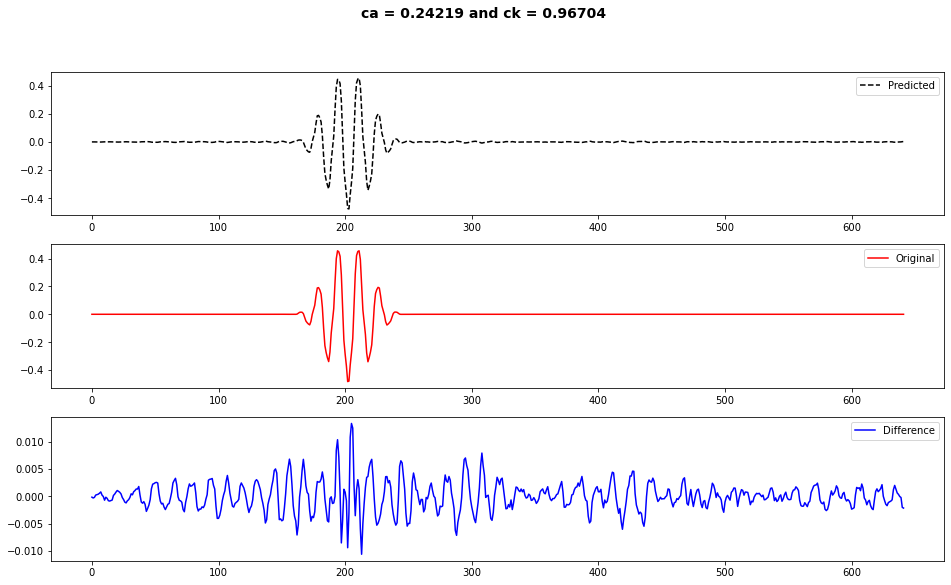

In [113]:
plot3(X_exp, Exp_predictions, p_exp, 7, 200)

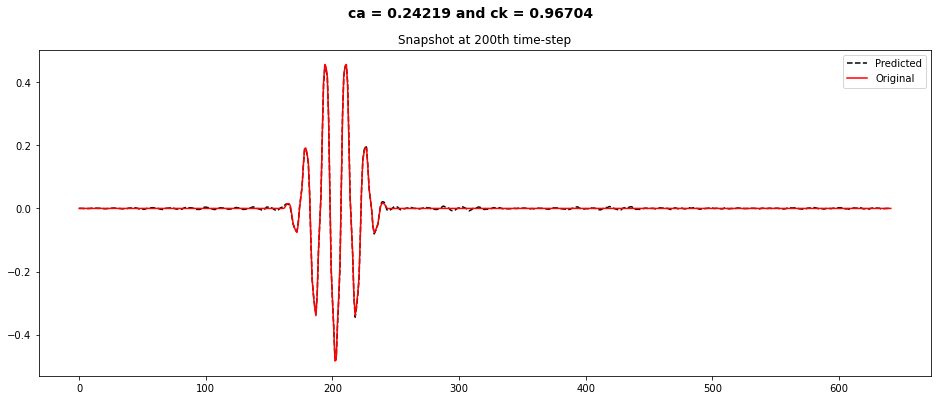

In [114]:
plot2(X_exp, Exp_predictions, p_exp, 7, 200)

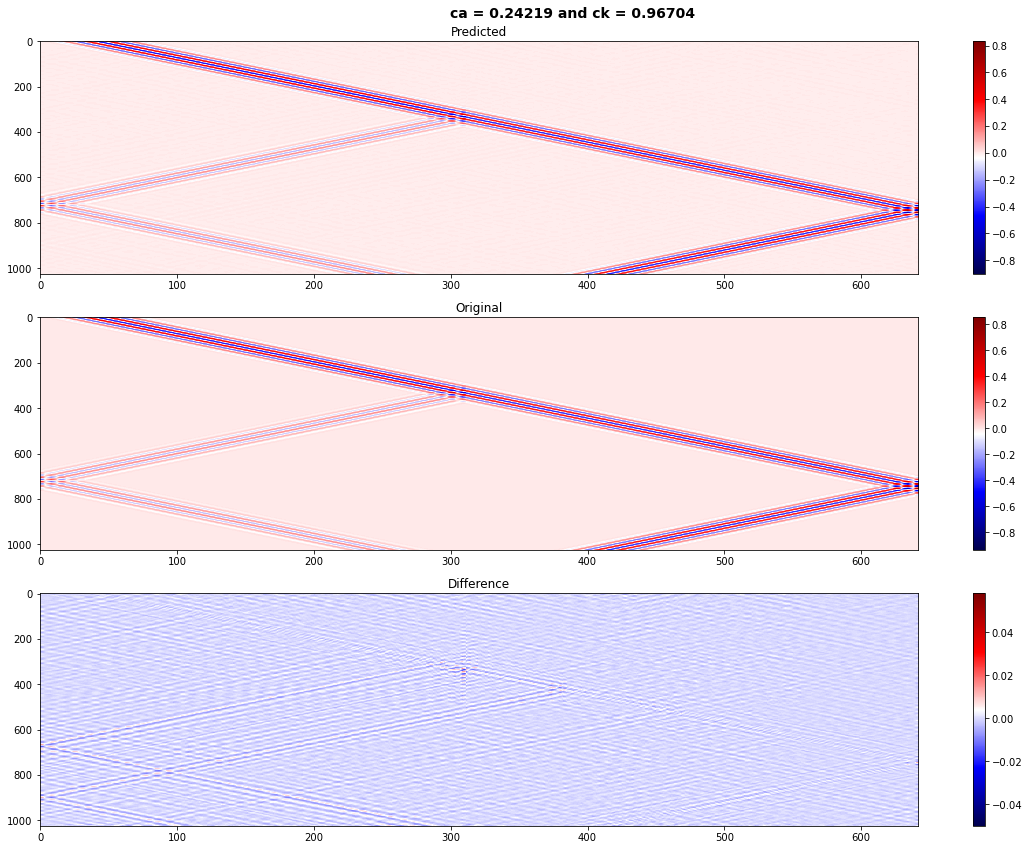

In [115]:
wave_pattern(p_exp, X_exp, Exp_predictions, 7)

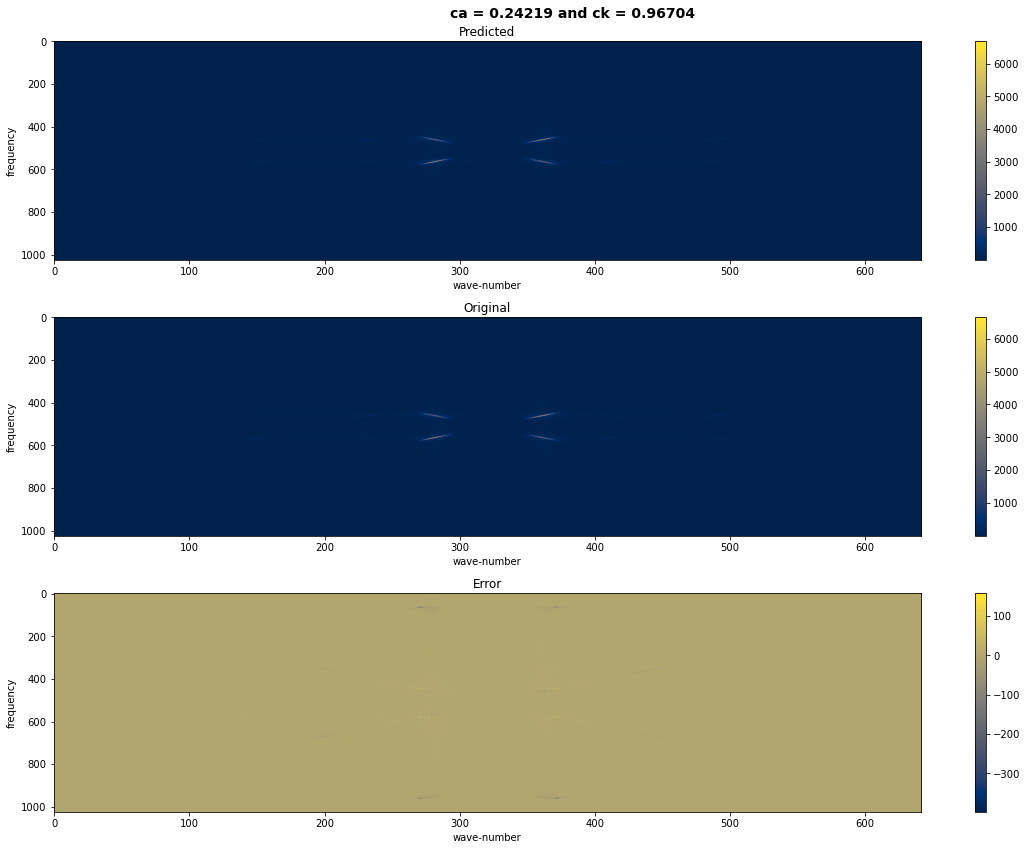

In [116]:
plot_fft(p_exp, X_exp, Exp_predictions, 7)

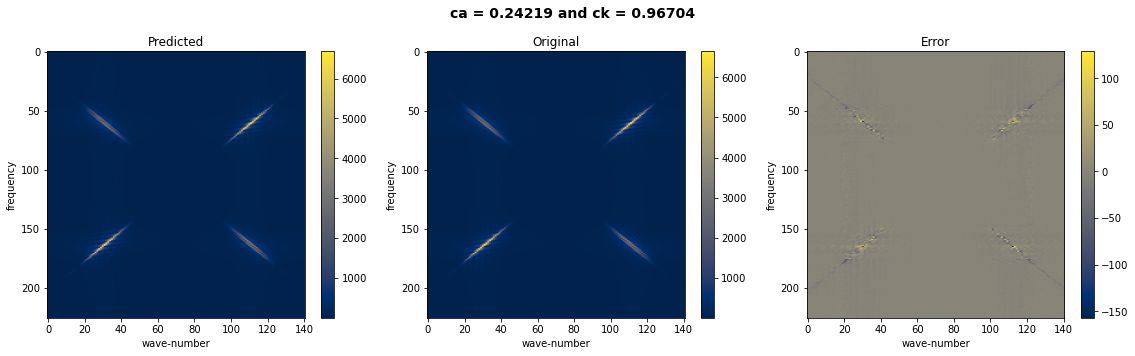

In [117]:
plot_fft_cropped(p_exp, X_exp, Exp_predictions, 7)

# Save results to `.mat` files

In [118]:
mat_path = paths['plot_scal'] + 'PyTorch_Preds_Exp_FNO_01/'
if not os.path.exists(mat_path):
    os.makedirs(mat_path)

mat_file = 'Exp_FNO_01.mat'

save_mat(Exp_predictions, mat_path, mat_file)